# IMPORTS

In [1]:
import os
import re
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from collections import defaultdict
from scipy.stats import beta
from scipy.special import betaln
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'hsd-besra'
epochs = 10
batch_size = 32
sequence_length = 64

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/multi-label-hate-speech-2/re_dataset.csv', encoding='latin-1')

alay_dict = pd.read_csv('/kaggle/input/multi-label-hate-speech-2/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

print("Shape: ", data.shape)
data.head()

Shape:  (13169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [7]:
data.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [8]:
data.HS.value_counts()

HS
0    7608
1    5561
Name: count, dtype: int64

In [9]:
data.Abusive.value_counts()

Abusive
0    8126
1    5043
Name: count, dtype: int64

In [10]:
print("Toxic shape: ", data[(data['HS'] == 1) | (data['Abusive'] == 1)].shape)
print("Non-toxic shape: ", data[(data['HS'] == 0) & (data['Abusive'] == 0)].shape)

Toxic shape:  (7309, 13)
Non-toxic shape:  (5860, 13)


In [11]:
print("Shape: ", alay_dict.shape)
alay_dict.head(15)

Shape:  (15167, 2)


,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
5,aamiin,amin
6,aamiinn,amin
7,aamin,amin
8,aammiin,amin
9,abis,habis


In [12]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('url', ' ', text) # Remove every URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub(r'\b(?:x[a-fA-F0-9]{2}\s*)+\b', '', text) # Remove emoji bytecode
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa \x8f \xd2\1 !!"))
print("lowercase: ", lowercase("Halooo, duniaa!"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe URL xf8 x2a x89"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
remove_unnecessary_char:  Hehe RT USER USER apa kabs hehe URL 
normalize_alay:  amin adik habis


In [13]:
def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text) 

    return text

In [14]:
data['Tweet'] = data['Tweet'].apply(preprocess)

# Define the labels columns for multi-label classification
label_columns = data.columns[1:]  # Assuming label columns start from the third column

train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=False)

# Extract features and labels for training and validation
X_train = train_data['Tweet'].values
y_train = train_data[label_columns].values
X_val = val_data['Tweet'].values
y_val = val_data[label_columns].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(10535,) (10535, 12)
(2634,) (2634, 12)


# BUILD DATASET & DATALOADERS

In [15]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=64, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float if self.use_float else torch.long)
        return item

    def get_per_class_probs(self):
        """
        Calculate the spread of labels (0 and 1) for each class in the dataset.
        Returns:
            dict: A dictionary where keys are class indices and values are [count_0, count_1].
        """

        # Initialize a dictionary to store counts for each class
        label_counts = defaultdict(lambda: [0, 0])  # [count_0, count_1] for each class

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update counts for each class
            for class_idx, label in enumerate(labels):
                label_counts[class_idx][int(label)] += 1

        for key in label_counts.keys():
            total = sum(label_counts[key])
            label_counts[key] = [x / total for x in label_counts[key]]

        return label_counts

    def get_global_probs(self):
        """
        Calculate the global count of 0s and 1s across all classes in the dataset.
        Returns:
            dict: A dictionary with keys '0' and '1' representing their global counts.
        """
        global_counts = {'0': 0, '1': 0}

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update global counts
            for label in labels:
                global_counts[str(int(label))] += 1

        total = global_counts['0'] + global_counts['1']
        for key in global_counts.keys():
            global_counts[key] /= total

        return global_counts


# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [16]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=64, num_workers=4):
    train_dataset = HateSpeechDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = HateSpeechDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [17]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [18]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong'],
        zero_division=0
    )   
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [19]:
def train_model(current_train_size, train_indices, metrics, trials, i):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(label_columns),
            problem_type="multi_label_classification"
        )
        
    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials+1}-model-{i+1}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"Model {i+1} - Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
        
    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Training completed in {duration} s")
    
    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(best_result['accuracy'])
        metrics[1].append(best_result['f1_micro'])
        metrics[2].append(best_result['f1_macro'])

# PLOT RESULT

In [20]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [21]:
def beta_score(p, y, alpha=0.1, beta=3):
    """Calculates Beta score for a given probability p and label y."""
    
    if y == 1:
        return -betaln(alpha, beta + 1) + betaln(alpha + p, beta + 1 - p)
    elif y == 0:
        return -betaln(alpha + 1, beta) + betaln(alpha + 1 - p, beta + p)
    else:
        raise ValueError("Invalid label: y must be 0 or 1.")

def bayesian_update(prior, likelihood, evidence, alpha=0.1, beta_param=3):
    """ 
    Bayes' Theorem: P(y'|x') = P(x'|y') * P(y') / P(x')
    P(y'|x') or likelihood = model probs
    p(y') or prior = class probabilities
    p(x') or evidence = 1 / number of data
    """
    
    # Using the Beta score to simulate the posterior
    posterior = (likelihood * prior) / evidence
    
    # We calculate the posterior using the Beta distribution
    return posterior

def compute_expected_score_change(predicted_prob, class_probs, label_probs, class_idx):
    scores_before = []
    scores_after = []

    # Before data addition: calculate Beta score for predicted prob
    scores_before.append(beta_score(predicted_prob, int(1 if predicted_prob >= 0.5 else 0)))
    scores_before.append(beta_score(1-predicted_prob, int(1 if predicted_prob >= 0.5 else 0)))
    
    # After data addition: use Bayesian update (posterior probability)
    for k in range(2):
        prior = predicted_prob
        likelihood = class_probs[class_idx][k]  # Likelihood is the true label (0 or 1)
        posterior = bayesian_update(prior, likelihood, 1)
        scores_after.append(beta_score(posterior, int(1 if posterior >= 0.5 else 0)))

    score_diff_0 = scores_after[0] - scores_before[0]
    score_diff_1 = scores_after[1] - scores_before[1]
    return label_probs['0'] * score_diff_0 + label_probs['1'] * score_diff_1

# Function to compute Expected Score Change (∆Q)
def besra_sampling(models, X_pool, train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, trials, n_clusters=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device
    
    dataset = HateSpeechDataset(X_pool, np.zeros((len(X_pool), 12)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )

    current_train_size = len(train_indices)
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    labeled_dataset = HateSpeechDataset(current_X_train, current_y_train, tokenizer, max_length=sequence_length)
    label_probs = labeled_dataset.get_global_probs()
    class_probs = labeled_dataset.get_per_class_probs()

    for model in models:
        model.to(device)
        model.eval()
    start_time = time.time()
    score_changes = []

    for batch in dataloader:
        input_ids = batch['input_ids'].to(model.device)
        attention_mask = batch['attention_mask'].to(model.device)
        labels = batch['labels'].to(model.device)

        model_probs = []

        for model in models:
            with torch.no_grad():
                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                probs = torch.sigmoid(logits)  # Multi-label classification uses sigmoid
                model_probs.append(probs.unsqueeze(0))  # Add batch dimension for averaging
        
        # Stack all model predictions and compute the mean across models
        model_probs = torch.cat(model_probs, dim=0)  # Concatenate predictions across models
        probs = model_probs.mean(dim=0)  # Take the mean along the model axis

        # Calculate Beta scores before and after data addition
        for i in range(len(probs)):
            score_diff = []
            for class_idx in range(probs.shape[1]):
                predicted_prob = probs[i, class_idx].item()
                score_diff.append(compute_expected_score_change(predicted_prob, class_probs, label_probs, class_idx))
            
            score_changes.append(np.mean(score_diff))
    
    accelerator.wait_for_everyone()    
    if accelerator.is_local_main_process:
        score_changes = np.array(score_changes)
        score_changes = score_changes.reshape(-1, 1)

        target_samples = math.ceil(0.1 * len(X_pool))
        collected_indices = set()
        thresholds = []
    
        # Check nearest checkpoint
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break

        # Determine number of maximum samples to be acquired
        if target_samples <= n_clusters and n_clusters < nearest_cp - current_train_size:
            target_samples = n_clusters
        elif target_samples > n_clusters and target_samples < nearest_cp - current_train_size:
            target_samples = target_samples
        else:
            arrived_at_cp = True
            target_samples = nearest_cp - current_train_size

        # No clustering needed when there's little data left
        if current_train_size >= checkpoints[len(checkpoints)-1] - min_increment:
            end_time = time.time()
            duration = end_time - start_time
            
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'HS': [y_train[i][0] for i in temp],
                'Abusive': [y_train[i][1] for i in temp],
                'HS_Individual': [y_train[i][2] for i in temp],
                'HS_Group': [y_train[i][3] for i in temp],
                'HS_Religion': [y_train[i][4] for i in temp],
                'HS_Race': [y_train[i][5] for i in temp],
                'HS_Physical': [y_train[i][6] for i in temp],
                'HS_Gender': [y_train[i][7] for i in temp],
                'HS_Other': [y_train[i][8] for i in temp],
                'HS_Weak': [y_train[i][9] for i in temp],
                'HS_Moderate': [y_train[i][10] for i in temp],
                'HS_Strong': [y_train[i][11] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in remaining_indices:
                new_samples.append(i)

        else:
            # Cluster the data based on its embeddings
            kmeans=KMeans(n_clusters=n_clusters, n_init=1)
            kmeans.fit(score_changes)
            
            for cluster_id in range(n_clusters):
                # Cluster center and indices of samples in the current cluster
                cluster_center = kmeans.cluster_centers_[cluster_id]
                cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]
            
                if cluster_indices.size == 0:
                    # Skip clusters with no members
                    print(f"Cluster {cluster_id} has no members, skipping.")
                    continue
            
                # Calculate distances of each point in the cluster from the cluster center
                cluster_distances = np.linalg.norm(score_changes[cluster_indices] - cluster_center, axis=1)
            
                # Determine the local threshold (10th percentile of closest distances to cluster center)
                local_threshold = np.percentile(cluster_distances, 90)
                thresholds.append(local_threshold)
            
                below_threshold_indices = cluster_indices[cluster_distances >= local_threshold]
                collected_indices.update(below_threshold_indices)

            # To handle multiple points with same distance
            if len(collected_indices) > target_samples:
                collected_indices = np.array(list(collected_indices))
                np.random.shuffle(collected_indices)
                collected_indices = collected_indices[:target_samples]
                
            end_time = time.time() 
            duration = end_time - start_time 
    
            if arrived_at_cp:
                temp = train_indices.copy()
                temp.extend(collected_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'HS': [y_train[i][0] for i in temp],
                    'Abusive': [y_train[i][1] for i in temp],
                    'HS_Individual': [y_train[i][2] for i in temp],
                    'HS_Group': [y_train[i][3] for i in temp],
                    'HS_Religion': [y_train[i][4] for i in temp],
                    'HS_Race': [y_train[i][5] for i in temp],
                    'HS_Physical': [y_train[i][6] for i in temp],
                    'HS_Gender': [y_train[i][7] for i in temp],
                    'HS_Other': [y_train[i][8] for i in temp],
                    'HS_Weak': [y_train[i][9] for i in temp],
                    'HS_Moderate': [y_train[i][10] for i in temp],
                    'HS_Strong': [y_train[i][11] for i in temp],
                })
        
                acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            # print(f"Thresholds: {thresholds}")
            print("Acquired samples:", len(collected_indices))
            print(f"Sampling duration: {duration} seconds")
        
            sampling_dur.append(duration)
            for i in collected_indices:
                new_samples.append(remaining_indices[i])

        threshold_data = pd.DataFrame({
            'Threshold': thresholds
        })
        threshold_data.to_csv(f"results/{filename}-thresholds-{trials+1}-{current_train_size}.csv", index=False)

# MAIN LOOP

In [22]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size

    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        model_accuracies = manager.list()
        model_f1_micros = manager.list()
        model_f1_macros = manager.list()
        
        # Train the model
        for j in range(3):
            set_seed(seed[j])
            args = (current_train_size, train_indices, (model_accuracies, model_f1_micros, model_f1_macros), i, j)
            notebook_launcher(train_model, args, num_processes=2)

        data_used.append(current_train_size)
        accuracies.append(np.mean(model_accuracies))
        f1_micros.append(np.mean(model_f1_micros))
        f1_macros.append(np.mean(model_f1_macros))
        print(f"Averaged - Iteration {current_train_size}: Accuracy: {round(np.mean(accuracies), 4)}, F1 Micro: {round(np.mean(f1_micros), 4)}, F1 Macro: {round(np.mean(f1_macros), 4)}")

        models = []
        for j in range(3):
            model = BertForSequenceClassification.from_pretrained(f'{filename}-{i+1}-model-{j+1}')
            models.append(model)
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (models, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, i)
        notebook_launcher(besra_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    model_accuracies = manager.list()
    model_f1_micros = manager.list()
    model_f1_macros = manager.list()
    
    for j in range(3):
        set_seed(seed[j])
        args = (current_train_size, train_indices, (model_accuracies, model_f1_micros, model_f1_macros), i, j)
        notebook_launcher(train_model, args, num_processes=2)
        
    data_used.append(current_train_size)
    accuracies.append(np.mean(model_accuracies))
    f1_micros.append(np.mean(model_f1_micros))
    f1_macros.append(np.mean(model_f1_macros))
    print(f"Averaged - Iteration {current_train_size}: Accuracy: {round(np.mean(accuracies), 4)}, F1 Micro: {round(np.mean(f1_micros), 4)}, F1 Macro: {round(np.mean(f1_macros), 4)}")
        
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [23]:
seeds = [[50, 67, 42], [81, 90, 11], [14, 61, 33], [3, 44, 85], [94, 21, 5]]

## RUN 1

TRIAL 1
Random seed: [50, 67, 42]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5482, Accuracy: 0.8278, F1 Micro: 0.0187, F1 Macro: 0.0071
Epoch 2/10, Train Loss: 0.4177, Accuracy: 0.8285, F1 Micro: 0.01, F1 Macro: 0.0046
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3956, Accuracy: 0.8373, F1 Micro: 0.132, F1 Macro: 0.0461
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3773, Accuracy: 0.8566, F1 Micro: 0.3534, F1 Macro: 0.1133
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3452, Accuracy: 0.8762, F1 Micro: 0.5511, F1 Macro: 0.2507
Epoch 6/10, Train Loss: 0.2866, Accuracy: 0.8735, F1 Micro: 0.4983, F1 Macro: 0.2345
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2649, Accuracy: 0.8792, F1 Micro: 0.5822, F1 Macro: 0.3047
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2359, Accuracy: 0.8794, F1 Micro: 0.5921, F1 Macro: 0.325
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1951, Accuracy: 0.8794, F1 Micro: 0.6097, F1 Macro: 0.3507
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.568, Accuracy: 0.8392, F1 Micro: 0.3169, F1 Macro: 0.0918
Epoch 2/10, Train Loss: 0.4254, Accuracy: 0.8336, F1 Micro: 0.0793, F1 Macro: 0.0304
Epoch 3/10, Train Loss: 0.3952, Accuracy: 0.8436, F1 Micro: 0.213, F1 Macro: 0.0739
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3766, Accuracy: 0.8579, F1 Micro: 0.3773, F1 Macro: 0.1227
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3432, Accuracy: 0.8733, F1 Micro: 0.5295, F1 Macro: 0.2306
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2894, Accuracy: 0.8765, F1 Micro: 0.5482, F1 Macro: 0.2528
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2627, Accuracy: 0.8719, F1 Micro: 0.6065, F1 Macro: 0.3202
Epoch 8/10, Train Loss: 0.2414, Accuracy: 0.8799, F1 Micro: 0.5963, F1 Macro: 0.3142
Epoch 9/10, Train Loss: 0.2006, Accuracy: 0.8797, F1 Micro: 0.5837, F1 Macro: 0.3153
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.1964, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5747, Accuracy: 0.8306, F1 Micro: 0.2662, F1 Macro: 0.0709
Epoch 2/10, Train Loss: 0.4239, Accuracy: 0.8327, F1 Micro: 0.0798, F1 Macro: 0.0313
Epoch 3/10, Train Loss: 0.3946, Accuracy: 0.8364, F1 Micro: 0.127, F1 Macro: 0.045
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3747, Accuracy: 0.8531, F1 Micro: 0.3133, F1 Macro: 0.1038
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3477, Accuracy: 0.8684, F1 Micro: 0.4764, F1 Macro: 0.1956
Epoch 6/10, Train Loss: 0.294, Accuracy: 0.8707, F1 Micro: 0.4687, F1 Macro: 0.2145
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2699, Accuracy: 0.8776, F1 Micro: 0.5892, F1 Macro: 0.2897
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2444, Accuracy: 0.8803, F1 Micro: 0.6068, F1 Macro: 0.3164
Epoch 9/10, Train Loss: 0.2046, Accuracy: 0.8806, F1 Micro: 0.6046, F1 Macro: 0.33
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.1965, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4731, Accuracy: 0.8323, F1 Micro: 0.0595, F1 Macro: 0.0241
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3675, Accuracy: 0.8593, F1 Micro: 0.3564, F1 Macro: 0.1452
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3247, Accuracy: 0.8797, F1 Micro: 0.5453, F1 Macro: 0.2579
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2646, Accuracy: 0.891, F1 Micro: 0.6415, F1 Macro: 0.3657
Epoch 5/10, Train Loss: 0.2355, Accuracy: 0.889, F1 Micro: 0.6025, F1 Macro: 0.3728
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2016, Accuracy: 0.8942, F1 Micro: 0.676, F1 Macro: 0.4784
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1666, Accuracy: 0.8957, F1 Micro: 0.6889, F1 Macro: 0.4929
Epoch 8/10, Train Loss: 0.1435, Accuracy: 0.8961, F1 Micro: 0.6659, F1 Macro: 0.4641
Epoch 9/10, Train Loss: 0.1242, Accuracy: 0.8976, F1 Micro: 0.6716, F1 Macro: 0.48
Epoch 10/10, Train Loss: 0.1063, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4834, Accuracy: 0.8386, F1 Micro: 0.1482, F1 Macro: 0.0542
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3651, Accuracy: 0.8665, F1 Micro: 0.429, F1 Macro: 0.1783
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3226, Accuracy: 0.8781, F1 Micro: 0.534, F1 Macro: 0.2456
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2654, Accuracy: 0.8886, F1 Micro: 0.6207, F1 Macro: 0.3336
Epoch 5/10, Train Loss: 0.2392, Accuracy: 0.8886, F1 Micro: 0.5926, F1 Macro: 0.3578
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.207, Accuracy: 0.8932, F1 Micro: 0.6743, F1 Macro: 0.4469
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1736, Accuracy: 0.8938, F1 Micro: 0.6844, F1 Macro: 0.495
Epoch 8/10, Train Loss: 0.1481, Accuracy: 0.8908, F1 Micro: 0.6777, F1 Macro: 0.4786
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1274, Accuracy: 0.8976, F1 Micro: 0.6941, F1 Macro: 0.511
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4852, Accuracy: 0.8349, F1 Micro: 0.1105, F1 Macro: 0.0403
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3636, Accuracy: 0.8602, F1 Micro: 0.3842, F1 Macro: 0.1492
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3265, Accuracy: 0.8762, F1 Micro: 0.5089, F1 Macro: 0.2392
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.269, Accuracy: 0.8894, F1 Micro: 0.6337, F1 Macro: 0.3527
Epoch 5/10, Train Loss: 0.2405, Accuracy: 0.8852, F1 Micro: 0.5692, F1 Macro: 0.3127
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2107, Accuracy: 0.8942, F1 Micro: 0.6788, F1 Macro: 0.4721
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1771, Accuracy: 0.8973, F1 Micro: 0.6825, F1 Macro: 0.4907
Epoch 8/10, Train Loss: 0.1509, Accuracy: 0.8973, F1 Micro: 0.675, F1 Macro: 0.4829
Epoch 9/10, Train Loss: 0.1283, Accuracy: 0.8994, F1 Micro: 0.6824, F1 Macro: 0.5008
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4433, Accuracy: 0.8528, F1 Micro: 0.3789, F1 Macro: 0.1152
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3311, Accuracy: 0.8841, F1 Micro: 0.619, F1 Macro: 0.3151
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2786, Accuracy: 0.8918, F1 Micro: 0.6744, F1 Macro: 0.408
Epoch 4/10, Train Loss: 0.2231, Accuracy: 0.8947, F1 Micro: 0.6221, F1 Macro: 0.365
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1967, Accuracy: 0.8954, F1 Micro: 0.6986, F1 Macro: 0.4692
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1593, Accuracy: 0.8976, F1 Micro: 0.7068, F1 Macro: 0.5262
Epoch 7/10, Train Loss: 0.1351, Accuracy: 0.9013, F1 Micro: 0.6803, F1 Macro: 0.5066
Epoch 8/10, Train Loss: 0.1076, Accuracy: 0.9011, F1 Micro: 0.7057, F1 Macro: 0.5324
Epoch 9/10, Train Loss: 0.0964, Accuracy: 0.9046, F1 Micro: 0.6903, F1 Macro: 0.5492
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.076, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4493, Accuracy: 0.8541, F1 Micro: 0.3744, F1 Macro: 0.1179
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3305, Accuracy: 0.8819, F1 Micro: 0.5971, F1 Macro: 0.2822
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2795, Accuracy: 0.8886, F1 Micro: 0.669, F1 Macro: 0.386
Epoch 4/10, Train Loss: 0.2247, Accuracy: 0.8968, F1 Micro: 0.6585, F1 Macro: 0.4279
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2013, Accuracy: 0.8947, F1 Micro: 0.6812, F1 Macro: 0.4183
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1649, Accuracy: 0.8909, F1 Micro: 0.7059, F1 Macro: 0.5372
Epoch 7/10, Train Loss: 0.1411, Accuracy: 0.9008, F1 Micro: 0.701, F1 Macro: 0.5347
Epoch 8/10, Train Loss: 0.1136, Accuracy: 0.8992, F1 Micro: 0.7041, F1 Macro: 0.5172
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0955, Accuracy: 0.9047, F1 Micro: 0.7088, F1 Macro: 0.5582
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4491, Accuracy: 0.8539, F1 Micro: 0.3523, F1 Macro: 0.1084
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3313, Accuracy: 0.8833, F1 Micro: 0.6122, F1 Macro: 0.299
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2807, Accuracy: 0.8882, F1 Micro: 0.6727, F1 Macro: 0.3896
Epoch 4/10, Train Loss: 0.2254, Accuracy: 0.8922, F1 Micro: 0.6066, F1 Macro: 0.3669
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2002, Accuracy: 0.8968, F1 Micro: 0.6997, F1 Macro: 0.4916
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1678, Accuracy: 0.8954, F1 Micro: 0.712, F1 Macro: 0.5395
Epoch 7/10, Train Loss: 0.14, Accuracy: 0.901, F1 Micro: 0.6969, F1 Macro: 0.5328
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1108, Accuracy: 0.9024, F1 Micro: 0.7141, F1 Macro: 0.5386
Epoch 9/10, Train Loss: 0.0943, Accuracy: 0.9043, F1 Micro: 0.7001, F1 Macro: 0.5554
Epoch 10/10, Train Loss: 0.0778, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4288, Accuracy: 0.8683, F1 Micro: 0.477, F1 Macro: 0.1979
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3118, Accuracy: 0.8911, F1 Micro: 0.6355, F1 Macro: 0.3731
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2502, Accuracy: 0.8996, F1 Micro: 0.6835, F1 Macro: 0.5
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.206, Accuracy: 0.9046, F1 Micro: 0.6912, F1 Macro: 0.4858
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1635, Accuracy: 0.9059, F1 Micro: 0.7103, F1 Macro: 0.5308
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1308, Accuracy: 0.9053, F1 Micro: 0.7185, F1 Macro: 0.5379
Epoch 7/10, Train Loss: 0.1143, Accuracy: 0.9079, F1 Micro: 0.717, F1 Macro: 0.559
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0942, Accuracy: 0.9069, F1 Micro: 0.7298, F1 Macro: 0.5996
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0796, Accuracy: 0.9074, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4327, Accuracy: 0.8696, F1 Micro: 0.5235, F1 Macro: 0.2181
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3155, Accuracy: 0.8896, F1 Micro: 0.6206, F1 Macro: 0.3674
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2556, Accuracy: 0.8983, F1 Micro: 0.6659, F1 Macro: 0.4665
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.211, Accuracy: 0.9036, F1 Micro: 0.6973, F1 Macro: 0.491
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1689, Accuracy: 0.9106, F1 Micro: 0.7255, F1 Macro: 0.5538
Epoch 6/10, Train Loss: 0.14, Accuracy: 0.9106, F1 Micro: 0.725, F1 Macro: 0.5467
Epoch 7/10, Train Loss: 0.1172, Accuracy: 0.9099, F1 Micro: 0.7234, F1 Macro: 0.5697
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0958, Accuracy: 0.9122, F1 Micro: 0.7325, F1 Macro: 0.6162
Epoch 9/10, Train Loss: 0.0788, Accuracy: 0.9076, F1 Micro: 0.7323, F1 Macro: 0.6171
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4345, Accuracy: 0.8667, F1 Micro: 0.4688, F1 Macro: 0.1862
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3152, Accuracy: 0.8911, F1 Micro: 0.6385, F1 Macro: 0.3701
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2524, Accuracy: 0.9013, F1 Micro: 0.6865, F1 Macro: 0.5081
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2068, Accuracy: 0.9052, F1 Micro: 0.6993, F1 Macro: 0.512
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1658, Accuracy: 0.9092, F1 Micro: 0.7163, F1 Macro: 0.5532
Epoch 6/10, Train Loss: 0.1371, Accuracy: 0.9076, F1 Micro: 0.7109, F1 Macro: 0.5405
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1201, Accuracy: 0.9065, F1 Micro: 0.7188, F1 Macro: 0.5645
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0942, Accuracy: 0.9062, F1 Micro: 0.7243, F1 Macro: 0.5885
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0819, Accuracy: 0.9081, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4169, Accuracy: 0.878, F1 Micro: 0.55, F1 Macro: 0.2503
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2885, Accuracy: 0.8955, F1 Micro: 0.662, F1 Macro: 0.4249
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2332, Accuracy: 0.9042, F1 Micro: 0.7077, F1 Macro: 0.4888
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1888, Accuracy: 0.9076, F1 Micro: 0.7142, F1 Macro: 0.5489
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1533, Accuracy: 0.9109, F1 Micro: 0.7289, F1 Macro: 0.5712
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1219, Accuracy: 0.9125, F1 Micro: 0.7292, F1 Macro: 0.5937
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1023, Accuracy: 0.9129, F1 Micro: 0.742, F1 Macro: 0.6175
Epoch 8/10, Train Loss: 0.0849, Accuracy: 0.9146, F1 Micro: 0.7387, F1 Macro: 0.618
Epoch 9/10, Train Loss: 0.0673, Accuracy: 0.9104, F1 Micro: 0.7412, F1 Macro: 0.6393
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4187, Accuracy: 0.8778, F1 Micro: 0.5537, F1 Macro: 0.2454
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2897, Accuracy: 0.8962, F1 Micro: 0.6607, F1 Macro: 0.4174
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2349, Accuracy: 0.9024, F1 Micro: 0.7119, F1 Macro: 0.4887
Epoch 4/10, Train Loss: 0.1902, Accuracy: 0.9054, F1 Micro: 0.6897, F1 Macro: 0.5347
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1581, Accuracy: 0.9092, F1 Micro: 0.7309, F1 Macro: 0.5816
Epoch 6/10, Train Loss: 0.1218, Accuracy: 0.9103, F1 Micro: 0.7213, F1 Macro: 0.6048
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1035, Accuracy: 0.9108, F1 Micro: 0.7413, F1 Macro: 0.6388
Epoch 8/10, Train Loss: 0.0877, Accuracy: 0.9129, F1 Micro: 0.7401, F1 Macro: 0.6501
Epoch 9/10, Train Loss: 0.0761, Accuracy: 0.9142, F1 Micro: 0.7308, F1 Macro: 0.6352
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0612, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4201, Accuracy: 0.8753, F1 Micro: 0.5261, F1 Macro: 0.2306
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2923, Accuracy: 0.8949, F1 Micro: 0.6575, F1 Macro: 0.4222
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2364, Accuracy: 0.9027, F1 Micro: 0.7112, F1 Macro: 0.4959
Epoch 4/10, Train Loss: 0.1925, Accuracy: 0.908, F1 Micro: 0.7052, F1 Macro: 0.5412
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1594, Accuracy: 0.911, F1 Micro: 0.7213, F1 Macro: 0.5691
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1248, Accuracy: 0.9105, F1 Micro: 0.7232, F1 Macro: 0.5863
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1069, Accuracy: 0.912, F1 Micro: 0.7386, F1 Macro: 0.6118
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0851, Accuracy: 0.9138, F1 Micro: 0.7395, F1 Macro: 0.6408
Epoch 9/10, Train Loss: 0.0725, Accuracy: 0.9133, F1 Micro: 0.7362, F1 Macro: 0.6376
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4053, Accuracy: 0.8805, F1 Micro: 0.6086, F1 Macro: 0.3017
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2741, Accuracy: 0.8998, F1 Micro: 0.6633, F1 Macro: 0.4401
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.228, Accuracy: 0.9058, F1 Micro: 0.7251, F1 Macro: 0.5431
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1892, Accuracy: 0.9126, F1 Micro: 0.7295, F1 Macro: 0.5613
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1497, Accuracy: 0.9156, F1 Micro: 0.7444, F1 Macro: 0.6299
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1169, Accuracy: 0.9176, F1 Micro: 0.75, F1 Macro: 0.6107
Epoch 7/10, Train Loss: 0.0992, Accuracy: 0.9145, F1 Micro: 0.7482, F1 Macro: 0.6445
Epoch 8/10, Train Loss: 0.0815, Accuracy: 0.9081, F1 Micro: 0.7391, F1 Macro: 0.6389
Epoch 9/10, Train Loss: 0.0684, Accuracy: 0.9152, F1 Micro: 0.7393, F1 Macro: 0.6543
Epoch 10/10, Train Loss: 0.0565, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4086, Accuracy: 0.8788, F1 Micro: 0.5967, F1 Macro: 0.2768
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2764, Accuracy: 0.8996, F1 Micro: 0.6705, F1 Macro: 0.4421
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2299, Accuracy: 0.9041, F1 Micro: 0.7245, F1 Macro: 0.546
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1933, Accuracy: 0.914, F1 Micro: 0.7263, F1 Macro: 0.5593
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1534, Accuracy: 0.9152, F1 Micro: 0.7342, F1 Macro: 0.6044
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1211, Accuracy: 0.9165, F1 Micro: 0.747, F1 Macro: 0.6191
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0964, Accuracy: 0.9143, F1 Micro: 0.7477, F1 Macro: 0.6351
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0812, Accuracy: 0.9145, F1 Micro: 0.7518, F1 Macro: 0.6611
Epoch 9/10, Train Loss: 0.0664, Accuracy: 0.9147, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4073, Accuracy: 0.8793, F1 Micro: 0.6096, F1 Macro: 0.2973
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2771, Accuracy: 0.8987, F1 Micro: 0.6531, F1 Macro: 0.4309
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2317, Accuracy: 0.9059, F1 Micro: 0.7229, F1 Macro: 0.5442
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1931, Accuracy: 0.9115, F1 Micro: 0.7272, F1 Macro: 0.5745
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1507, Accuracy: 0.9158, F1 Micro: 0.7452, F1 Macro: 0.6043
Epoch 6/10, Train Loss: 0.1193, Accuracy: 0.9146, F1 Micro: 0.7338, F1 Macro: 0.5933
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0964, Accuracy: 0.9133, F1 Micro: 0.7491, F1 Macro: 0.6173
Epoch 8/10, Train Loss: 0.0821, Accuracy: 0.9149, F1 Micro: 0.7422, F1 Macro: 0.6395
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0667, Accuracy: 0.9162, F1 Micro: 0.7505, F1 Macro: 0.6505
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3871, Accuracy: 0.8835, F1 Micro: 0.6275, F1 Macro: 0.3025
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2654, Accuracy: 0.9041, F1 Micro: 0.6934, F1 Macro: 0.4946
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2195, Accuracy: 0.9076, F1 Micro: 0.7344, F1 Macro: 0.5621
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1759, Accuracy: 0.9122, F1 Micro: 0.7476, F1 Macro: 0.5969
Epoch 5/10, Train Loss: 0.142, Accuracy: 0.9151, F1 Micro: 0.7432, F1 Macro: 0.6241
Epoch 6/10, Train Loss: 0.1126, Accuracy: 0.9168, F1 Micro: 0.7425, F1 Macro: 0.6268
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0916, Accuracy: 0.9157, F1 Micro: 0.7539, F1 Macro: 0.6487
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0722, Accuracy: 0.9185, F1 Micro: 0.756, F1 Macro: 0.661
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0596, Accuracy: 0.9169, F1 Micro: 0.7564, F1 Macro: 0.667
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3904, Accuracy: 0.881, F1 Micro: 0.6184, F1 Macro: 0.2935
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2697, Accuracy: 0.9021, F1 Micro: 0.6838, F1 Macro: 0.4514
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2216, Accuracy: 0.9074, F1 Micro: 0.725, F1 Macro: 0.5435
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1801, Accuracy: 0.9135, F1 Micro: 0.7429, F1 Macro: 0.5985
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1464, Accuracy: 0.913, F1 Micro: 0.751, F1 Macro: 0.6223
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1181, Accuracy: 0.9165, F1 Micro: 0.7562, F1 Macro: 0.6537
Epoch 7/10, Train Loss: 0.0922, Accuracy: 0.9172, F1 Micro: 0.7507, F1 Macro: 0.6409
Epoch 8/10, Train Loss: 0.0791, Accuracy: 0.9164, F1 Micro: 0.754, F1 Macro: 0.6545
Epoch 9/10, Train Loss: 0.0677, Accuracy: 0.9161, F1 Micro: 0.7438, F1 Macro: 0.6472
Epoch 10/10, Train Loss: 0.0547, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3908, Accuracy: 0.8805, F1 Micro: 0.6268, F1 Macro: 0.3053
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2703, Accuracy: 0.9014, F1 Micro: 0.6754, F1 Macro: 0.4745
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2219, Accuracy: 0.9085, F1 Micro: 0.7291, F1 Macro: 0.5688
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1773, Accuracy: 0.9123, F1 Micro: 0.7422, F1 Macro: 0.5941
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1469, Accuracy: 0.9131, F1 Micro: 0.7455, F1 Macro: 0.6168
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1143, Accuracy: 0.9157, F1 Micro: 0.751, F1 Macro: 0.6398
Epoch 7/10, Train Loss: 0.0932, Accuracy: 0.9151, F1 Micro: 0.7457, F1 Macro: 0.6365
Epoch 8/10, Train Loss: 0.077, Accuracy: 0.9132, F1 Micro: 0.7419, F1 Macro: 0.6469
Epoch 9/10, Train Loss: 0.0626, Accuracy: 0.9156, F1 Micro: 0.7481, F1 Macro: 0.6595
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3813, Accuracy: 0.8857, F1 Micro: 0.6016, F1 Macro: 0.3015
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2572, Accuracy: 0.8983, F1 Micro: 0.7149, F1 Macro: 0.5434
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2111, Accuracy: 0.9131, F1 Micro: 0.7323, F1 Macro: 0.574
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1713, Accuracy: 0.9155, F1 Micro: 0.7512, F1 Macro: 0.6083
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1368, Accuracy: 0.9124, F1 Micro: 0.7547, F1 Macro: 0.6294
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1046, Accuracy: 0.9164, F1 Micro: 0.7591, F1 Macro: 0.6448
Epoch 7/10, Train Loss: 0.085, Accuracy: 0.9185, F1 Micro: 0.7546, F1 Macro: 0.6678
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0696, Accuracy: 0.9198, F1 Micro: 0.7628, F1 Macro: 0.6642
Epoch 9/10, Train Loss: 0.0608, Accuracy: 0.919, F1 Micro: 0.7481, F1 Macro: 0.6771
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3814, Accuracy: 0.8846, F1 Micro: 0.6008, F1 Macro: 0.3023
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2575, Accuracy: 0.9001, F1 Micro: 0.7113, F1 Macro: 0.5277
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2141, Accuracy: 0.9146, F1 Micro: 0.7338, F1 Macro: 0.5715
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1771, Accuracy: 0.9176, F1 Micro: 0.7463, F1 Macro: 0.606
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1391, Accuracy: 0.9166, F1 Micro: 0.7515, F1 Macro: 0.6222
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1088, Accuracy: 0.9148, F1 Micro: 0.7519, F1 Macro: 0.6512
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0874, Accuracy: 0.9147, F1 Micro: 0.752, F1 Macro: 0.6704
Epoch 8/10, Train Loss: 0.0712, Accuracy: 0.9131, F1 Micro: 0.7484, F1 Macro: 0.6475
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0585, Accuracy: 0.9191, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3833, Accuracy: 0.8852, F1 Micro: 0.5983, F1 Macro: 0.2953
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2596, Accuracy: 0.8977, F1 Micro: 0.7128, F1 Macro: 0.5487
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2147, Accuracy: 0.9131, F1 Micro: 0.7313, F1 Macro: 0.5761
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1724, Accuracy: 0.9164, F1 Micro: 0.7511, F1 Macro: 0.6055
Epoch 5/10, Train Loss: 0.1378, Accuracy: 0.9142, F1 Micro: 0.7485, F1 Macro: 0.6208
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1061, Accuracy: 0.9179, F1 Micro: 0.7571, F1 Macro: 0.6447
Epoch 7/10, Train Loss: 0.0869, Accuracy: 0.9116, F1 Micro: 0.7517, F1 Macro: 0.6696
Epoch 8/10, Train Loss: 0.0707, Accuracy: 0.9132, F1 Micro: 0.7512, F1 Macro: 0.6558
Epoch 9/10, Train Loss: 0.0623, Accuracy: 0.9187, F1 Micro: 0.7545, F1 Macro: 0.6801
Epoch 10/10, Train Loss: 0.0511, Accuracy: 0.9185, F1 Micro: 0.7532, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3783, Accuracy: 0.8875, F1 Micro: 0.6292, F1 Macro: 0.3408
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2571, Accuracy: 0.9072, F1 Micro: 0.7242, F1 Macro: 0.5451
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2099, Accuracy: 0.9116, F1 Micro: 0.7486, F1 Macro: 0.5926
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1689, Accuracy: 0.9177, F1 Micro: 0.7492, F1 Macro: 0.624
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1269, Accuracy: 0.9188, F1 Micro: 0.7546, F1 Macro: 0.633
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1061, Accuracy: 0.9147, F1 Micro: 0.7562, F1 Macro: 0.6667
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0833, Accuracy: 0.9201, F1 Micro: 0.7624, F1 Macro: 0.6689
Epoch 8/10, Train Loss: 0.0715, Accuracy: 0.9195, F1 Micro: 0.7559, F1 Macro: 0.6768
Epoch 9/10, Train Loss: 0.057, Accuracy: 0.9214, F1 Micro: 0.762, F1 Macro: 0.6765
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3796, Accuracy: 0.8883, F1 Micro: 0.6346, F1 Macro: 0.3314
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2606, Accuracy: 0.9065, F1 Micro: 0.7175, F1 Macro: 0.5291
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.215, Accuracy: 0.9145, F1 Micro: 0.7466, F1 Macro: 0.5923
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.172, Accuracy: 0.9188, F1 Micro: 0.7522, F1 Macro: 0.6264
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1314, Accuracy: 0.9188, F1 Micro: 0.7529, F1 Macro: 0.635
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.11, Accuracy: 0.9146, F1 Micro: 0.7544, F1 Macro: 0.666
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0856, Accuracy: 0.9158, F1 Micro: 0.7587, F1 Macro: 0.6754
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0687, Accuracy: 0.9203, F1 Micro: 0.7645, F1 Macro: 0.6894
Epoch 9/10, Train Loss: 0.0594, Accuracy: 0.9212, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.38, Accuracy: 0.8875, F1 Micro: 0.6316, F1 Macro: 0.3259
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2593, Accuracy: 0.9071, F1 Micro: 0.7098, F1 Macro: 0.5122
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2137, Accuracy: 0.9099, F1 Micro: 0.7447, F1 Macro: 0.5887
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1715, Accuracy: 0.9173, F1 Micro: 0.7489, F1 Macro: 0.6215
Epoch 5/10, Train Loss: 0.1311, Accuracy: 0.9181, F1 Micro: 0.7397, F1 Macro: 0.6199
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1084, Accuracy: 0.9171, F1 Micro: 0.7585, F1 Macro: 0.6507
Epoch 7/10, Train Loss: 0.0866, Accuracy: 0.9138, F1 Micro: 0.7572, F1 Macro: 0.65
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0727, Accuracy: 0.9213, F1 Micro: 0.7603, F1 Macro: 0.6775
Epoch 9/10, Train Loss: 0.0599, Accuracy: 0.9203, F1 Micro: 0.75, F1 Macro: 0.655
Epoch 10/10, Train Loss: 0.0539, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3827, Accuracy: 0.8814, F1 Micro: 0.667, F1 Macro: 0.3828
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2579, Accuracy: 0.9036, F1 Micro: 0.6997, F1 Macro: 0.4976
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2118, Accuracy: 0.9144, F1 Micro: 0.7285, F1 Macro: 0.5633
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1719, Accuracy: 0.9189, F1 Micro: 0.7525, F1 Macro: 0.6099
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1326, Accuracy: 0.9193, F1 Micro: 0.756, F1 Macro: 0.6461
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1045, Accuracy: 0.9179, F1 Micro: 0.7603, F1 Macro: 0.6519
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0888, Accuracy: 0.9191, F1 Micro: 0.7676, F1 Macro: 0.6795
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0699, Accuracy: 0.9218, F1 Micro: 0.7713, F1 Macro: 0.6913
Epoch 9/10, Train Loss: 0.0575, Accuracy: 0.9167, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3834, Accuracy: 0.8858, F1 Micro: 0.6575, F1 Macro: 0.3638
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2608, Accuracy: 0.9029, F1 Micro: 0.701, F1 Macro: 0.5093
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2153, Accuracy: 0.9143, F1 Micro: 0.7338, F1 Macro: 0.5668
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1737, Accuracy: 0.9203, F1 Micro: 0.7526, F1 Macro: 0.6163
Epoch 5/10, Train Loss: 0.1397, Accuracy: 0.9197, F1 Micro: 0.7444, F1 Macro: 0.6299
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1091, Accuracy: 0.919, F1 Micro: 0.7595, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0884, Accuracy: 0.9147, F1 Micro: 0.7613, F1 Macro: 0.6763
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0717, Accuracy: 0.9213, F1 Micro: 0.7685, F1 Macro: 0.6814
Epoch 9/10, Train Loss: 0.0599, Accuracy: 0.914, F1 Micro: 0.7594, F1 Macro: 0.688
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3862, Accuracy: 0.8817, F1 Micro: 0.6638, F1 Macro: 0.3763
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2601, Accuracy: 0.9018, F1 Micro: 0.7043, F1 Macro: 0.5161
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2136, Accuracy: 0.9136, F1 Micro: 0.7158, F1 Macro: 0.5527
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1731, Accuracy: 0.9182, F1 Micro: 0.7429, F1 Macro: 0.5972
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1334, Accuracy: 0.9181, F1 Micro: 0.7557, F1 Macro: 0.6279
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1094, Accuracy: 0.9211, F1 Micro: 0.761, F1 Macro: 0.6545
Epoch 7/10, Train Loss: 0.0876, Accuracy: 0.9114, F1 Micro: 0.7566, F1 Macro: 0.6671
Epoch 8/10, Train Loss: 0.0709, Accuracy: 0.9164, F1 Micro: 0.7603, F1 Macro: 0.6673
Epoch 9/10, Train Loss: 0.0598, Accuracy: 0.9156, F1 Micro: 0.7597, F1 Macro: 0.6764
Epoch 10/10, Train Loss: 0.0531, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.363, Accuracy: 0.8926, F1 Micro: 0.6413, F1 Macro: 0.3954
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2455, Accuracy: 0.9077, F1 Micro: 0.6855, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1929, Accuracy: 0.9182, F1 Micro: 0.7513, F1 Macro: 0.5957
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1623, Accuracy: 0.9192, F1 Micro: 0.761, F1 Macro: 0.6206
Epoch 5/10, Train Loss: 0.1253, Accuracy: 0.9192, F1 Micro: 0.7577, F1 Macro: 0.6433
Epoch 6/10, Train Loss: 0.1025, Accuracy: 0.9199, F1 Micro: 0.7523, F1 Macro: 0.634
Epoch 7/10, Train Loss: 0.0878, Accuracy: 0.9192, F1 Micro: 0.761, F1 Macro: 0.6651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.066, Accuracy: 0.9147, F1 Micro: 0.7613, F1 Macro: 0.6846
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0554, Accuracy: 0.9213, F1 Micro: 0.7674, F1 Macro: 0.6996
Epoch 10/10, Train Loss: 0.0488, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.37, Accuracy: 0.8924, F1 Micro: 0.6379, F1 Macro: 0.3717
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.25, Accuracy: 0.9057, F1 Micro: 0.6783, F1 Macro: 0.4534
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1952, Accuracy: 0.9191, F1 Micro: 0.7474, F1 Macro: 0.5917
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1654, Accuracy: 0.9213, F1 Micro: 0.7667, F1 Macro: 0.6288
Epoch 5/10, Train Loss: 0.1232, Accuracy: 0.9215, F1 Micro: 0.7636, F1 Macro: 0.6572
Epoch 6/10, Train Loss: 0.1044, Accuracy: 0.9226, F1 Micro: 0.7653, F1 Macro: 0.6748
Epoch 7/10, Train Loss: 0.0873, Accuracy: 0.9197, F1 Micro: 0.7667, F1 Macro: 0.6748
Epoch 8/10, Train Loss: 0.0669, Accuracy: 0.9186, F1 Micro: 0.757, F1 Macro: 0.6815
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0563, Accuracy: 0.9214, F1 Micro: 0.772, F1 Macro: 0.6988
Epoch 10/10, Train Loss: 0.0511, Accuracy: 0.9177, F1 Micro: 0.764, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3692, Accuracy: 0.8923, F1 Micro: 0.6525, F1 Macro: 0.3949
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2506, Accuracy: 0.9062, F1 Micro: 0.6855, F1 Macro: 0.4819
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.197, Accuracy: 0.9175, F1 Micro: 0.7414, F1 Macro: 0.5841
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1664, Accuracy: 0.9202, F1 Micro: 0.7643, F1 Macro: 0.6194
Epoch 5/10, Train Loss: 0.1276, Accuracy: 0.9213, F1 Micro: 0.7608, F1 Macro: 0.6597
Epoch 6/10, Train Loss: 0.1043, Accuracy: 0.9213, F1 Micro: 0.7589, F1 Macro: 0.6441
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0902, Accuracy: 0.9227, F1 Micro: 0.7736, F1 Macro: 0.6911
Epoch 8/10, Train Loss: 0.0691, Accuracy: 0.919, F1 Micro: 0.752, F1 Macro: 0.6798
Epoch 9/10, Train Loss: 0.0587, Accuracy: 0.9217, F1 Micro: 0.7674, F1 Macro: 0.6979
Epoch 10/10, Train Loss: 0.0524, Accuracy: 0.9166, F1 Micro: 0.765, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3666, Accuracy: 0.8929, F1 Micro: 0.6626, F1 Macro: 0.4136
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2458, Accuracy: 0.9094, F1 Micro: 0.7279, F1 Macro: 0.5398
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1965, Accuracy: 0.9177, F1 Micro: 0.7358, F1 Macro: 0.5633
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1567, Accuracy: 0.9208, F1 Micro: 0.7622, F1 Macro: 0.6289
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1292, Accuracy: 0.9215, F1 Micro: 0.7722, F1 Macro: 0.6642
Epoch 6/10, Train Loss: 0.0987, Accuracy: 0.9173, F1 Micro: 0.7651, F1 Macro: 0.6624
Epoch 7/10, Train Loss: 0.0836, Accuracy: 0.9215, F1 Micro: 0.7692, F1 Macro: 0.6632
Epoch 8/10, Train Loss: 0.0683, Accuracy: 0.9206, F1 Micro: 0.7669, F1 Macro: 0.689
Epoch 9/10, Train Loss: 0.0566, Accuracy: 0.9182, F1 Micro: 0.7656, F1 Macro: 0.6951
Epoch 10/10, Train Loss: 0.0448, Accuracy: 0.9197, F1 Micro: 0.7676, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3684, Accuracy: 0.8932, F1 Micro: 0.6606, F1 Macro: 0.4015
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2473, Accuracy: 0.9093, F1 Micro: 0.7299, F1 Macro: 0.5581
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1989, Accuracy: 0.9184, F1 Micro: 0.7394, F1 Macro: 0.5764
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1597, Accuracy: 0.921, F1 Micro: 0.7612, F1 Macro: 0.6331
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.132, Accuracy: 0.9225, F1 Micro: 0.7699, F1 Macro: 0.6732
Epoch 6/10, Train Loss: 0.1015, Accuracy: 0.9164, F1 Micro: 0.7651, F1 Macro: 0.6682
Epoch 7/10, Train Loss: 0.0861, Accuracy: 0.9198, F1 Micro: 0.7525, F1 Macro: 0.6259
Epoch 8/10, Train Loss: 0.0713, Accuracy: 0.921, F1 Micro: 0.7675, F1 Macro: 0.6877
Epoch 9/10, Train Loss: 0.0584, Accuracy: 0.9199, F1 Micro: 0.7657, F1 Macro: 0.6961
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0473, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3688, Accuracy: 0.8923, F1 Micro: 0.6696, F1 Macro: 0.4165
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.249, Accuracy: 0.9093, F1 Micro: 0.7283, F1 Macro: 0.5477
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2017, Accuracy: 0.918, F1 Micro: 0.738, F1 Macro: 0.5813
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1592, Accuracy: 0.9201, F1 Micro: 0.7658, F1 Macro: 0.6444
Epoch 5/10, Train Loss: 0.1287, Accuracy: 0.9181, F1 Micro: 0.7641, F1 Macro: 0.6584
Epoch 6/10, Train Loss: 0.0999, Accuracy: 0.9156, F1 Micro: 0.7618, F1 Macro: 0.6582
Epoch 7/10, Train Loss: 0.0875, Accuracy: 0.9207, F1 Micro: 0.7585, F1 Macro: 0.6417
Epoch 8/10, Train Loss: 0.0694, Accuracy: 0.9136, F1 Micro: 0.757, F1 Macro: 0.666
Epoch 9/10, Train Loss: 0.058, Accuracy: 0.918, F1 Micro: 0.7655, F1 Macro: 0.6838
Epoch 10/10, Train Loss: 0.0474, Accuracy: 0.9206, F1 Micro: 0.7642, F1 Macro: 0.6944
Model 3 - Iteration 7336

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3614, Accuracy: 0.8929, F1 Micro: 0.6762, F1 Macro: 0.4469
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.248, Accuracy: 0.9104, F1 Micro: 0.7148, F1 Macro: 0.5582
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1997, Accuracy: 0.9174, F1 Micro: 0.7535, F1 Macro: 0.5999
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1583, Accuracy: 0.9189, F1 Micro: 0.7652, F1 Macro: 0.6386
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.125, Accuracy: 0.9215, F1 Micro: 0.7695, F1 Macro: 0.6736
Epoch 6/10, Train Loss: 0.0971, Accuracy: 0.9209, F1 Micro: 0.7695, F1 Macro: 0.6848
Epoch 7/10, Train Loss: 0.0841, Accuracy: 0.9223, F1 Micro: 0.7686, F1 Macro: 0.6861
Epoch 8/10, Train Loss: 0.0642, Accuracy: 0.9176, F1 Micro: 0.7693, F1 Macro: 0.6961
Epoch 9/10, Train Loss: 0.0508, Accuracy: 0.922, F1 Micro: 0.7669, F1 Macro: 0.6904
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0455, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3618, Accuracy: 0.8942, F1 Micro: 0.6644, F1 Macro: 0.4223
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2489, Accuracy: 0.9115, F1 Micro: 0.7161, F1 Macro: 0.5588
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2031, Accuracy: 0.9154, F1 Micro: 0.745, F1 Macro: 0.5882
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1566, Accuracy: 0.916, F1 Micro: 0.7625, F1 Macro: 0.6696
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1275, Accuracy: 0.9187, F1 Micro: 0.7655, F1 Macro: 0.6811
Epoch 6/10, Train Loss: 0.0975, Accuracy: 0.9158, F1 Micro: 0.7628, F1 Macro: 0.675
Epoch 7/10, Train Loss: 0.082, Accuracy: 0.9232, F1 Micro: 0.7653, F1 Macro: 0.6866
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0647, Accuracy: 0.9194, F1 Micro: 0.7668, F1 Macro: 0.694
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0561, Accuracy: 0.9198, F1 Micro: 0.7678, F1 Macro: 0.6955
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3643, Accuracy: 0.8946, F1 Micro: 0.664, F1 Macro: 0.4354
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2507, Accuracy: 0.9108, F1 Micro: 0.7196, F1 Macro: 0.5729
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2003, Accuracy: 0.9181, F1 Micro: 0.7499, F1 Macro: 0.5989
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1563, Accuracy: 0.9186, F1 Micro: 0.7637, F1 Macro: 0.6398
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1266, Accuracy: 0.9216, F1 Micro: 0.7656, F1 Macro: 0.6654
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0984, Accuracy: 0.9234, F1 Micro: 0.7716, F1 Macro: 0.677
Epoch 7/10, Train Loss: 0.0811, Accuracy: 0.9218, F1 Micro: 0.7651, F1 Macro: 0.6819
Epoch 8/10, Train Loss: 0.0672, Accuracy: 0.9205, F1 Micro: 0.7646, F1 Macro: 0.6938
Epoch 9/10, Train Loss: 0.054, Accuracy: 0.9224, F1 Micro: 0.7674, F1 Macro: 0.6951
Epoch 10/10, Train Loss: 0.0467, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.358, Accuracy: 0.8958, F1 Micro: 0.6769, F1 Macro: 0.4096
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2449, Accuracy: 0.9116, F1 Micro: 0.7315, F1 Macro: 0.5291
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1949, Accuracy: 0.9181, F1 Micro: 0.7554, F1 Macro: 0.6297
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1504, Accuracy: 0.9196, F1 Micro: 0.7682, F1 Macro: 0.6379
Epoch 5/10, Train Loss: 0.1256, Accuracy: 0.9233, F1 Micro: 0.7576, F1 Macro: 0.6521
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0947, Accuracy: 0.9222, F1 Micro: 0.7718, F1 Macro: 0.6755
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0793, Accuracy: 0.9253, F1 Micro: 0.7791, F1 Macro: 0.7066
Epoch 8/10, Train Loss: 0.0629, Accuracy: 0.9248, F1 Micro: 0.7706, F1 Macro: 0.6886
Epoch 9/10, Train Loss: 0.0546, Accuracy: 0.9228, F1 Micro: 0.7678, F1 Macro: 0.6892
Epoch 10/10, Train Loss: 0.05, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.361, Accuracy: 0.8955, F1 Micro: 0.6657, F1 Macro: 0.4206
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2476, Accuracy: 0.9122, F1 Micro: 0.7251, F1 Macro: 0.5308
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1982, Accuracy: 0.9201, F1 Micro: 0.7584, F1 Macro: 0.6377
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1518, Accuracy: 0.9203, F1 Micro: 0.7632, F1 Macro: 0.6351
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1283, Accuracy: 0.9238, F1 Micro: 0.769, F1 Macro: 0.6725
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0994, Accuracy: 0.922, F1 Micro: 0.7692, F1 Macro: 0.6862
Epoch 7/10, Train Loss: 0.0815, Accuracy: 0.9216, F1 Micro: 0.7681, F1 Macro: 0.689
Epoch 8/10, Train Loss: 0.0664, Accuracy: 0.9204, F1 Micro: 0.7674, F1 Macro: 0.6923
Epoch 9/10, Train Loss: 0.0535, Accuracy: 0.9181, F1 Micro: 0.7656, F1 Macro: 0.6932
Epoch 10/10, Train Loss: 0.0498, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3602, Accuracy: 0.8959, F1 Micro: 0.6777, F1 Macro: 0.4308
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2457, Accuracy: 0.9129, F1 Micro: 0.7278, F1 Macro: 0.5455
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1985, Accuracy: 0.917, F1 Micro: 0.7546, F1 Macro: 0.6053
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1517, Accuracy: 0.919, F1 Micro: 0.7654, F1 Macro: 0.6287
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1265, Accuracy: 0.9238, F1 Micro: 0.7725, F1 Macro: 0.6705
Epoch 6/10, Train Loss: 0.0962, Accuracy: 0.9227, F1 Micro: 0.7669, F1 Macro: 0.6622
Epoch 7/10, Train Loss: 0.0807, Accuracy: 0.9206, F1 Micro: 0.7649, F1 Macro: 0.681
Epoch 8/10, Train Loss: 0.0645, Accuracy: 0.9224, F1 Micro: 0.7674, F1 Macro: 0.6919
Epoch 9/10, Train Loss: 0.055, Accuracy: 0.9188, F1 Micro: 0.7696, F1 Macro: 0.6985
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0483, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.354, Accuracy: 0.8886, F1 Micro: 0.6831, F1 Macro: 0.4508
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2434, Accuracy: 0.912, F1 Micro: 0.7297, F1 Macro: 0.5375
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1896, Accuracy: 0.9202, F1 Micro: 0.7537, F1 Macro: 0.5976
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1512, Accuracy: 0.9208, F1 Micro: 0.7688, F1 Macro: 0.6592
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1198, Accuracy: 0.9197, F1 Micro: 0.7697, F1 Macro: 0.6725
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0936, Accuracy: 0.9235, F1 Micro: 0.7744, F1 Macro: 0.6613
Epoch 7/10, Train Loss: 0.0751, Accuracy: 0.9225, F1 Micro: 0.7703, F1 Macro: 0.684
Epoch 8/10, Train Loss: 0.0627, Accuracy: 0.9249, F1 Micro: 0.7742, F1 Macro: 0.7096
Epoch 9/10, Train Loss: 0.0532, Accuracy: 0.9211, F1 Micro: 0.7706, F1 Macro: 0.6992
Epoch 10/10, Train Loss: 0.0445, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.358, Accuracy: 0.8914, F1 Micro: 0.6775, F1 Macro: 0.414
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.245, Accuracy: 0.9122, F1 Micro: 0.7248, F1 Macro: 0.5221
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1924, Accuracy: 0.9205, F1 Micro: 0.7602, F1 Macro: 0.602
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1567, Accuracy: 0.9198, F1 Micro: 0.7626, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1241, Accuracy: 0.9231, F1 Micro: 0.7676, F1 Macro: 0.6735
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0966, Accuracy: 0.9199, F1 Micro: 0.7682, F1 Macro: 0.6743
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0794, Accuracy: 0.9262, F1 Micro: 0.7704, F1 Macro: 0.7002
Epoch 8/10, Train Loss: 0.0643, Accuracy: 0.9232, F1 Micro: 0.7639, F1 Macro: 0.6941
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0547, Accuracy: 0.9232, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3588, Accuracy: 0.8908, F1 Micro: 0.6802, F1 Macro: 0.4398
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.244, Accuracy: 0.912, F1 Micro: 0.7301, F1 Macro: 0.552
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1921, Accuracy: 0.92, F1 Micro: 0.7566, F1 Macro: 0.601
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1549, Accuracy: 0.9214, F1 Micro: 0.764, F1 Macro: 0.6376
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1196, Accuracy: 0.9184, F1 Micro: 0.7698, F1 Macro: 0.6695
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0942, Accuracy: 0.9205, F1 Micro: 0.7703, F1 Macro: 0.6541
Epoch 7/10, Train Loss: 0.0755, Accuracy: 0.924, F1 Micro: 0.7698, F1 Macro: 0.6972
Epoch 8/10, Train Loss: 0.0645, Accuracy: 0.9216, F1 Micro: 0.7678, F1 Macro: 0.6939
Epoch 9/10, Train Loss: 0.054, Accuracy: 0.9218, F1 Micro: 0.7668, F1 Macro: 0.6885
Epoch 10/10, Train Loss: 0.0478, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3562, Accuracy: 0.8985, F1 Micro: 0.6771, F1 Macro: 0.4466
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2351, Accuracy: 0.9128, F1 Micro: 0.715, F1 Macro: 0.5349
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1851, Accuracy: 0.9197, F1 Micro: 0.749, F1 Macro: 0.5998
Epoch 4/10, Train Loss: 0.1474, Accuracy: 0.9199, F1 Micro: 0.7446, F1 Macro: 0.6181
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1242, Accuracy: 0.9227, F1 Micro: 0.769, F1 Macro: 0.646
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.092, Accuracy: 0.9213, F1 Micro: 0.7714, F1 Macro: 0.6916
Epoch 7/10, Train Loss: 0.0744, Accuracy: 0.9225, F1 Micro: 0.7662, F1 Macro: 0.6816
Epoch 8/10, Train Loss: 0.0634, Accuracy: 0.9207, F1 Micro: 0.7631, F1 Macro: 0.6928
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0516, Accuracy: 0.9205, F1 Micro: 0.7731, F1 Macro: 0.7052
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3588, Accuracy: 0.8972, F1 Micro: 0.6561, F1 Macro: 0.4314
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2372, Accuracy: 0.9106, F1 Micro: 0.7085, F1 Macro: 0.5337
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1884, Accuracy: 0.9201, F1 Micro: 0.7566, F1 Macro: 0.6295
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1516, Accuracy: 0.9236, F1 Micro: 0.7642, F1 Macro: 0.66
Epoch 5/10, Train Loss: 0.1251, Accuracy: 0.922, F1 Micro: 0.7606, F1 Macro: 0.6208
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.097, Accuracy: 0.923, F1 Micro: 0.7687, F1 Macro: 0.6869
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0795, Accuracy: 0.9204, F1 Micro: 0.7719, F1 Macro: 0.687
Epoch 8/10, Train Loss: 0.0636, Accuracy: 0.9214, F1 Micro: 0.7703, F1 Macro: 0.6985
Epoch 9/10, Train Loss: 0.0522, Accuracy: 0.917, F1 Micro: 0.7664, F1 Macro: 0.7033
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3589, Accuracy: 0.8979, F1 Micro: 0.668, F1 Macro: 0.4298
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2359, Accuracy: 0.9124, F1 Micro: 0.7174, F1 Macro: 0.5476
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.187, Accuracy: 0.9198, F1 Micro: 0.7462, F1 Macro: 0.5989
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1491, Accuracy: 0.9248, F1 Micro: 0.7678, F1 Macro: 0.644
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1215, Accuracy: 0.9224, F1 Micro: 0.7689, F1 Macro: 0.6332
Epoch 6/10, Train Loss: 0.0946, Accuracy: 0.9245, F1 Micro: 0.768, F1 Macro: 0.6737
Epoch 7/10, Train Loss: 0.0764, Accuracy: 0.9241, F1 Micro: 0.7639, F1 Macro: 0.6637
Epoch 8/10, Train Loss: 0.0637, Accuracy: 0.922, F1 Micro: 0.7675, F1 Macro: 0.6951
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0532, Accuracy: 0.922, F1 Micro: 0.7725, F1 Macro: 0.7045
Epoch 10/10, Train Loss: 0.0467, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3523, Accuracy: 0.8988, F1 Micro: 0.6776, F1 Macro: 0.4286
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2392, Accuracy: 0.9147, F1 Micro: 0.7412, F1 Macro: 0.562
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1875, Accuracy: 0.919, F1 Micro: 0.7597, F1 Macro: 0.6055
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1491, Accuracy: 0.9232, F1 Micro: 0.775, F1 Macro: 0.6637
Epoch 5/10, Train Loss: 0.1156, Accuracy: 0.9207, F1 Micro: 0.7733, F1 Macro: 0.6589
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0925, Accuracy: 0.9221, F1 Micro: 0.7764, F1 Macro: 0.6908
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0762, Accuracy: 0.9269, F1 Micro: 0.7776, F1 Macro: 0.6865
Epoch 8/10, Train Loss: 0.0631, Accuracy: 0.9247, F1 Micro: 0.7754, F1 Macro: 0.6813
Epoch 9/10, Train Loss: 0.0516, Accuracy: 0.9213, F1 Micro: 0.7713, F1 Macro: 0.7016
Epoch 10/10, Train Loss: 0.0448, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3549, Accuracy: 0.8962, F1 Micro: 0.6539, F1 Macro: 0.3957
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2421, Accuracy: 0.9125, F1 Micro: 0.7354, F1 Macro: 0.5641
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1911, Accuracy: 0.92, F1 Micro: 0.7581, F1 Macro: 0.6001
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1528, Accuracy: 0.923, F1 Micro: 0.772, F1 Macro: 0.6681
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.121, Accuracy: 0.9218, F1 Micro: 0.7774, F1 Macro: 0.6826
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0933, Accuracy: 0.9249, F1 Micro: 0.7787, F1 Macro: 0.6934
Epoch 7/10, Train Loss: 0.078, Accuracy: 0.925, F1 Micro: 0.7747, F1 Macro: 0.6963
Epoch 8/10, Train Loss: 0.062, Accuracy: 0.925, F1 Micro: 0.7765, F1 Macro: 0.7013
Epoch 9/10, Train Loss: 0.0535, Accuracy: 0.9247, F1 Micro: 0.7747, F1 Macro: 0.7067
Epoch 10/10, Train Loss: 0.0471, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3547, Accuracy: 0.8961, F1 Micro: 0.6499, F1 Macro: 0.3935
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2435, Accuracy: 0.9123, F1 Micro: 0.7346, F1 Macro: 0.5598
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1907, Accuracy: 0.9191, F1 Micro: 0.7595, F1 Macro: 0.6044
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1505, Accuracy: 0.9229, F1 Micro: 0.7692, F1 Macro: 0.6505
Epoch 5/10, Train Loss: 0.1209, Accuracy: 0.9187, F1 Micro: 0.7669, F1 Macro: 0.6643
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0922, Accuracy: 0.925, F1 Micro: 0.7761, F1 Macro: 0.6787
Epoch 7/10, Train Loss: 0.08, Accuracy: 0.9247, F1 Micro: 0.7696, F1 Macro: 0.6877
Epoch 8/10, Train Loss: 0.0624, Accuracy: 0.9234, F1 Micro: 0.7751, F1 Macro: 0.698
Epoch 9/10, Train Loss: 0.0545, Accuracy: 0.9195, F1 Micro: 0.7709, F1 Macro: 0.6986
Epoch 10/10, Train Loss: 0.0443, Accuracy: 0.9219, F1 Micro: 0.7751, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3501, Accuracy: 0.8966, F1 Micro: 0.6515, F1 Macro: 0.4293
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.236, Accuracy: 0.9125, F1 Micro: 0.7426, F1 Macro: 0.5772
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1881, Accuracy: 0.9141, F1 Micro: 0.7609, F1 Macro: 0.6233
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1539, Accuracy: 0.9251, F1 Micro: 0.7719, F1 Macro: 0.6652
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1221, Accuracy: 0.9202, F1 Micro: 0.7726, F1 Macro: 0.6725
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0948, Accuracy: 0.9236, F1 Micro: 0.7756, F1 Macro: 0.684
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0757, Accuracy: 0.9256, F1 Micro: 0.7822, F1 Macro: 0.7122
Epoch 8/10, Train Loss: 0.0616, Accuracy: 0.9195, F1 Micro: 0.7692, F1 Macro: 0.7011
Epoch 9/10, Train Loss: 0.0494, Accuracy: 0.9239, F1 Micro: 0.7765, F1 Macro: 0.701
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.353, Accuracy: 0.8961, F1 Micro: 0.6483, F1 Macro: 0.4347
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2394, Accuracy: 0.9126, F1 Micro: 0.7403, F1 Macro: 0.5772
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1921, Accuracy: 0.9136, F1 Micro: 0.7594, F1 Macro: 0.6388
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1556, Accuracy: 0.9245, F1 Micro: 0.7687, F1 Macro: 0.6437
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1253, Accuracy: 0.9199, F1 Micro: 0.7726, F1 Macro: 0.6816
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0973, Accuracy: 0.926, F1 Micro: 0.7762, F1 Macro: 0.6863
Epoch 7/10, Train Loss: 0.0802, Accuracy: 0.9218, F1 Micro: 0.7713, F1 Macro: 0.7002
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0628, Accuracy: 0.9249, F1 Micro: 0.7769, F1 Macro: 0.7018
Epoch 9/10, Train Loss: 0.0512, Accuracy: 0.9246, F1 Micro: 0.7766, F1 Macro: 0.705
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3544, Accuracy: 0.8952, F1 Micro: 0.6448, F1 Macro: 0.4506
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2391, Accuracy: 0.912, F1 Micro: 0.7405, F1 Macro: 0.5779
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1899, Accuracy: 0.9149, F1 Micro: 0.7588, F1 Macro: 0.6143
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1522, Accuracy: 0.9254, F1 Micro: 0.7647, F1 Macro: 0.6486
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1221, Accuracy: 0.9261, F1 Micro: 0.7808, F1 Macro: 0.6761
Epoch 6/10, Train Loss: 0.0964, Accuracy: 0.9239, F1 Micro: 0.7762, F1 Macro: 0.6765
Epoch 7/10, Train Loss: 0.0784, Accuracy: 0.9256, F1 Micro: 0.7764, F1 Macro: 0.7028
Epoch 8/10, Train Loss: 0.0604, Accuracy: 0.9238, F1 Micro: 0.7773, F1 Macro: 0.6939
Epoch 9/10, Train Loss: 0.0495, Accuracy: 0.924, F1 Micro: 0.7805, F1 Macro: 0.7106
Epoch 10/10, Train Loss: 0.044, Accuracy: 0.9192, F1 Micro: 0.7734, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3471, Accuracy: 0.8994, F1 Micro: 0.6928, F1 Macro: 0.5008
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2343, Accuracy: 0.9141, F1 Micro: 0.7207, F1 Macro: 0.5343
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1876, Accuracy: 0.9207, F1 Micro: 0.7594, F1 Macro: 0.6271
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1498, Accuracy: 0.923, F1 Micro: 0.7704, F1 Macro: 0.6598
Epoch 5/10, Train Loss: 0.1216, Accuracy: 0.9178, F1 Micro: 0.7614, F1 Macro: 0.6564
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0944, Accuracy: 0.9259, F1 Micro: 0.7744, F1 Macro: 0.689
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0777, Accuracy: 0.9237, F1 Micro: 0.7769, F1 Macro: 0.6945
Epoch 8/10, Train Loss: 0.0628, Accuracy: 0.9244, F1 Micro: 0.7683, F1 Macro: 0.7011
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0541, Accuracy: 0.9249, F1 Micro: 0.7774, F1 Macro: 0.704
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3496, Accuracy: 0.8982, F1 Micro: 0.6884, F1 Macro: 0.4753
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2363, Accuracy: 0.9143, F1 Micro: 0.7299, F1 Macro: 0.5326
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.189, Accuracy: 0.9222, F1 Micro: 0.7676, F1 Macro: 0.6343
Epoch 4/10, Train Loss: 0.1537, Accuracy: 0.9225, F1 Micro: 0.767, F1 Macro: 0.6624
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1262, Accuracy: 0.9203, F1 Micro: 0.7721, F1 Macro: 0.6829
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.099, Accuracy: 0.9266, F1 Micro: 0.7804, F1 Macro: 0.702
Epoch 7/10, Train Loss: 0.0794, Accuracy: 0.9226, F1 Micro: 0.775, F1 Macro: 0.7045
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0642, Accuracy: 0.927, F1 Micro: 0.7824, F1 Macro: 0.7099
Epoch 9/10, Train Loss: 0.0564, Accuracy: 0.9237, F1 Micro: 0.7757, F1 Macro: 0.7009
Epoch 10/10, Train Loss: 0.0453, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3504, Accuracy: 0.8988, F1 Micro: 0.6921, F1 Macro: 0.4812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2366, Accuracy: 0.9141, F1 Micro: 0.7344, F1 Macro: 0.5575
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1896, Accuracy: 0.9216, F1 Micro: 0.7664, F1 Macro: 0.6166
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.152, Accuracy: 0.9234, F1 Micro: 0.7673, F1 Macro: 0.6443
Epoch 5/10, Train Loss: 0.1223, Accuracy: 0.9182, F1 Micro: 0.7655, F1 Macro: 0.6766
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0935, Accuracy: 0.9247, F1 Micro: 0.7765, F1 Macro: 0.6874
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0794, Accuracy: 0.9256, F1 Micro: 0.7766, F1 Macro: 0.6938
Epoch 8/10, Train Loss: 0.0664, Accuracy: 0.9219, F1 Micro: 0.7732, F1 Macro: 0.7016
Epoch 9/10, Train Loss: 0.056, Accuracy: 0.9228, F1 Micro: 0.7741, F1 Macro: 0.6918
Epoch 10/10, Train Loss: 0.0446, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3458, Accuracy: 0.8989, F1 Micro: 0.6775, F1 Macro: 0.4497
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2325, Accuracy: 0.9173, F1 Micro: 0.7435, F1 Macro: 0.581
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1775, Accuracy: 0.9223, F1 Micro: 0.7634, F1 Macro: 0.6369
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1464, Accuracy: 0.9242, F1 Micro: 0.7697, F1 Macro: 0.6489
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1151, Accuracy: 0.9262, F1 Micro: 0.7806, F1 Macro: 0.6909
Epoch 6/10, Train Loss: 0.0923, Accuracy: 0.9241, F1 Micro: 0.7768, F1 Macro: 0.6796
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0774, Accuracy: 0.9239, F1 Micro: 0.7809, F1 Macro: 0.7081
Epoch 8/10, Train Loss: 0.0631, Accuracy: 0.9239, F1 Micro: 0.7713, F1 Macro: 0.7065
Epoch 9/10, Train Loss: 0.0508, Accuracy: 0.9233, F1 Micro: 0.7756, F1 Macro: 0.7079
Epoch 10/10, Train Loss: 0.0452, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3491, Accuracy: 0.8977, F1 Micro: 0.6851, F1 Macro: 0.4499
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2375, Accuracy: 0.9164, F1 Micro: 0.7379, F1 Macro: 0.5689
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1836, Accuracy: 0.9234, F1 Micro: 0.7696, F1 Macro: 0.6559
Epoch 4/10, Train Loss: 0.1519, Accuracy: 0.9209, F1 Micro: 0.7691, F1 Macro: 0.6661
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1225, Accuracy: 0.9264, F1 Micro: 0.7834, F1 Macro: 0.699
Epoch 6/10, Train Loss: 0.0978, Accuracy: 0.9264, F1 Micro: 0.774, F1 Macro: 0.6949
Epoch 7/10, Train Loss: 0.0818, Accuracy: 0.9263, F1 Micro: 0.7813, F1 Macro: 0.7064
Epoch 8/10, Train Loss: 0.062, Accuracy: 0.927, F1 Micro: 0.7739, F1 Macro: 0.7103
Epoch 9/10, Train Loss: 0.0521, Accuracy: 0.9247, F1 Micro: 0.7821, F1 Macro: 0.714
Epoch 10/10, Train Loss: 0.0479, Accuracy: 0.9249, F1 Micro: 0.7797, F1 Macro: 0.7191
Model 2 - Iteration 92

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3494, Accuracy: 0.899, F1 Micro: 0.6867, F1 Macro: 0.4742
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2348, Accuracy: 0.9164, F1 Micro: 0.7405, F1 Macro: 0.5887
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1821, Accuracy: 0.9227, F1 Micro: 0.7683, F1 Macro: 0.6341
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1502, Accuracy: 0.9243, F1 Micro: 0.7692, F1 Macro: 0.6515
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1176, Accuracy: 0.9274, F1 Micro: 0.7791, F1 Macro: 0.6804
Epoch 6/10, Train Loss: 0.0934, Accuracy: 0.9264, F1 Micro: 0.7786, F1 Macro: 0.6746
Epoch 7/10, Train Loss: 0.0775, Accuracy: 0.9204, F1 Micro: 0.7755, F1 Macro: 0.6968
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0628, Accuracy: 0.925, F1 Micro: 0.782, F1 Macro: 0.7156
Epoch 9/10, Train Loss: 0.0517, Accuracy: 0.9229, F1 Micro: 0.7764, F1 Macro: 0.7018
Epoch 10/10, Train Loss: 0.0458, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3443, Accuracy: 0.8995, F1 Micro: 0.6879, F1 Macro: 0.4293
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2337, Accuracy: 0.9142, F1 Micro: 0.748, F1 Macro: 0.5841
Epoch 3/10, Train Loss: 0.184, Accuracy: 0.9215, F1 Micro: 0.7445, F1 Macro: 0.6039
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1475, Accuracy: 0.9247, F1 Micro: 0.7692, F1 Macro: 0.6666
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1188, Accuracy: 0.9266, F1 Micro: 0.7756, F1 Macro: 0.6558
Epoch 6/10, Train Loss: 0.0898, Accuracy: 0.921, F1 Micro: 0.7752, F1 Macro: 0.699
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0733, Accuracy: 0.9248, F1 Micro: 0.7791, F1 Macro: 0.7081
Epoch 8/10, Train Loss: 0.0629, Accuracy: 0.9246, F1 Micro: 0.7775, F1 Macro: 0.7155
Epoch 9/10, Train Loss: 0.0515, Accuracy: 0.921, F1 Micro: 0.7751, F1 Macro: 0.7063
Epoch 10/10, Train Loss: 0.0415, Accuracy: 0.9246, F1 Micro: 0.7781, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3481, Accuracy: 0.8987, F1 Micro: 0.6851, F1 Macro: 0.4337
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2367, Accuracy: 0.9131, F1 Micro: 0.7492, F1 Macro: 0.5847
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1869, Accuracy: 0.9222, F1 Micro: 0.7562, F1 Macro: 0.6189
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1485, Accuracy: 0.9238, F1 Micro: 0.7711, F1 Macro: 0.6707
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1195, Accuracy: 0.9251, F1 Micro: 0.777, F1 Macro: 0.6703
Epoch 6/10, Train Loss: 0.0948, Accuracy: 0.9146, F1 Micro: 0.7669, F1 Macro: 0.6907
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0759, Accuracy: 0.9249, F1 Micro: 0.7797, F1 Macro: 0.7135
Epoch 8/10, Train Loss: 0.0636, Accuracy: 0.9178, F1 Micro: 0.7708, F1 Macro: 0.6976
Epoch 9/10, Train Loss: 0.0547, Accuracy: 0.9205, F1 Micro: 0.7745, F1 Macro: 0.7076
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3498, Accuracy: 0.8989, F1 Micro: 0.6851, F1 Macro: 0.4637
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2355, Accuracy: 0.913, F1 Micro: 0.7418, F1 Macro: 0.5789
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1864, Accuracy: 0.9219, F1 Micro: 0.749, F1 Macro: 0.605
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1484, Accuracy: 0.9246, F1 Micro: 0.7776, F1 Macro: 0.6642
Epoch 5/10, Train Loss: 0.1191, Accuracy: 0.9245, F1 Micro: 0.7739, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0949, Accuracy: 0.9246, F1 Micro: 0.7814, F1 Macro: 0.6977
Epoch 7/10, Train Loss: 0.0759, Accuracy: 0.9244, F1 Micro: 0.7795, F1 Macro: 0.7076
Epoch 8/10, Train Loss: 0.0641, Accuracy: 0.9239, F1 Micro: 0.7772, F1 Macro: 0.7041
Epoch 9/10, Train Loss: 0.0534, Accuracy: 0.9221, F1 Micro: 0.778, F1 Macro: 0.7112
Epoch 10/10, Train Loss: 0.0451, Accuracy: 0.9259, F1 Micro: 0.7774, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3459, Accuracy: 0.8981, F1 Micro: 0.6846, F1 Macro: 0.4789
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2313, Accuracy: 0.912, F1 Micro: 0.7421, F1 Macro: 0.5566
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1868, Accuracy: 0.9214, F1 Micro: 0.7596, F1 Macro: 0.6263
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1469, Accuracy: 0.9263, F1 Micro: 0.7757, F1 Macro: 0.6725
Epoch 5/10, Train Loss: 0.1143, Accuracy: 0.924, F1 Micro: 0.7753, F1 Macro: 0.6669
Epoch 6/10, Train Loss: 0.0934, Accuracy: 0.923, F1 Micro: 0.7722, F1 Macro: 0.6793
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0721, Accuracy: 0.9245, F1 Micro: 0.7778, F1 Macro: 0.7024
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0613, Accuracy: 0.9247, F1 Micro: 0.7836, F1 Macro: 0.7133
Epoch 9/10, Train Loss: 0.0519, Accuracy: 0.919, F1 Micro: 0.7699, F1 Macro: 0.7034
Epoch 10/10, Train Loss: 0.0435, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3488, Accuracy: 0.8981, F1 Micro: 0.6873, F1 Macro: 0.4692
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2323, Accuracy: 0.9157, F1 Micro: 0.7407, F1 Macro: 0.5681
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1845, Accuracy: 0.9209, F1 Micro: 0.7624, F1 Macro: 0.6489
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1465, Accuracy: 0.9213, F1 Micro: 0.7711, F1 Macro: 0.6719
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.116, Accuracy: 0.9214, F1 Micro: 0.7748, F1 Macro: 0.6821
Epoch 6/10, Train Loss: 0.0952, Accuracy: 0.9221, F1 Micro: 0.774, F1 Macro: 0.6899
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0768, Accuracy: 0.9231, F1 Micro: 0.7797, F1 Macro: 0.7144
Epoch 8/10, Train Loss: 0.0628, Accuracy: 0.9225, F1 Micro: 0.7777, F1 Macro: 0.714
Epoch 9/10, Train Loss: 0.0511, Accuracy: 0.9225, F1 Micro: 0.7714, F1 Macro: 0.7035
Epoch 10/10, Train Loss: 0.0447, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3511, Accuracy: 0.8975, F1 Micro: 0.688, F1 Macro: 0.4927
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2342, Accuracy: 0.9142, F1 Micro: 0.7412, F1 Macro: 0.5713
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1856, Accuracy: 0.9213, F1 Micro: 0.7595, F1 Macro: 0.6107
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1485, Accuracy: 0.9253, F1 Micro: 0.7717, F1 Macro: 0.6624
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1155, Accuracy: 0.9238, F1 Micro: 0.7833, F1 Macro: 0.6814
Epoch 6/10, Train Loss: 0.0944, Accuracy: 0.9238, F1 Micro: 0.7762, F1 Macro: 0.6781
Epoch 7/10, Train Loss: 0.0743, Accuracy: 0.9251, F1 Micro: 0.7789, F1 Macro: 0.6996
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0651, Accuracy: 0.9271, F1 Micro: 0.7839, F1 Macro: 0.7177
Epoch 9/10, Train Loss: 0.0527, Accuracy: 0.9255, F1 Micro: 0.7796, F1 Macro: 0.7085
Epoch 10/10, Train Loss: 0.0419, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3426, Accuracy: 0.9017, F1 Micro: 0.7025, F1 Macro: 0.5238
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2265, Accuracy: 0.9166, F1 Micro: 0.7448, F1 Macro: 0.5693
Epoch 3/10, Train Loss: 0.1805, Accuracy: 0.9206, F1 Micro: 0.7438, F1 Macro: 0.6126
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.144, Accuracy: 0.9218, F1 Micro: 0.7699, F1 Macro: 0.6462
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1197, Accuracy: 0.9218, F1 Micro: 0.7729, F1 Macro: 0.6947
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0914, Accuracy: 0.9266, F1 Micro: 0.7779, F1 Macro: 0.691
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0747, Accuracy: 0.926, F1 Micro: 0.7814, F1 Macro: 0.7102
Epoch 8/10, Train Loss: 0.0614, Accuracy: 0.924, F1 Micro: 0.7735, F1 Macro: 0.6988
Epoch 9/10, Train Loss: 0.0497, Accuracy: 0.9261, F1 Micro: 0.7805, F1 Macro: 0.7135
Epoch 10/10, Train Loss: 0.0434, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3452, Accuracy: 0.9006, F1 Micro: 0.7017, F1 Macro: 0.5135
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2286, Accuracy: 0.916, F1 Micro: 0.7457, F1 Macro: 0.5753
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1837, Accuracy: 0.9216, F1 Micro: 0.7459, F1 Macro: 0.6143
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1435, Accuracy: 0.9186, F1 Micro: 0.769, F1 Macro: 0.6565
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1236, Accuracy: 0.9233, F1 Micro: 0.7816, F1 Macro: 0.6996
Epoch 6/10, Train Loss: 0.0941, Accuracy: 0.9222, F1 Micro: 0.7733, F1 Macro: 0.696
Epoch 7/10, Train Loss: 0.0795, Accuracy: 0.9209, F1 Micro: 0.7733, F1 Macro: 0.7029
Epoch 8/10, Train Loss: 0.0618, Accuracy: 0.9242, F1 Micro: 0.7777, F1 Macro: 0.706
Epoch 9/10, Train Loss: 0.0492, Accuracy: 0.9255, F1 Micro: 0.7804, F1 Macro: 0.7249
Epoch 10/10, Train Loss: 0.0436, Accuracy: 0.9254, F1 Micro: 0.7746, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3472, Accuracy: 0.9016, F1 Micro: 0.6936, F1 Macro: 0.5109
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2279, Accuracy: 0.9162, F1 Micro: 0.747, F1 Macro: 0.5771
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1828, Accuracy: 0.9224, F1 Micro: 0.7515, F1 Macro: 0.6046
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1436, Accuracy: 0.9176, F1 Micro: 0.7635, F1 Macro: 0.6523
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1223, Accuracy: 0.9173, F1 Micro: 0.7724, F1 Macro: 0.6817
Epoch 6/10, Train Loss: 0.0933, Accuracy: 0.9221, F1 Micro: 0.7718, F1 Macro: 0.6799
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0766, Accuracy: 0.9265, F1 Micro: 0.7818, F1 Macro: 0.7073
Epoch 8/10, Train Loss: 0.0634, Accuracy: 0.9256, F1 Micro: 0.7799, F1 Macro: 0.7076
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0489, Accuracy: 0.9264, F1 Micro: 0.7831, F1 Macro: 0.7111
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3377, Accuracy: 0.9009, F1 Micro: 0.7054, F1 Macro: 0.5005
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2233, Accuracy: 0.9156, F1 Micro: 0.7291, F1 Macro: 0.5458
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1796, Accuracy: 0.9217, F1 Micro: 0.7607, F1 Macro: 0.6412
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1448, Accuracy: 0.9266, F1 Micro: 0.7754, F1 Macro: 0.665
Epoch 5/10, Train Loss: 0.1099, Accuracy: 0.925, F1 Micro: 0.7703, F1 Macro: 0.6732
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0892, Accuracy: 0.9231, F1 Micro: 0.7805, F1 Macro: 0.7065
Epoch 7/10, Train Loss: 0.078, Accuracy: 0.9252, F1 Micro: 0.7788, F1 Macro: 0.709
Epoch 8/10, Train Loss: 0.0605, Accuracy: 0.9262, F1 Micro: 0.7752, F1 Macro: 0.7023
Epoch 9/10, Train Loss: 0.0498, Accuracy: 0.9243, F1 Micro: 0.7646, F1 Macro: 0.7072
Epoch 10/10, Train Loss: 0.0475, Accuracy: 0.9191, F1 Micro: 0.7666, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3408, Accuracy: 0.8991, F1 Micro: 0.7026, F1 Macro: 0.5128
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2266, Accuracy: 0.9157, F1 Micro: 0.7247, F1 Macro: 0.5472
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1791, Accuracy: 0.9213, F1 Micro: 0.7629, F1 Macro: 0.6427
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1449, Accuracy: 0.9254, F1 Micro: 0.7651, F1 Macro: 0.6618
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.112, Accuracy: 0.9256, F1 Micro: 0.7665, F1 Macro: 0.6693
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0924, Accuracy: 0.9195, F1 Micro: 0.7745, F1 Macro: 0.7
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0792, Accuracy: 0.9247, F1 Micro: 0.7791, F1 Macro: 0.7139
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0588, Accuracy: 0.9245, F1 Micro: 0.7826, F1 Macro: 0.7146
Epoch 9/10, Train Loss: 0.05, Accuracy: 0.9245, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3399, Accuracy: 0.8992, F1 Micro: 0.7003, F1 Macro: 0.5063
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2251, Accuracy: 0.9156, F1 Micro: 0.7379, F1 Macro: 0.5428
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1808, Accuracy: 0.9218, F1 Micro: 0.7641, F1 Macro: 0.6173
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1453, Accuracy: 0.9256, F1 Micro: 0.769, F1 Macro: 0.6578
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1133, Accuracy: 0.9246, F1 Micro: 0.7719, F1 Macro: 0.6765
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.09, Accuracy: 0.9228, F1 Micro: 0.7775, F1 Macro: 0.6964
Epoch 7/10, Train Loss: 0.0769, Accuracy: 0.923, F1 Micro: 0.7749, F1 Macro: 0.7088
Epoch 8/10, Train Loss: 0.0611, Accuracy: 0.9227, F1 Micro: 0.7699, F1 Macro: 0.6988
Epoch 9/10, Train Loss: 0.0519, Accuracy: 0.9231, F1 Micro: 0.7746, F1 Macro: 0.709
Epoch 10/10, Train Loss: 0.0438, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3369, Accuracy: 0.9, F1 Micro: 0.6931, F1 Macro: 0.508
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2239, Accuracy: 0.9158, F1 Micro: 0.7528, F1 Macro: 0.5867
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1777, Accuracy: 0.9194, F1 Micro: 0.7695, F1 Macro: 0.6368
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1443, Accuracy: 0.9242, F1 Micro: 0.7805, F1 Macro: 0.6801
Epoch 5/10, Train Loss: 0.1113, Accuracy: 0.9243, F1 Micro: 0.7774, F1 Macro: 0.6923
Epoch 6/10, Train Loss: 0.088, Accuracy: 0.9218, F1 Micro: 0.776, F1 Macro: 0.7042
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0692, Accuracy: 0.9238, F1 Micro: 0.7819, F1 Macro: 0.7079
Epoch 8/10, Train Loss: 0.0583, Accuracy: 0.9195, F1 Micro: 0.7691, F1 Macro: 0.7019
Epoch 9/10, Train Loss: 0.0488, Accuracy: 0.9241, F1 Micro: 0.7817, F1 Macro: 0.7183
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0411, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3387, Accuracy: 0.9002, F1 Micro: 0.6869, F1 Macro: 0.4758
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2267, Accuracy: 0.9138, F1 Micro: 0.7508, F1 Macro: 0.6043
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1826, Accuracy: 0.9201, F1 Micro: 0.771, F1 Macro: 0.6598
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1473, Accuracy: 0.9231, F1 Micro: 0.778, F1 Macro: 0.6804
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1169, Accuracy: 0.9258, F1 Micro: 0.7821, F1 Macro: 0.688
Epoch 6/10, Train Loss: 0.089, Accuracy: 0.9221, F1 Micro: 0.7749, F1 Macro: 0.7015
Epoch 7/10, Train Loss: 0.0729, Accuracy: 0.9255, F1 Micro: 0.7758, F1 Macro: 0.7067
Epoch 8/10, Train Loss: 0.059, Accuracy: 0.9245, F1 Micro: 0.7734, F1 Macro: 0.711
Epoch 9/10, Train Loss: 0.0478, Accuracy: 0.9237, F1 Micro: 0.7703, F1 Macro: 0.7038
Epoch 10/10, Train Loss: 0.0434, Accuracy: 0.922, F1 Micro: 0.7703, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3401, Accuracy: 0.8985, F1 Micro: 0.6941, F1 Macro: 0.4874
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2252, Accuracy: 0.9129, F1 Micro: 0.7469, F1 Macro: 0.5927
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1816, Accuracy: 0.9138, F1 Micro: 0.7627, F1 Macro: 0.6253
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1477, Accuracy: 0.9227, F1 Micro: 0.777, F1 Macro: 0.6702
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1149, Accuracy: 0.9246, F1 Micro: 0.7811, F1 Macro: 0.7041
Epoch 6/10, Train Loss: 0.092, Accuracy: 0.9201, F1 Micro: 0.7662, F1 Macro: 0.6934
Epoch 7/10, Train Loss: 0.0734, Accuracy: 0.9209, F1 Micro: 0.7734, F1 Macro: 0.7053
Epoch 8/10, Train Loss: 0.0598, Accuracy: 0.9231, F1 Micro: 0.7807, F1 Macro: 0.7125
Epoch 9/10, Train Loss: 0.0523, Accuracy: 0.9212, F1 Micro: 0.7753, F1 Macro: 0.7078
Epoch 10/10, Train Loss: 0.0437, Accuracy: 0.9227, F1 Micro: 0.7744, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3362, Accuracy: 0.8994, F1 Micro: 0.7062, F1 Macro: 0.4927
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2241, Accuracy: 0.9187, F1 Micro: 0.7457, F1 Macro: 0.5845
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1723, Accuracy: 0.9214, F1 Micro: 0.7618, F1 Macro: 0.6366
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1376, Accuracy: 0.9236, F1 Micro: 0.7716, F1 Macro: 0.6698
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1103, Accuracy: 0.9253, F1 Micro: 0.7724, F1 Macro: 0.6734
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0879, Accuracy: 0.9262, F1 Micro: 0.7752, F1 Macro: 0.6975
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.068, Accuracy: 0.9264, F1 Micro: 0.7846, F1 Macro: 0.7166
Epoch 8/10, Train Loss: 0.0578, Accuracy: 0.9233, F1 Micro: 0.7758, F1 Macro: 0.7094
Epoch 9/10, Train Loss: 0.048, Accuracy: 0.9214, F1 Micro: 0.7782, F1 Macro: 0.7082
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3386, Accuracy: 0.9017, F1 Micro: 0.6942, F1 Macro: 0.4754
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2258, Accuracy: 0.9184, F1 Micro: 0.7418, F1 Macro: 0.589
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1738, Accuracy: 0.9235, F1 Micro: 0.7641, F1 Macro: 0.6351
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1434, Accuracy: 0.9228, F1 Micro: 0.7717, F1 Macro: 0.6764
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1113, Accuracy: 0.9238, F1 Micro: 0.7736, F1 Macro: 0.6758
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0891, Accuracy: 0.9227, F1 Micro: 0.7741, F1 Macro: 0.6972
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0698, Accuracy: 0.9258, F1 Micro: 0.7781, F1 Macro: 0.7087
Epoch 8/10, Train Loss: 0.0614, Accuracy: 0.9217, F1 Micro: 0.7701, F1 Macro: 0.6986
Epoch 9/10, Train Loss: 0.0486, Accuracy: 0.9228, F1 Micro: 0.7723, F1 Macro: 0.7022
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3386, Accuracy: 0.9042, F1 Micro: 0.6981, F1 Macro: 0.4947
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2266, Accuracy: 0.9187, F1 Micro: 0.7456, F1 Macro: 0.5898
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1734, Accuracy: 0.9228, F1 Micro: 0.7616, F1 Macro: 0.6156
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1408, Accuracy: 0.924, F1 Micro: 0.7749, F1 Macro: 0.6682
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1124, Accuracy: 0.9249, F1 Micro: 0.7793, F1 Macro: 0.6755
Epoch 6/10, Train Loss: 0.0891, Accuracy: 0.9262, F1 Micro: 0.7759, F1 Macro: 0.6885
Epoch 7/10, Train Loss: 0.0687, Accuracy: 0.9252, F1 Micro: 0.7728, F1 Macro: 0.6998
Epoch 8/10, Train Loss: 0.058, Accuracy: 0.9229, F1 Micro: 0.7743, F1 Macro: 0.7054
Epoch 9/10, Train Loss: 0.0519, Accuracy: 0.9223, F1 Micro: 0.775, F1 Macro: 0.7085
Epoch 10/10, Train Loss: 0.0427, Accuracy: 0.923, F1 Micro: 0.7709, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3325, Accuracy: 0.9015, F1 Micro: 0.6724, F1 Macro: 0.4402
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2171, Accuracy: 0.9175, F1 Micro: 0.7502, F1 Macro: 0.5857
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1729, Accuracy: 0.9222, F1 Micro: 0.7694, F1 Macro: 0.6379
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1394, Accuracy: 0.925, F1 Micro: 0.7721, F1 Macro: 0.6793
Epoch 5/10, Train Loss: 0.1064, Accuracy: 0.9239, F1 Micro: 0.7656, F1 Macro: 0.6806
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0849, Accuracy: 0.9231, F1 Micro: 0.7748, F1 Macro: 0.6854
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0704, Accuracy: 0.9236, F1 Micro: 0.7785, F1 Macro: 0.7073
Epoch 8/10, Train Loss: 0.057, Accuracy: 0.924, F1 Micro: 0.7696, F1 Macro: 0.7095
Epoch 9/10, Train Loss: 0.0499, Accuracy: 0.9233, F1 Micro: 0.7762, F1 Macro: 0.7092
Epoch 10/10, Train Loss: 0.0408, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.335, Accuracy: 0.9026, F1 Micro: 0.6787, F1 Macro: 0.4392
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2193, Accuracy: 0.9166, F1 Micro: 0.7473, F1 Macro: 0.5767
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1767, Accuracy: 0.9209, F1 Micro: 0.7665, F1 Macro: 0.6496
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1405, Accuracy: 0.9253, F1 Micro: 0.7735, F1 Macro: 0.689
Epoch 5/10, Train Loss: 0.1116, Accuracy: 0.9265, F1 Micro: 0.7712, F1 Macro: 0.691
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0897, Accuracy: 0.9255, F1 Micro: 0.7806, F1 Macro: 0.7063
Epoch 7/10, Train Loss: 0.0707, Accuracy: 0.922, F1 Micro: 0.7759, F1 Macro: 0.7112
Epoch 8/10, Train Loss: 0.0569, Accuracy: 0.924, F1 Micro: 0.776, F1 Macro: 0.714
Epoch 9/10, Train Loss: 0.0475, Accuracy: 0.9231, F1 Micro: 0.7787, F1 Macro: 0.7183
Epoch 10/10, Train Loss: 0.0445, Accuracy: 0.9218, F1 Micro: 0.7747, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3361, Accuracy: 0.9013, F1 Micro: 0.6728, F1 Macro: 0.4223
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2188, Accuracy: 0.9167, F1 Micro: 0.7437, F1 Macro: 0.5741
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1736, Accuracy: 0.9209, F1 Micro: 0.7679, F1 Macro: 0.6239
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.141, Accuracy: 0.9258, F1 Micro: 0.778, F1 Macro: 0.6691
Epoch 5/10, Train Loss: 0.1081, Accuracy: 0.9231, F1 Micro: 0.7727, F1 Macro: 0.6923
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0843, Accuracy: 0.9263, F1 Micro: 0.7801, F1 Macro: 0.6934
Epoch 7/10, Train Loss: 0.0709, Accuracy: 0.9189, F1 Micro: 0.7699, F1 Macro: 0.7031
Epoch 8/10, Train Loss: 0.0588, Accuracy: 0.9227, F1 Micro: 0.769, F1 Macro: 0.7031
Epoch 9/10, Train Loss: 0.049, Accuracy: 0.9219, F1 Micro: 0.7709, F1 Macro: 0.7051
Epoch 10/10, Train Loss: 0.0436, Accuracy: 0.9227, F1 Micro: 0.7773, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3254, Accuracy: 0.9016, F1 Micro: 0.7042, F1 Macro: 0.4957
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2127, Accuracy: 0.915, F1 Micro: 0.7429, F1 Macro: 0.5731
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1659, Accuracy: 0.9223, F1 Micro: 0.7717, F1 Macro: 0.65
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1359, Accuracy: 0.9222, F1 Micro: 0.7727, F1 Macro: 0.6879
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.109, Accuracy: 0.9236, F1 Micro: 0.7734, F1 Macro: 0.6853
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0849, Accuracy: 0.9238, F1 Micro: 0.7757, F1 Macro: 0.6926
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0706, Accuracy: 0.9237, F1 Micro: 0.7763, F1 Macro: 0.7102
Epoch 8/10, Train Loss: 0.0572, Accuracy: 0.9199, F1 Micro: 0.7695, F1 Macro: 0.7061
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0461, Accuracy: 0.9235, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3276, Accuracy: 0.8992, F1 Micro: 0.6943, F1 Macro: 0.4625
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2166, Accuracy: 0.9137, F1 Micro: 0.7416, F1 Macro: 0.5742
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1699, Accuracy: 0.9221, F1 Micro: 0.768, F1 Macro: 0.6465
Epoch 4/10, Train Loss: 0.1392, Accuracy: 0.9202, F1 Micro: 0.7641, F1 Macro: 0.6798
Epoch 5/10, Train Loss: 0.1137, Accuracy: 0.9226, F1 Micro: 0.7652, F1 Macro: 0.6514
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0868, Accuracy: 0.9246, F1 Micro: 0.77, F1 Macro: 0.7032
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0709, Accuracy: 0.9233, F1 Micro: 0.7721, F1 Macro: 0.7056
Epoch 8/10, Train Loss: 0.0572, Accuracy: 0.9167, F1 Micro: 0.7654, F1 Macro: 0.6996
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0471, Accuracy: 0.92, F1 Micro: 0.774, F1 Macro: 0.7149
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3295, Accuracy: 0.8998, F1 Micro: 0.699, F1 Macro: 0.4884
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2164, Accuracy: 0.913, F1 Micro: 0.7374, F1 Macro: 0.556
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1679, Accuracy: 0.9204, F1 Micro: 0.7642, F1 Macro: 0.6204
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1393, Accuracy: 0.9247, F1 Micro: 0.7751, F1 Macro: 0.6787
Epoch 5/10, Train Loss: 0.1092, Accuracy: 0.9197, F1 Micro: 0.7699, F1 Macro: 0.6758
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0878, Accuracy: 0.9253, F1 Micro: 0.7793, F1 Macro: 0.6998
Epoch 7/10, Train Loss: 0.0727, Accuracy: 0.9247, F1 Micro: 0.7782, F1 Macro: 0.7079
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0585, Accuracy: 0.9237, F1 Micro: 0.7806, F1 Macro: 0.7143
Epoch 9/10, Train Loss: 0.0472, Accuracy: 0.9214, F1 Micro: 0.7702, F1 Macro: 0.7117
Epoch 10/10, Train Loss: 0.0395, Accurac

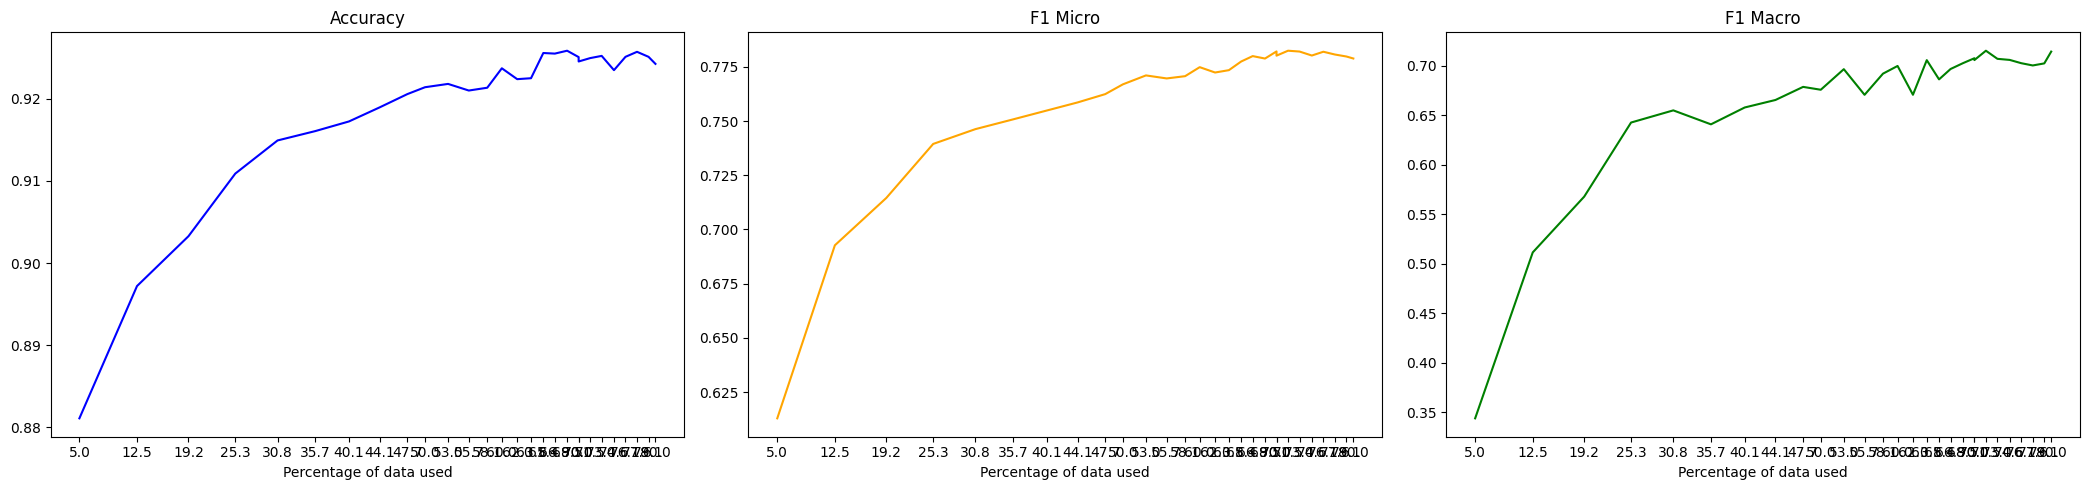

In [24]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: [81, 90, 11]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5334, Accuracy: 0.832, F1 Micro: 0.281, F1 Macro: 0.0625
Epoch 2/10, Train Loss: 0.4141, Accuracy: 0.8325, F1 Micro: 0.0725, F1 Macro: 0.0287
Epoch 3/10, Train Loss: 0.3891, Accuracy: 0.8395, F1 Micro: 0.166, F1 Macro: 0.0599
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3683, Accuracy: 0.8596, F1 Micro: 0.3961, F1 Macro: 0.1571
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3357, Accuracy: 0.874, F1 Micro: 0.5616, F1 Macro: 0.2616
Epoch 6/10, Train Loss: 0.2863, Accuracy: 0.8772, F1 Micro: 0.5346, F1 Macro: 0.2474
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2586, Accuracy: 0.8802, F1 Micro: 0.6089, F1 Macro: 0.3077
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2319, Accuracy: 0.8818, F1 Micro: 0.6161, F1 Macro: 0.3284
Epoch 9/10, Train Loss: 0.1943, Accuracy: 0.8809, F1 Micro: 0.591, F1 Macro: 0.3223
Epoch 10/10, Train Loss: 0.1843, Accuracy: 0.8815, F1 Micro: 0.5782, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5488, Accuracy: 0.8365, F1 Micro: 0.2242, F1 Macro: 0.0759
Epoch 2/10, Train Loss: 0.4157, Accuracy: 0.8332, F1 Micro: 0.0781, F1 Macro: 0.0299
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3877, Accuracy: 0.8443, F1 Micro: 0.2305, F1 Macro: 0.0771
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3652, Accuracy: 0.8601, F1 Micro: 0.3923, F1 Macro: 0.1362
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3337, Accuracy: 0.8761, F1 Micro: 0.5521, F1 Macro: 0.2466
Epoch 6/10, Train Loss: 0.2781, Accuracy: 0.8744, F1 Micro: 0.5094, F1 Macro: 0.2358
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2583, Accuracy: 0.8786, F1 Micro: 0.5916, F1 Macro: 0.3072
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2301, Accuracy: 0.8803, F1 Micro: 0.5931, F1 Macro: 0.3214
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1923, Accuracy: 0.8787, F1 Micro: 0.6097, F1 Macro: 0.3466
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5584, Accuracy: 0.8301, F1 Micro: 0.0762, F1 Macro: 0.0308
Epoch 2/10, Train Loss: 0.4164, Accuracy: 0.8297, F1 Micro: 0.0269, F1 Macro: 0.0117
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3921, Accuracy: 0.8388, F1 Micro: 0.1615, F1 Macro: 0.0557
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3787, Accuracy: 0.8458, F1 Micro: 0.2457, F1 Macro: 0.0818
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.354, Accuracy: 0.8607, F1 Micro: 0.3895, F1 Macro: 0.1422
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3012, Accuracy: 0.8716, F1 Micro: 0.4643, F1 Macro: 0.2092
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2725, Accuracy: 0.8785, F1 Micro: 0.5728, F1 Macro: 0.2936
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2457, Accuracy: 0.8807, F1 Micro: 0.5917, F1 Macro: 0.3243
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1994, Accuracy: 0.8811, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.459, Accuracy: 0.8388, F1 Micro: 0.1682, F1 Macro: 0.0611
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3607, Accuracy: 0.8646, F1 Micro: 0.4295, F1 Macro: 0.192
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3108, Accuracy: 0.884, F1 Micro: 0.6154, F1 Macro: 0.3002
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2589, Accuracy: 0.8896, F1 Micro: 0.625, F1 Macro: 0.3455
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.236, Accuracy: 0.8955, F1 Micro: 0.6645, F1 Macro: 0.4383
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1941, Accuracy: 0.8948, F1 Micro: 0.6881, F1 Macro: 0.4581
Epoch 7/10, Train Loss: 0.1638, Accuracy: 0.8956, F1 Micro: 0.6809, F1 Macro: 0.4596
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1432, Accuracy: 0.899, F1 Micro: 0.6883, F1 Macro: 0.5027
Epoch 9/10, Train Loss: 0.1172, Accuracy: 0.9, F1 Micro: 0.6817, F1 Macro: 0.4954
Higher F1 ach

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4609, Accuracy: 0.8455, F1 Micro: 0.2499, F1 Macro: 0.0857
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3596, Accuracy: 0.8713, F1 Micro: 0.4861, F1 Macro: 0.213
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3107, Accuracy: 0.8815, F1 Micro: 0.5891, F1 Macro: 0.2751
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2615, Accuracy: 0.8893, F1 Micro: 0.6278, F1 Macro: 0.3354
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2327, Accuracy: 0.8957, F1 Micro: 0.6644, F1 Macro: 0.469
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1935, Accuracy: 0.8941, F1 Micro: 0.6906, F1 Macro: 0.4793
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1674, Accuracy: 0.8956, F1 Micro: 0.6968, F1 Macro: 0.5075
Epoch 8/10, Train Loss: 0.1478, Accuracy: 0.896, F1 Micro: 0.6776, F1 Macro: 0.497
Epoch 9/10, Train Loss: 0.1228, Accuracy: 0.8992, F1 Micro: 0.6875, F1 Macro: 0.5117
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4684, Accuracy: 0.8345, F1 Micro: 0.0974, F1 Macro: 0.0359
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.372, Accuracy: 0.857, F1 Micro: 0.3705, F1 Macro: 0.131
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3241, Accuracy: 0.881, F1 Micro: 0.5741, F1 Macro: 0.2672
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2668, Accuracy: 0.8898, F1 Micro: 0.6312, F1 Macro: 0.3279
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2427, Accuracy: 0.8943, F1 Micro: 0.6438, F1 Macro: 0.442
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1976, Accuracy: 0.8948, F1 Micro: 0.6916, F1 Macro: 0.477
Epoch 7/10, Train Loss: 0.1684, Accuracy: 0.9007, F1 Micro: 0.6862, F1 Macro: 0.4786
Epoch 8/10, Train Loss: 0.1463, Accuracy: 0.8951, F1 Micro: 0.6874, F1 Macro: 0.5168
Epoch 9/10, Train Loss: 0.1196, Accuracy: 0.896, F1 Micro: 0.6855, F1 Macro: 0.5069
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4325, Accuracy: 0.858, F1 Micro: 0.4051, F1 Macro: 0.1497
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3259, Accuracy: 0.8799, F1 Micro: 0.5317, F1 Macro: 0.2599
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2699, Accuracy: 0.8932, F1 Micro: 0.682, F1 Macro: 0.4475
Epoch 4/10, Train Loss: 0.221, Accuracy: 0.9019, F1 Micro: 0.6801, F1 Macro: 0.4967
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1835, Accuracy: 0.9048, F1 Micro: 0.7068, F1 Macro: 0.483
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1515, Accuracy: 0.907, F1 Micro: 0.7162, F1 Macro: 0.5044
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1348, Accuracy: 0.9084, F1 Micro: 0.7191, F1 Macro: 0.5564
Epoch 8/10, Train Loss: 0.1034, Accuracy: 0.901, F1 Micro: 0.7157, F1 Macro: 0.5509
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0896, Accuracy: 0.908, F1 Micro: 0.7234, F1 Macro: 0.5614
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4364, Accuracy: 0.8564, F1 Micro: 0.4094, F1 Macro: 0.1237
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.324, Accuracy: 0.8796, F1 Micro: 0.5332, F1 Macro: 0.2549
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2706, Accuracy: 0.8915, F1 Micro: 0.6742, F1 Macro: 0.4363
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2252, Accuracy: 0.9005, F1 Micro: 0.6797, F1 Macro: 0.4918
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1883, Accuracy: 0.9024, F1 Micro: 0.7087, F1 Macro: 0.5099
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1541, Accuracy: 0.9015, F1 Micro: 0.7173, F1 Macro: 0.5324
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1336, Accuracy: 0.9069, F1 Micro: 0.7245, F1 Macro: 0.5558
Epoch 8/10, Train Loss: 0.1049, Accuracy: 0.9069, F1 Micro: 0.7192, F1 Macro: 0.5607
Epoch 9/10, Train Loss: 0.0918, Accuracy: 0.9078, F1 Micro: 0.7013, F1 Macro: 0.5526
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4433, Accuracy: 0.8502, F1 Micro: 0.3171, F1 Macro: 0.1027
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.337, Accuracy: 0.8806, F1 Micro: 0.5514, F1 Macro: 0.266
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2755, Accuracy: 0.8948, F1 Micro: 0.6828, F1 Macro: 0.4712
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.226, Accuracy: 0.9019, F1 Micro: 0.6911, F1 Macro: 0.5188
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1872, Accuracy: 0.9049, F1 Micro: 0.7082, F1 Macro: 0.4925
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1512, Accuracy: 0.9052, F1 Micro: 0.7219, F1 Macro: 0.5236
Epoch 7/10, Train Loss: 0.129, Accuracy: 0.9055, F1 Micro: 0.7031, F1 Macro: 0.5469
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0984, Accuracy: 0.9069, F1 Micro: 0.7253, F1 Macro: 0.5659
Epoch 9/10, Train Loss: 0.0833, Accuracy: 0.9098, F1 Micro: 0.7193, F1 Macro: 0.5646
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4183, Accuracy: 0.8701, F1 Micro: 0.5761, F1 Macro: 0.2622
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3013, Accuracy: 0.8923, F1 Micro: 0.662, F1 Macro: 0.4305
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2407, Accuracy: 0.9013, F1 Micro: 0.6696, F1 Macro: 0.4607
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2034, Accuracy: 0.9061, F1 Micro: 0.7238, F1 Macro: 0.5522
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1626, Accuracy: 0.9102, F1 Micro: 0.7246, F1 Macro: 0.5622
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1298, Accuracy: 0.9091, F1 Micro: 0.737, F1 Macro: 0.5767
Epoch 7/10, Train Loss: 0.1083, Accuracy: 0.9076, F1 Micro: 0.7284, F1 Macro: 0.5786
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0909, Accuracy: 0.9108, F1 Micro: 0.7373, F1 Macro: 0.5894
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0763, Accuracy: 0.9137, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4205, Accuracy: 0.8704, F1 Micro: 0.5304, F1 Macro: 0.2171
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3, Accuracy: 0.8908, F1 Micro: 0.6518, F1 Macro: 0.3965
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2396, Accuracy: 0.9019, F1 Micro: 0.6994, F1 Macro: 0.4818
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2058, Accuracy: 0.9046, F1 Micro: 0.7189, F1 Macro: 0.5347
Epoch 5/10, Train Loss: 0.1644, Accuracy: 0.9095, F1 Micro: 0.717, F1 Macro: 0.5489
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1319, Accuracy: 0.9084, F1 Micro: 0.724, F1 Macro: 0.5737
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.113, Accuracy: 0.9056, F1 Micro: 0.7346, F1 Macro: 0.5638
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0939, Accuracy: 0.9103, F1 Micro: 0.7397, F1 Macro: 0.594
Epoch 9/10, Train Loss: 0.0781, Accuracy: 0.9116, F1 Micro: 0.7362, F1 Macro: 0.6086
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4256, Accuracy: 0.8603, F1 Micro: 0.4321, F1 Macro: 0.1652
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3068, Accuracy: 0.8916, F1 Micro: 0.6542, F1 Macro: 0.4268
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2407, Accuracy: 0.9032, F1 Micro: 0.6907, F1 Macro: 0.4892
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2048, Accuracy: 0.9034, F1 Micro: 0.7249, F1 Macro: 0.5487
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.162, Accuracy: 0.9105, F1 Micro: 0.7341, F1 Macro: 0.5738
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1288, Accuracy: 0.9087, F1 Micro: 0.7374, F1 Macro: 0.5822
Epoch 7/10, Train Loss: 0.1062, Accuracy: 0.9093, F1 Micro: 0.7366, F1 Macro: 0.5929
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0874, Accuracy: 0.9114, F1 Micro: 0.7429, F1 Macro: 0.5972
Epoch 9/10, Train Loss: 0.0715, Accuracy: 0.9078, F1 Micro: 0.7374, F1 Macro: 0.6072
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.407, Accuracy: 0.8792, F1 Micro: 0.5783, F1 Macro: 0.2704
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2866, Accuracy: 0.8925, F1 Micro: 0.6393, F1 Macro: 0.3732
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2304, Accuracy: 0.906, F1 Micro: 0.7231, F1 Macro: 0.525
Epoch 4/10, Train Loss: 0.1854, Accuracy: 0.9092, F1 Micro: 0.7113, F1 Macro: 0.547
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1542, Accuracy: 0.9132, F1 Micro: 0.7362, F1 Macro: 0.5701
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1281, Accuracy: 0.9158, F1 Micro: 0.7435, F1 Macro: 0.5939
Epoch 7/10, Train Loss: 0.1019, Accuracy: 0.914, F1 Micro: 0.7409, F1 Macro: 0.5875
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0805, Accuracy: 0.9163, F1 Micro: 0.747, F1 Macro: 0.6121
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0701, Accuracy: 0.9117, F1 Micro: 0.7494, F1 Macro: 0.6179
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4072, Accuracy: 0.8747, F1 Micro: 0.6049, F1 Macro: 0.2805
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2866, Accuracy: 0.8943, F1 Micro: 0.6542, F1 Macro: 0.3899
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2298, Accuracy: 0.9067, F1 Micro: 0.7197, F1 Macro: 0.5277
Epoch 4/10, Train Loss: 0.1875, Accuracy: 0.9097, F1 Micro: 0.7152, F1 Macro: 0.5445
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1565, Accuracy: 0.9137, F1 Micro: 0.7401, F1 Macro: 0.5783
Epoch 6/10, Train Loss: 0.1277, Accuracy: 0.913, F1 Micro: 0.7384, F1 Macro: 0.5908
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.102, Accuracy: 0.9098, F1 Micro: 0.7455, F1 Macro: 0.5872
Epoch 8/10, Train Loss: 0.0824, Accuracy: 0.9171, F1 Micro: 0.744, F1 Macro: 0.6059
Epoch 9/10, Train Loss: 0.0687, Accuracy: 0.9157, F1 Micro: 0.7424, F1 Macro: 0.6036
Epoch 10/10, Train Loss: 0.06, Accuracy: 0.9137, F1 Micro: 0.7341, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4154, Accuracy: 0.8751, F1 Micro: 0.5227, F1 Macro: 0.2378
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2873, Accuracy: 0.8955, F1 Micro: 0.6493, F1 Macro: 0.3935
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2303, Accuracy: 0.907, F1 Micro: 0.719, F1 Macro: 0.5331
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1844, Accuracy: 0.9118, F1 Micro: 0.7258, F1 Macro: 0.549
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1524, Accuracy: 0.913, F1 Micro: 0.7387, F1 Macro: 0.5818
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1232, Accuracy: 0.9153, F1 Micro: 0.7423, F1 Macro: 0.6029
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0949, Accuracy: 0.9113, F1 Micro: 0.7454, F1 Macro: 0.597
Epoch 8/10, Train Loss: 0.0779, Accuracy: 0.9164, F1 Micro: 0.7448, F1 Macro: 0.6155
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0678, Accuracy: 0.9128, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3924, Accuracy: 0.8828, F1 Micro: 0.6065, F1 Macro: 0.2945
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2765, Accuracy: 0.9008, F1 Micro: 0.6874, F1 Macro: 0.4305
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.225, Accuracy: 0.9072, F1 Micro: 0.7115, F1 Macro: 0.5385
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1824, Accuracy: 0.9135, F1 Micro: 0.739, F1 Macro: 0.5596
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.147, Accuracy: 0.9142, F1 Micro: 0.7475, F1 Macro: 0.5906
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1167, Accuracy: 0.9171, F1 Micro: 0.7489, F1 Macro: 0.606
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0958, Accuracy: 0.914, F1 Micro: 0.7549, F1 Macro: 0.6172
Epoch 8/10, Train Loss: 0.0785, Accuracy: 0.9132, F1 Micro: 0.7491, F1 Macro: 0.6162
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0638, Accuracy: 0.9145, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3899, Accuracy: 0.8804, F1 Micro: 0.6014, F1 Macro: 0.2896
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2753, Accuracy: 0.8996, F1 Micro: 0.688, F1 Macro: 0.435
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.225, Accuracy: 0.9072, F1 Micro: 0.7122, F1 Macro: 0.5524
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1804, Accuracy: 0.9143, F1 Micro: 0.7393, F1 Macro: 0.5634
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1499, Accuracy: 0.9146, F1 Micro: 0.7408, F1 Macro: 0.589
Epoch 6/10, Train Loss: 0.1177, Accuracy: 0.9158, F1 Micro: 0.7393, F1 Macro: 0.5998
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0955, Accuracy: 0.915, F1 Micro: 0.7541, F1 Macro: 0.6211
Epoch 8/10, Train Loss: 0.0806, Accuracy: 0.9107, F1 Micro: 0.7443, F1 Macro: 0.6279
Epoch 9/10, Train Loss: 0.0658, Accuracy: 0.9141, F1 Micro: 0.753, F1 Macro: 0.6362
Epoch 10/10, Train Loss: 0.0553, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4008, Accuracy: 0.8795, F1 Micro: 0.5915, F1 Macro: 0.2754
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2807, Accuracy: 0.9007, F1 Micro: 0.6852, F1 Macro: 0.4355
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2259, Accuracy: 0.909, F1 Micro: 0.7168, F1 Macro: 0.5507
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1813, Accuracy: 0.9144, F1 Micro: 0.7396, F1 Macro: 0.5759
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1485, Accuracy: 0.9136, F1 Micro: 0.7472, F1 Macro: 0.6041
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1129, Accuracy: 0.9174, F1 Micro: 0.7508, F1 Macro: 0.6156
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0946, Accuracy: 0.9183, F1 Micro: 0.7557, F1 Macro: 0.6181
Epoch 8/10, Train Loss: 0.0744, Accuracy: 0.9151, F1 Micro: 0.7518, F1 Macro: 0.6378
Epoch 9/10, Train Loss: 0.0631, Accuracy: 0.9143, F1 Micro: 0.7539, F1 Macro: 0.6465
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3836, Accuracy: 0.8869, F1 Micro: 0.6235, F1 Macro: 0.31
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2658, Accuracy: 0.905, F1 Micro: 0.6952, F1 Macro: 0.4883
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2139, Accuracy: 0.913, F1 Micro: 0.7345, F1 Macro: 0.5594
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1753, Accuracy: 0.9161, F1 Micro: 0.7463, F1 Macro: 0.5938
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1404, Accuracy: 0.9109, F1 Micro: 0.7497, F1 Macro: 0.5984
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1155, Accuracy: 0.9179, F1 Micro: 0.7545, F1 Macro: 0.609
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.091, Accuracy: 0.9183, F1 Micro: 0.7553, F1 Macro: 0.6229
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0742, Accuracy: 0.92, F1 Micro: 0.7574, F1 Macro: 0.6255
Epoch 9/10, Train Loss: 0.0658, Accuracy: 0.9185, F1 Micro: 0.75

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3836, Accuracy: 0.8832, F1 Micro: 0.6124, F1 Macro: 0.2981
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2667, Accuracy: 0.9057, F1 Micro: 0.6968, F1 Macro: 0.499
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2169, Accuracy: 0.9114, F1 Micro: 0.7314, F1 Macro: 0.552
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1801, Accuracy: 0.9155, F1 Micro: 0.7434, F1 Macro: 0.5933
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1446, Accuracy: 0.9132, F1 Micro: 0.7528, F1 Macro: 0.609
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1159, Accuracy: 0.9162, F1 Micro: 0.7546, F1 Macro: 0.6142
Epoch 7/10, Train Loss: 0.099, Accuracy: 0.915, F1 Micro: 0.7433, F1 Macro: 0.6346
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0737, Accuracy: 0.9172, F1 Micro: 0.7585, F1 Macro: 0.6394
Epoch 9/10, Train Loss: 0.0678, Accuracy: 0.9156, F1 Micro: 0.7538, F1 Macro: 0.6421
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3924, Accuracy: 0.8819, F1 Micro: 0.6094, F1 Macro: 0.3092
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2687, Accuracy: 0.9053, F1 Micro: 0.6926, F1 Macro: 0.4753
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2158, Accuracy: 0.9116, F1 Micro: 0.7284, F1 Macro: 0.5519
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1771, Accuracy: 0.9169, F1 Micro: 0.7458, F1 Macro: 0.5955
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1408, Accuracy: 0.9164, F1 Micro: 0.7578, F1 Macro: 0.6136
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1149, Accuracy: 0.9173, F1 Micro: 0.7584, F1 Macro: 0.6225
Epoch 7/10, Train Loss: 0.0935, Accuracy: 0.9174, F1 Micro: 0.7573, F1 Macro: 0.6295
Epoch 8/10, Train Loss: 0.0734, Accuracy: 0.9182, F1 Micro: 0.7487, F1 Macro: 0.6299
Epoch 9/10, Train Loss: 0.0632, Accuracy: 0.9183, F1 Micro: 0.7551, F1 Macro: 0.6507
Higher F1 achieved, saving model
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3726, Accuracy: 0.8885, F1 Micro: 0.6285, F1 Macro: 0.3273
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2592, Accuracy: 0.9018, F1 Micro: 0.7131, F1 Macro: 0.4926
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.209, Accuracy: 0.912, F1 Micro: 0.7299, F1 Macro: 0.5411
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.168, Accuracy: 0.9156, F1 Micro: 0.7366, F1 Macro: 0.568
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1388, Accuracy: 0.9208, F1 Micro: 0.764, F1 Macro: 0.6238
Epoch 6/10, Train Loss: 0.1044, Accuracy: 0.9173, F1 Micro: 0.7554, F1 Macro: 0.6219
Epoch 7/10, Train Loss: 0.0876, Accuracy: 0.9178, F1 Micro: 0.7586, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0708, Accuracy: 0.9204, F1 Micro: 0.7647, F1 Macro: 0.6462
Epoch 9/10, Train Loss: 0.0596, Accuracy: 0.9178, F1 Micro: 0.7588, F1 Macro: 0.6559
Epoch 10/10, Train Loss: 0.0487, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3722, Accuracy: 0.8867, F1 Micro: 0.6425, F1 Macro: 0.3361
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2606, Accuracy: 0.8965, F1 Micro: 0.7066, F1 Macro: 0.4991
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.211, Accuracy: 0.9099, F1 Micro: 0.7232, F1 Macro: 0.5295
Epoch 4/10, Train Loss: 0.1718, Accuracy: 0.914, F1 Micro: 0.7232, F1 Macro: 0.5657
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1378, Accuracy: 0.9183, F1 Micro: 0.7566, F1 Macro: 0.6009
Epoch 6/10, Train Loss: 0.1057, Accuracy: 0.916, F1 Micro: 0.7562, F1 Macro: 0.6285
Epoch 7/10, Train Loss: 0.0893, Accuracy: 0.9192, F1 Micro: 0.755, F1 Macro: 0.6556
Epoch 8/10, Train Loss: 0.0717, Accuracy: 0.9191, F1 Micro: 0.7552, F1 Macro: 0.6401
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.061, Accuracy: 0.9164, F1 Micro: 0.7582, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0541, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3808, Accuracy: 0.8867, F1 Micro: 0.6217, F1 Macro: 0.3523
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.262, Accuracy: 0.9033, F1 Micro: 0.7146, F1 Macro: 0.5053
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2098, Accuracy: 0.9121, F1 Micro: 0.7315, F1 Macro: 0.5461
Epoch 4/10, Train Loss: 0.1676, Accuracy: 0.9147, F1 Micro: 0.727, F1 Macro: 0.5716
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1384, Accuracy: 0.9199, F1 Micro: 0.7469, F1 Macro: 0.6052
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1038, Accuracy: 0.9137, F1 Micro: 0.7571, F1 Macro: 0.6238
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0858, Accuracy: 0.9188, F1 Micro: 0.7642, F1 Macro: 0.6573
Epoch 8/10, Train Loss: 0.0682, Accuracy: 0.9151, F1 Micro: 0.7595, F1 Macro: 0.6487
Epoch 9/10, Train Loss: 0.0554, Accuracy: 0.9181, F1 Micro: 0.7626, F1 Macro: 0.6745
Epoch 10/10, Train Loss: 0.0472, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3648, Accuracy: 0.8841, F1 Micro: 0.5597, F1 Macro: 0.3029
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2531, Accuracy: 0.908, F1 Micro: 0.7143, F1 Macro: 0.5221
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2049, Accuracy: 0.9153, F1 Micro: 0.7497, F1 Macro: 0.5948
Epoch 4/10, Train Loss: 0.1647, Accuracy: 0.9165, F1 Micro: 0.748, F1 Macro: 0.5847
Epoch 5/10, Train Loss: 0.1296, Accuracy: 0.919, F1 Micro: 0.7429, F1 Macro: 0.6049
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1037, Accuracy: 0.9195, F1 Micro: 0.7634, F1 Macro: 0.6435
Epoch 7/10, Train Loss: 0.0811, Accuracy: 0.9192, F1 Micro: 0.7518, F1 Macro: 0.6402
Epoch 8/10, Train Loss: 0.0712, Accuracy: 0.9168, F1 Micro: 0.7552, F1 Macro: 0.6631
Epoch 9/10, Train Loss: 0.0578, Accuracy: 0.9176, F1 Micro: 0.7605, F1 Macro: 0.6494
Epoch 10/10, Train Loss: 0.0523, Accuracy: 0.9119, F1 Micro: 0.7495, F1 Macro: 0.6509
Model 1 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3637, Accuracy: 0.8826, F1 Micro: 0.5442, F1 Macro: 0.2932
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2561, Accuracy: 0.9079, F1 Micro: 0.7194, F1 Macro: 0.5421
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2074, Accuracy: 0.9137, F1 Micro: 0.7428, F1 Macro: 0.5821
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1669, Accuracy: 0.9172, F1 Micro: 0.7538, F1 Macro: 0.5942
Epoch 5/10, Train Loss: 0.1357, Accuracy: 0.9194, F1 Micro: 0.7482, F1 Macro: 0.6077
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1064, Accuracy: 0.9163, F1 Micro: 0.7578, F1 Macro: 0.6389
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0874, Accuracy: 0.9172, F1 Micro: 0.7595, F1 Macro: 0.656
Epoch 8/10, Train Loss: 0.076, Accuracy: 0.909, F1 Micro: 0.7532, F1 Macro: 0.6588
Epoch 9/10, Train Loss: 0.0619, Accuracy: 0.9182, F1 Micro: 0.7581, F1 Macro: 0.6535
Epoch 10/10, Train Loss: 0.0543, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.374, Accuracy: 0.8842, F1 Micro: 0.5696, F1 Macro: 0.3451
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2575, Accuracy: 0.9085, F1 Micro: 0.7165, F1 Macro: 0.5314
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.204, Accuracy: 0.9094, F1 Micro: 0.7476, F1 Macro: 0.5922
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1635, Accuracy: 0.9176, F1 Micro: 0.7588, F1 Macro: 0.6085
Epoch 5/10, Train Loss: 0.1317, Accuracy: 0.9199, F1 Micro: 0.7498, F1 Macro: 0.6231
Epoch 6/10, Train Loss: 0.1017, Accuracy: 0.9208, F1 Micro: 0.7577, F1 Macro: 0.6518
Epoch 7/10, Train Loss: 0.0848, Accuracy: 0.9204, F1 Micro: 0.7582, F1 Macro: 0.6599
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0704, Accuracy: 0.9192, F1 Micro: 0.7622, F1 Macro: 0.6644
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0568, Accuracy: 0.9185, F1 Micro: 0.7624, F1 Macro: 0.6596
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3696, Accuracy: 0.8907, F1 Micro: 0.6625, F1 Macro: 0.3607
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2507, Accuracy: 0.9054, F1 Micro: 0.7127, F1 Macro: 0.4998
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2023, Accuracy: 0.916, F1 Micro: 0.7399, F1 Macro: 0.5554
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1612, Accuracy: 0.919, F1 Micro: 0.7524, F1 Macro: 0.6123
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1301, Accuracy: 0.9191, F1 Micro: 0.755, F1 Macro: 0.6191
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1031, Accuracy: 0.9166, F1 Micro: 0.7576, F1 Macro: 0.6479
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0821, Accuracy: 0.9188, F1 Micro: 0.7579, F1 Macro: 0.6396
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0662, Accuracy: 0.9173, F1 Micro: 0.7642, F1 Macro: 0.6663
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3693, Accuracy: 0.8894, F1 Micro: 0.6664, F1 Macro: 0.3742
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2514, Accuracy: 0.906, F1 Micro: 0.7208, F1 Macro: 0.5331
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2055, Accuracy: 0.913, F1 Micro: 0.7417, F1 Macro: 0.5611
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1621, Accuracy: 0.9177, F1 Micro: 0.751, F1 Macro: 0.6066
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1315, Accuracy: 0.9117, F1 Micro: 0.7542, F1 Macro: 0.6373
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1058, Accuracy: 0.9174, F1 Micro: 0.759, F1 Macro: 0.6599
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0861, Accuracy: 0.9168, F1 Micro: 0.759, F1 Macro: 0.6418
Epoch 8/10, Train Loss: 0.0693, Accuracy: 0.9195, F1 Micro: 0.7541, F1 Macro: 0.6564
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0622, Accuracy: 0.917, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3803, Accuracy: 0.8877, F1 Micro: 0.6599, F1 Macro: 0.3764
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2525, Accuracy: 0.9078, F1 Micro: 0.7223, F1 Macro: 0.53
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.202, Accuracy: 0.9164, F1 Micro: 0.7488, F1 Macro: 0.5766
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1597, Accuracy: 0.9194, F1 Micro: 0.7514, F1 Macro: 0.609
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1272, Accuracy: 0.9176, F1 Micro: 0.763, F1 Macro: 0.647
Epoch 6/10, Train Loss: 0.102, Accuracy: 0.9171, F1 Micro: 0.7554, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0838, Accuracy: 0.9195, F1 Micro: 0.7672, F1 Macro: 0.6752
Epoch 8/10, Train Loss: 0.0668, Accuracy: 0.9233, F1 Micro: 0.766, F1 Macro: 0.6727
Epoch 9/10, Train Loss: 0.0578, Accuracy: 0.921, F1 Micro: 0.7595, F1 Macro: 0.6748
Epoch 10/10, Train Loss: 0.048, Accuracy: 0.91

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3584, Accuracy: 0.8949, F1 Micro: 0.6642, F1 Macro: 0.3877
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2503, Accuracy: 0.9052, F1 Micro: 0.7186, F1 Macro: 0.5107
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2033, Accuracy: 0.9179, F1 Micro: 0.7467, F1 Macro: 0.5968
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1586, Accuracy: 0.9161, F1 Micro: 0.7574, F1 Macro: 0.6083
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.127, Accuracy: 0.9197, F1 Micro: 0.761, F1 Macro: 0.6187
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1021, Accuracy: 0.92, F1 Micro: 0.7685, F1 Macro: 0.6656
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0835, Accuracy: 0.9201, F1 Micro: 0.7709, F1 Macro: 0.6811
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0656, Accuracy: 0.9209, F1 Micro: 0.7743, F1 Macro: 0.6947
Epoch 9/10, Train Loss: 0.0557, Accuracy: 0.9173, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.359, Accuracy: 0.8941, F1 Micro: 0.6506, F1 Macro: 0.3572
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.25, Accuracy: 0.9046, F1 Micro: 0.7144, F1 Macro: 0.4938
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2059, Accuracy: 0.9178, F1 Micro: 0.7472, F1 Macro: 0.5905
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1605, Accuracy: 0.9192, F1 Micro: 0.7627, F1 Macro: 0.6245
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1285, Accuracy: 0.9188, F1 Micro: 0.7639, F1 Macro: 0.6442
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1044, Accuracy: 0.9208, F1 Micro: 0.7642, F1 Macro: 0.6507
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0839, Accuracy: 0.9212, F1 Micro: 0.7669, F1 Macro: 0.6763
Epoch 8/10, Train Loss: 0.0681, Accuracy: 0.9206, F1 Micro: 0.7661, F1 Macro: 0.6823
Epoch 9/10, Train Loss: 0.0556, Accuracy: 0.9206, F1 Micro: 0.7662, F1 Macro: 0.6723
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3669, Accuracy: 0.8943, F1 Micro: 0.6465, F1 Macro: 0.3887
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.251, Accuracy: 0.9061, F1 Micro: 0.7188, F1 Macro: 0.499
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2022, Accuracy: 0.9187, F1 Micro: 0.7521, F1 Macro: 0.6042
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1563, Accuracy: 0.9173, F1 Micro: 0.7588, F1 Macro: 0.6184
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1267, Accuracy: 0.9159, F1 Micro: 0.7613, F1 Macro: 0.626
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1006, Accuracy: 0.9168, F1 Micro: 0.7634, F1 Macro: 0.664
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0785, Accuracy: 0.9196, F1 Micro: 0.7673, F1 Macro: 0.6769
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0651, Accuracy: 0.9199, F1 Micro: 0.7702, F1 Macro: 0.6896
Epoch 9/10, Train Loss: 0.0526, Accuracy: 0.9142, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.361, Accuracy: 0.893, F1 Micro: 0.6611, F1 Macro: 0.3894
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2472, Accuracy: 0.9105, F1 Micro: 0.7174, F1 Macro: 0.5389
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1968, Accuracy: 0.9161, F1 Micro: 0.7541, F1 Macro: 0.5833
Epoch 4/10, Train Loss: 0.1577, Accuracy: 0.9195, F1 Micro: 0.7429, F1 Macro: 0.6097
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1238, Accuracy: 0.9155, F1 Micro: 0.7607, F1 Macro: 0.6356
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.102, Accuracy: 0.9231, F1 Micro: 0.7754, F1 Macro: 0.6815
Epoch 7/10, Train Loss: 0.0796, Accuracy: 0.918, F1 Micro: 0.7652, F1 Macro: 0.6447
Epoch 8/10, Train Loss: 0.0698, Accuracy: 0.9147, F1 Micro: 0.7663, F1 Macro: 0.6806
Epoch 9/10, Train Loss: 0.057, Accuracy: 0.9215, F1 Micro: 0.7614, F1 Macro: 0.685
Epoch 10/10, Train Loss: 0.0472, Accuracy: 0.9177, F1 Micro: 0.7587, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3609, Accuracy: 0.8923, F1 Micro: 0.6496, F1 Macro: 0.3715
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2472, Accuracy: 0.9103, F1 Micro: 0.709, F1 Macro: 0.5352
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1986, Accuracy: 0.9168, F1 Micro: 0.7571, F1 Macro: 0.6012
Epoch 4/10, Train Loss: 0.1574, Accuracy: 0.9183, F1 Micro: 0.7356, F1 Macro: 0.6107
Epoch 5/10, Train Loss: 0.1245, Accuracy: 0.9143, F1 Micro: 0.7555, F1 Macro: 0.6172
Epoch 6/10, Train Loss: 0.1015, Accuracy: 0.921, F1 Micro: 0.7535, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0823, Accuracy: 0.9176, F1 Micro: 0.7639, F1 Macro: 0.6477
Epoch 8/10, Train Loss: 0.068, Accuracy: 0.9172, F1 Micro: 0.7629, F1 Macro: 0.6801
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.055, Accuracy: 0.9195, F1 Micro: 0.7645, F1 Macro: 0.6874
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0473, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3652, Accuracy: 0.8898, F1 Micro: 0.6729, F1 Macro: 0.4436
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2461, Accuracy: 0.9102, F1 Micro: 0.716, F1 Macro: 0.5474
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1963, Accuracy: 0.9156, F1 Micro: 0.7577, F1 Macro: 0.6046
Epoch 4/10, Train Loss: 0.1562, Accuracy: 0.9181, F1 Micro: 0.7328, F1 Macro: 0.6169
Epoch 5/10, Train Loss: 0.1215, Accuracy: 0.9191, F1 Micro: 0.7568, F1 Macro: 0.6302
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0969, Accuracy: 0.9195, F1 Micro: 0.7669, F1 Macro: 0.6784
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0786, Accuracy: 0.9252, F1 Micro: 0.772, F1 Macro: 0.6742
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0655, Accuracy: 0.9216, F1 Micro: 0.7725, F1 Macro: 0.694
Epoch 9/10, Train Loss: 0.0546, Accuracy: 0.9222, F1 Micro: 0.7649, F1 Macro: 0.6887
Epoch 10/10, Train Loss: 0.0465, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3567, Accuracy: 0.8931, F1 Micro: 0.6641, F1 Macro: 0.4274
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2429, Accuracy: 0.9089, F1 Micro: 0.7264, F1 Macro: 0.5597
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1952, Accuracy: 0.9171, F1 Micro: 0.7391, F1 Macro: 0.5827
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1536, Accuracy: 0.9167, F1 Micro: 0.7634, F1 Macro: 0.641
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1215, Accuracy: 0.9219, F1 Micro: 0.7682, F1 Macro: 0.6326
Epoch 6/10, Train Loss: 0.0991, Accuracy: 0.9177, F1 Micro: 0.7656, F1 Macro: 0.6382
Epoch 7/10, Train Loss: 0.0786, Accuracy: 0.9171, F1 Micro: 0.7664, F1 Macro: 0.6611
Epoch 8/10, Train Loss: 0.0644, Accuracy: 0.9166, F1 Micro: 0.7649, F1 Macro: 0.6703
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0519, Accuracy: 0.9219, F1 Micro: 0.7689, F1 Macro: 0.6852
Epoch 10/10, Train Loss: 0.0435, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3559, Accuracy: 0.8923, F1 Micro: 0.669, F1 Macro: 0.4209
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2422, Accuracy: 0.9079, F1 Micro: 0.7265, F1 Macro: 0.5559
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.195, Accuracy: 0.9183, F1 Micro: 0.7403, F1 Macro: 0.5912
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.154, Accuracy: 0.9199, F1 Micro: 0.7679, F1 Macro: 0.6537
Epoch 5/10, Train Loss: 0.1212, Accuracy: 0.9203, F1 Micro: 0.7587, F1 Macro: 0.6348
Epoch 6/10, Train Loss: 0.0993, Accuracy: 0.9174, F1 Micro: 0.7632, F1 Macro: 0.6302
Epoch 7/10, Train Loss: 0.08, Accuracy: 0.9175, F1 Micro: 0.7646, F1 Macro: 0.6561
Epoch 8/10, Train Loss: 0.0646, Accuracy: 0.9216, F1 Micro: 0.7667, F1 Macro: 0.6751
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0536, Accuracy: 0.9225, F1 Micro: 0.7681, F1 Macro: 0.6841
Epoch 10/10, Train Loss: 0.0441, Accuracy: 0.9211, F1 Micro: 0.7669, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3609, Accuracy: 0.8938, F1 Micro: 0.6728, F1 Macro: 0.4399
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2405, Accuracy: 0.9102, F1 Micro: 0.7241, F1 Macro: 0.5611
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1932, Accuracy: 0.9185, F1 Micro: 0.7413, F1 Macro: 0.5918
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1512, Accuracy: 0.9206, F1 Micro: 0.768, F1 Macro: 0.6549
Epoch 5/10, Train Loss: 0.1177, Accuracy: 0.9196, F1 Micro: 0.7625, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0986, Accuracy: 0.921, F1 Micro: 0.7706, F1 Macro: 0.6531
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0796, Accuracy: 0.9182, F1 Micro: 0.7708, F1 Macro: 0.6719
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0655, Accuracy: 0.9221, F1 Micro: 0.774, F1 Macro: 0.6918
Epoch 9/10, Train Loss: 0.0522, Accuracy: 0.9196, F1 Micro: 0.7701, F1 Macro: 0.6879
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3522, Accuracy: 0.8919, F1 Micro: 0.6069, F1 Macro: 0.365
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2342, Accuracy: 0.912, F1 Micro: 0.729, F1 Macro: 0.5301
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1894, Accuracy: 0.9191, F1 Micro: 0.7457, F1 Macro: 0.5993
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1495, Accuracy: 0.9194, F1 Micro: 0.7661, F1 Macro: 0.6288
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.117, Accuracy: 0.9203, F1 Micro: 0.7685, F1 Macro: 0.662
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0974, Accuracy: 0.9225, F1 Micro: 0.7731, F1 Macro: 0.6733
Epoch 7/10, Train Loss: 0.0752, Accuracy: 0.9237, F1 Micro: 0.7693, F1 Macro: 0.671
Epoch 8/10, Train Loss: 0.063, Accuracy: 0.9222, F1 Micro: 0.7656, F1 Macro: 0.6567
Epoch 9/10, Train Loss: 0.0545, Accuracy: 0.9198, F1 Micro: 0.7711, F1 Macro: 0.6845
Epoch 10/10, Train Loss: 0.0446, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.352, Accuracy: 0.8966, F1 Micro: 0.6553, F1 Macro: 0.4188
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2353, Accuracy: 0.9122, F1 Micro: 0.7235, F1 Macro: 0.5406
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1911, Accuracy: 0.92, F1 Micro: 0.7512, F1 Macro: 0.606
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1532, Accuracy: 0.9209, F1 Micro: 0.7664, F1 Macro: 0.6505
Epoch 5/10, Train Loss: 0.1181, Accuracy: 0.9182, F1 Micro: 0.7658, F1 Macro: 0.6637
Epoch 6/10, Train Loss: 0.0986, Accuracy: 0.9221, F1 Micro: 0.7632, F1 Macro: 0.6685
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0773, Accuracy: 0.9204, F1 Micro: 0.7701, F1 Macro: 0.6614
Epoch 8/10, Train Loss: 0.0678, Accuracy: 0.9183, F1 Micro: 0.7603, F1 Macro: 0.6694
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0562, Accuracy: 0.9242, F1 Micro: 0.772, F1 Macro: 0.6819
Epoch 10/10, Train Loss: 0.0474, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3593, Accuracy: 0.8927, F1 Micro: 0.6171, F1 Macro: 0.3723
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2368, Accuracy: 0.9133, F1 Micro: 0.7312, F1 Macro: 0.5363
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1877, Accuracy: 0.9202, F1 Micro: 0.7566, F1 Macro: 0.619
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1505, Accuracy: 0.919, F1 Micro: 0.766, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1178, Accuracy: 0.9187, F1 Micro: 0.7709, F1 Macro: 0.675
Epoch 6/10, Train Loss: 0.0931, Accuracy: 0.9162, F1 Micro: 0.7643, F1 Macro: 0.6659
Epoch 7/10, Train Loss: 0.0751, Accuracy: 0.9214, F1 Micro: 0.7651, F1 Macro: 0.6753
Epoch 8/10, Train Loss: 0.062, Accuracy: 0.9216, F1 Micro: 0.7689, F1 Macro: 0.6858
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0545, Accuracy: 0.9219, F1 Micro: 0.7725, F1 Macro: 0.6872
Epoch 10/10, Train Loss: 0.0446, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3503, Accuracy: 0.8969, F1 Micro: 0.653, F1 Macro: 0.411
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2396, Accuracy: 0.9131, F1 Micro: 0.7273, F1 Macro: 0.566
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1921, Accuracy: 0.9156, F1 Micro: 0.7581, F1 Macro: 0.5904
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1524, Accuracy: 0.9222, F1 Micro: 0.7718, F1 Macro: 0.635
Epoch 5/10, Train Loss: 0.1232, Accuracy: 0.9172, F1 Micro: 0.7679, F1 Macro: 0.6474
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1006, Accuracy: 0.9244, F1 Micro: 0.7729, F1 Macro: 0.6732
Epoch 7/10, Train Loss: 0.0769, Accuracy: 0.9215, F1 Micro: 0.7629, F1 Macro: 0.6614
Epoch 8/10, Train Loss: 0.062, Accuracy: 0.9231, F1 Micro: 0.7683, F1 Macro: 0.6816
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0573, Accuracy: 0.9241, F1 Micro: 0.7749, F1 Macro: 0.7013
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3521, Accuracy: 0.8955, F1 Micro: 0.6441, F1 Macro: 0.4055
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2392, Accuracy: 0.9125, F1 Micro: 0.7269, F1 Macro: 0.5725
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1931, Accuracy: 0.9169, F1 Micro: 0.7608, F1 Macro: 0.6163
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1533, Accuracy: 0.9246, F1 Micro: 0.7689, F1 Macro: 0.6345
Epoch 5/10, Train Loss: 0.1228, Accuracy: 0.9157, F1 Micro: 0.7683, F1 Macro: 0.655
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.103, Accuracy: 0.9217, F1 Micro: 0.7751, F1 Macro: 0.6708
Epoch 7/10, Train Loss: 0.0776, Accuracy: 0.9218, F1 Micro: 0.7635, F1 Macro: 0.6617
Epoch 8/10, Train Loss: 0.0614, Accuracy: 0.9202, F1 Micro: 0.7727, F1 Macro: 0.6819
Epoch 9/10, Train Loss: 0.0564, Accuracy: 0.922, F1 Micro: 0.7735, F1 Macro: 0.6997
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.048, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3572, Accuracy: 0.8973, F1 Micro: 0.6485, F1 Macro: 0.4314
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2402, Accuracy: 0.9133, F1 Micro: 0.7396, F1 Macro: 0.593
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1919, Accuracy: 0.92, F1 Micro: 0.7603, F1 Macro: 0.6163
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1483, Accuracy: 0.9252, F1 Micro: 0.777, F1 Macro: 0.6514
Epoch 5/10, Train Loss: 0.1206, Accuracy: 0.9177, F1 Micro: 0.7704, F1 Macro: 0.662
Epoch 6/10, Train Loss: 0.0985, Accuracy: 0.9214, F1 Micro: 0.7723, F1 Macro: 0.676
Epoch 7/10, Train Loss: 0.0747, Accuracy: 0.9222, F1 Micro: 0.7675, F1 Macro: 0.6809
Epoch 8/10, Train Loss: 0.0598, Accuracy: 0.9198, F1 Micro: 0.7729, F1 Macro: 0.6845
Epoch 9/10, Train Loss: 0.0551, Accuracy: 0.9254, F1 Micro: 0.7683, F1 Macro: 0.6941
Epoch 10/10, Train Loss: 0.046, Accuracy: 0.923, F1 Micro: 0.775, F1 Macro: 0.699
Model 3 - Iteration 8165: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3448, Accuracy: 0.8977, F1 Micro: 0.6521, F1 Macro: 0.4029
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2345, Accuracy: 0.9122, F1 Micro: 0.7304, F1 Macro: 0.5545
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1927, Accuracy: 0.9212, F1 Micro: 0.7586, F1 Macro: 0.6071
Epoch 4/10, Train Loss: 0.1462, Accuracy: 0.9212, F1 Micro: 0.755, F1 Macro: 0.6359
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1189, Accuracy: 0.9224, F1 Micro: 0.7675, F1 Macro: 0.6568
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0941, Accuracy: 0.9236, F1 Micro: 0.7763, F1 Macro: 0.6793
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0772, Accuracy: 0.924, F1 Micro: 0.7794, F1 Macro: 0.6924
Epoch 8/10, Train Loss: 0.063, Accuracy: 0.9255, F1 Micro: 0.7758, F1 Macro: 0.6943
Epoch 9/10, Train Loss: 0.0502, Accuracy: 0.9208, F1 Micro: 0.7703, F1 Macro: 0.692
Epoch 10/10, Train Loss: 0.046, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3439, Accuracy: 0.8969, F1 Micro: 0.6568, F1 Macro: 0.3944
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2344, Accuracy: 0.913, F1 Micro: 0.7349, F1 Macro: 0.5611
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1919, Accuracy: 0.9208, F1 Micro: 0.7598, F1 Macro: 0.6125
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1488, Accuracy: 0.9233, F1 Micro: 0.7602, F1 Macro: 0.6405
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1201, Accuracy: 0.9213, F1 Micro: 0.7707, F1 Macro: 0.66
Epoch 6/10, Train Loss: 0.0948, Accuracy: 0.9185, F1 Micro: 0.7683, F1 Macro: 0.6582
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0768, Accuracy: 0.9207, F1 Micro: 0.771, F1 Macro: 0.693
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0633, Accuracy: 0.9215, F1 Micro: 0.7745, F1 Macro: 0.6891
Epoch 9/10, Train Loss: 0.0508, Accuracy: 0.9213, F1 Micro: 0.7711, F1 Macro: 0.685
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3504, Accuracy: 0.8973, F1 Micro: 0.652, F1 Macro: 0.4096
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2333, Accuracy: 0.9136, F1 Micro: 0.7349, F1 Macro: 0.5602
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1908, Accuracy: 0.92, F1 Micro: 0.756, F1 Macro: 0.6107
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1449, Accuracy: 0.9218, F1 Micro: 0.7602, F1 Macro: 0.6594
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1155, Accuracy: 0.9223, F1 Micro: 0.7711, F1 Macro: 0.6725
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.092, Accuracy: 0.9224, F1 Micro: 0.7764, F1 Macro: 0.685
Epoch 7/10, Train Loss: 0.0745, Accuracy: 0.922, F1 Micro: 0.7758, F1 Macro: 0.7001
Epoch 8/10, Train Loss: 0.0601, Accuracy: 0.9183, F1 Micro: 0.7706, F1 Macro: 0.6941
Epoch 9/10, Train Loss: 0.0493, Accuracy: 0.9235, F1 Micro: 0.776, F1 Macro: 0.6945
Epoch 10/10, Train Loss: 0.0436, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3456, Accuracy: 0.896, F1 Micro: 0.6285, F1 Macro: 0.3833
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.233, Accuracy: 0.9145, F1 Micro: 0.7389, F1 Macro: 0.5603
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1863, Accuracy: 0.9201, F1 Micro: 0.7485, F1 Macro: 0.6057
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1523, Accuracy: 0.9218, F1 Micro: 0.7747, F1 Macro: 0.6633
Epoch 5/10, Train Loss: 0.1258, Accuracy: 0.9248, F1 Micro: 0.7723, F1 Macro: 0.6719
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0906, Accuracy: 0.9254, F1 Micro: 0.7751, F1 Macro: 0.6744
Epoch 7/10, Train Loss: 0.0762, Accuracy: 0.9255, F1 Micro: 0.7739, F1 Macro: 0.6866
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.065, Accuracy: 0.9185, F1 Micro: 0.7759, F1 Macro: 0.6962
Epoch 9/10, Train Loss: 0.0534, Accuracy: 0.9204, F1 Micro: 0.7757, F1 Macro: 0.7014
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3461, Accuracy: 0.8954, F1 Micro: 0.6218, F1 Macro: 0.383
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2358, Accuracy: 0.9134, F1 Micro: 0.7386, F1 Macro: 0.5688
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1876, Accuracy: 0.9195, F1 Micro: 0.7492, F1 Macro: 0.6028
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1549, Accuracy: 0.918, F1 Micro: 0.7662, F1 Macro: 0.6566
Epoch 5/10, Train Loss: 0.1255, Accuracy: 0.9222, F1 Micro: 0.7661, F1 Macro: 0.6728
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0937, Accuracy: 0.9245, F1 Micro: 0.7749, F1 Macro: 0.6772
Epoch 7/10, Train Loss: 0.0782, Accuracy: 0.9224, F1 Micro: 0.7726, F1 Macro: 0.7027
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0659, Accuracy: 0.9243, F1 Micro: 0.7809, F1 Macro: 0.6877
Epoch 9/10, Train Loss: 0.0537, Accuracy: 0.9192, F1 Micro: 0.7728, F1 Macro: 0.6979
Epoch 10/10, Train Loss: 0.0448, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3516, Accuracy: 0.8961, F1 Micro: 0.6354, F1 Macro: 0.4128
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.234, Accuracy: 0.9154, F1 Micro: 0.7452, F1 Macro: 0.5793
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1856, Accuracy: 0.9227, F1 Micro: 0.7626, F1 Macro: 0.646
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1468, Accuracy: 0.9254, F1 Micro: 0.78, F1 Macro: 0.6816
Epoch 5/10, Train Loss: 0.1233, Accuracy: 0.9239, F1 Micro: 0.7771, F1 Macro: 0.6809
Epoch 6/10, Train Loss: 0.0877, Accuracy: 0.9252, F1 Micro: 0.7775, F1 Macro: 0.6922
Epoch 7/10, Train Loss: 0.0749, Accuracy: 0.9233, F1 Micro: 0.7771, F1 Macro: 0.7015
Epoch 8/10, Train Loss: 0.0629, Accuracy: 0.9229, F1 Micro: 0.7765, F1 Macro: 0.6926
Epoch 9/10, Train Loss: 0.053, Accuracy: 0.9233, F1 Micro: 0.7781, F1 Macro: 0.7064
Epoch 10/10, Train Loss: 0.0418, Accuracy: 0.9239, F1 Micro: 0.7775, F1 Macro: 0.7055
Model 3 - Iteration 86

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3469, Accuracy: 0.8993, F1 Micro: 0.6773, F1 Macro: 0.45
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2347, Accuracy: 0.9148, F1 Micro: 0.7339, F1 Macro: 0.5722
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.187, Accuracy: 0.9154, F1 Micro: 0.7596, F1 Macro: 0.6066
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1479, Accuracy: 0.9236, F1 Micro: 0.7703, F1 Macro: 0.6408
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1213, Accuracy: 0.9242, F1 Micro: 0.7757, F1 Macro: 0.6648
Epoch 6/10, Train Loss: 0.097, Accuracy: 0.918, F1 Micro: 0.7721, F1 Macro: 0.6649
Epoch 7/10, Train Loss: 0.077, Accuracy: 0.9159, F1 Micro: 0.7672, F1 Macro: 0.6706
Epoch 8/10, Train Loss: 0.0646, Accuracy: 0.9248, F1 Micro: 0.7727, F1 Macro: 0.6759
Epoch 9/10, Train Loss: 0.0553, Accuracy: 0.923, F1 Micro: 0.7729, F1 Macro: 0.6959
Epoch 10/10, Train Loss: 0.0443, Accuracy: 0.9216, F1 Micro: 0.7729, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3466, Accuracy: 0.8991, F1 Micro: 0.676, F1 Macro: 0.4392
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2352, Accuracy: 0.9123, F1 Micro: 0.709, F1 Macro: 0.5365
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1869, Accuracy: 0.9151, F1 Micro: 0.7596, F1 Macro: 0.6467
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1507, Accuracy: 0.9206, F1 Micro: 0.7693, F1 Macro: 0.6532
Epoch 5/10, Train Loss: 0.1161, Accuracy: 0.922, F1 Micro: 0.768, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0955, Accuracy: 0.9229, F1 Micro: 0.7783, F1 Macro: 0.6613
Epoch 7/10, Train Loss: 0.0785, Accuracy: 0.9222, F1 Micro: 0.7745, F1 Macro: 0.6701
Epoch 8/10, Train Loss: 0.0652, Accuracy: 0.9149, F1 Micro: 0.7618, F1 Macro: 0.6812
Epoch 9/10, Train Loss: 0.0555, Accuracy: 0.9214, F1 Micro: 0.7697, F1 Macro: 0.6892
Epoch 10/10, Train Loss: 0.0427, Accuracy: 0.9209, F1 Micro: 0.7722, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3522, Accuracy: 0.8986, F1 Micro: 0.6793, F1 Macro: 0.4727
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2343, Accuracy: 0.9156, F1 Micro: 0.7325, F1 Macro: 0.5765
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1863, Accuracy: 0.9186, F1 Micro: 0.7668, F1 Macro: 0.6272
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1477, Accuracy: 0.924, F1 Micro: 0.7709, F1 Macro: 0.6631
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1167, Accuracy: 0.9224, F1 Micro: 0.7781, F1 Macro: 0.6691
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0938, Accuracy: 0.9243, F1 Micro: 0.7804, F1 Macro: 0.673
Epoch 7/10, Train Loss: 0.0802, Accuracy: 0.9212, F1 Micro: 0.7752, F1 Macro: 0.6871
Epoch 8/10, Train Loss: 0.0653, Accuracy: 0.9249, F1 Micro: 0.7761, F1 Macro: 0.6889
Epoch 9/10, Train Loss: 0.0545, Accuracy: 0.9257, F1 Micro: 0.7792, F1 Macro: 0.713
Epoch 10/10, Train Loss: 0.0448, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3487, Accuracy: 0.8989, F1 Micro: 0.6791, F1 Macro: 0.4718
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2359, Accuracy: 0.9132, F1 Micro: 0.7417, F1 Macro: 0.5748
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.183, Accuracy: 0.9223, F1 Micro: 0.7554, F1 Macro: 0.5857
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1472, Accuracy: 0.9231, F1 Micro: 0.7734, F1 Macro: 0.6367
Epoch 5/10, Train Loss: 0.116, Accuracy: 0.9223, F1 Micro: 0.7576, F1 Macro: 0.6439
Epoch 6/10, Train Loss: 0.093, Accuracy: 0.9239, F1 Micro: 0.7726, F1 Macro: 0.675
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0726, Accuracy: 0.9247, F1 Micro: 0.7811, F1 Macro: 0.693
Epoch 8/10, Train Loss: 0.0591, Accuracy: 0.9238, F1 Micro: 0.7764, F1 Macro: 0.6978
Epoch 9/10, Train Loss: 0.053, Accuracy: 0.9226, F1 Micro: 0.7745, F1 Macro: 0.6951
Epoch 10/10, Train Loss: 0.0448, Accuracy: 0.9237, F1 Micro: 0.7782, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3498, Accuracy: 0.8973, F1 Micro: 0.6804, F1 Macro: 0.4772
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2366, Accuracy: 0.9144, F1 Micro: 0.7418, F1 Macro: 0.5774
Epoch 3/10, Train Loss: 0.1848, Accuracy: 0.9201, F1 Micro: 0.7383, F1 Macro: 0.5632
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1487, Accuracy: 0.9231, F1 Micro: 0.7726, F1 Macro: 0.6453
Epoch 5/10, Train Loss: 0.1169, Accuracy: 0.9202, F1 Micro: 0.763, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0993, Accuracy: 0.9221, F1 Micro: 0.7774, F1 Macro: 0.6756
Epoch 7/10, Train Loss: 0.0765, Accuracy: 0.9201, F1 Micro: 0.7731, F1 Macro: 0.6708
Epoch 8/10, Train Loss: 0.0596, Accuracy: 0.9256, F1 Micro: 0.7731, F1 Macro: 0.6964
Epoch 9/10, Train Loss: 0.0554, Accuracy: 0.9206, F1 Micro: 0.7731, F1 Macro: 0.6956
Epoch 10/10, Train Loss: 0.0438, Accuracy: 0.9212, F1 Micro: 0.7717, F1 Macro: 0.6952
Model 2 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3538, Accuracy: 0.8996, F1 Micro: 0.6904, F1 Macro: 0.4892
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2367, Accuracy: 0.9159, F1 Micro: 0.7449, F1 Macro: 0.5765
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1822, Accuracy: 0.9206, F1 Micro: 0.7547, F1 Macro: 0.5977
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1477, Accuracy: 0.9248, F1 Micro: 0.7732, F1 Macro: 0.6546
Epoch 5/10, Train Loss: 0.1162, Accuracy: 0.9208, F1 Micro: 0.765, F1 Macro: 0.6484
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0955, Accuracy: 0.9258, F1 Micro: 0.7796, F1 Macro: 0.6909
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0731, Accuracy: 0.9252, F1 Micro: 0.7806, F1 Macro: 0.695
Epoch 8/10, Train Loss: 0.0593, Accuracy: 0.9257, F1 Micro: 0.7732, F1 Macro: 0.7005
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0528, Accuracy: 0.926, F1 Micro: 0.7822, F1 Macro: 0.7099
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3399, Accuracy: 0.8982, F1 Micro: 0.6932, F1 Macro: 0.4651
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2292, Accuracy: 0.9167, F1 Micro: 0.7447, F1 Macro: 0.5722
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.187, Accuracy: 0.9213, F1 Micro: 0.7691, F1 Macro: 0.6166
Epoch 4/10, Train Loss: 0.1507, Accuracy: 0.9229, F1 Micro: 0.7647, F1 Macro: 0.6275
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.116, Accuracy: 0.9223, F1 Micro: 0.7749, F1 Macro: 0.644
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0938, Accuracy: 0.9235, F1 Micro: 0.7765, F1 Macro: 0.6717
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0753, Accuracy: 0.9223, F1 Micro: 0.7776, F1 Macro: 0.6907
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0628, Accuracy: 0.9264, F1 Micro: 0.7798, F1 Macro: 0.7091
Epoch 9/10, Train Loss: 0.0538, Accuracy: 0.9264, F1 Micro: 0.7779, F1 Macro: 0.7088
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3369, Accuracy: 0.8998, F1 Micro: 0.6964, F1 Macro: 0.4767
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2284, Accuracy: 0.9155, F1 Micro: 0.7455, F1 Macro: 0.5763
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1863, Accuracy: 0.9211, F1 Micro: 0.7632, F1 Macro: 0.6093
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1514, Accuracy: 0.9237, F1 Micro: 0.7655, F1 Macro: 0.6434
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1199, Accuracy: 0.9232, F1 Micro: 0.7686, F1 Macro: 0.6261
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0932, Accuracy: 0.9236, F1 Micro: 0.7749, F1 Macro: 0.6715
Epoch 7/10, Train Loss: 0.0752, Accuracy: 0.9228, F1 Micro: 0.7739, F1 Macro: 0.689
Epoch 8/10, Train Loss: 0.0624, Accuracy: 0.9224, F1 Micro: 0.7731, F1 Macro: 0.7015
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.054, Accuracy: 0.924, F1 Micro: 0.7754, F1 Macro: 0.7074
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3428, Accuracy: 0.8998, F1 Micro: 0.6948, F1 Macro: 0.4845
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2273, Accuracy: 0.9178, F1 Micro: 0.7518, F1 Macro: 0.5866
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1842, Accuracy: 0.9213, F1 Micro: 0.7704, F1 Macro: 0.6242
Epoch 4/10, Train Loss: 0.145, Accuracy: 0.9247, F1 Micro: 0.7692, F1 Macro: 0.6475
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.115, Accuracy: 0.923, F1 Micro: 0.7748, F1 Macro: 0.6625
Epoch 6/10, Train Loss: 0.0913, Accuracy: 0.9247, F1 Micro: 0.7728, F1 Macro: 0.6905
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0735, Accuracy: 0.9251, F1 Micro: 0.7795, F1 Macro: 0.6946
Epoch 8/10, Train Loss: 0.0621, Accuracy: 0.9215, F1 Micro: 0.7776, F1 Macro: 0.7127
Epoch 9/10, Train Loss: 0.0532, Accuracy: 0.9244, F1 Micro: 0.7761, F1 Macro: 0.7118
Epoch 10/10, Train Loss: 0.0421, Accuracy: 0.9232, F1 Micro: 0.7771, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3381, Accuracy: 0.8987, F1 Micro: 0.6733, F1 Macro: 0.4288
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2346, Accuracy: 0.9151, F1 Micro: 0.7425, F1 Macro: 0.5616
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1813, Accuracy: 0.9195, F1 Micro: 0.7694, F1 Macro: 0.6163
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1465, Accuracy: 0.9215, F1 Micro: 0.7776, F1 Macro: 0.666
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1151, Accuracy: 0.923, F1 Micro: 0.7808, F1 Macro: 0.6908
Epoch 6/10, Train Loss: 0.0925, Accuracy: 0.9251, F1 Micro: 0.7801, F1 Macro: 0.6999
Epoch 7/10, Train Loss: 0.0752, Accuracy: 0.924, F1 Micro: 0.7701, F1 Macro: 0.6882
Epoch 8/10, Train Loss: 0.0592, Accuracy: 0.9237, F1 Micro: 0.7759, F1 Macro: 0.7059
Epoch 9/10, Train Loss: 0.0512, Accuracy: 0.9233, F1 Micro: 0.7766, F1 Macro: 0.7028
Epoch 10/10, Train Loss: 0.0429, Accuracy: 0.9231, F1 Micro: 0.7771, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.338, Accuracy: 0.8988, F1 Micro: 0.6724, F1 Macro: 0.4334
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2363, Accuracy: 0.9154, F1 Micro: 0.7397, F1 Macro: 0.5636
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1829, Accuracy: 0.9141, F1 Micro: 0.7611, F1 Macro: 0.61
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1491, Accuracy: 0.9224, F1 Micro: 0.7773, F1 Macro: 0.6772
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1185, Accuracy: 0.9263, F1 Micro: 0.783, F1 Macro: 0.6839
Epoch 6/10, Train Loss: 0.0953, Accuracy: 0.919, F1 Micro: 0.7733, F1 Macro: 0.6979
Epoch 7/10, Train Loss: 0.0776, Accuracy: 0.9234, F1 Micro: 0.7777, F1 Macro: 0.6947
Epoch 8/10, Train Loss: 0.06, Accuracy: 0.9172, F1 Micro: 0.7618, F1 Macro: 0.6873
Epoch 9/10, Train Loss: 0.0523, Accuracy: 0.9199, F1 Micro: 0.7732, F1 Macro: 0.7016
Epoch 10/10, Train Loss: 0.0435, Accuracy: 0.9226, F1 Micro: 0.7777, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3434, Accuracy: 0.8987, F1 Micro: 0.6686, F1 Macro: 0.4222
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2339, Accuracy: 0.917, F1 Micro: 0.7434, F1 Macro: 0.5685
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1807, Accuracy: 0.9218, F1 Micro: 0.7692, F1 Macro: 0.6176
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1454, Accuracy: 0.918, F1 Micro: 0.7717, F1 Macro: 0.6671
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1157, Accuracy: 0.9256, F1 Micro: 0.777, F1 Macro: 0.6818
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0901, Accuracy: 0.9224, F1 Micro: 0.7781, F1 Macro: 0.7013
Epoch 7/10, Train Loss: 0.0734, Accuracy: 0.9248, F1 Micro: 0.7723, F1 Macro: 0.7007
Epoch 8/10, Train Loss: 0.0583, Accuracy: 0.925, F1 Micro: 0.7767, F1 Macro: 0.7083
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0487, Accuracy: 0.9249, F1 Micro: 0.7843, F1 Macro: 0.7144
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3371, Accuracy: 0.9008, F1 Micro: 0.7014, F1 Macro: 0.4851
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2286, Accuracy: 0.9133, F1 Micro: 0.7446, F1 Macro: 0.5744
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1836, Accuracy: 0.921, F1 Micro: 0.7552, F1 Macro: 0.6054
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1441, Accuracy: 0.9203, F1 Micro: 0.7754, F1 Macro: 0.6402
Epoch 5/10, Train Loss: 0.114, Accuracy: 0.9231, F1 Micro: 0.7753, F1 Macro: 0.6634
Epoch 6/10, Train Loss: 0.0914, Accuracy: 0.9175, F1 Micro: 0.7659, F1 Macro: 0.671
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.079, Accuracy: 0.923, F1 Micro: 0.7774, F1 Macro: 0.6859
Epoch 8/10, Train Loss: 0.0591, Accuracy: 0.9236, F1 Micro: 0.7749, F1 Macro: 0.6966
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0525, Accuracy: 0.9241, F1 Micro: 0.7779, F1 Macro: 0.7096
Epoch 10/10, Train Loss: 0.0467, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3384, Accuracy: 0.899, F1 Micro: 0.6991, F1 Macro: 0.4876
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2296, Accuracy: 0.9131, F1 Micro: 0.7453, F1 Macro: 0.5828
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1852, Accuracy: 0.9198, F1 Micro: 0.7463, F1 Macro: 0.5964
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.147, Accuracy: 0.9235, F1 Micro: 0.7766, F1 Macro: 0.6599
Epoch 5/10, Train Loss: 0.1185, Accuracy: 0.9201, F1 Micro: 0.7746, F1 Macro: 0.6754
Epoch 6/10, Train Loss: 0.092, Accuracy: 0.919, F1 Micro: 0.772, F1 Macro: 0.6821
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0786, Accuracy: 0.9253, F1 Micro: 0.7771, F1 Macro: 0.7079
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0622, Accuracy: 0.9248, F1 Micro: 0.7778, F1 Macro: 0.7077
Epoch 9/10, Train Loss: 0.0541, Accuracy: 0.9212, F1 Micro: 0.7735, F1 Macro: 0.703
Epoch 10/10, Train Loss: 0.0493, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3421, Accuracy: 0.8995, F1 Micro: 0.7023, F1 Macro: 0.5036
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2279, Accuracy: 0.9153, F1 Micro: 0.7491, F1 Macro: 0.586
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1819, Accuracy: 0.9211, F1 Micro: 0.7627, F1 Macro: 0.6287
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.145, Accuracy: 0.9243, F1 Micro: 0.7812, F1 Macro: 0.6483
Epoch 5/10, Train Loss: 0.1143, Accuracy: 0.9249, F1 Micro: 0.7746, F1 Macro: 0.6806
Epoch 6/10, Train Loss: 0.0863, Accuracy: 0.9187, F1 Micro: 0.7708, F1 Macro: 0.6885
Epoch 7/10, Train Loss: 0.0774, Accuracy: 0.924, F1 Micro: 0.7707, F1 Macro: 0.6978
Epoch 8/10, Train Loss: 0.0595, Accuracy: 0.9243, F1 Micro: 0.7805, F1 Macro: 0.7061
Epoch 9/10, Train Loss: 0.0514, Accuracy: 0.9235, F1 Micro: 0.7626, F1 Macro: 0.6873
Epoch 10/10, Train Loss: 0.0474, Accuracy: 0.9244, F1 Micro: 0.7751, F1 Macro: 0.7057
Model 3 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3343, Accuracy: 0.9009, F1 Micro: 0.688, F1 Macro: 0.4814
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2257, Accuracy: 0.9163, F1 Micro: 0.7374, F1 Macro: 0.5576
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1799, Accuracy: 0.922, F1 Micro: 0.7633, F1 Macro: 0.6339
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1462, Accuracy: 0.9257, F1 Micro: 0.773, F1 Macro: 0.6422
Epoch 5/10, Train Loss: 0.1198, Accuracy: 0.9197, F1 Micro: 0.7715, F1 Macro: 0.6653
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0899, Accuracy: 0.9219, F1 Micro: 0.7749, F1 Macro: 0.6937
Epoch 7/10, Train Loss: 0.0742, Accuracy: 0.9222, F1 Micro: 0.7715, F1 Macro: 0.68
Epoch 8/10, Train Loss: 0.0645, Accuracy: 0.9172, F1 Micro: 0.7705, F1 Macro: 0.6933
Epoch 9/10, Train Loss: 0.0528, Accuracy: 0.9227, F1 Micro: 0.7713, F1 Macro: 0.699
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0434, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3354, Accuracy: 0.8999, F1 Micro: 0.6928, F1 Macro: 0.4939
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2273, Accuracy: 0.9152, F1 Micro: 0.7229, F1 Macro: 0.5547
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1808, Accuracy: 0.9216, F1 Micro: 0.7635, F1 Macro: 0.6203
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1469, Accuracy: 0.9267, F1 Micro: 0.7736, F1 Macro: 0.6501
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.12, Accuracy: 0.9215, F1 Micro: 0.7754, F1 Macro: 0.6795
Epoch 6/10, Train Loss: 0.0913, Accuracy: 0.9191, F1 Micro: 0.7639, F1 Macro: 0.6904
Epoch 7/10, Train Loss: 0.075, Accuracy: 0.9181, F1 Micro: 0.7697, F1 Macro: 0.6894
Epoch 8/10, Train Loss: 0.0634, Accuracy: 0.9216, F1 Micro: 0.7751, F1 Macro: 0.6994
Epoch 9/10, Train Loss: 0.0514, Accuracy: 0.9235, F1 Micro: 0.7723, F1 Macro: 0.7061
Epoch 10/10, Train Loss: 0.0422, Accuracy: 0.923, F1 Micro: 0.7751, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3409, Accuracy: 0.9006, F1 Micro: 0.688, F1 Macro: 0.4801
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2273, Accuracy: 0.9161, F1 Micro: 0.7219, F1 Macro: 0.5727
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1802, Accuracy: 0.924, F1 Micro: 0.7665, F1 Macro: 0.6432
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.143, Accuracy: 0.9258, F1 Micro: 0.7792, F1 Macro: 0.6491
Epoch 5/10, Train Loss: 0.1159, Accuracy: 0.9195, F1 Micro: 0.7748, F1 Macro: 0.6771
Epoch 6/10, Train Loss: 0.0931, Accuracy: 0.9195, F1 Micro: 0.7675, F1 Macro: 0.6939
Epoch 7/10, Train Loss: 0.0719, Accuracy: 0.9173, F1 Micro: 0.77, F1 Macro: 0.68
Epoch 8/10, Train Loss: 0.0595, Accuracy: 0.9209, F1 Micro: 0.7771, F1 Macro: 0.6989
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0506, Accuracy: 0.9271, F1 Micro: 0.7802, F1 Macro: 0.7055
Epoch 10/10, Train Loss: 0.0408, Accuracy: 0.9193, F1 Micro: 0.7703, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3385, Accuracy: 0.8978, F1 Micro: 0.662, F1 Macro: 0.3913
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2246, Accuracy: 0.9121, F1 Micro: 0.7372, F1 Macro: 0.5681
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1784, Accuracy: 0.9227, F1 Micro: 0.7653, F1 Macro: 0.6111
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1472, Accuracy: 0.9252, F1 Micro: 0.77, F1 Macro: 0.6714
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1155, Accuracy: 0.9215, F1 Micro: 0.7734, F1 Macro: 0.6697
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0895, Accuracy: 0.9251, F1 Micro: 0.7777, F1 Macro: 0.6868
Epoch 7/10, Train Loss: 0.0741, Accuracy: 0.9245, F1 Micro: 0.7759, F1 Macro: 0.6997
Epoch 8/10, Train Loss: 0.0625, Accuracy: 0.9209, F1 Micro: 0.7734, F1 Macro: 0.6983
Epoch 9/10, Train Loss: 0.0508, Accuracy: 0.9237, F1 Micro: 0.7776, F1 Macro: 0.7068
Epoch 10/10, Train Loss: 0.0441, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3368, Accuracy: 0.8986, F1 Micro: 0.6686, F1 Macro: 0.4099
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2252, Accuracy: 0.9132, F1 Micro: 0.7417, F1 Macro: 0.5844
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1793, Accuracy: 0.9216, F1 Micro: 0.7603, F1 Macro: 0.5981
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1466, Accuracy: 0.9249, F1 Micro: 0.7746, F1 Macro: 0.6814
Epoch 5/10, Train Loss: 0.1152, Accuracy: 0.9216, F1 Micro: 0.7694, F1 Macro: 0.6738
Epoch 6/10, Train Loss: 0.0933, Accuracy: 0.9209, F1 Micro: 0.7743, F1 Macro: 0.6827
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0746, Accuracy: 0.9246, F1 Micro: 0.7786, F1 Macro: 0.7045
Epoch 8/10, Train Loss: 0.0619, Accuracy: 0.9185, F1 Micro: 0.7679, F1 Macro: 0.691
Epoch 9/10, Train Loss: 0.0526, Accuracy: 0.9229, F1 Micro: 0.7764, F1 Macro: 0.7087
Epoch 10/10, Train Loss: 0.0437, Accuracy: 0.9243, F1 Micro: 0.7724, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3416, Accuracy: 0.8983, F1 Micro: 0.6635, F1 Macro: 0.3961
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2226, Accuracy: 0.9134, F1 Micro: 0.7449, F1 Macro: 0.596
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.177, Accuracy: 0.9241, F1 Micro: 0.7704, F1 Macro: 0.6228
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1443, Accuracy: 0.9255, F1 Micro: 0.7764, F1 Macro: 0.6886
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.114, Accuracy: 0.9226, F1 Micro: 0.7786, F1 Macro: 0.6889
Epoch 6/10, Train Loss: 0.0887, Accuracy: 0.9236, F1 Micro: 0.777, F1 Macro: 0.6854
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0733, Accuracy: 0.9254, F1 Micro: 0.7823, F1 Macro: 0.7148
Epoch 8/10, Train Loss: 0.0599, Accuracy: 0.9212, F1 Micro: 0.7747, F1 Macro: 0.7035
Epoch 9/10, Train Loss: 0.0517, Accuracy: 0.9253, F1 Micro: 0.7813, F1 Macro: 0.7174
Epoch 10/10, Train Loss: 0.0419, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3323, Accuracy: 0.8974, F1 Micro: 0.7047, F1 Macro: 0.5209
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2268, Accuracy: 0.9154, F1 Micro: 0.7533, F1 Macro: 0.6044
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1827, Accuracy: 0.9206, F1 Micro: 0.771, F1 Macro: 0.6404
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1407, Accuracy: 0.9251, F1 Micro: 0.7817, F1 Macro: 0.6624
Epoch 5/10, Train Loss: 0.1107, Accuracy: 0.9213, F1 Micro: 0.7778, F1 Macro: 0.6743
Epoch 6/10, Train Loss: 0.0914, Accuracy: 0.9263, F1 Micro: 0.7781, F1 Macro: 0.696
Epoch 7/10, Train Loss: 0.0716, Accuracy: 0.9247, F1 Micro: 0.7808, F1 Macro: 0.7062
Epoch 8/10, Train Loss: 0.0597, Accuracy: 0.924, F1 Micro: 0.7805, F1 Macro: 0.7137
Epoch 9/10, Train Loss: 0.0486, Accuracy: 0.9162, F1 Micro: 0.7667, F1 Macro: 0.6975
Epoch 10/10, Train Loss: 0.0449, Accuracy: 0.9163, F1 Micro: 0.7719, F1 Macro: 0.7042
Model 1 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3328, Accuracy: 0.8984, F1 Micro: 0.7067, F1 Macro: 0.5286
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2263, Accuracy: 0.9151, F1 Micro: 0.7499, F1 Macro: 0.5987
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.183, Accuracy: 0.9199, F1 Micro: 0.7683, F1 Macro: 0.6463
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1408, Accuracy: 0.9241, F1 Micro: 0.7755, F1 Macro: 0.6574
Epoch 5/10, Train Loss: 0.1092, Accuracy: 0.921, F1 Micro: 0.7751, F1 Macro: 0.6854
Epoch 6/10, Train Loss: 0.0889, Accuracy: 0.9236, F1 Micro: 0.7753, F1 Macro: 0.6942
Epoch 7/10, Train Loss: 0.0757, Accuracy: 0.9179, F1 Micro: 0.7692, F1 Macro: 0.6897
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0575, Accuracy: 0.9256, F1 Micro: 0.7823, F1 Macro: 0.717
Epoch 9/10, Train Loss: 0.0488, Accuracy: 0.9175, F1 Micro: 0.7716, F1 Macro: 0.7018
Epoch 10/10, Train Loss: 0.0427, Accuracy: 0.9227, F1 Micro: 0.7783, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3366, Accuracy: 0.8968, F1 Micro: 0.7036, F1 Macro: 0.5275
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2253, Accuracy: 0.9178, F1 Micro: 0.7568, F1 Macro: 0.6045
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1817, Accuracy: 0.9218, F1 Micro: 0.7725, F1 Macro: 0.6599
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1383, Accuracy: 0.9253, F1 Micro: 0.7771, F1 Macro: 0.6669
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1066, Accuracy: 0.9239, F1 Micro: 0.7809, F1 Macro: 0.6963
Epoch 6/10, Train Loss: 0.087, Accuracy: 0.9238, F1 Micro: 0.7768, F1 Macro: 0.7022
Epoch 7/10, Train Loss: 0.071, Accuracy: 0.9239, F1 Micro: 0.7804, F1 Macro: 0.7038
Epoch 8/10, Train Loss: 0.0607, Accuracy: 0.9253, F1 Micro: 0.7708, F1 Macro: 0.7087
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0494, Accuracy: 0.925, F1 Micro: 0.7823, F1 Macro: 0.72
Epoch 10/10, Train Loss: 0.0425, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3257, Accuracy: 0.9012, F1 Micro: 0.7018, F1 Macro: 0.475
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2228, Accuracy: 0.9167, F1 Micro: 0.7399, F1 Macro: 0.5857
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1752, Accuracy: 0.9246, F1 Micro: 0.7679, F1 Macro: 0.6257
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1419, Accuracy: 0.9209, F1 Micro: 0.7775, F1 Macro: 0.6794
Epoch 5/10, Train Loss: 0.1133, Accuracy: 0.9199, F1 Micro: 0.7702, F1 Macro: 0.6756
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0897, Accuracy: 0.9262, F1 Micro: 0.7837, F1 Macro: 0.7015
Epoch 7/10, Train Loss: 0.0733, Accuracy: 0.9244, F1 Micro: 0.7771, F1 Macro: 0.7077
Epoch 8/10, Train Loss: 0.059, Accuracy: 0.9252, F1 Micro: 0.7786, F1 Macro: 0.7168
Epoch 9/10, Train Loss: 0.0478, Accuracy: 0.9259, F1 Micro: 0.7795, F1 Macro: 0.7122
Epoch 10/10, Train Loss: 0.0434, Accuracy: 0.923, F1 Micro: 0.7668, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3277, Accuracy: 0.9015, F1 Micro: 0.7005, F1 Macro: 0.4682
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.225, Accuracy: 0.9184, F1 Micro: 0.743, F1 Macro: 0.5898
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1759, Accuracy: 0.9223, F1 Micro: 0.762, F1 Macro: 0.618
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1415, Accuracy: 0.9215, F1 Micro: 0.7766, F1 Macro: 0.6832
Epoch 5/10, Train Loss: 0.1141, Accuracy: 0.9244, F1 Micro: 0.7737, F1 Macro: 0.6776
Epoch 6/10, Train Loss: 0.0906, Accuracy: 0.9229, F1 Micro: 0.7749, F1 Macro: 0.704
Epoch 7/10, Train Loss: 0.0736, Accuracy: 0.9241, F1 Micro: 0.7649, F1 Macro: 0.6942
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0595, Accuracy: 0.9239, F1 Micro: 0.7772, F1 Macro: 0.7073
Epoch 9/10, Train Loss: 0.0486, Accuracy: 0.9223, F1 Micro: 0.7568, F1 Macro: 0.6886
Epoch 10/10, Train Loss: 0.043, Accuracy: 0.9247, F1 Micro: 0.7732, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3309, Accuracy: 0.9025, F1 Micro: 0.7017, F1 Macro: 0.4801
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2233, Accuracy: 0.9177, F1 Micro: 0.7405, F1 Macro: 0.5891
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1732, Accuracy: 0.9225, F1 Micro: 0.7654, F1 Macro: 0.6317
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1414, Accuracy: 0.9208, F1 Micro: 0.7781, F1 Macro: 0.683
Epoch 5/10, Train Loss: 0.1106, Accuracy: 0.9165, F1 Micro: 0.7707, F1 Macro: 0.6851
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0868, Accuracy: 0.922, F1 Micro: 0.7793, F1 Macro: 0.7101
Epoch 7/10, Train Loss: 0.0697, Accuracy: 0.9263, F1 Micro: 0.7787, F1 Macro: 0.705
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0592, Accuracy: 0.9252, F1 Micro: 0.7814, F1 Macro: 0.7156
Epoch 9/10, Train Loss: 0.0478, Accuracy: 0.9217, F1 Micro: 0.7788, F1 Macro: 0.714
Epoch 10/10, Train Loss: 0.0413, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3248, Accuracy: 0.9031, F1 Micro: 0.6771, F1 Macro: 0.4552
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2127, Accuracy: 0.9184, F1 Micro: 0.7499, F1 Macro: 0.5849
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1698, Accuracy: 0.9234, F1 Micro: 0.7676, F1 Macro: 0.6229
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.14, Accuracy: 0.9226, F1 Micro: 0.7754, F1 Macro: 0.651
Epoch 5/10, Train Loss: 0.1084, Accuracy: 0.9182, F1 Micro: 0.7713, F1 Macro: 0.6751
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0826, Accuracy: 0.9228, F1 Micro: 0.7765, F1 Macro: 0.6885
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0712, Accuracy: 0.9224, F1 Micro: 0.7785, F1 Macro: 0.7093
Epoch 8/10, Train Loss: 0.0562, Accuracy: 0.9217, F1 Micro: 0.7744, F1 Macro: 0.7113
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0463, Accuracy: 0.9235, F1 Micro: 0.7796, F1 Macro: 0.7057
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3249, Accuracy: 0.9039, F1 Micro: 0.6835, F1 Macro: 0.4544
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2136, Accuracy: 0.9189, F1 Micro: 0.7526, F1 Macro: 0.5883
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1689, Accuracy: 0.9231, F1 Micro: 0.7676, F1 Macro: 0.6334
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1411, Accuracy: 0.9206, F1 Micro: 0.7708, F1 Macro: 0.6388
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.111, Accuracy: 0.9214, F1 Micro: 0.7714, F1 Macro: 0.6661
Epoch 6/10, Train Loss: 0.0867, Accuracy: 0.92, F1 Micro: 0.77, F1 Macro: 0.6876
Epoch 7/10, Train Loss: 0.0724, Accuracy: 0.9218, F1 Micro: 0.7706, F1 Macro: 0.6957
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.059, Accuracy: 0.927, F1 Micro: 0.7804, F1 Macro: 0.7167
Epoch 9/10, Train Loss: 0.0469, Accuracy: 0.9234, F1 Micro: 0.7717, F1 Macro: 0.7081
Epoch 10/10, Train Loss: 0.0397, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3309, Accuracy: 0.9025, F1 Micro: 0.6738, F1 Macro: 0.4544
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2136, Accuracy: 0.9185, F1 Micro: 0.7548, F1 Macro: 0.5936
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1676, Accuracy: 0.9249, F1 Micro: 0.771, F1 Macro: 0.6194
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1389, Accuracy: 0.9254, F1 Micro: 0.7767, F1 Macro: 0.6736
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1088, Accuracy: 0.9239, F1 Micro: 0.7799, F1 Macro: 0.6948
Epoch 6/10, Train Loss: 0.0826, Accuracy: 0.9237, F1 Micro: 0.7773, F1 Macro: 0.687
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0692, Accuracy: 0.9226, F1 Micro: 0.7817, F1 Macro: 0.7138
Epoch 8/10, Train Loss: 0.0544, Accuracy: 0.9246, F1 Micro: 0.7753, F1 Macro: 0.71
Epoch 9/10, Train Loss: 0.0466, Accuracy: 0.9257, F1 Micro: 0.7785, F1 Macro: 0.7111
Epoch 10/10, Train Loss: 0.0404, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.322, Accuracy: 0.8999, F1 Micro: 0.6586, F1 Macro: 0.3794
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2194, Accuracy: 0.9171, F1 Micro: 0.7469, F1 Macro: 0.5808
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1713, Accuracy: 0.9223, F1 Micro: 0.7552, F1 Macro: 0.6091
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.136, Accuracy: 0.9269, F1 Micro: 0.7813, F1 Macro: 0.6625
Epoch 5/10, Train Loss: 0.1112, Accuracy: 0.9241, F1 Micro: 0.771, F1 Macro: 0.6521
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0908, Accuracy: 0.9257, F1 Micro: 0.7821, F1 Macro: 0.695
Epoch 7/10, Train Loss: 0.0684, Accuracy: 0.9244, F1 Micro: 0.7799, F1 Macro: 0.6938
Epoch 8/10, Train Loss: 0.0554, Accuracy: 0.9252, F1 Micro: 0.7703, F1 Macro: 0.6978
Epoch 9/10, Train Loss: 0.0476, Accuracy: 0.9235, F1 Micro: 0.7768, F1 Macro: 0.7065
Epoch 10/10, Train Loss: 0.0423, Accuracy: 0.9187, F1 Micro: 0.7677, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3231, Accuracy: 0.899, F1 Micro: 0.6547, F1 Macro: 0.3739
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2211, Accuracy: 0.916, F1 Micro: 0.7412, F1 Macro: 0.5746
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1726, Accuracy: 0.9229, F1 Micro: 0.758, F1 Macro: 0.6178
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1397, Accuracy: 0.9251, F1 Micro: 0.7705, F1 Macro: 0.639
Epoch 5/10, Train Loss: 0.1092, Accuracy: 0.9211, F1 Micro: 0.77, F1 Macro: 0.6628
Epoch 6/10, Train Loss: 0.0874, Accuracy: 0.918, F1 Micro: 0.7682, F1 Macro: 0.6801
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0698, Accuracy: 0.9228, F1 Micro: 0.7719, F1 Macro: 0.6939
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0571, Accuracy: 0.9238, F1 Micro: 0.7778, F1 Macro: 0.712
Epoch 9/10, Train Loss: 0.0457, Accuracy: 0.9245, F1 Micro: 0.7732, F1 Macro: 0.7024
Epoch 10/10, Train Loss: 0.0405, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3263, Accuracy: 0.8976, F1 Micro: 0.6573, F1 Macro: 0.3714
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2187, Accuracy: 0.916, F1 Micro: 0.741, F1 Macro: 0.5814
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1717, Accuracy: 0.9229, F1 Micro: 0.7522, F1 Macro: 0.6219
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1356, Accuracy: 0.926, F1 Micro: 0.7717, F1 Macro: 0.6657
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1076, Accuracy: 0.9247, F1 Micro: 0.7792, F1 Macro: 0.685
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0857, Accuracy: 0.9243, F1 Micro: 0.7838, F1 Macro: 0.7107
Epoch 7/10, Train Loss: 0.0657, Accuracy: 0.9252, F1 Micro: 0.783, F1 Macro: 0.7077
Epoch 8/10, Train Loss: 0.0526, Accuracy: 0.9249, F1 Micro: 0.7697, F1 Macro: 0.7084
Epoch 9/10, Train Loss: 0.0468, Accuracy: 0.9235, F1 Micro: 0.7755, F1 Macro: 0.7035
Epoch 10/10, Train Loss: 0.0409, Accuracy:

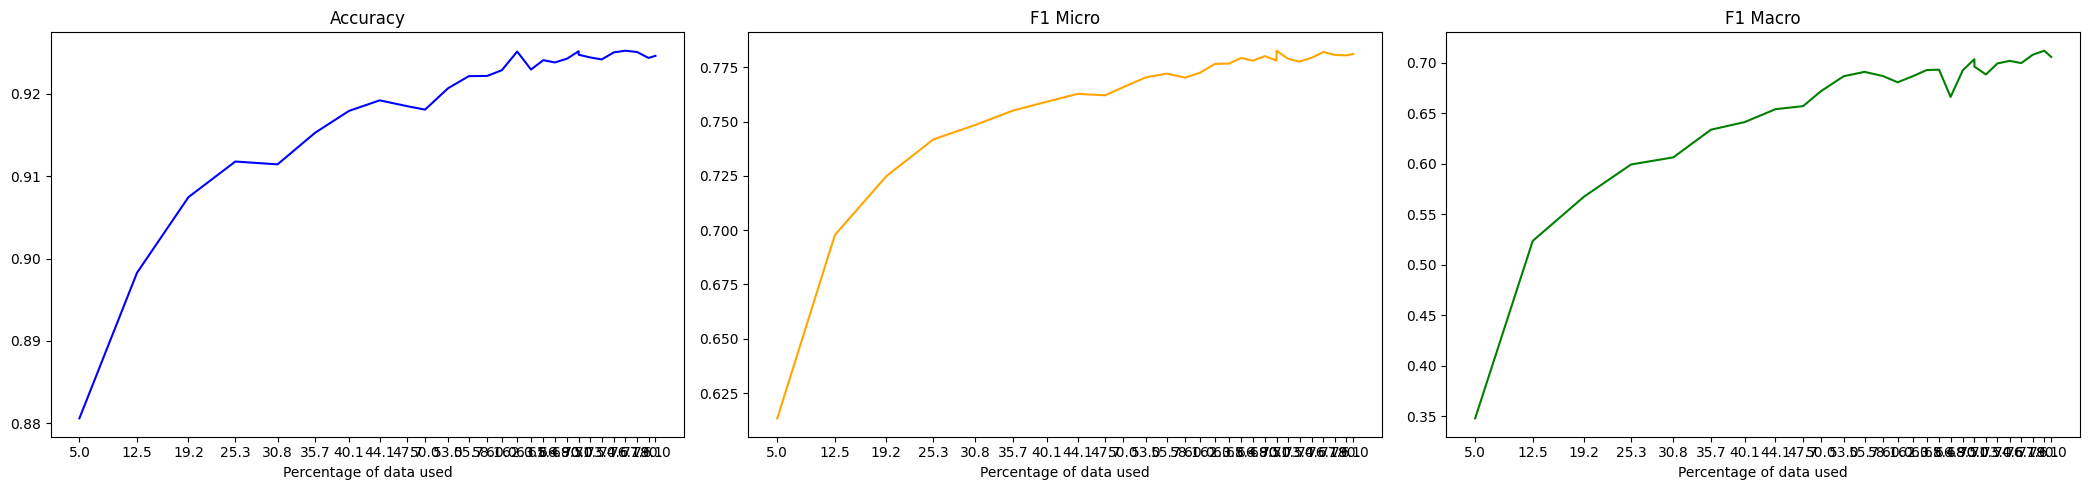

In [ ]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: [14, 61, 33]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.539, Accuracy: 0.8281, F1 Micro: 0.0314, F1 Macro: 0.0116
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4135, Accuracy: 0.8311, F1 Micro: 0.0509, F1 Macro: 0.0214
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3878, Accuracy: 0.8455, F1 Micro: 0.2462, F1 Macro: 0.085
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3631, Accuracy: 0.861, F1 Micro: 0.4165, F1 Macro: 0.1586
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3274, Accuracy: 0.8707, F1 Micro: 0.5642, F1 Macro: 0.269
Epoch 6/10, Train Loss: 0.2692, Accuracy: 0.8748, F1 Micro: 0.5337, F1 Macro: 0.2575
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2499, Accuracy: 0.8752, F1 Micro: 0.6045, F1 Macro: 0.3351
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2231, Accuracy: 0.8783, F1 Micro: 0.6121, F1 Macro: 0.3459
Epoch 9/10, Train Loss: 0.1835, Accuracy: 0.8792, F1 Micro: 0.5733, F1 Macro: 0.3269
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5923, Accuracy: 0.8372, F1 Micro: 0.3946, F1 Macro: 0.1088
Epoch 2/10, Train Loss: 0.4278, Accuracy: 0.8351, F1 Micro: 0.1029, F1 Macro: 0.04
Epoch 3/10, Train Loss: 0.3942, Accuracy: 0.8379, F1 Micro: 0.1413, F1 Macro: 0.0519
Epoch 4/10, Train Loss: 0.3747, Accuracy: 0.8553, F1 Micro: 0.3433, F1 Macro: 0.112
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3417, Accuracy: 0.8726, F1 Micro: 0.5182, F1 Macro: 0.2254
Epoch 6/10, Train Loss: 0.2919, Accuracy: 0.8729, F1 Micro: 0.497, F1 Macro: 0.2291
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.27, Accuracy: 0.876, F1 Micro: 0.6096, F1 Macro: 0.3093
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2396, Accuracy: 0.8806, F1 Micro: 0.6149, F1 Macro: 0.3259
Epoch 9/10, Train Loss: 0.203, Accuracy: 0.8803, F1 Micro: 0.6002, F1 Macro: 0.3225
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.1953, Accuracy: 0.8814, F1 Micro: 0.6171, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.558, Accuracy: 0.8304, F1 Micro: 0.0856, F1 Macro: 0.0322
Epoch 2/10, Train Loss: 0.4221, Accuracy: 0.8323, F1 Micro: 0.0663, F1 Macro: 0.0261
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3932, Accuracy: 0.842, F1 Micro: 0.2123, F1 Macro: 0.0678
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3734, Accuracy: 0.8531, F1 Micro: 0.3384, F1 Macro: 0.1079
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3428, Accuracy: 0.8694, F1 Micro: 0.4773, F1 Macro: 0.2023
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2886, Accuracy: 0.8748, F1 Micro: 0.5235, F1 Macro: 0.2548
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.262, Accuracy: 0.8767, F1 Micro: 0.6086, F1 Macro: 0.3292
Epoch 8/10, Train Loss: 0.2371, Accuracy: 0.8816, F1 Micro: 0.6037, F1 Macro: 0.3434
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1951, Accuracy: 0.8802, F1 Micro: 0.6101, F1 Macro: 0.364
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4649, Accuracy: 0.8401, F1 Micro: 0.2008, F1 Macro: 0.0669
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3629, Accuracy: 0.8659, F1 Micro: 0.4355, F1 Macro: 0.1813
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3106, Accuracy: 0.8832, F1 Micro: 0.5723, F1 Macro: 0.2879
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2641, Accuracy: 0.8919, F1 Micro: 0.6371, F1 Macro: 0.3956
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2231, Accuracy: 0.8942, F1 Micro: 0.6654, F1 Macro: 0.4491
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1896, Accuracy: 0.896, F1 Micro: 0.6777, F1 Macro: 0.4755
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.154, Accuracy: 0.8969, F1 Micro: 0.6812, F1 Macro: 0.4859
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1404, Accuracy: 0.8982, F1 Micro: 0.6877, F1 Macro: 0.5212
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4926, Accuracy: 0.8468, F1 Micro: 0.2711, F1 Macro: 0.0886
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3705, Accuracy: 0.8649, F1 Micro: 0.4295, F1 Macro: 0.1655
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3224, Accuracy: 0.8787, F1 Micro: 0.5383, F1 Macro: 0.2521
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.276, Accuracy: 0.8871, F1 Micro: 0.6157, F1 Macro: 0.3395
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2362, Accuracy: 0.8903, F1 Micro: 0.664, F1 Macro: 0.4334
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2047, Accuracy: 0.8929, F1 Micro: 0.6744, F1 Macro: 0.4318
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1712, Accuracy: 0.8938, F1 Micro: 0.6772, F1 Macro: 0.4391
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1546, Accuracy: 0.8968, F1 Micro: 0.6809, F1 Macro: 0.4884
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4766, Accuracy: 0.8395, F1 Micro: 0.1975, F1 Macro: 0.0591
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3717, Accuracy: 0.8612, F1 Micro: 0.4199, F1 Macro: 0.147
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3207, Accuracy: 0.8804, F1 Micro: 0.5431, F1 Macro: 0.2683
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2715, Accuracy: 0.8904, F1 Micro: 0.6371, F1 Macro: 0.3772
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2303, Accuracy: 0.8925, F1 Micro: 0.666, F1 Macro: 0.4479
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1964, Accuracy: 0.8916, F1 Micro: 0.6887, F1 Macro: 0.4986
Epoch 7/10, Train Loss: 0.1647, Accuracy: 0.895, F1 Micro: 0.6831, F1 Macro: 0.4817
Epoch 8/10, Train Loss: 0.1464, Accuracy: 0.8978, F1 Micro: 0.6805, F1 Macro: 0.4885
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1204, Accuracy: 0.897, F1 Micro: 0.6936, F1 Macro: 0.5153
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.436, Accuracy: 0.8536, F1 Micro: 0.3412, F1 Macro: 0.1057
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3213, Accuracy: 0.8784, F1 Micro: 0.5208, F1 Macro: 0.25
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.266, Accuracy: 0.8964, F1 Micro: 0.6666, F1 Macro: 0.4233
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2181, Accuracy: 0.9017, F1 Micro: 0.6843, F1 Macro: 0.4796
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1835, Accuracy: 0.904, F1 Micro: 0.7, F1 Macro: 0.5251
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1522, Accuracy: 0.8996, F1 Micro: 0.7059, F1 Macro: 0.5426
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1226, Accuracy: 0.9053, F1 Micro: 0.7061, F1 Macro: 0.5506
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1023, Accuracy: 0.9055, F1 Micro: 0.7089, F1 Macro: 0.547
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0902, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4568, Accuracy: 0.8535, F1 Micro: 0.3415, F1 Macro: 0.106
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3339, Accuracy: 0.8779, F1 Micro: 0.5285, F1 Macro: 0.2512
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2787, Accuracy: 0.8923, F1 Micro: 0.6514, F1 Macro: 0.3733
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2309, Accuracy: 0.8985, F1 Micro: 0.6691, F1 Macro: 0.4324
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1955, Accuracy: 0.8978, F1 Micro: 0.6992, F1 Macro: 0.5223
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1638, Accuracy: 0.9009, F1 Micro: 0.7003, F1 Macro: 0.5426
Epoch 7/10, Train Loss: 0.1351, Accuracy: 0.9037, F1 Micro: 0.6866, F1 Macro: 0.5213
Epoch 8/10, Train Loss: 0.1118, Accuracy: 0.9041, F1 Micro: 0.6877, F1 Macro: 0.5243
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0936, Accuracy: 0.9028, F1 Micro: 0.7025, F1 Macro: 0.5442
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4454, Accuracy: 0.8528, F1 Micro: 0.3569, F1 Macro: 0.109
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.33, Accuracy: 0.8796, F1 Micro: 0.5405, F1 Macro: 0.259
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2731, Accuracy: 0.8943, F1 Micro: 0.6477, F1 Macro: 0.3792
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2238, Accuracy: 0.9021, F1 Micro: 0.6905, F1 Macro: 0.4825
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.187, Accuracy: 0.8985, F1 Micro: 0.7027, F1 Macro: 0.5148
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.152, Accuracy: 0.9, F1 Micro: 0.7095, F1 Macro: 0.546
Epoch 7/10, Train Loss: 0.1302, Accuracy: 0.9047, F1 Micro: 0.6991, F1 Macro: 0.5368
Epoch 8/10, Train Loss: 0.1079, Accuracy: 0.9063, F1 Micro: 0.7073, F1 Macro: 0.5524
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0907, Accuracy: 0.9066, F1 Micro: 0.7255, F1 Macro: 0.5849
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4169, Accuracy: 0.8738, F1 Micro: 0.5656, F1 Macro: 0.2589
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3034, Accuracy: 0.8926, F1 Micro: 0.6331, F1 Macro: 0.3778
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2455, Accuracy: 0.8977, F1 Micro: 0.6986, F1 Macro: 0.5219
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2046, Accuracy: 0.903, F1 Micro: 0.7118, F1 Macro: 0.554
Epoch 5/10, Train Loss: 0.1674, Accuracy: 0.9078, F1 Micro: 0.7065, F1 Macro: 0.5369
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1384, Accuracy: 0.9038, F1 Micro: 0.7264, F1 Macro: 0.5699
Epoch 7/10, Train Loss: 0.1126, Accuracy: 0.9079, F1 Micro: 0.7228, F1 Macro: 0.5678
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0957, Accuracy: 0.9107, F1 Micro: 0.7363, F1 Macro: 0.5949
Epoch 9/10, Train Loss: 0.0839, Accuracy: 0.9124, F1 Micro: 0.7343, F1 Macro: 0.6182
Epoch 10/10, Train Loss: 0.0694, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4335, Accuracy: 0.8712, F1 Micro: 0.5035, F1 Macro: 0.2141
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3099, Accuracy: 0.8895, F1 Micro: 0.6401, F1 Macro: 0.3366
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2518, Accuracy: 0.8959, F1 Micro: 0.6915, F1 Macro: 0.5137
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2097, Accuracy: 0.9007, F1 Micro: 0.7078, F1 Macro: 0.5443
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1769, Accuracy: 0.9063, F1 Micro: 0.7092, F1 Macro: 0.5379
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.14, Accuracy: 0.9047, F1 Micro: 0.7109, F1 Macro: 0.5374
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1172, Accuracy: 0.9035, F1 Micro: 0.721, F1 Macro: 0.5686
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0976, Accuracy: 0.9088, F1 Micro: 0.7259, F1 Macro: 0.5852
Epoch 9/10, Train Loss: 0.0862, Accuracy: 0.9098, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4273, Accuracy: 0.8702, F1 Micro: 0.508, F1 Macro: 0.218
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3076, Accuracy: 0.8916, F1 Micro: 0.6264, F1 Macro: 0.3474
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2492, Accuracy: 0.8968, F1 Micro: 0.6948, F1 Macro: 0.5258
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2123, Accuracy: 0.9042, F1 Micro: 0.7112, F1 Macro: 0.5518
Epoch 5/10, Train Loss: 0.1732, Accuracy: 0.9071, F1 Micro: 0.7096, F1 Macro: 0.54
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1416, Accuracy: 0.9055, F1 Micro: 0.716, F1 Macro: 0.5461
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1137, Accuracy: 0.902, F1 Micro: 0.7269, F1 Macro: 0.5691
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0948, Accuracy: 0.9013, F1 Micro: 0.7318, F1 Macro: 0.6112
Epoch 9/10, Train Loss: 0.0857, Accuracy: 0.9115, F1 Micro: 0.7271, F1 Macro: 0.5976
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4019, Accuracy: 0.8796, F1 Micro: 0.58, F1 Macro: 0.274
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2839, Accuracy: 0.8977, F1 Micro: 0.667, F1 Macro: 0.4116
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2233, Accuracy: 0.9058, F1 Micro: 0.71, F1 Macro: 0.5351
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1864, Accuracy: 0.9097, F1 Micro: 0.7154, F1 Macro: 0.5492
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1576, Accuracy: 0.9102, F1 Micro: 0.7325, F1 Macro: 0.578
Epoch 6/10, Train Loss: 0.1286, Accuracy: 0.9133, F1 Micro: 0.7225, F1 Macro: 0.5823
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0992, Accuracy: 0.9129, F1 Micro: 0.7437, F1 Macro: 0.6059
Epoch 8/10, Train Loss: 0.0842, Accuracy: 0.9098, F1 Micro: 0.7356, F1 Macro: 0.6276
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0691, Accuracy: 0.9131, F1 Micro: 0.7461, F1 Macro: 0.6245
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4164, Accuracy: 0.8774, F1 Micro: 0.54, F1 Macro: 0.2419
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2922, Accuracy: 0.8946, F1 Micro: 0.6611, F1 Macro: 0.3673
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2323, Accuracy: 0.9032, F1 Micro: 0.6889, F1 Macro: 0.5018
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1988, Accuracy: 0.907, F1 Micro: 0.7018, F1 Macro: 0.5196
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1639, Accuracy: 0.9088, F1 Micro: 0.7181, F1 Macro: 0.5588
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1353, Accuracy: 0.9083, F1 Micro: 0.7246, F1 Macro: 0.5892
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1045, Accuracy: 0.9054, F1 Micro: 0.7348, F1 Macro: 0.5911
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0926, Accuracy: 0.9094, F1 Micro: 0.7355, F1 Macro: 0.5996
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4115, Accuracy: 0.878, F1 Micro: 0.5331, F1 Macro: 0.2459
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2885, Accuracy: 0.8967, F1 Micro: 0.6632, F1 Macro: 0.374
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2269, Accuracy: 0.9035, F1 Micro: 0.7075, F1 Macro: 0.5219
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1905, Accuracy: 0.9076, F1 Micro: 0.7112, F1 Macro: 0.5312
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1585, Accuracy: 0.908, F1 Micro: 0.7327, F1 Macro: 0.5701
Epoch 6/10, Train Loss: 0.1282, Accuracy: 0.9114, F1 Micro: 0.7176, F1 Macro: 0.5826
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1021, Accuracy: 0.9085, F1 Micro: 0.7388, F1 Macro: 0.6039
Epoch 8/10, Train Loss: 0.0839, Accuracy: 0.9114, F1 Micro: 0.7375, F1 Macro: 0.6169
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0684, Accuracy: 0.9108, F1 Micro: 0.7442, F1 Macro: 0.6125
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3887, Accuracy: 0.8806, F1 Micro: 0.5661, F1 Macro: 0.2761
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2664, Accuracy: 0.9, F1 Micro: 0.677, F1 Macro: 0.4711
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2249, Accuracy: 0.9098, F1 Micro: 0.7182, F1 Macro: 0.5361
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1817, Accuracy: 0.9144, F1 Micro: 0.7372, F1 Macro: 0.5829
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1438, Accuracy: 0.9138, F1 Micro: 0.7433, F1 Macro: 0.5849
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.114, Accuracy: 0.9124, F1 Micro: 0.7444, F1 Macro: 0.5978
Epoch 7/10, Train Loss: 0.0937, Accuracy: 0.914, F1 Micro: 0.7375, F1 Macro: 0.6029
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0802, Accuracy: 0.9117, F1 Micro: 0.7497, F1 Macro: 0.647
Epoch 9/10, Train Loss: 0.062, Accuracy: 0.9137, F1 Micro: 0.7398, F1 Macro: 0.6326
Higher F1 ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.405, Accuracy: 0.8797, F1 Micro: 0.5699, F1 Macro: 0.2681
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2759, Accuracy: 0.8971, F1 Micro: 0.659, F1 Macro: 0.4062
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2311, Accuracy: 0.9043, F1 Micro: 0.7141, F1 Macro: 0.5299
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1882, Accuracy: 0.9119, F1 Micro: 0.728, F1 Macro: 0.5456
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1493, Accuracy: 0.9113, F1 Micro: 0.7441, F1 Macro: 0.5789
Epoch 6/10, Train Loss: 0.1199, Accuracy: 0.9122, F1 Micro: 0.7425, F1 Macro: 0.5952
Epoch 7/10, Train Loss: 0.0993, Accuracy: 0.9138, F1 Micro: 0.7288, F1 Macro: 0.5897
Epoch 8/10, Train Loss: 0.0809, Accuracy: 0.9163, F1 Micro: 0.7397, F1 Macro: 0.6185
Epoch 9/10, Train Loss: 0.0684, Accuracy: 0.9138, F1 Micro: 0.7343, F1 Macro: 0.5987
Epoch 10/10, Train Loss: 0.0622, Accuracy: 0.917, F1 Micro: 0.741, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3974, Accuracy: 0.8816, F1 Micro: 0.5855, F1 Macro: 0.2964
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.272, Accuracy: 0.8992, F1 Micro: 0.6707, F1 Macro: 0.469
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2288, Accuracy: 0.9078, F1 Micro: 0.7176, F1 Macro: 0.5297
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1862, Accuracy: 0.9125, F1 Micro: 0.7301, F1 Macro: 0.5649
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1498, Accuracy: 0.9159, F1 Micro: 0.7409, F1 Macro: 0.5788
Epoch 6/10, Train Loss: 0.117, Accuracy: 0.9113, F1 Micro: 0.7406, F1 Macro: 0.5892
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0991, Accuracy: 0.9158, F1 Micro: 0.7473, F1 Macro: 0.6068
Epoch 8/10, Train Loss: 0.0814, Accuracy: 0.916, F1 Micro: 0.7339, F1 Macro: 0.6136
Epoch 9/10, Train Loss: 0.0639, Accuracy: 0.9146, F1 Micro: 0.7381, F1 Macro: 0.6132
Epoch 10/10, Train Loss: 0.0578, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3821, Accuracy: 0.8846, F1 Micro: 0.6165, F1 Macro: 0.3043
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2706, Accuracy: 0.9027, F1 Micro: 0.7092, F1 Macro: 0.5066
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2133, Accuracy: 0.9107, F1 Micro: 0.7232, F1 Macro: 0.5484
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1752, Accuracy: 0.9137, F1 Micro: 0.729, F1 Macro: 0.5794
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1408, Accuracy: 0.9136, F1 Micro: 0.7412, F1 Macro: 0.5948
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1131, Accuracy: 0.9115, F1 Micro: 0.745, F1 Macro: 0.602
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0953, Accuracy: 0.9157, F1 Micro: 0.7518, F1 Macro: 0.6381
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.076, Accuracy: 0.9159, F1 Micro: 0.753, F1 Macro: 0.6447
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.06

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3977, Accuracy: 0.8826, F1 Micro: 0.6194, F1 Macro: 0.2987
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2779, Accuracy: 0.9016, F1 Micro: 0.6886, F1 Macro: 0.473
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2178, Accuracy: 0.9084, F1 Micro: 0.7097, F1 Macro: 0.5306
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1779, Accuracy: 0.9094, F1 Micro: 0.7254, F1 Macro: 0.5714
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1449, Accuracy: 0.9129, F1 Micro: 0.7392, F1 Macro: 0.5812
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1151, Accuracy: 0.9156, F1 Micro: 0.7446, F1 Macro: 0.6031
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0978, Accuracy: 0.911, F1 Micro: 0.7446, F1 Macro: 0.625
Epoch 8/10, Train Loss: 0.0779, Accuracy: 0.913, F1 Micro: 0.7442, F1 Macro: 0.6218
Epoch 9/10, Train Loss: 0.0641, Accuracy: 0.9151, F1 Micro: 0.7431, F1 Macro: 0.6207
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3895, Accuracy: 0.8836, F1 Micro: 0.6317, F1 Macro: 0.312
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2735, Accuracy: 0.903, F1 Micro: 0.7061, F1 Macro: 0.5084
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2149, Accuracy: 0.9102, F1 Micro: 0.7134, F1 Macro: 0.5475
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1772, Accuracy: 0.9097, F1 Micro: 0.7229, F1 Macro: 0.5775
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1426, Accuracy: 0.9119, F1 Micro: 0.7299, F1 Macro: 0.5754
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1134, Accuracy: 0.9142, F1 Micro: 0.7419, F1 Macro: 0.5982
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.094, Accuracy: 0.9148, F1 Micro: 0.7446, F1 Macro: 0.6235
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0751, Accuracy: 0.9163, F1 Micro: 0.7447, F1 Macro: 0.6457
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3698, Accuracy: 0.8857, F1 Micro: 0.6555, F1 Macro: 0.3837
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2577, Accuracy: 0.9041, F1 Micro: 0.7159, F1 Macro: 0.5124
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2067, Accuracy: 0.9119, F1 Micro: 0.7281, F1 Macro: 0.574
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1716, Accuracy: 0.9142, F1 Micro: 0.7442, F1 Macro: 0.5865
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.136, Accuracy: 0.9167, F1 Micro: 0.7485, F1 Macro: 0.6327
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1065, Accuracy: 0.9171, F1 Micro: 0.7527, F1 Macro: 0.6238
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0845, Accuracy: 0.9184, F1 Micro: 0.7641, F1 Macro: 0.6445
Epoch 8/10, Train Loss: 0.0719, Accuracy: 0.9113, F1 Micro: 0.7531, F1 Macro: 0.649
Epoch 9/10, Train Loss: 0.0609, Accuracy: 0.9178, F1 Micro: 0.7589, F1 Macro: 0.6645
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3853, Accuracy: 0.8853, F1 Micro: 0.6424, F1 Macro: 0.3318
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2645, Accuracy: 0.9025, F1 Micro: 0.6997, F1 Macro: 0.4663
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2132, Accuracy: 0.9082, F1 Micro: 0.7033, F1 Macro: 0.5369
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1771, Accuracy: 0.9131, F1 Micro: 0.7303, F1 Macro: 0.5715
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.14, Accuracy: 0.9155, F1 Micro: 0.7349, F1 Macro: 0.5928
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.111, Accuracy: 0.9151, F1 Micro: 0.7392, F1 Macro: 0.5935
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0893, Accuracy: 0.9158, F1 Micro: 0.7542, F1 Macro: 0.6259
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0763, Accuracy: 0.9168, F1 Micro: 0.7558, F1 Macro: 0.6471
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.379, Accuracy: 0.8873, F1 Micro: 0.6244, F1 Macro: 0.3428
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2596, Accuracy: 0.9035, F1 Micro: 0.7151, F1 Macro: 0.5285
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2078, Accuracy: 0.911, F1 Micro: 0.7226, F1 Macro: 0.5604
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1739, Accuracy: 0.9141, F1 Micro: 0.7319, F1 Macro: 0.5801
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1398, Accuracy: 0.9147, F1 Micro: 0.7429, F1 Macro: 0.5989
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.108, Accuracy: 0.9158, F1 Micro: 0.7549, F1 Macro: 0.6209
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0857, Accuracy: 0.9181, F1 Micro: 0.7637, F1 Macro: 0.638
Epoch 8/10, Train Loss: 0.0721, Accuracy: 0.9117, F1 Micro: 0.7536, F1 Macro: 0.6471
Epoch 9/10, Train Loss: 0.0667, Accuracy: 0.9175, F1 Micro: 0.7588, F1 Macro: 0.6565
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3655, Accuracy: 0.8898, F1 Micro: 0.6471, F1 Macro: 0.3887
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2525, Accuracy: 0.9053, F1 Micro: 0.7185, F1 Macro: 0.5425
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2019, Accuracy: 0.9124, F1 Micro: 0.743, F1 Macro: 0.585
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1633, Accuracy: 0.9161, F1 Micro: 0.751, F1 Macro: 0.587
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1284, Accuracy: 0.9122, F1 Micro: 0.755, F1 Macro: 0.638
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1075, Accuracy: 0.9208, F1 Micro: 0.7657, F1 Macro: 0.6588
Epoch 7/10, Train Loss: 0.0876, Accuracy: 0.9204, F1 Micro: 0.7619, F1 Macro: 0.6486
Epoch 8/10, Train Loss: 0.0703, Accuracy: 0.9195, F1 Micro: 0.7611, F1 Macro: 0.6665
Epoch 9/10, Train Loss: 0.0589, Accuracy: 0.918, F1 Micro: 0.763, F1 Macro: 0.6679
Epoch 10/10, Train Loss: 0.0478, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3802, Accuracy: 0.8865, F1 Micro: 0.6396, F1 Macro: 0.3327
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2612, Accuracy: 0.9047, F1 Micro: 0.703, F1 Macro: 0.4996
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.209, Accuracy: 0.9097, F1 Micro: 0.7355, F1 Macro: 0.5648
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1669, Accuracy: 0.9171, F1 Micro: 0.7491, F1 Macro: 0.582
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1358, Accuracy: 0.9152, F1 Micro: 0.7519, F1 Macro: 0.6378
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1149, Accuracy: 0.9162, F1 Micro: 0.757, F1 Macro: 0.6423
Epoch 7/10, Train Loss: 0.0916, Accuracy: 0.9198, F1 Micro: 0.7449, F1 Macro: 0.6277
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0765, Accuracy: 0.9197, F1 Micro: 0.7621, F1 Macro: 0.6585
Epoch 9/10, Train Loss: 0.0625, Accuracy: 0.9159, F1 Micro: 0.7614, F1 Macro: 0.6548
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3737, Accuracy: 0.8889, F1 Micro: 0.6417, F1 Macro: 0.3585
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2564, Accuracy: 0.9055, F1 Micro: 0.7179, F1 Macro: 0.5313
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2049, Accuracy: 0.9102, F1 Micro: 0.7432, F1 Macro: 0.5767
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.162, Accuracy: 0.9151, F1 Micro: 0.7487, F1 Macro: 0.5799
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1313, Accuracy: 0.9174, F1 Micro: 0.7601, F1 Macro: 0.6472
Epoch 6/10, Train Loss: 0.109, Accuracy: 0.9171, F1 Micro: 0.7596, F1 Macro: 0.6516
Epoch 7/10, Train Loss: 0.0914, Accuracy: 0.9186, F1 Micro: 0.7553, F1 Macro: 0.6446
Epoch 8/10, Train Loss: 0.0747, Accuracy: 0.9187, F1 Micro: 0.7592, F1 Macro: 0.6597
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0598, Accuracy: 0.9178, F1 Micro: 0.7634, F1 Macro: 0.6712
Epoch 10/10, Train Loss: 0.0541, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3621, Accuracy: 0.8906, F1 Micro: 0.6557, F1 Macro: 0.3828
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2496, Accuracy: 0.9034, F1 Micro: 0.6734, F1 Macro: 0.5112
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2035, Accuracy: 0.9132, F1 Micro: 0.723, F1 Macro: 0.5655
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1595, Accuracy: 0.9192, F1 Micro: 0.7401, F1 Macro: 0.5772
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1301, Accuracy: 0.9166, F1 Micro: 0.7575, F1 Macro: 0.6345
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1058, Accuracy: 0.9142, F1 Micro: 0.761, F1 Macro: 0.6602
Epoch 7/10, Train Loss: 0.0882, Accuracy: 0.9194, F1 Micro: 0.7593, F1 Macro: 0.6616
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0704, Accuracy: 0.9171, F1 Micro: 0.7632, F1 Macro: 0.6617
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0625, Accuracy: 0.9185, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3762, Accuracy: 0.8866, F1 Micro: 0.6206, F1 Macro: 0.3167
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2585, Accuracy: 0.9031, F1 Micro: 0.6842, F1 Macro: 0.5104
Epoch 3/10, Train Loss: 0.209, Accuracy: 0.9064, F1 Micro: 0.6802, F1 Macro: 0.5281
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.163, Accuracy: 0.9163, F1 Micro: 0.7329, F1 Macro: 0.5741
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1334, Accuracy: 0.9139, F1 Micro: 0.759, F1 Macro: 0.6308
Epoch 6/10, Train Loss: 0.1094, Accuracy: 0.9138, F1 Micro: 0.7554, F1 Macro: 0.6538
Epoch 7/10, Train Loss: 0.0908, Accuracy: 0.916, F1 Micro: 0.7566, F1 Macro: 0.6554
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0762, Accuracy: 0.9153, F1 Micro: 0.7625, F1 Macro: 0.6672
Epoch 9/10, Train Loss: 0.0622, Accuracy: 0.919, F1 Micro: 0.7594, F1 Macro: 0.6734
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0554, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3711, Accuracy: 0.8892, F1 Micro: 0.6349, F1 Macro: 0.3453
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2546, Accuracy: 0.9043, F1 Micro: 0.6769, F1 Macro: 0.4968
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.207, Accuracy: 0.9108, F1 Micro: 0.7148, F1 Macro: 0.5613
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1626, Accuracy: 0.9188, F1 Micro: 0.7487, F1 Macro: 0.5818
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1311, Accuracy: 0.9158, F1 Micro: 0.7614, F1 Macro: 0.6206
Epoch 6/10, Train Loss: 0.1072, Accuracy: 0.9171, F1 Micro: 0.7534, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0877, Accuracy: 0.9174, F1 Micro: 0.7627, F1 Macro: 0.6692
Epoch 8/10, Train Loss: 0.0702, Accuracy: 0.919, F1 Micro: 0.7614, F1 Macro: 0.6656
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0601, Accuracy: 0.9175, F1 Micro: 0.7632, F1 Macro: 0.6727
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3525, Accuracy: 0.8934, F1 Micro: 0.6499, F1 Macro: 0.3799
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2432, Accuracy: 0.9025, F1 Micro: 0.7258, F1 Macro: 0.5517
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.198, Accuracy: 0.9166, F1 Micro: 0.7441, F1 Macro: 0.5908
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1576, Accuracy: 0.9167, F1 Micro: 0.7633, F1 Macro: 0.6215
Epoch 5/10, Train Loss: 0.1309, Accuracy: 0.9179, F1 Micro: 0.7624, F1 Macro: 0.6616
Epoch 6/10, Train Loss: 0.1035, Accuracy: 0.9213, F1 Micro: 0.7628, F1 Macro: 0.6703
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0863, Accuracy: 0.9238, F1 Micro: 0.774, F1 Macro: 0.6749
Epoch 8/10, Train Loss: 0.069, Accuracy: 0.924, F1 Micro: 0.7715, F1 Macro: 0.6687
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0582, Accuracy: 0.9226, F1 Micro: 0.7745, F1 Macro: 0.6897
Epoch 10/10, Train Loss: 0.0502, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3656, Accuracy: 0.8895, F1 Micro: 0.6509, F1 Macro: 0.3499
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2528, Accuracy: 0.9017, F1 Micro: 0.719, F1 Macro: 0.5336
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2052, Accuracy: 0.9148, F1 Micro: 0.7328, F1 Macro: 0.5661
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.162, Accuracy: 0.918, F1 Micro: 0.7594, F1 Macro: 0.6175
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1315, Accuracy: 0.9209, F1 Micro: 0.7595, F1 Macro: 0.6493
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.105, Accuracy: 0.9198, F1 Micro: 0.7618, F1 Macro: 0.6588
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0879, Accuracy: 0.9195, F1 Micro: 0.7707, F1 Macro: 0.6731
Epoch 8/10, Train Loss: 0.0721, Accuracy: 0.916, F1 Micro: 0.7651, F1 Macro: 0.6696
Epoch 9/10, Train Loss: 0.0593, Accuracy: 0.9227, F1 Micro: 0.7702, F1 Macro: 0.6794
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.362, Accuracy: 0.8908, F1 Micro: 0.6491, F1 Macro: 0.3717
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2478, Accuracy: 0.9029, F1 Micro: 0.7233, F1 Macro: 0.5509
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2006, Accuracy: 0.9164, F1 Micro: 0.7426, F1 Macro: 0.5823
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1592, Accuracy: 0.918, F1 Micro: 0.7671, F1 Macro: 0.6392
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1304, Accuracy: 0.9217, F1 Micro: 0.7674, F1 Macro: 0.6511
Epoch 6/10, Train Loss: 0.1025, Accuracy: 0.9209, F1 Micro: 0.7588, F1 Macro: 0.6577
Epoch 7/10, Train Loss: 0.0848, Accuracy: 0.9177, F1 Micro: 0.7654, F1 Macro: 0.6692
Epoch 8/10, Train Loss: 0.07, Accuracy: 0.9214, F1 Micro: 0.7606, F1 Macro: 0.6595
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0594, Accuracy: 0.9204, F1 Micro: 0.7729, F1 Macro: 0.693
Epoch 10/10, Train Loss: 0.0492, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3578, Accuracy: 0.888, F1 Micro: 0.5987, F1 Macro: 0.3324
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2488, Accuracy: 0.9078, F1 Micro: 0.7151, F1 Macro: 0.5471
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1985, Accuracy: 0.9161, F1 Micro: 0.7497, F1 Macro: 0.5895
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1596, Accuracy: 0.9214, F1 Micro: 0.7555, F1 Macro: 0.6154
Epoch 5/10, Train Loss: 0.1259, Accuracy: 0.9113, F1 Micro: 0.7552, F1 Macro: 0.6357
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1046, Accuracy: 0.9194, F1 Micro: 0.7653, F1 Macro: 0.6507
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0843, Accuracy: 0.9229, F1 Micro: 0.7715, F1 Macro: 0.6816
Epoch 8/10, Train Loss: 0.0702, Accuracy: 0.92, F1 Micro: 0.7646, F1 Macro: 0.6814
Epoch 9/10, Train Loss: 0.0585, Accuracy: 0.9202, F1 Micro: 0.7673, F1 Macro: 0.6823
Epoch 10/10, Train Loss: 0.0462, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.368, Accuracy: 0.8864, F1 Micro: 0.6011, F1 Macro: 0.3038
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2545, Accuracy: 0.9067, F1 Micro: 0.7031, F1 Macro: 0.5077
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2009, Accuracy: 0.9122, F1 Micro: 0.7406, F1 Macro: 0.5753
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1631, Accuracy: 0.9182, F1 Micro: 0.7487, F1 Macro: 0.6129
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1273, Accuracy: 0.9165, F1 Micro: 0.7562, F1 Macro: 0.6286
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1075, Accuracy: 0.9187, F1 Micro: 0.7642, F1 Macro: 0.6402
Epoch 7/10, Train Loss: 0.0827, Accuracy: 0.9192, F1 Micro: 0.7622, F1 Macro: 0.6543
Epoch 8/10, Train Loss: 0.0749, Accuracy: 0.9201, F1 Micro: 0.7625, F1 Macro: 0.6661
Epoch 9/10, Train Loss: 0.0604, Accuracy: 0.9222, F1 Micro: 0.7614, F1 Macro: 0.6733
Epoch 10/10, Train Loss: 0.0498, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3657, Accuracy: 0.8866, F1 Micro: 0.5964, F1 Macro: 0.3168
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2529, Accuracy: 0.9077, F1 Micro: 0.6999, F1 Macro: 0.5246
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2004, Accuracy: 0.9168, F1 Micro: 0.752, F1 Macro: 0.5877
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1641, Accuracy: 0.9214, F1 Micro: 0.7583, F1 Macro: 0.6155
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1263, Accuracy: 0.92, F1 Micro: 0.7655, F1 Macro: 0.6402
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.105, Accuracy: 0.9226, F1 Micro: 0.7741, F1 Macro: 0.6664
Epoch 7/10, Train Loss: 0.0835, Accuracy: 0.9202, F1 Micro: 0.7708, F1 Macro: 0.6755
Epoch 8/10, Train Loss: 0.0721, Accuracy: 0.9216, F1 Micro: 0.773, F1 Macro: 0.6982
Epoch 9/10, Train Loss: 0.0592, Accuracy: 0.9195, F1 Micro: 0.7719, F1 Macro: 0.6955
Epoch 10/10, Train Loss: 0.0503, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3587, Accuracy: 0.8896, F1 Micro: 0.6901, F1 Macro: 0.4549
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2419, Accuracy: 0.91, F1 Micro: 0.7416, F1 Macro: 0.5798
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1908, Accuracy: 0.9178, F1 Micro: 0.7474, F1 Macro: 0.5861
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1571, Accuracy: 0.9218, F1 Micro: 0.7672, F1 Macro: 0.6263
Epoch 5/10, Train Loss: 0.1228, Accuracy: 0.9214, F1 Micro: 0.767, F1 Macro: 0.657
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.099, Accuracy: 0.92, F1 Micro: 0.7704, F1 Macro: 0.6648
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0801, Accuracy: 0.9216, F1 Micro: 0.7706, F1 Macro: 0.6702
Epoch 8/10, Train Loss: 0.066, Accuracy: 0.9201, F1 Micro: 0.7679, F1 Macro: 0.6762
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0545, Accuracy: 0.9235, F1 Micro: 0.7767, F1 Macro: 0.6953
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3696, Accuracy: 0.8861, F1 Micro: 0.6772, F1 Macro: 0.399
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2489, Accuracy: 0.9076, F1 Micro: 0.7355, F1 Macro: 0.5646
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.198, Accuracy: 0.9152, F1 Micro: 0.7385, F1 Macro: 0.5651
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.157, Accuracy: 0.9208, F1 Micro: 0.7588, F1 Macro: 0.6118
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1267, Accuracy: 0.92, F1 Micro: 0.768, F1 Macro: 0.658
Epoch 6/10, Train Loss: 0.1014, Accuracy: 0.9221, F1 Micro: 0.7672, F1 Macro: 0.6441
Epoch 7/10, Train Loss: 0.0841, Accuracy: 0.9203, F1 Micro: 0.7672, F1 Macro: 0.6725
Epoch 8/10, Train Loss: 0.0694, Accuracy: 0.9195, F1 Micro: 0.7645, F1 Macro: 0.6704
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0592, Accuracy: 0.9235, F1 Micro: 0.7697, F1 Macro: 0.6753
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3643, Accuracy: 0.8845, F1 Micro: 0.6834, F1 Macro: 0.4313
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2455, Accuracy: 0.9085, F1 Micro: 0.7343, F1 Macro: 0.5644
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1951, Accuracy: 0.917, F1 Micro: 0.7374, F1 Macro: 0.5712
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1575, Accuracy: 0.92, F1 Micro: 0.7623, F1 Macro: 0.6219
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1246, Accuracy: 0.9222, F1 Micro: 0.7739, F1 Macro: 0.6663
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1001, Accuracy: 0.9229, F1 Micro: 0.7739, F1 Macro: 0.6675
Epoch 7/10, Train Loss: 0.0855, Accuracy: 0.9204, F1 Micro: 0.7648, F1 Macro: 0.6745
Epoch 8/10, Train Loss: 0.0685, Accuracy: 0.9196, F1 Micro: 0.7701, F1 Macro: 0.6832
Epoch 9/10, Train Loss: 0.0587, Accuracy: 0.9208, F1 Micro: 0.7682, F1 Macro: 0.6898
Epoch 10/10, Train Loss: 0.0482, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3493, Accuracy: 0.8979, F1 Micro: 0.6679, F1 Macro: 0.4011
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2462, Accuracy: 0.9131, F1 Micro: 0.7353, F1 Macro: 0.5734
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1924, Accuracy: 0.9194, F1 Micro: 0.7525, F1 Macro: 0.6021
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1572, Accuracy: 0.9169, F1 Micro: 0.7623, F1 Macro: 0.6279
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1225, Accuracy: 0.9234, F1 Micro: 0.7649, F1 Macro: 0.6648
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1028, Accuracy: 0.9213, F1 Micro: 0.765, F1 Macro: 0.6694
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.08, Accuracy: 0.9231, F1 Micro: 0.767, F1 Macro: 0.6659
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0659, Accuracy: 0.9226, F1 Micro: 0.772, F1 Macro: 0.6827
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.05

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3629, Accuracy: 0.8924, F1 Micro: 0.6315, F1 Macro: 0.3466
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2519, Accuracy: 0.91, F1 Micro: 0.7213, F1 Macro: 0.5534
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1951, Accuracy: 0.9174, F1 Micro: 0.7416, F1 Macro: 0.5826
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1586, Accuracy: 0.9175, F1 Micro: 0.7509, F1 Macro: 0.6229
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1239, Accuracy: 0.9236, F1 Micro: 0.7679, F1 Macro: 0.6716
Epoch 6/10, Train Loss: 0.1056, Accuracy: 0.9193, F1 Micro: 0.7649, F1 Macro: 0.6802
Epoch 7/10, Train Loss: 0.0809, Accuracy: 0.9164, F1 Micro: 0.7574, F1 Macro: 0.6592
Epoch 8/10, Train Loss: 0.0671, Accuracy: 0.9196, F1 Micro: 0.7605, F1 Macro: 0.6622
Epoch 9/10, Train Loss: 0.0609, Accuracy: 0.9198, F1 Micro: 0.7618, F1 Macro: 0.6859
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0526, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.355, Accuracy: 0.8956, F1 Micro: 0.6651, F1 Macro: 0.3705
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2476, Accuracy: 0.9123, F1 Micro: 0.7271, F1 Macro: 0.5563
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1936, Accuracy: 0.9205, F1 Micro: 0.76, F1 Macro: 0.6061
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1582, Accuracy: 0.9219, F1 Micro: 0.7636, F1 Macro: 0.6268
Epoch 5/10, Train Loss: 0.1224, Accuracy: 0.922, F1 Micro: 0.7502, F1 Macro: 0.6382
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1039, Accuracy: 0.922, F1 Micro: 0.7677, F1 Macro: 0.6768
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0831, Accuracy: 0.9228, F1 Micro: 0.7708, F1 Macro: 0.6783
Epoch 8/10, Train Loss: 0.0663, Accuracy: 0.9235, F1 Micro: 0.7691, F1 Macro: 0.7002
Epoch 9/10, Train Loss: 0.0592, Accuracy: 0.9182, F1 Micro: 0.7708, F1 Macro: 0.6972
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.35, Accuracy: 0.8982, F1 Micro: 0.6611, F1 Macro: 0.4348
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2356, Accuracy: 0.9128, F1 Micro: 0.7348, F1 Macro: 0.5547
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1929, Accuracy: 0.9136, F1 Micro: 0.7501, F1 Macro: 0.5791
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1487, Accuracy: 0.9213, F1 Micro: 0.7606, F1 Macro: 0.6309
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.117, Accuracy: 0.9222, F1 Micro: 0.7709, F1 Macro: 0.6778
Epoch 6/10, Train Loss: 0.0947, Accuracy: 0.9236, F1 Micro: 0.7696, F1 Macro: 0.6746
Epoch 7/10, Train Loss: 0.0809, Accuracy: 0.9235, F1 Micro: 0.7693, F1 Macro: 0.6853
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0632, Accuracy: 0.9226, F1 Micro: 0.7742, F1 Macro: 0.6918
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0537, Accuracy: 0.9242, F1 Micro: 0.7756, F1 Macro: 0.7037
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3625, Accuracy: 0.8954, F1 Micro: 0.6575, F1 Macro: 0.3816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2423, Accuracy: 0.9106, F1 Micro: 0.7292, F1 Macro: 0.5452
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1974, Accuracy: 0.9141, F1 Micro: 0.7458, F1 Macro: 0.5471
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1522, Accuracy: 0.9202, F1 Micro: 0.7639, F1 Macro: 0.6426
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1197, Accuracy: 0.9209, F1 Micro: 0.767, F1 Macro: 0.6603
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0993, Accuracy: 0.9191, F1 Micro: 0.7675, F1 Macro: 0.663
Epoch 7/10, Train Loss: 0.0829, Accuracy: 0.9217, F1 Micro: 0.7602, F1 Macro: 0.6706
Epoch 8/10, Train Loss: 0.0653, Accuracy: 0.9228, F1 Micro: 0.765, F1 Macro: 0.6634
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0561, Accuracy: 0.9234, F1 Micro: 0.7683, F1 Macro: 0.6897
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3551, Accuracy: 0.897, F1 Micro: 0.6683, F1 Macro: 0.424
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2376, Accuracy: 0.9119, F1 Micro: 0.7288, F1 Macro: 0.5429
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1928, Accuracy: 0.9142, F1 Micro: 0.7527, F1 Macro: 0.576
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1516, Accuracy: 0.9209, F1 Micro: 0.766, F1 Macro: 0.636
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1159, Accuracy: 0.9212, F1 Micro: 0.7677, F1 Macro: 0.6702
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0949, Accuracy: 0.9206, F1 Micro: 0.7726, F1 Macro: 0.6819
Epoch 7/10, Train Loss: 0.0798, Accuracy: 0.9219, F1 Micro: 0.7665, F1 Macro: 0.6888
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.064, Accuracy: 0.922, F1 Micro: 0.773, F1 Macro: 0.6888
Epoch 9/10, Train Loss: 0.0559, Accuracy: 0.9226, F1 Micro: 0.7685, F1 Macro: 0.7001
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3441, Accuracy: 0.8938, F1 Micro: 0.6139, F1 Macro: 0.3842
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2381, Accuracy: 0.9075, F1 Micro: 0.6855, F1 Macro: 0.5241
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1871, Accuracy: 0.9206, F1 Micro: 0.7633, F1 Macro: 0.6259
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1525, Accuracy: 0.9233, F1 Micro: 0.7667, F1 Macro: 0.6651
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1192, Accuracy: 0.9202, F1 Micro: 0.772, F1 Macro: 0.6729
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0946, Accuracy: 0.9244, F1 Micro: 0.777, F1 Macro: 0.676
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0775, Accuracy: 0.9243, F1 Micro: 0.7806, F1 Macro: 0.7014
Epoch 8/10, Train Loss: 0.0625, Accuracy: 0.9172, F1 Micro: 0.7701, F1 Macro: 0.6904
Epoch 9/10, Train Loss: 0.054, Accuracy: 0.921, F1 Micro: 0.7729, F1 Macro: 0.7017
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3557, Accuracy: 0.8907, F1 Micro: 0.6022, F1 Macro: 0.3357
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2461, Accuracy: 0.9033, F1 Micro: 0.6676, F1 Macro: 0.4929
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1918, Accuracy: 0.919, F1 Micro: 0.7582, F1 Macro: 0.6324
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1558, Accuracy: 0.9225, F1 Micro: 0.763, F1 Macro: 0.6613
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1226, Accuracy: 0.9223, F1 Micro: 0.7744, F1 Macro: 0.6716
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.097, Accuracy: 0.9217, F1 Micro: 0.7757, F1 Macro: 0.6796
Epoch 7/10, Train Loss: 0.0796, Accuracy: 0.9226, F1 Micro: 0.7715, F1 Macro: 0.6859
Epoch 8/10, Train Loss: 0.0653, Accuracy: 0.9127, F1 Micro: 0.7641, F1 Macro: 0.6845
Epoch 9/10, Train Loss: 0.0525, Accuracy: 0.9214, F1 Micro: 0.7747, F1 Macro: 0.6961
Epoch 10/10, Train Loss: 0.0455, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3512, Accuracy: 0.8921, F1 Micro: 0.6103, F1 Macro: 0.3568
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2419, Accuracy: 0.9051, F1 Micro: 0.6801, F1 Macro: 0.5121
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1905, Accuracy: 0.9162, F1 Micro: 0.7547, F1 Macro: 0.6203
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1524, Accuracy: 0.9235, F1 Micro: 0.7671, F1 Macro: 0.6569
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1213, Accuracy: 0.9212, F1 Micro: 0.7706, F1 Macro: 0.6793
Epoch 6/10, Train Loss: 0.0935, Accuracy: 0.9184, F1 Micro: 0.7685, F1 Macro: 0.68
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0781, Accuracy: 0.9217, F1 Micro: 0.7761, F1 Macro: 0.7047
Epoch 8/10, Train Loss: 0.065, Accuracy: 0.9199, F1 Micro: 0.7735, F1 Macro: 0.7038
Epoch 9/10, Train Loss: 0.0512, Accuracy: 0.9187, F1 Micro: 0.7721, F1 Macro: 0.7048
Epoch 10/10, Train Loss: 0.0465, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3401, Accuracy: 0.8992, F1 Micro: 0.6802, F1 Macro: 0.448
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2306, Accuracy: 0.9146, F1 Micro: 0.7407, F1 Macro: 0.5705
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1844, Accuracy: 0.9214, F1 Micro: 0.7619, F1 Macro: 0.6189
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1456, Accuracy: 0.9189, F1 Micro: 0.7695, F1 Macro: 0.6708
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1215, Accuracy: 0.9212, F1 Micro: 0.7709, F1 Macro: 0.6661
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0931, Accuracy: 0.9243, F1 Micro: 0.7778, F1 Macro: 0.6918
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0807, Accuracy: 0.9242, F1 Micro: 0.7803, F1 Macro: 0.6978
Epoch 8/10, Train Loss: 0.0638, Accuracy: 0.922, F1 Micro: 0.7779, F1 Macro: 0.7158
Epoch 9/10, Train Loss: 0.0538, Accuracy: 0.924, F1 Micro: 0.7758, F1 Macro: 0.706
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3521, Accuracy: 0.8929, F1 Micro: 0.6239, F1 Macro: 0.3664
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2358, Accuracy: 0.9134, F1 Micro: 0.7292, F1 Macro: 0.5405
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1891, Accuracy: 0.9206, F1 Micro: 0.7577, F1 Macro: 0.6017
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.15, Accuracy: 0.9197, F1 Micro: 0.7693, F1 Macro: 0.678
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1235, Accuracy: 0.9225, F1 Micro: 0.7696, F1 Macro: 0.6709
Epoch 6/10, Train Loss: 0.095, Accuracy: 0.9243, F1 Micro: 0.7669, F1 Macro: 0.6735
Epoch 7/10, Train Loss: 0.0812, Accuracy: 0.9233, F1 Micro: 0.7683, F1 Macro: 0.6822
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0661, Accuracy: 0.9234, F1 Micro: 0.7701, F1 Macro: 0.6877
Epoch 9/10, Train Loss: 0.053, Accuracy: 0.9202, F1 Micro: 0.768, F1 Macro: 0.6826
Epoch 10/10, Train Loss: 0.0474, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3476, Accuracy: 0.899, F1 Micro: 0.675, F1 Macro: 0.4374
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2334, Accuracy: 0.9152, F1 Micro: 0.7401, F1 Macro: 0.5585
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1889, Accuracy: 0.9211, F1 Micro: 0.7657, F1 Macro: 0.6237
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1478, Accuracy: 0.9231, F1 Micro: 0.77, F1 Macro: 0.6733
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1196, Accuracy: 0.9249, F1 Micro: 0.7729, F1 Macro: 0.6524
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0941, Accuracy: 0.9255, F1 Micro: 0.7739, F1 Macro: 0.6851
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0798, Accuracy: 0.9216, F1 Micro: 0.7744, F1 Macro: 0.6929
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0666, Accuracy: 0.924, F1 Micro: 0.7796, F1 Macro: 0.7138
Epoch 9/10, Train Loss: 0.0565, Accuracy: 0.9244, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3445, Accuracy: 0.8972, F1 Micro: 0.6897, F1 Macro: 0.4636
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2359, Accuracy: 0.9108, F1 Micro: 0.7473, F1 Macro: 0.5812
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1878, Accuracy: 0.9203, F1 Micro: 0.7516, F1 Macro: 0.6066
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1506, Accuracy: 0.9225, F1 Micro: 0.7771, F1 Macro: 0.6712
Epoch 5/10, Train Loss: 0.1226, Accuracy: 0.9136, F1 Micro: 0.7624, F1 Macro: 0.6494
Epoch 6/10, Train Loss: 0.0962, Accuracy: 0.9227, F1 Micro: 0.774, F1 Macro: 0.6918
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0775, Accuracy: 0.9231, F1 Micro: 0.7778, F1 Macro: 0.7015
Epoch 8/10, Train Loss: 0.0614, Accuracy: 0.9233, F1 Micro: 0.7771, F1 Macro: 0.7098
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0532, Accuracy: 0.9248, F1 Micro: 0.7786, F1 Macro: 0.708
Epoch 10/10, Train Loss: 0.047, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3526, Accuracy: 0.8956, F1 Micro: 0.6784, F1 Macro: 0.4009
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2405, Accuracy: 0.9084, F1 Micro: 0.7391, F1 Macro: 0.5656
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1917, Accuracy: 0.9192, F1 Micro: 0.7556, F1 Macro: 0.6146
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1521, Accuracy: 0.9248, F1 Micro: 0.7693, F1 Macro: 0.649
Epoch 5/10, Train Loss: 0.1213, Accuracy: 0.9178, F1 Micro: 0.7671, F1 Macro: 0.6354
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0965, Accuracy: 0.9234, F1 Micro: 0.7724, F1 Macro: 0.6777
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0784, Accuracy: 0.9256, F1 Micro: 0.7776, F1 Macro: 0.6937
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0674, Accuracy: 0.9238, F1 Micro: 0.7785, F1 Macro: 0.701
Epoch 9/10, Train Loss: 0.0562, Accuracy: 0.9224, F1 Micro: 0.7758, F1 Macro: 0.7008
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3498, Accuracy: 0.8944, F1 Micro: 0.6899, F1 Macro: 0.455
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2372, Accuracy: 0.9096, F1 Micro: 0.7427, F1 Macro: 0.5684
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1893, Accuracy: 0.9215, F1 Micro: 0.7684, F1 Macro: 0.6216
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1486, Accuracy: 0.9248, F1 Micro: 0.7763, F1 Macro: 0.6657
Epoch 5/10, Train Loss: 0.1211, Accuracy: 0.9189, F1 Micro: 0.761, F1 Macro: 0.6211
Epoch 6/10, Train Loss: 0.0957, Accuracy: 0.9225, F1 Micro: 0.7728, F1 Macro: 0.6859
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0775, Accuracy: 0.9237, F1 Micro: 0.7766, F1 Macro: 0.6991
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0627, Accuracy: 0.9248, F1 Micro: 0.7792, F1 Macro: 0.7092
Epoch 9/10, Train Loss: 0.0525, Accuracy: 0.9243, F1 Micro: 0.7777, F1 Macro: 0.7107
Epoch 10/10, Train Loss: 0.0451, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3452, Accuracy: 0.8969, F1 Micro: 0.6737, F1 Macro: 0.4519
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2335, Accuracy: 0.9158, F1 Micro: 0.7452, F1 Macro: 0.5728
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.189, Accuracy: 0.9213, F1 Micro: 0.7633, F1 Macro: 0.6261
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1533, Accuracy: 0.9248, F1 Micro: 0.7672, F1 Macro: 0.6671
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1172, Accuracy: 0.9209, F1 Micro: 0.7703, F1 Macro: 0.6768
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0983, Accuracy: 0.9252, F1 Micro: 0.7717, F1 Macro: 0.6933
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.079, Accuracy: 0.9248, F1 Micro: 0.7765, F1 Macro: 0.6987
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0643, Accuracy: 0.9252, F1 Micro: 0.7837, F1 Macro: 0.7085
Epoch 9/10, Train Loss: 0.0512, Accuracy: 0.9245, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3539, Accuracy: 0.8949, F1 Micro: 0.6597, F1 Macro: 0.4142
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2379, Accuracy: 0.9132, F1 Micro: 0.7265, F1 Macro: 0.5227
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1944, Accuracy: 0.9206, F1 Micro: 0.7558, F1 Macro: 0.6196
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1531, Accuracy: 0.9224, F1 Micro: 0.7697, F1 Macro: 0.6447
Epoch 5/10, Train Loss: 0.119, Accuracy: 0.9229, F1 Micro: 0.7649, F1 Macro: 0.6708
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1006, Accuracy: 0.925, F1 Micro: 0.7766, F1 Macro: 0.6884
Epoch 7/10, Train Loss: 0.0813, Accuracy: 0.9183, F1 Micro: 0.7727, F1 Macro: 0.6864
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0657, Accuracy: 0.9235, F1 Micro: 0.7778, F1 Macro: 0.6877
Epoch 9/10, Train Loss: 0.0565, Accuracy: 0.9205, F1 Micro: 0.7663, F1 Macro: 0.6855
Epoch 10/10, Train Loss: 0.0432, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3496, Accuracy: 0.8981, F1 Micro: 0.6723, F1 Macro: 0.4535
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2333, Accuracy: 0.9148, F1 Micro: 0.7388, F1 Macro: 0.5625
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.192, Accuracy: 0.9208, F1 Micro: 0.7637, F1 Macro: 0.6257
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1519, Accuracy: 0.9242, F1 Micro: 0.7752, F1 Macro: 0.6533
Epoch 5/10, Train Loss: 0.1179, Accuracy: 0.9232, F1 Micro: 0.7738, F1 Macro: 0.6825
Epoch 6/10, Train Loss: 0.0973, Accuracy: 0.924, F1 Micro: 0.7733, F1 Macro: 0.6877
Epoch 7/10, Train Loss: 0.0776, Accuracy: 0.9236, F1 Micro: 0.7733, F1 Macro: 0.6926
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0666, Accuracy: 0.9253, F1 Micro: 0.7815, F1 Macro: 0.7027
Epoch 9/10, Train Loss: 0.0524, Accuracy: 0.9241, F1 Micro: 0.7717, F1 Macro: 0.6991
Epoch 10/10, Train Loss: 0.0437, Accuracy: 0.925, F1 Micro: 0.7767, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.336, Accuracy: 0.8989, F1 Micro: 0.6875, F1 Macro: 0.4654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2343, Accuracy: 0.9169, F1 Micro: 0.7379, F1 Macro: 0.5611
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1848, Accuracy: 0.9194, F1 Micro: 0.7611, F1 Macro: 0.6127
Epoch 4/10, Train Loss: 0.148, Accuracy: 0.9226, F1 Micro: 0.7575, F1 Macro: 0.6398
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1238, Accuracy: 0.9247, F1 Micro: 0.7738, F1 Macro: 0.6735
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0925, Accuracy: 0.9266, F1 Micro: 0.7765, F1 Macro: 0.6742
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0742, Accuracy: 0.9244, F1 Micro: 0.7787, F1 Macro: 0.7041
Epoch 8/10, Train Loss: 0.0626, Accuracy: 0.9234, F1 Micro: 0.7781, F1 Macro: 0.7156
Epoch 9/10, Train Loss: 0.0536, Accuracy: 0.9253, F1 Micro: 0.7769, F1 Macro: 0.7165
Epoch 10/10, Train Loss: 0.0437, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3452, Accuracy: 0.8971, F1 Micro: 0.6725, F1 Macro: 0.4169
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2385, Accuracy: 0.914, F1 Micro: 0.7254, F1 Macro: 0.5451
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1866, Accuracy: 0.9171, F1 Micro: 0.7573, F1 Macro: 0.6065
Epoch 4/10, Train Loss: 0.1523, Accuracy: 0.9216, F1 Micro: 0.7538, F1 Macro: 0.6291
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1265, Accuracy: 0.924, F1 Micro: 0.7659, F1 Macro: 0.6694
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0935, Accuracy: 0.9271, F1 Micro: 0.7786, F1 Macro: 0.6658
Epoch 7/10, Train Loss: 0.0782, Accuracy: 0.9219, F1 Micro: 0.7742, F1 Macro: 0.685
Epoch 8/10, Train Loss: 0.0662, Accuracy: 0.9234, F1 Micro: 0.7768, F1 Macro: 0.6936
Epoch 9/10, Train Loss: 0.0525, Accuracy: 0.9228, F1 Micro: 0.7753, F1 Macro: 0.7058
Epoch 10/10, Train Loss: 0.0462, Accuracy: 0.9232, F1 Micro: 0.7749, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3411, Accuracy: 0.8973, F1 Micro: 0.6947, F1 Macro: 0.4753
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2362, Accuracy: 0.9171, F1 Micro: 0.74, F1 Macro: 0.5637
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1872, Accuracy: 0.9198, F1 Micro: 0.7619, F1 Macro: 0.6112
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1494, Accuracy: 0.925, F1 Micro: 0.7672, F1 Macro: 0.6474
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.123, Accuracy: 0.9266, F1 Micro: 0.7791, F1 Macro: 0.6828
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0929, Accuracy: 0.9274, F1 Micro: 0.7796, F1 Macro: 0.6877
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0761, Accuracy: 0.9258, F1 Micro: 0.7831, F1 Macro: 0.7164
Epoch 8/10, Train Loss: 0.0629, Accuracy: 0.9271, F1 Micro: 0.7795, F1 Macro: 0.7152
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0538, Accuracy: 0.9259, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3405, Accuracy: 0.9006, F1 Micro: 0.6741, F1 Macro: 0.4739
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2313, Accuracy: 0.9152, F1 Micro: 0.7268, F1 Macro: 0.5515
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.182, Accuracy: 0.9226, F1 Micro: 0.7659, F1 Macro: 0.625
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1462, Accuracy: 0.9257, F1 Micro: 0.7764, F1 Macro: 0.6683
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1173, Accuracy: 0.9263, F1 Micro: 0.7797, F1 Macro: 0.6888
Epoch 6/10, Train Loss: 0.09, Accuracy: 0.9206, F1 Micro: 0.777, F1 Macro: 0.6967
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0744, Accuracy: 0.924, F1 Micro: 0.7802, F1 Macro: 0.7073
Epoch 8/10, Train Loss: 0.0617, Accuracy: 0.9227, F1 Micro: 0.7764, F1 Macro: 0.7009
Epoch 9/10, Train Loss: 0.0528, Accuracy: 0.9231, F1 Micro: 0.7795, F1 Macro: 0.7185
Epoch 10/10, Train Loss: 0.0411, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3535, Accuracy: 0.896, F1 Micro: 0.652, F1 Macro: 0.4084
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2386, Accuracy: 0.9097, F1 Micro: 0.7022, F1 Macro: 0.5113
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1868, Accuracy: 0.9222, F1 Micro: 0.7565, F1 Macro: 0.6046
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.148, Accuracy: 0.9241, F1 Micro: 0.7673, F1 Macro: 0.6633
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1206, Accuracy: 0.9244, F1 Micro: 0.7697, F1 Macro: 0.6666
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0952, Accuracy: 0.9254, F1 Micro: 0.7813, F1 Macro: 0.6998
Epoch 7/10, Train Loss: 0.0774, Accuracy: 0.9247, F1 Micro: 0.7664, F1 Macro: 0.689
Epoch 8/10, Train Loss: 0.0632, Accuracy: 0.9236, F1 Micro: 0.7757, F1 Macro: 0.7004
Epoch 9/10, Train Loss: 0.0543, Accuracy: 0.9177, F1 Micro: 0.7706, F1 Macro: 0.6977
Epoch 10/10, Train Loss: 0.045, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3451, Accuracy: 0.9017, F1 Micro: 0.6846, F1 Macro: 0.4704
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2327, Accuracy: 0.9147, F1 Micro: 0.72, F1 Macro: 0.5417
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1829, Accuracy: 0.9243, F1 Micro: 0.7681, F1 Macro: 0.6177
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1483, Accuracy: 0.924, F1 Micro: 0.7758, F1 Macro: 0.6748
Epoch 5/10, Train Loss: 0.118, Accuracy: 0.926, F1 Micro: 0.7732, F1 Macro: 0.6806
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0915, Accuracy: 0.9225, F1 Micro: 0.7765, F1 Macro: 0.7039
Epoch 7/10, Train Loss: 0.0764, Accuracy: 0.9239, F1 Micro: 0.7714, F1 Macro: 0.6956
Epoch 8/10, Train Loss: 0.0619, Accuracy: 0.9225, F1 Micro: 0.7703, F1 Macro: 0.6978
Epoch 9/10, Train Loss: 0.0537, Accuracy: 0.9213, F1 Micro: 0.7753, F1 Macro: 0.7087
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0415, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3369, Accuracy: 0.9008, F1 Micro: 0.6908, F1 Macro: 0.4976
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2228, Accuracy: 0.9147, F1 Micro: 0.7461, F1 Macro: 0.5954
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1815, Accuracy: 0.9232, F1 Micro: 0.7633, F1 Macro: 0.6095
Epoch 4/10, Train Loss: 0.1432, Accuracy: 0.9229, F1 Micro: 0.7632, F1 Macro: 0.6614
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1152, Accuracy: 0.9235, F1 Micro: 0.7736, F1 Macro: 0.6886
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0929, Accuracy: 0.925, F1 Micro: 0.7746, F1 Macro: 0.6941
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.071, Accuracy: 0.9245, F1 Micro: 0.781, F1 Macro: 0.7063
Epoch 8/10, Train Loss: 0.0615, Accuracy: 0.9257, F1 Micro: 0.7719, F1 Macro: 0.7057
Epoch 9/10, Train Loss: 0.0539, Accuracy: 0.9226, F1 Micro: 0.7719, F1 Macro: 0.6996
Epoch 10/10, Train Loss: 0.0436, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3469, Accuracy: 0.8939, F1 Micro: 0.6289, F1 Macro: 0.355
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2293, Accuracy: 0.9131, F1 Micro: 0.7331, F1 Macro: 0.5764
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.183, Accuracy: 0.9206, F1 Micro: 0.7484, F1 Macro: 0.6012
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1473, Accuracy: 0.9225, F1 Micro: 0.7699, F1 Macro: 0.6569
Epoch 5/10, Train Loss: 0.1162, Accuracy: 0.9236, F1 Micro: 0.766, F1 Macro: 0.6684
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0931, Accuracy: 0.9249, F1 Micro: 0.7738, F1 Macro: 0.6858
Epoch 7/10, Train Loss: 0.073, Accuracy: 0.921, F1 Micro: 0.7731, F1 Macro: 0.7036
Epoch 8/10, Train Loss: 0.0622, Accuracy: 0.9216, F1 Micro: 0.7729, F1 Macro: 0.7044
Epoch 9/10, Train Loss: 0.0545, Accuracy: 0.9219, F1 Micro: 0.7651, F1 Macro: 0.6969
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0454, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3425, Accuracy: 0.8994, F1 Micro: 0.6889, F1 Macro: 0.4671
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2249, Accuracy: 0.9142, F1 Micro: 0.7427, F1 Macro: 0.5928
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1848, Accuracy: 0.9237, F1 Micro: 0.7651, F1 Macro: 0.6173
Epoch 4/10, Train Loss: 0.1468, Accuracy: 0.9215, F1 Micro: 0.7615, F1 Macro: 0.6404
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1199, Accuracy: 0.9244, F1 Micro: 0.7766, F1 Macro: 0.6828
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0954, Accuracy: 0.9252, F1 Micro: 0.7787, F1 Macro: 0.6976
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.072, Accuracy: 0.9258, F1 Micro: 0.7793, F1 Macro: 0.7059
Epoch 8/10, Train Loss: 0.0642, Accuracy: 0.9239, F1 Micro: 0.7773, F1 Macro: 0.7096
Epoch 9/10, Train Loss: 0.0575, Accuracy: 0.9221, F1 Micro: 0.7765, F1 Macro: 0.7121
Epoch 10/10, Train Loss: 0.0454, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3398, Accuracy: 0.901, F1 Micro: 0.7009, F1 Macro: 0.4929
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2295, Accuracy: 0.9161, F1 Micro: 0.7546, F1 Macro: 0.5913
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1808, Accuracy: 0.9135, F1 Micro: 0.7621, F1 Macro: 0.6386
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1442, Accuracy: 0.9269, F1 Micro: 0.7776, F1 Macro: 0.6815
Epoch 5/10, Train Loss: 0.114, Accuracy: 0.9259, F1 Micro: 0.7753, F1 Macro: 0.6782
Epoch 6/10, Train Loss: 0.0922, Accuracy: 0.9221, F1 Micro: 0.7776, F1 Macro: 0.6929
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0757, Accuracy: 0.9248, F1 Micro: 0.7784, F1 Macro: 0.6977
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0612, Accuracy: 0.925, F1 Micro: 0.7791, F1 Macro: 0.7074
Epoch 9/10, Train Loss: 0.0497, Accuracy: 0.9244, F1 Micro: 0.7751, F1 Macro: 0.7095
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3492, Accuracy: 0.8975, F1 Micro: 0.6961, F1 Macro: 0.4719
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2322, Accuracy: 0.9152, F1 Micro: 0.7433, F1 Macro: 0.5827
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1838, Accuracy: 0.9098, F1 Micro: 0.7579, F1 Macro: 0.6293
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1486, Accuracy: 0.9245, F1 Micro: 0.771, F1 Macro: 0.6668
Epoch 5/10, Train Loss: 0.1155, Accuracy: 0.9243, F1 Micro: 0.7705, F1 Macro: 0.6663
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0919, Accuracy: 0.9231, F1 Micro: 0.7775, F1 Macro: 0.6926
Epoch 7/10, Train Loss: 0.0794, Accuracy: 0.9232, F1 Micro: 0.7704, F1 Macro: 0.6903
Epoch 8/10, Train Loss: 0.0624, Accuracy: 0.9244, F1 Micro: 0.772, F1 Macro: 0.6895
Epoch 9/10, Train Loss: 0.053, Accuracy: 0.9232, F1 Micro: 0.7643, F1 Macro: 0.7002
Epoch 10/10, Train Loss: 0.0481, Accuracy: 0.9228, F1 Micro: 0.7737, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3439, Accuracy: 0.8987, F1 Micro: 0.6996, F1 Macro: 0.4885
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2322, Accuracy: 0.9136, F1 Micro: 0.7485, F1 Macro: 0.5854
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1828, Accuracy: 0.9134, F1 Micro: 0.7622, F1 Macro: 0.6289
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1463, Accuracy: 0.9234, F1 Micro: 0.7707, F1 Macro: 0.6609
Epoch 5/10, Train Loss: 0.1155, Accuracy: 0.9254, F1 Micro: 0.7676, F1 Macro: 0.6483
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0918, Accuracy: 0.9218, F1 Micro: 0.7743, F1 Macro: 0.6939
Epoch 7/10, Train Loss: 0.0774, Accuracy: 0.9251, F1 Micro: 0.7737, F1 Macro: 0.7016
Epoch 8/10, Train Loss: 0.0597, Accuracy: 0.9188, F1 Micro: 0.7712, F1 Macro: 0.699
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0531, Accuracy: 0.9241, F1 Micro: 0.7764, F1 Macro: 0.7002
Epoch 10/10, Train Loss: 0.0447, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3314, Accuracy: 0.9023, F1 Micro: 0.692, F1 Macro: 0.511
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2222, Accuracy: 0.9151, F1 Micro: 0.7529, F1 Macro: 0.5928
Epoch 3/10, Train Loss: 0.1815, Accuracy: 0.9201, F1 Micro: 0.7401, F1 Macro: 0.6201
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1422, Accuracy: 0.9218, F1 Micro: 0.7764, F1 Macro: 0.684
Epoch 5/10, Train Loss: 0.1173, Accuracy: 0.923, F1 Micro: 0.774, F1 Macro: 0.6851
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.092, Accuracy: 0.9236, F1 Micro: 0.78, F1 Macro: 0.6986
Epoch 7/10, Train Loss: 0.0734, Accuracy: 0.9243, F1 Micro: 0.7766, F1 Macro: 0.7058
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0576, Accuracy: 0.9272, F1 Micro: 0.7882, F1 Macro: 0.7209
Epoch 9/10, Train Loss: 0.0515, Accuracy: 0.9168, F1 Micro: 0.7717, F1 Macro: 0.6992
Epoch 10/10, Train Loss: 0.0453, Accuracy: 0.926, F1 Micro: 0.7824, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3429, Accuracy: 0.9003, F1 Micro: 0.6808, F1 Macro: 0.4723
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2284, Accuracy: 0.9135, F1 Micro: 0.7435, F1 Macro: 0.5744
Epoch 3/10, Train Loss: 0.1854, Accuracy: 0.9191, F1 Micro: 0.7405, F1 Macro: 0.6138
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1491, Accuracy: 0.9226, F1 Micro: 0.7712, F1 Macro: 0.6722
Epoch 5/10, Train Loss: 0.1168, Accuracy: 0.9221, F1 Micro: 0.7614, F1 Macro: 0.6712
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0961, Accuracy: 0.9227, F1 Micro: 0.7765, F1 Macro: 0.6903
Epoch 7/10, Train Loss: 0.0755, Accuracy: 0.9241, F1 Micro: 0.7729, F1 Macro: 0.6827
Epoch 8/10, Train Loss: 0.0641, Accuracy: 0.9244, F1 Micro: 0.7719, F1 Macro: 0.7051
Epoch 9/10, Train Loss: 0.0545, Accuracy: 0.9244, F1 Micro: 0.775, F1 Macro: 0.7082
Epoch 10/10, Train Loss: 0.0471, Accuracy: 0.9224, F1 Micro: 0.7756, F1 Macro: 0.7034
Model 2 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3369, Accuracy: 0.9009, F1 Micro: 0.6816, F1 Macro: 0.4966
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2253, Accuracy: 0.9133, F1 Micro: 0.7508, F1 Macro: 0.5886
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1837, Accuracy: 0.9213, F1 Micro: 0.7555, F1 Macro: 0.6228
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.147, Accuracy: 0.923, F1 Micro: 0.7732, F1 Macro: 0.6814
Epoch 5/10, Train Loss: 0.1167, Accuracy: 0.9235, F1 Micro: 0.7653, F1 Macro: 0.6734
Epoch 6/10, Train Loss: 0.095, Accuracy: 0.9163, F1 Micro: 0.7688, F1 Macro: 0.6801
Epoch 7/10, Train Loss: 0.0762, Accuracy: 0.9258, F1 Micro: 0.77, F1 Macro: 0.6985
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0608, Accuracy: 0.9252, F1 Micro: 0.7773, F1 Macro: 0.7075
Epoch 9/10, Train Loss: 0.0521, Accuracy: 0.9218, F1 Micro: 0.772, F1 Macro: 0.7017
Epoch 10/10, Train Loss: 0.0462, Accuracy: 0.9166, F1 Micro: 0.7664, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3294, Accuracy: 0.8999, F1 Micro: 0.6914, F1 Macro: 0.4744
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2262, Accuracy: 0.9148, F1 Micro: 0.7517, F1 Macro: 0.5961
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1788, Accuracy: 0.9214, F1 Micro: 0.7604, F1 Macro: 0.6127
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1362, Accuracy: 0.9226, F1 Micro: 0.773, F1 Macro: 0.6799
Epoch 5/10, Train Loss: 0.1133, Accuracy: 0.9239, F1 Micro: 0.7704, F1 Macro: 0.6738
Epoch 6/10, Train Loss: 0.0908, Accuracy: 0.9235, F1 Micro: 0.7634, F1 Macro: 0.6733
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0708, Accuracy: 0.9263, F1 Micro: 0.7848, F1 Macro: 0.7141
Epoch 8/10, Train Loss: 0.0577, Accuracy: 0.921, F1 Micro: 0.7771, F1 Macro: 0.7032
Epoch 9/10, Train Loss: 0.0503, Accuracy: 0.9208, F1 Micro: 0.7804, F1 Macro: 0.7117
Epoch 10/10, Train Loss: 0.0434, Accuracy: 0.9241, F1 Micro: 0.7778, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3408, Accuracy: 0.899, F1 Micro: 0.6795, F1 Macro: 0.4359
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2307, Accuracy: 0.9161, F1 Micro: 0.7432, F1 Macro: 0.5876
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1821, Accuracy: 0.9225, F1 Micro: 0.7614, F1 Macro: 0.6104
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1396, Accuracy: 0.9208, F1 Micro: 0.7648, F1 Macro: 0.6702
Epoch 5/10, Train Loss: 0.1151, Accuracy: 0.9176, F1 Micro: 0.7628, F1 Macro: 0.6454
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0933, Accuracy: 0.9203, F1 Micro: 0.7701, F1 Macro: 0.6832
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0773, Accuracy: 0.9249, F1 Micro: 0.7725, F1 Macro: 0.6945
Epoch 8/10, Train Loss: 0.0598, Accuracy: 0.9199, F1 Micro: 0.7692, F1 Macro: 0.6919
Epoch 9/10, Train Loss: 0.0567, Accuracy: 0.9209, F1 Micro: 0.7719, F1 Macro: 0.6989
Epoch 10/10, Train Loss: 0.0428, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3352, Accuracy: 0.9004, F1 Micro: 0.6917, F1 Macro: 0.4729
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2286, Accuracy: 0.9165, F1 Micro: 0.7471, F1 Macro: 0.5886
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1831, Accuracy: 0.9221, F1 Micro: 0.7594, F1 Macro: 0.6076
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1427, Accuracy: 0.9216, F1 Micro: 0.7718, F1 Macro: 0.6826
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.115, Accuracy: 0.9245, F1 Micro: 0.7769, F1 Macro: 0.6768
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0934, Accuracy: 0.9254, F1 Micro: 0.7798, F1 Macro: 0.6939
Epoch 7/10, Train Loss: 0.0752, Accuracy: 0.923, F1 Micro: 0.7758, F1 Macro: 0.6967
Epoch 8/10, Train Loss: 0.0587, Accuracy: 0.9209, F1 Micro: 0.7738, F1 Macro: 0.7064
Epoch 9/10, Train Loss: 0.0525, Accuracy: 0.9244, F1 Micro: 0.7736, F1 Macro: 0.7047
Epoch 10/10, Train Loss: 0.0456, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3231, Accuracy: 0.9011, F1 Micro: 0.6571, F1 Macro: 0.4555
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2224, Accuracy: 0.9164, F1 Micro: 0.7328, F1 Macro: 0.5669
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1754, Accuracy: 0.923, F1 Micro: 0.7581, F1 Macro: 0.6309
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1402, Accuracy: 0.924, F1 Micro: 0.7784, F1 Macro: 0.6572
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1154, Accuracy: 0.9246, F1 Micro: 0.7796, F1 Macro: 0.6789
Epoch 6/10, Train Loss: 0.0879, Accuracy: 0.9217, F1 Micro: 0.7779, F1 Macro: 0.6964
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0738, Accuracy: 0.9263, F1 Micro: 0.7799, F1 Macro: 0.7127
Epoch 8/10, Train Loss: 0.0585, Accuracy: 0.9255, F1 Micro: 0.7789, F1 Macro: 0.7127
Epoch 9/10, Train Loss: 0.0486, Accuracy: 0.9213, F1 Micro: 0.7792, F1 Macro: 0.7168
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.334, Accuracy: 0.9002, F1 Micro: 0.6792, F1 Macro: 0.4418
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2274, Accuracy: 0.9125, F1 Micro: 0.711, F1 Macro: 0.5119
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1785, Accuracy: 0.9217, F1 Micro: 0.7514, F1 Macro: 0.6158
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1424, Accuracy: 0.9238, F1 Micro: 0.7738, F1 Macro: 0.6362
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.117, Accuracy: 0.9247, F1 Micro: 0.7807, F1 Macro: 0.6714
Epoch 6/10, Train Loss: 0.0917, Accuracy: 0.923, F1 Micro: 0.7747, F1 Macro: 0.6882
Epoch 7/10, Train Loss: 0.0715, Accuracy: 0.9218, F1 Micro: 0.7754, F1 Macro: 0.6908
Epoch 8/10, Train Loss: 0.0595, Accuracy: 0.9237, F1 Micro: 0.776, F1 Macro: 0.6999
Epoch 9/10, Train Loss: 0.0497, Accuracy: 0.9232, F1 Micro: 0.7729, F1 Macro: 0.7034
Epoch 10/10, Train Loss: 0.0435, Accuracy: 0.9228, F1 Micro: 0.7652, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3298, Accuracy: 0.9012, F1 Micro: 0.6648, F1 Macro: 0.4718
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.225, Accuracy: 0.9153, F1 Micro: 0.7275, F1 Macro: 0.5489
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1798, Accuracy: 0.9247, F1 Micro: 0.7647, F1 Macro: 0.63
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.143, Accuracy: 0.9254, F1 Micro: 0.7781, F1 Macro: 0.6452
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1158, Accuracy: 0.9251, F1 Micro: 0.7799, F1 Macro: 0.676
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0911, Accuracy: 0.925, F1 Micro: 0.7812, F1 Macro: 0.7039
Epoch 7/10, Train Loss: 0.0694, Accuracy: 0.9226, F1 Micro: 0.7775, F1 Macro: 0.7026
Epoch 8/10, Train Loss: 0.0605, Accuracy: 0.924, F1 Micro: 0.7779, F1 Macro: 0.7037
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0485, Accuracy: 0.926, F1 Micro: 0.7832, F1 Macro: 0.7165
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3236, Accuracy: 0.9022, F1 Micro: 0.6954, F1 Macro: 0.4817
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2163, Accuracy: 0.9179, F1 Micro: 0.7563, F1 Macro: 0.6035
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1733, Accuracy: 0.9216, F1 Micro: 0.7735, F1 Macro: 0.6635
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1435, Accuracy: 0.9219, F1 Micro: 0.7749, F1 Macro: 0.6608
Epoch 5/10, Train Loss: 0.1114, Accuracy: 0.9227, F1 Micro: 0.774, F1 Macro: 0.6891
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0879, Accuracy: 0.9248, F1 Micro: 0.7764, F1 Macro: 0.6913
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0703, Accuracy: 0.9258, F1 Micro: 0.7823, F1 Macro: 0.6984
Epoch 8/10, Train Loss: 0.056, Accuracy: 0.9247, F1 Micro: 0.7758, F1 Macro: 0.705
Epoch 9/10, Train Loss: 0.0488, Accuracy: 0.9223, F1 Micro: 0.773, F1 Macro: 0.7039
Epoch 10/10, Train Loss: 0.0413, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3352, Accuracy: 0.8967, F1 Micro: 0.6938, F1 Macro: 0.469
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2216, Accuracy: 0.9139, F1 Micro: 0.7528, F1 Macro: 0.6077
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1754, Accuracy: 0.9235, F1 Micro: 0.7712, F1 Macro: 0.6389
Epoch 4/10, Train Loss: 0.1442, Accuracy: 0.9229, F1 Micro: 0.7705, F1 Macro: 0.6401
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1125, Accuracy: 0.9202, F1 Micro: 0.7717, F1 Macro: 0.6838
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0921, Accuracy: 0.9241, F1 Micro: 0.7756, F1 Macro: 0.6891
Epoch 7/10, Train Loss: 0.071, Accuracy: 0.9198, F1 Micro: 0.7731, F1 Macro: 0.6847
Epoch 8/10, Train Loss: 0.0594, Accuracy: 0.9238, F1 Micro: 0.7731, F1 Macro: 0.698
Epoch 9/10, Train Loss: 0.0486, Accuracy: 0.924, F1 Micro: 0.7749, F1 Macro: 0.702
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0417, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3303, Accuracy: 0.9008, F1 Micro: 0.7056, F1 Macro: 0.4975
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2183, Accuracy: 0.9153, F1 Micro: 0.7525, F1 Macro: 0.6025
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1754, Accuracy: 0.9227, F1 Micro: 0.7738, F1 Macro: 0.6538
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1444, Accuracy: 0.9263, F1 Micro: 0.7807, F1 Macro: 0.6664
Epoch 5/10, Train Loss: 0.1131, Accuracy: 0.9167, F1 Micro: 0.7657, F1 Macro: 0.6747
Epoch 6/10, Train Loss: 0.09, Accuracy: 0.9255, F1 Micro: 0.7769, F1 Macro: 0.6993
Epoch 7/10, Train Loss: 0.0703, Accuracy: 0.9242, F1 Micro: 0.7762, F1 Macro: 0.6983
Epoch 8/10, Train Loss: 0.0583, Accuracy: 0.9244, F1 Micro: 0.7702, F1 Macro: 0.7032
Epoch 9/10, Train Loss: 0.0489, Accuracy: 0.9254, F1 Micro: 0.7762, F1 Macro: 0.7105
Epoch 10/10, Train Loss: 0.0407, Accuracy: 0.9241, F1 Micro: 0.7741, F1 Macro: 0.7135
Model 3 - Iteration

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3229, Accuracy: 0.9015, F1 Micro: 0.6988, F1 Macro: 0.4965
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2199, Accuracy: 0.9182, F1 Micro: 0.7562, F1 Macro: 0.5896
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1682, Accuracy: 0.9234, F1 Micro: 0.7706, F1 Macro: 0.664
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1329, Accuracy: 0.9219, F1 Micro: 0.7748, F1 Macro: 0.6827
Epoch 5/10, Train Loss: 0.1052, Accuracy: 0.925, F1 Micro: 0.7729, F1 Macro: 0.686
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0883, Accuracy: 0.9247, F1 Micro: 0.776, F1 Macro: 0.693
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0717, Accuracy: 0.9231, F1 Micro: 0.7786, F1 Macro: 0.6948
Epoch 8/10, Train Loss: 0.0573, Accuracy: 0.9234, F1 Micro: 0.7749, F1 Macro: 0.704
Epoch 9/10, Train Loss: 0.0459, Accuracy: 0.9237, F1 Micro: 0.7746, F1 Macro: 0.7072
Epoch 10/10, Train Loss: 0.0408, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3319, Accuracy: 0.8994, F1 Micro: 0.6755, F1 Macro: 0.4016
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2242, Accuracy: 0.915, F1 Micro: 0.7377, F1 Macro: 0.551
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1719, Accuracy: 0.9213, F1 Micro: 0.7567, F1 Macro: 0.6488
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1376, Accuracy: 0.9247, F1 Micro: 0.7717, F1 Macro: 0.6659
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1068, Accuracy: 0.9254, F1 Micro: 0.7746, F1 Macro: 0.6785
Epoch 6/10, Train Loss: 0.0906, Accuracy: 0.9233, F1 Micro: 0.7742, F1 Macro: 0.6816
Epoch 7/10, Train Loss: 0.0708, Accuracy: 0.9241, F1 Micro: 0.7692, F1 Macro: 0.6825
Epoch 8/10, Train Loss: 0.0611, Accuracy: 0.9239, F1 Micro: 0.7728, F1 Macro: 0.6993
Epoch 9/10, Train Loss: 0.0505, Accuracy: 0.9226, F1 Micro: 0.7717, F1 Macro: 0.7056
Epoch 10/10, Train Loss: 0.0403, Accuracy: 0.9217, F1 Micro: 0.7737, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3265, Accuracy: 0.9034, F1 Micro: 0.6929, F1 Macro: 0.4663
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2219, Accuracy: 0.9171, F1 Micro: 0.7496, F1 Macro: 0.568
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1674, Accuracy: 0.9218, F1 Micro: 0.7685, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1343, Accuracy: 0.9244, F1 Micro: 0.7792, F1 Macro: 0.6754
Epoch 5/10, Train Loss: 0.1088, Accuracy: 0.9257, F1 Micro: 0.7687, F1 Macro: 0.6726
Epoch 6/10, Train Loss: 0.0888, Accuracy: 0.9265, F1 Micro: 0.7774, F1 Macro: 0.6968
Epoch 7/10, Train Loss: 0.0716, Accuracy: 0.925, F1 Micro: 0.7729, F1 Macro: 0.6952
Epoch 8/10, Train Loss: 0.0584, Accuracy: 0.9238, F1 Micro: 0.7771, F1 Macro: 0.7101
Epoch 9/10, Train Loss: 0.0498, Accuracy: 0.9206, F1 Micro: 0.7763, F1 Macro: 0.7126
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.04, Accuracy: 0.9256, F1 Micro: 0.7803, F1 Ma

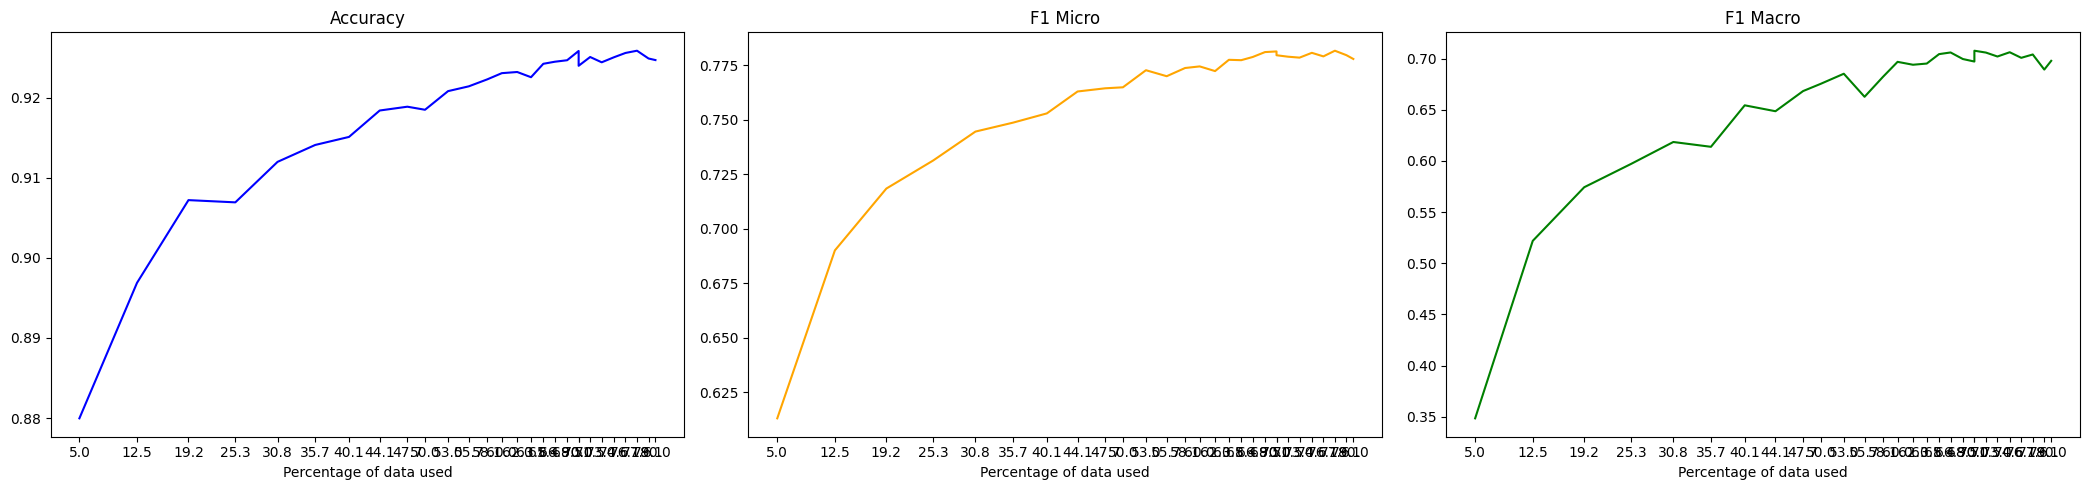

In [ ]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: [3, 44, 85]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5491, Accuracy: 0.8289, F1 Micro: 0.0306, F1 Macro: 0.0129
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4208, Accuracy: 0.834, F1 Micro: 0.1005, F1 Macro: 0.0359
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3922, Accuracy: 0.8387, F1 Micro: 0.1585, F1 Macro: 0.0546
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3713, Accuracy: 0.8584, F1 Micro: 0.3786, F1 Macro: 0.1292
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3385, Accuracy: 0.8753, F1 Micro: 0.543, F1 Macro: 0.2484
Epoch 6/10, Train Loss: 0.2825, Accuracy: 0.8763, F1 Micro: 0.5213, F1 Macro: 0.2401
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2593, Accuracy: 0.876, F1 Micro: 0.6157, F1 Macro: 0.3145
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2339, Accuracy: 0.8811, F1 Micro: 0.6249, F1 Macro: 0.3345
Epoch 9/10, Train Loss: 0.1932, Accuracy: 0.8825, F1 Micro: 0.5928, F1 Macro: 0.3207
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5304, Accuracy: 0.8322, F1 Micro: 0.1081, F1 Macro: 0.0369
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4119, Accuracy: 0.8348, F1 Micro: 0.1161, F1 Macro: 0.041
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3853, Accuracy: 0.8421, F1 Micro: 0.1873, F1 Macro: 0.0689
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3658, Accuracy: 0.8578, F1 Micro: 0.3663, F1 Macro: 0.1246
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3301, Accuracy: 0.8746, F1 Micro: 0.5543, F1 Macro: 0.2532
Epoch 6/10, Train Loss: 0.2728, Accuracy: 0.876, F1 Micro: 0.5368, F1 Macro: 0.2593
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2509, Accuracy: 0.8686, F1 Micro: 0.6215, F1 Macro: 0.3486
Epoch 8/10, Train Loss: 0.2243, Accuracy: 0.8785, F1 Micro: 0.6117, F1 Macro: 0.3553
Epoch 9/10, Train Loss: 0.1855, Accuracy: 0.8783, F1 Micro: 0.5886, F1 Macro: 0.3502
Epoch 10/10, Train Loss: 0.1751, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.543, Accuracy: 0.829, F1 Micro: 0.0251, F1 Macro: 0.0108
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4348, Accuracy: 0.8315, F1 Micro: 0.0536, F1 Macro: 0.0218
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.399, Accuracy: 0.838, F1 Micro: 0.1576, F1 Macro: 0.0517
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3805, Accuracy: 0.8491, F1 Micro: 0.272, F1 Macro: 0.0938
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3531, Accuracy: 0.8665, F1 Micro: 0.4398, F1 Macro: 0.1871
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2961, Accuracy: 0.8737, F1 Micro: 0.5013, F1 Macro: 0.2322
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2693, Accuracy: 0.8773, F1 Micro: 0.5913, F1 Macro: 0.296
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2417, Accuracy: 0.8767, F1 Micro: 0.5973, F1 Macro: 0.3192
Epoch 9/10, Train Loss: 0.201, Accuracy: 0.8762, F1 Micro: 0.5

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4658, Accuracy: 0.8376, F1 Micro: 0.1565, F1 Macro: 0.0541
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3676, Accuracy: 0.8574, F1 Micro: 0.3495, F1 Macro: 0.1302
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3123, Accuracy: 0.8811, F1 Micro: 0.5817, F1 Macro: 0.2912
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.261, Accuracy: 0.8901, F1 Micro: 0.6259, F1 Macro: 0.3431
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2237, Accuracy: 0.8921, F1 Micro: 0.6557, F1 Macro: 0.4464
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.191, Accuracy: 0.8933, F1 Micro: 0.6772, F1 Macro: 0.4643
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1643, Accuracy: 0.8928, F1 Micro: 0.6902, F1 Macro: 0.5068
Epoch 8/10, Train Loss: 0.1406, Accuracy: 0.8911, F1 Micro: 0.6411, F1 Macro: 0.4666
Epoch 9/10, Train Loss: 0.1161, Accuracy: 0.8955, F1 Micro: 0.6832, F1 Macro: 0.512
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4556, Accuracy: 0.8468, F1 Micro: 0.2687, F1 Macro: 0.091
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.364, Accuracy: 0.8606, F1 Micro: 0.3887, F1 Macro: 0.1506
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3089, Accuracy: 0.8825, F1 Micro: 0.5932, F1 Macro: 0.3161
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2581, Accuracy: 0.8909, F1 Micro: 0.6308, F1 Macro: 0.3849
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2212, Accuracy: 0.8924, F1 Micro: 0.6632, F1 Macro: 0.4724
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1895, Accuracy: 0.8932, F1 Micro: 0.665, F1 Macro: 0.4769
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1652, Accuracy: 0.8956, F1 Micro: 0.6819, F1 Macro: 0.5055
Epoch 8/10, Train Loss: 0.1381, Accuracy: 0.8912, F1 Micro: 0.6396, F1 Macro: 0.4832
Epoch 9/10, Train Loss: 0.1138, Accuracy: 0.895, F1 Micro: 0.6568, F1 Macro: 0.4803
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4703, Accuracy: 0.8316, F1 Micro: 0.0517, F1 Macro: 0.0215
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3739, Accuracy: 0.8565, F1 Micro: 0.3474, F1 Macro: 0.1317
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3212, Accuracy: 0.879, F1 Micro: 0.5605, F1 Macro: 0.2684
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2673, Accuracy: 0.888, F1 Micro: 0.6198, F1 Macro: 0.3561
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2259, Accuracy: 0.8908, F1 Micro: 0.6496, F1 Macro: 0.4531
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1903, Accuracy: 0.8918, F1 Micro: 0.6714, F1 Macro: 0.4798
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1663, Accuracy: 0.8926, F1 Micro: 0.683, F1 Macro: 0.4942
Epoch 8/10, Train Loss: 0.144, Accuracy: 0.8932, F1 Micro: 0.6604, F1 Macro: 0.4964
Epoch 9/10, Train Loss: 0.1172, Accuracy: 0.897, F1 Micro: 0.67, F1 Macro: 0.5002
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.445, Accuracy: 0.8561, F1 Micro: 0.385, F1 Macro: 0.1176
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3341, Accuracy: 0.8838, F1 Micro: 0.5863, F1 Macro: 0.2827
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2742, Accuracy: 0.8948, F1 Micro: 0.6518, F1 Macro: 0.4003
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2211, Accuracy: 0.8996, F1 Micro: 0.6705, F1 Macro: 0.4669
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1896, Accuracy: 0.8994, F1 Micro: 0.7105, F1 Macro: 0.5321
Epoch 6/10, Train Loss: 0.1519, Accuracy: 0.9031, F1 Micro: 0.7081, F1 Macro: 0.5189
Epoch 7/10, Train Loss: 0.1289, Accuracy: 0.9022, F1 Micro: 0.693, F1 Macro: 0.5063
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1115, Accuracy: 0.9026, F1 Micro: 0.7225, F1 Macro: 0.5561
Epoch 9/10, Train Loss: 0.0902, Accuracy: 0.9017, F1 Micro: 0.704, F1 Macro: 0.5581
Epoch 10/10, Train Loss: 0.0789, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.437, Accuracy: 0.8568, F1 Micro: 0.3951, F1 Macro: 0.1195
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3308, Accuracy: 0.8841, F1 Micro: 0.5904, F1 Macro: 0.3336
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2728, Accuracy: 0.8957, F1 Micro: 0.6567, F1 Macro: 0.3839
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2233, Accuracy: 0.8981, F1 Micro: 0.6964, F1 Macro: 0.4852
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1877, Accuracy: 0.899, F1 Micro: 0.7165, F1 Macro: 0.5523
Epoch 6/10, Train Loss: 0.1548, Accuracy: 0.8991, F1 Micro: 0.7163, F1 Macro: 0.5585
Epoch 7/10, Train Loss: 0.1293, Accuracy: 0.903, F1 Micro: 0.7093, F1 Macro: 0.5486
Epoch 8/10, Train Loss: 0.109, Accuracy: 0.9038, F1 Micro: 0.6974, F1 Macro: 0.5254
Epoch 9/10, Train Loss: 0.0901, Accuracy: 0.8996, F1 Micro: 0.6939, F1 Macro: 0.5496
Epoch 10/10, Train Loss: 0.0797, Accuracy: 0.8994, F1 Micro: 0.7159, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4511, Accuracy: 0.8458, F1 Micro: 0.2509, F1 Macro: 0.0851
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3451, Accuracy: 0.8819, F1 Micro: 0.5824, F1 Macro: 0.2861
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2794, Accuracy: 0.8925, F1 Micro: 0.6362, F1 Macro: 0.3702
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2254, Accuracy: 0.8992, F1 Micro: 0.692, F1 Macro: 0.4941
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1896, Accuracy: 0.8973, F1 Micro: 0.7135, F1 Macro: 0.5357
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1551, Accuracy: 0.9036, F1 Micro: 0.7165, F1 Macro: 0.5471
Epoch 7/10, Train Loss: 0.1279, Accuracy: 0.9021, F1 Micro: 0.7153, F1 Macro: 0.5423
Epoch 8/10, Train Loss: 0.1079, Accuracy: 0.905, F1 Micro: 0.7089, F1 Macro: 0.5405
Epoch 9/10, Train Loss: 0.0888, Accuracy: 0.903, F1 Micro: 0.7122, F1 Macro: 0.5613
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4221, Accuracy: 0.8704, F1 Micro: 0.4867, F1 Macro: 0.1964
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3047, Accuracy: 0.8895, F1 Micro: 0.6699, F1 Macro: 0.4016
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2423, Accuracy: 0.8997, F1 Micro: 0.6982, F1 Macro: 0.4771
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2003, Accuracy: 0.9007, F1 Micro: 0.7015, F1 Macro: 0.5275
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1657, Accuracy: 0.9019, F1 Micro: 0.7123, F1 Macro: 0.5641
Epoch 6/10, Train Loss: 0.1437, Accuracy: 0.9035, F1 Micro: 0.6705, F1 Macro: 0.5236
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1125, Accuracy: 0.9078, F1 Micro: 0.7207, F1 Macro: 0.5736
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.097, Accuracy: 0.9106, F1 Micro: 0.7327, F1 Macro: 0.6023
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0777, Accuracy: 0.9113, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4155, Accuracy: 0.8693, F1 Micro: 0.4784, F1 Macro: 0.1931
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3016, Accuracy: 0.8895, F1 Micro: 0.6764, F1 Macro: 0.4416
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.241, Accuracy: 0.898, F1 Micro: 0.7056, F1 Macro: 0.528
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1959, Accuracy: 0.9034, F1 Micro: 0.7132, F1 Macro: 0.5571
Epoch 5/10, Train Loss: 0.1666, Accuracy: 0.9062, F1 Micro: 0.6993, F1 Macro: 0.5538
Epoch 6/10, Train Loss: 0.1378, Accuracy: 0.9049, F1 Micro: 0.7005, F1 Macro: 0.5248
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1078, Accuracy: 0.9063, F1 Micro: 0.7196, F1 Macro: 0.573
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.088, Accuracy: 0.9091, F1 Micro: 0.7305, F1 Macro: 0.59
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0778, Accuracy: 0.9125, F1 Micro: 0.7308, F1 Macro: 0.5985
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4278, Accuracy: 0.8635, F1 Micro: 0.4459, F1 Macro: 0.1731
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3102, Accuracy: 0.8898, F1 Micro: 0.6696, F1 Macro: 0.4271
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2454, Accuracy: 0.8983, F1 Micro: 0.6992, F1 Macro: 0.5013
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1978, Accuracy: 0.9026, F1 Micro: 0.7063, F1 Macro: 0.543
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.165, Accuracy: 0.9014, F1 Micro: 0.7216, F1 Macro: 0.5713
Epoch 6/10, Train Loss: 0.1415, Accuracy: 0.9042, F1 Micro: 0.6826, F1 Macro: 0.5148
Epoch 7/10, Train Loss: 0.1102, Accuracy: 0.9051, F1 Micro: 0.7166, F1 Macro: 0.5705
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.091, Accuracy: 0.912, F1 Micro: 0.7312, F1 Macro: 0.5862
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0779, Accuracy: 0.9113, F1 Micro: 0.7374, F1 Macro: 0.6073
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.411, Accuracy: 0.8794, F1 Micro: 0.5781, F1 Macro: 0.2642
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2937, Accuracy: 0.8921, F1 Micro: 0.681, F1 Macro: 0.4716
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2324, Accuracy: 0.9033, F1 Micro: 0.6891, F1 Macro: 0.4994
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.193, Accuracy: 0.9073, F1 Micro: 0.7083, F1 Macro: 0.5411
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1561, Accuracy: 0.9063, F1 Micro: 0.7344, F1 Macro: 0.591
Epoch 6/10, Train Loss: 0.1274, Accuracy: 0.9091, F1 Micro: 0.73, F1 Macro: 0.5889
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1045, Accuracy: 0.9078, F1 Micro: 0.7362, F1 Macro: 0.5937
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0842, Accuracy: 0.9134, F1 Micro: 0.7396, F1 Macro: 0.6356
Epoch 9/10, Train Loss: 0.0694, Accuracy: 0.9124, F1 Micro: 0.7328, F1 Macro: 0.6381
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4061, Accuracy: 0.8784, F1 Micro: 0.5771, F1 Macro: 0.2654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2899, Accuracy: 0.8948, F1 Micro: 0.6875, F1 Macro: 0.4883
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2332, Accuracy: 0.904, F1 Micro: 0.6961, F1 Macro: 0.5199
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1906, Accuracy: 0.9076, F1 Micro: 0.7141, F1 Macro: 0.5572
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.154, Accuracy: 0.9077, F1 Micro: 0.7245, F1 Macro: 0.5838
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1289, Accuracy: 0.9107, F1 Micro: 0.728, F1 Macro: 0.5825
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1002, Accuracy: 0.9063, F1 Micro: 0.7326, F1 Macro: 0.594
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0842, Accuracy: 0.9119, F1 Micro: 0.7389, F1 Macro: 0.6215
Epoch 9/10, Train Loss: 0.0737, Accuracy: 0.9116, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4184, Accuracy: 0.8764, F1 Micro: 0.5533, F1 Macro: 0.2508
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2962, Accuracy: 0.8941, F1 Micro: 0.6816, F1 Macro: 0.4918
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2348, Accuracy: 0.9037, F1 Micro: 0.7008, F1 Macro: 0.5079
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1933, Accuracy: 0.906, F1 Micro: 0.7145, F1 Macro: 0.5511
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1567, Accuracy: 0.9077, F1 Micro: 0.7285, F1 Macro: 0.5846
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.126, Accuracy: 0.9083, F1 Micro: 0.7356, F1 Macro: 0.5862
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1077, Accuracy: 0.9055, F1 Micro: 0.7361, F1 Macro: 0.604
Epoch 8/10, Train Loss: 0.0856, Accuracy: 0.9132, F1 Micro: 0.7333, F1 Macro: 0.622
Epoch 9/10, Train Loss: 0.0751, Accuracy: 0.9124, F1 Micro: 0.7333, F1 Macro: 0.6152
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3958, Accuracy: 0.8792, F1 Micro: 0.5909, F1 Macro: 0.2824
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2762, Accuracy: 0.8984, F1 Micro: 0.6926, F1 Macro: 0.4636
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2248, Accuracy: 0.904, F1 Micro: 0.7123, F1 Macro: 0.5323
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1912, Accuracy: 0.9106, F1 Micro: 0.7262, F1 Macro: 0.5718
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1496, Accuracy: 0.9111, F1 Micro: 0.7438, F1 Macro: 0.6041
Epoch 6/10, Train Loss: 0.1195, Accuracy: 0.915, F1 Micro: 0.7347, F1 Macro: 0.6075
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0948, Accuracy: 0.9108, F1 Micro: 0.7522, F1 Macro: 0.6395
Epoch 8/10, Train Loss: 0.0858, Accuracy: 0.9142, F1 Micro: 0.7498, F1 Macro: 0.6348
Epoch 9/10, Train Loss: 0.0692, Accuracy: 0.9157, F1 Micro: 0.7433, F1 Macro: 0.6586
Epoch 10/10, Train Loss: 0.0551, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3918, Accuracy: 0.8794, F1 Micro: 0.6137, F1 Macro: 0.3151
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2731, Accuracy: 0.8996, F1 Micro: 0.7031, F1 Macro: 0.5244
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2253, Accuracy: 0.9062, F1 Micro: 0.7115, F1 Macro: 0.5522
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.192, Accuracy: 0.911, F1 Micro: 0.7233, F1 Macro: 0.5767
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1507, Accuracy: 0.9094, F1 Micro: 0.7308, F1 Macro: 0.5878
Epoch 6/10, Train Loss: 0.1211, Accuracy: 0.9136, F1 Micro: 0.725, F1 Macro: 0.5885
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0987, Accuracy: 0.9105, F1 Micro: 0.7419, F1 Macro: 0.6183
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0813, Accuracy: 0.9123, F1 Micro: 0.7422, F1 Macro: 0.6218
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0696, Accuracy: 0.9134, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.402, Accuracy: 0.8763, F1 Micro: 0.5966, F1 Macro: 0.2853
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2807, Accuracy: 0.898, F1 Micro: 0.6946, F1 Macro: 0.4771
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2263, Accuracy: 0.9047, F1 Micro: 0.7087, F1 Macro: 0.5329
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1906, Accuracy: 0.9111, F1 Micro: 0.7283, F1 Macro: 0.5807
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1497, Accuracy: 0.9146, F1 Micro: 0.7509, F1 Macro: 0.6021
Epoch 6/10, Train Loss: 0.1226, Accuracy: 0.9143, F1 Micro: 0.7348, F1 Macro: 0.594
Epoch 7/10, Train Loss: 0.0989, Accuracy: 0.9103, F1 Micro: 0.7449, F1 Macro: 0.6244
Epoch 8/10, Train Loss: 0.0845, Accuracy: 0.915, F1 Micro: 0.743, F1 Macro: 0.6162
Epoch 9/10, Train Loss: 0.07, Accuracy: 0.9141, F1 Micro: 0.7364, F1 Macro: 0.6346
Epoch 10/10, Train Loss: 0.0588, Accuracy: 0.9145, F1 Micro: 0.7375, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3873, Accuracy: 0.8774, F1 Micro: 0.6529, F1 Macro: 0.3503
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2664, Accuracy: 0.9012, F1 Micro: 0.6822, F1 Macro: 0.4567
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2222, Accuracy: 0.9069, F1 Micro: 0.6872, F1 Macro: 0.522
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.182, Accuracy: 0.9142, F1 Micro: 0.7352, F1 Macro: 0.5656
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1476, Accuracy: 0.9098, F1 Micro: 0.7497, F1 Macro: 0.6113
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1217, Accuracy: 0.9162, F1 Micro: 0.7531, F1 Macro: 0.6192
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0948, Accuracy: 0.9184, F1 Micro: 0.7613, F1 Macro: 0.6603
Epoch 8/10, Train Loss: 0.0818, Accuracy: 0.9165, F1 Micro: 0.7548, F1 Macro: 0.6614
Epoch 9/10, Train Loss: 0.0657, Accuracy: 0.9172, F1 Micro: 0.7525, F1 Macro: 0.6641
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3812, Accuracy: 0.8786, F1 Micro: 0.657, F1 Macro: 0.3805
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2633, Accuracy: 0.9021, F1 Micro: 0.6879, F1 Macro: 0.4802
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2191, Accuracy: 0.9095, F1 Micro: 0.7016, F1 Macro: 0.5369
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1798, Accuracy: 0.9122, F1 Micro: 0.7392, F1 Macro: 0.5742
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1456, Accuracy: 0.9113, F1 Micro: 0.7471, F1 Macro: 0.6027
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1215, Accuracy: 0.9174, F1 Micro: 0.7518, F1 Macro: 0.6046
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0922, Accuracy: 0.9167, F1 Micro: 0.7523, F1 Macro: 0.6419
Epoch 8/10, Train Loss: 0.0792, Accuracy: 0.9126, F1 Micro: 0.7479, F1 Macro: 0.6249
Epoch 9/10, Train Loss: 0.0674, Accuracy: 0.9132, F1 Micro: 0.7483, F1 Macro: 0.6538
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3927, Accuracy: 0.8797, F1 Micro: 0.6444, F1 Macro: 0.3382
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2672, Accuracy: 0.9006, F1 Micro: 0.6838, F1 Macro: 0.4594
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2196, Accuracy: 0.9076, F1 Micro: 0.6957, F1 Macro: 0.5481
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1773, Accuracy: 0.9134, F1 Micro: 0.7319, F1 Macro: 0.5714
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1455, Accuracy: 0.9125, F1 Micro: 0.7502, F1 Macro: 0.6053
Epoch 6/10, Train Loss: 0.1223, Accuracy: 0.9146, F1 Micro: 0.7399, F1 Macro: 0.597
Epoch 7/10, Train Loss: 0.0915, Accuracy: 0.9161, F1 Micro: 0.7483, F1 Macro: 0.6434
Epoch 8/10, Train Loss: 0.0804, Accuracy: 0.9162, F1 Micro: 0.7471, F1 Macro: 0.6434
Epoch 9/10, Train Loss: 0.0641, Accuracy: 0.9129, F1 Micro: 0.749, F1 Macro: 0.634
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0577, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3852, Accuracy: 0.8857, F1 Micro: 0.6218, F1 Macro: 0.3159
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2645, Accuracy: 0.9012, F1 Micro: 0.7021, F1 Macro: 0.5003
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2109, Accuracy: 0.9099, F1 Micro: 0.704, F1 Macro: 0.5356
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1693, Accuracy: 0.9163, F1 Micro: 0.742, F1 Macro: 0.5853
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1376, Accuracy: 0.9111, F1 Micro: 0.7547, F1 Macro: 0.6407
Epoch 6/10, Train Loss: 0.1147, Accuracy: 0.9158, F1 Micro: 0.7513, F1 Macro: 0.6247
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0899, Accuracy: 0.9179, F1 Micro: 0.7565, F1 Macro: 0.6606
Epoch 8/10, Train Loss: 0.0741, Accuracy: 0.9122, F1 Micro: 0.754, F1 Macro: 0.671
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0602, Accuracy: 0.9202, F1 Micro: 0.7576, F1 Macro: 0.6888
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3798, Accuracy: 0.8853, F1 Micro: 0.632, F1 Macro: 0.3431
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.263, Accuracy: 0.902, F1 Micro: 0.7046, F1 Macro: 0.5285
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2099, Accuracy: 0.911, F1 Micro: 0.7143, F1 Macro: 0.5591
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1735, Accuracy: 0.915, F1 Micro: 0.7329, F1 Macro: 0.5774
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1424, Accuracy: 0.9181, F1 Micro: 0.7607, F1 Macro: 0.6355
Epoch 6/10, Train Loss: 0.1171, Accuracy: 0.9168, F1 Micro: 0.7481, F1 Macro: 0.6179
Epoch 7/10, Train Loss: 0.0917, Accuracy: 0.9148, F1 Micro: 0.7575, F1 Macro: 0.6766
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0772, Accuracy: 0.9177, F1 Micro: 0.7619, F1 Macro: 0.6706
Epoch 9/10, Train Loss: 0.0607, Accuracy: 0.921, F1 Micro: 0.7578, F1 Macro: 0.6809
Higher F1 achieved, saving model
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3909, Accuracy: 0.884, F1 Micro: 0.6144, F1 Macro: 0.3069
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2675, Accuracy: 0.9001, F1 Micro: 0.7066, F1 Macro: 0.5095
Epoch 3/10, Train Loss: 0.2095, Accuracy: 0.9094, F1 Micro: 0.7013, F1 Macro: 0.5388
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1719, Accuracy: 0.9164, F1 Micro: 0.7396, F1 Macro: 0.5758
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.137, Accuracy: 0.9136, F1 Micro: 0.7535, F1 Macro: 0.6429
Epoch 6/10, Train Loss: 0.1134, Accuracy: 0.9151, F1 Micro: 0.737, F1 Macro: 0.6027
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0891, Accuracy: 0.9168, F1 Micro: 0.7604, F1 Macro: 0.669
Epoch 8/10, Train Loss: 0.0738, Accuracy: 0.9109, F1 Micro: 0.7569, F1 Macro: 0.6678
Epoch 9/10, Train Loss: 0.0634, Accuracy: 0.9142, F1 Micro: 0.7547, F1 Macro: 0.6622
Epoch 10/10, Train Loss: 0.0537, Accuracy: 0.9166, F1 Micro: 0.7538, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3732, Accuracy: 0.8902, F1 Micro: 0.648, F1 Macro: 0.3621
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.26, Accuracy: 0.9056, F1 Micro: 0.7184, F1 Macro: 0.5176
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2105, Accuracy: 0.9098, F1 Micro: 0.7371, F1 Macro: 0.5762
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1669, Accuracy: 0.9077, F1 Micro: 0.7505, F1 Macro: 0.6045
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1349, Accuracy: 0.9134, F1 Micro: 0.7566, F1 Macro: 0.6185
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1088, Accuracy: 0.9187, F1 Micro: 0.7586, F1 Macro: 0.6404
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0861, Accuracy: 0.9193, F1 Micro: 0.7594, F1 Macro: 0.6675
Epoch 8/10, Train Loss: 0.0742, Accuracy: 0.9162, F1 Micro: 0.7582, F1 Macro: 0.6879
Epoch 9/10, Train Loss: 0.0588, Accuracy: 0.9184, F1 Micro: 0.757, F1 Macro: 0.6781
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3678, Accuracy: 0.8916, F1 Micro: 0.6471, F1 Macro: 0.409
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2572, Accuracy: 0.9051, F1 Micro: 0.72, F1 Macro: 0.5252
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2098, Accuracy: 0.9113, F1 Micro: 0.7413, F1 Macro: 0.5863
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.166, Accuracy: 0.9118, F1 Micro: 0.754, F1 Macro: 0.6026
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1356, Accuracy: 0.9184, F1 Micro: 0.7591, F1 Macro: 0.6197
Epoch 6/10, Train Loss: 0.1078, Accuracy: 0.92, F1 Micro: 0.7582, F1 Macro: 0.6348
Epoch 7/10, Train Loss: 0.0878, Accuracy: 0.9194, F1 Micro: 0.7454, F1 Macro: 0.6293
Epoch 8/10, Train Loss: 0.0761, Accuracy: 0.9163, F1 Micro: 0.7509, F1 Macro: 0.6448
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0615, Accuracy: 0.9203, F1 Micro: 0.7675, F1 Macro: 0.6837
Epoch 10/10, Train Loss: 0.0516, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.38, Accuracy: 0.8868, F1 Micro: 0.6178, F1 Macro: 0.3268
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2609, Accuracy: 0.9056, F1 Micro: 0.7077, F1 Macro: 0.4945
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2082, Accuracy: 0.9125, F1 Micro: 0.7409, F1 Macro: 0.5814
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1661, Accuracy: 0.9122, F1 Micro: 0.7537, F1 Macro: 0.6083
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1355, Accuracy: 0.9176, F1 Micro: 0.7609, F1 Macro: 0.6271
Epoch 6/10, Train Loss: 0.1086, Accuracy: 0.9199, F1 Micro: 0.757, F1 Macro: 0.6208
Epoch 7/10, Train Loss: 0.0861, Accuracy: 0.9196, F1 Micro: 0.7603, F1 Macro: 0.6449
Epoch 8/10, Train Loss: 0.0748, Accuracy: 0.9167, F1 Micro: 0.7537, F1 Macro: 0.6639
Epoch 9/10, Train Loss: 0.0651, Accuracy: 0.919, F1 Micro: 0.7557, F1 Macro: 0.6775
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0526, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3704, Accuracy: 0.884, F1 Micro: 0.6651, F1 Macro: 0.3729
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2483, Accuracy: 0.9072, F1 Micro: 0.7067, F1 Macro: 0.4921
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2043, Accuracy: 0.9153, F1 Micro: 0.7434, F1 Macro: 0.5741
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1624, Accuracy: 0.9152, F1 Micro: 0.7457, F1 Macro: 0.596
Epoch 5/10, Train Loss: 0.1287, Accuracy: 0.917, F1 Micro: 0.741, F1 Macro: 0.6354
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1101, Accuracy: 0.9184, F1 Micro: 0.7584, F1 Macro: 0.6724
Epoch 7/10, Train Loss: 0.0878, Accuracy: 0.9188, F1 Micro: 0.7528, F1 Macro: 0.6516
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0678, Accuracy: 0.9191, F1 Micro: 0.7591, F1 Macro: 0.6812
Epoch 9/10, Train Loss: 0.0598, Accuracy: 0.918, F1 Micro: 0.7576, F1 Macro: 0.6839
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3638, Accuracy: 0.8903, F1 Micro: 0.6545, F1 Macro: 0.4007
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2501, Accuracy: 0.9072, F1 Micro: 0.7108, F1 Macro: 0.5201
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2053, Accuracy: 0.9147, F1 Micro: 0.7416, F1 Macro: 0.5836
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1625, Accuracy: 0.9157, F1 Micro: 0.7444, F1 Macro: 0.5958
Epoch 5/10, Train Loss: 0.1289, Accuracy: 0.9172, F1 Micro: 0.7391, F1 Macro: 0.6061
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1104, Accuracy: 0.9157, F1 Micro: 0.762, F1 Macro: 0.6685
Epoch 7/10, Train Loss: 0.0863, Accuracy: 0.9184, F1 Micro: 0.7588, F1 Macro: 0.6621
Epoch 8/10, Train Loss: 0.0669, Accuracy: 0.9179, F1 Micro: 0.7592, F1 Macro: 0.6756
Epoch 9/10, Train Loss: 0.0596, Accuracy: 0.9181, F1 Micro: 0.7609, F1 Macro: 0.6905
Epoch 10/10, Train Loss: 0.0491, Accuracy: 0.9182, F1 Micro: 0.759, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3754, Accuracy: 0.8856, F1 Micro: 0.6596, F1 Macro: 0.3814
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2505, Accuracy: 0.9063, F1 Micro: 0.7075, F1 Macro: 0.5102
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2062, Accuracy: 0.9128, F1 Micro: 0.7306, F1 Macro: 0.5623
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1614, Accuracy: 0.9158, F1 Micro: 0.7411, F1 Macro: 0.594
Epoch 5/10, Train Loss: 0.1311, Accuracy: 0.9165, F1 Micro: 0.7364, F1 Macro: 0.6149
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1124, Accuracy: 0.9173, F1 Micro: 0.7629, F1 Macro: 0.6588
Epoch 7/10, Train Loss: 0.0877, Accuracy: 0.9182, F1 Micro: 0.7567, F1 Macro: 0.6457
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0709, Accuracy: 0.9155, F1 Micro: 0.7639, F1 Macro: 0.6753
Epoch 9/10, Train Loss: 0.0627, Accuracy: 0.9156, F1 Micro: 0.7473, F1 Macro: 0.6637
Epoch 10/10, Train Loss: 0.0516, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3644, Accuracy: 0.8915, F1 Micro: 0.6329, F1 Macro: 0.3795
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2492, Accuracy: 0.9054, F1 Micro: 0.6915, F1 Macro: 0.487
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1999, Accuracy: 0.9125, F1 Micro: 0.7193, F1 Macro: 0.5451
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.159, Accuracy: 0.9195, F1 Micro: 0.7611, F1 Macro: 0.6336
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1268, Accuracy: 0.9182, F1 Micro: 0.762, F1 Macro: 0.6564
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1027, Accuracy: 0.9213, F1 Micro: 0.7655, F1 Macro: 0.6463
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0845, Accuracy: 0.9225, F1 Micro: 0.7729, F1 Macro: 0.6889
Epoch 8/10, Train Loss: 0.0695, Accuracy: 0.9189, F1 Micro: 0.7709, F1 Macro: 0.6833
Epoch 9/10, Train Loss: 0.0587, Accuracy: 0.9217, F1 Micro: 0.7712, F1 Macro: 0.6932
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3601, Accuracy: 0.892, F1 Micro: 0.6441, F1 Macro: 0.4242
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2466, Accuracy: 0.9067, F1 Micro: 0.6969, F1 Macro: 0.4955
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1997, Accuracy: 0.9143, F1 Micro: 0.7309, F1 Macro: 0.5501
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.16, Accuracy: 0.9182, F1 Micro: 0.7591, F1 Macro: 0.6302
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1252, Accuracy: 0.9176, F1 Micro: 0.7596, F1 Macro: 0.653
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1036, Accuracy: 0.9202, F1 Micro: 0.7599, F1 Macro: 0.6534
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0844, Accuracy: 0.9192, F1 Micro: 0.7671, F1 Macro: 0.6916
Epoch 8/10, Train Loss: 0.0679, Accuracy: 0.9183, F1 Micro: 0.767, F1 Macro: 0.6929
Epoch 9/10, Train Loss: 0.0577, Accuracy: 0.9166, F1 Micro: 0.7627, F1 Macro: 0.6897
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3705, Accuracy: 0.8883, F1 Micro: 0.6191, F1 Macro: 0.3649
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2499, Accuracy: 0.9038, F1 Micro: 0.6743, F1 Macro: 0.4629
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1992, Accuracy: 0.9138, F1 Micro: 0.7196, F1 Macro: 0.5568
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1582, Accuracy: 0.9208, F1 Micro: 0.7562, F1 Macro: 0.6238
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1279, Accuracy: 0.9181, F1 Micro: 0.761, F1 Macro: 0.6626
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1053, Accuracy: 0.9209, F1 Micro: 0.7634, F1 Macro: 0.6456
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0876, Accuracy: 0.9191, F1 Micro: 0.7685, F1 Macro: 0.6755
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0693, Accuracy: 0.9205, F1 Micro: 0.7689, F1 Macro: 0.6864
Epoch 9/10, Train Loss: 0.0585, Accuracy: 0.9193, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3631, Accuracy: 0.8906, F1 Micro: 0.6169, F1 Macro: 0.3782
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2495, Accuracy: 0.9086, F1 Micro: 0.714, F1 Macro: 0.5369
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2025, Accuracy: 0.9146, F1 Micro: 0.7444, F1 Macro: 0.5814
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1614, Accuracy: 0.9204, F1 Micro: 0.7566, F1 Macro: 0.6182
Epoch 5/10, Train Loss: 0.1308, Accuracy: 0.9101, F1 Micro: 0.7556, F1 Macro: 0.6625
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1028, Accuracy: 0.9195, F1 Micro: 0.767, F1 Macro: 0.6808
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.081, Accuracy: 0.9209, F1 Micro: 0.7726, F1 Macro: 0.6903
Epoch 8/10, Train Loss: 0.0678, Accuracy: 0.9178, F1 Micro: 0.7642, F1 Macro: 0.6905
Epoch 9/10, Train Loss: 0.0552, Accuracy: 0.9194, F1 Micro: 0.7689, F1 Macro: 0.6989
Epoch 10/10, Train Loss: 0.0447, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3594, Accuracy: 0.8925, F1 Micro: 0.6267, F1 Macro: 0.4037
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2489, Accuracy: 0.9082, F1 Micro: 0.7092, F1 Macro: 0.5248
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2026, Accuracy: 0.9162, F1 Micro: 0.7388, F1 Macro: 0.5699
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1599, Accuracy: 0.917, F1 Micro: 0.7523, F1 Macro: 0.6157
Epoch 5/10, Train Loss: 0.1307, Accuracy: 0.908, F1 Micro: 0.7498, F1 Macro: 0.661
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1048, Accuracy: 0.9212, F1 Micro: 0.7538, F1 Macro: 0.6588
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0833, Accuracy: 0.9188, F1 Micro: 0.7663, F1 Macro: 0.6825
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0688, Accuracy: 0.9215, F1 Micro: 0.7675, F1 Macro: 0.6832
Epoch 9/10, Train Loss: 0.0548, Accuracy: 0.9191, F1 Micro: 0.7621, F1 Macro: 0.6847
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3696, Accuracy: 0.8892, F1 Micro: 0.6125, F1 Macro: 0.3798
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2509, Accuracy: 0.9079, F1 Micro: 0.7105, F1 Macro: 0.5381
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.202, Accuracy: 0.9157, F1 Micro: 0.7476, F1 Macro: 0.587
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1609, Accuracy: 0.9193, F1 Micro: 0.7553, F1 Macro: 0.6226
Epoch 5/10, Train Loss: 0.1322, Accuracy: 0.9098, F1 Micro: 0.7521, F1 Macro: 0.6538
Epoch 6/10, Train Loss: 0.1026, Accuracy: 0.9195, F1 Micro: 0.7505, F1 Macro: 0.6563
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0836, Accuracy: 0.9211, F1 Micro: 0.7685, F1 Macro: 0.6846
Epoch 8/10, Train Loss: 0.0686, Accuracy: 0.9209, F1 Micro: 0.7635, F1 Macro: 0.6752
Epoch 9/10, Train Loss: 0.0565, Accuracy: 0.9189, F1 Micro: 0.7655, F1 Macro: 0.687
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0469, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3538, Accuracy: 0.8954, F1 Micro: 0.6682, F1 Macro: 0.4312
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2417, Accuracy: 0.9085, F1 Micro: 0.7296, F1 Macro: 0.5605
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1891, Accuracy: 0.9197, F1 Micro: 0.7556, F1 Macro: 0.6116
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1532, Accuracy: 0.9205, F1 Micro: 0.7676, F1 Macro: 0.6405
Epoch 5/10, Train Loss: 0.1193, Accuracy: 0.9221, F1 Micro: 0.7633, F1 Macro: 0.6632
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0991, Accuracy: 0.924, F1 Micro: 0.7736, F1 Macro: 0.6748
Epoch 7/10, Train Loss: 0.0783, Accuracy: 0.9172, F1 Micro: 0.7654, F1 Macro: 0.6876
Epoch 8/10, Train Loss: 0.0688, Accuracy: 0.9151, F1 Micro: 0.7662, F1 Macro: 0.6888
Epoch 9/10, Train Loss: 0.0556, Accuracy: 0.9228, F1 Micro: 0.7709, F1 Macro: 0.6983
Epoch 10/10, Train Loss: 0.0462, Accuracy: 0.9195, F1 Micro: 0.7701, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3511, Accuracy: 0.8962, F1 Micro: 0.6628, F1 Macro: 0.4372
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2415, Accuracy: 0.9085, F1 Micro: 0.7311, F1 Macro: 0.5689
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1903, Accuracy: 0.9181, F1 Micro: 0.7482, F1 Macro: 0.5925
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1523, Accuracy: 0.9151, F1 Micro: 0.7558, F1 Macro: 0.6336
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1197, Accuracy: 0.9229, F1 Micro: 0.7639, F1 Macro: 0.6439
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1021, Accuracy: 0.9215, F1 Micro: 0.7679, F1 Macro: 0.6788
Epoch 7/10, Train Loss: 0.0794, Accuracy: 0.9174, F1 Micro: 0.7657, F1 Macro: 0.6837
Epoch 8/10, Train Loss: 0.0677, Accuracy: 0.9192, F1 Micro: 0.7672, F1 Macro: 0.6898
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0549, Accuracy: 0.9233, F1 Micro: 0.7721, F1 Macro: 0.6939
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3578, Accuracy: 0.8953, F1 Micro: 0.668, F1 Macro: 0.4265
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2418, Accuracy: 0.9086, F1 Micro: 0.729, F1 Macro: 0.5608
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1895, Accuracy: 0.9187, F1 Micro: 0.7555, F1 Macro: 0.6011
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.153, Accuracy: 0.919, F1 Micro: 0.7577, F1 Macro: 0.6133
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1193, Accuracy: 0.92, F1 Micro: 0.7601, F1 Macro: 0.6393
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1017, Accuracy: 0.9221, F1 Micro: 0.7694, F1 Macro: 0.6847
Epoch 7/10, Train Loss: 0.0801, Accuracy: 0.9216, F1 Micro: 0.7666, F1 Macro: 0.6824
Epoch 8/10, Train Loss: 0.0683, Accuracy: 0.9208, F1 Micro: 0.7669, F1 Macro: 0.6812
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0575, Accuracy: 0.9238, F1 Micro: 0.7716, F1 Macro: 0.6946
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3563, Accuracy: 0.8952, F1 Micro: 0.6543, F1 Macro: 0.3785
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2403, Accuracy: 0.9087, F1 Micro: 0.73, F1 Macro: 0.5438
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.195, Accuracy: 0.9185, F1 Micro: 0.7494, F1 Macro: 0.6007
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1542, Accuracy: 0.9204, F1 Micro: 0.7652, F1 Macro: 0.6566
Epoch 5/10, Train Loss: 0.1191, Accuracy: 0.9236, F1 Micro: 0.764, F1 Macro: 0.6539
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0983, Accuracy: 0.9243, F1 Micro: 0.7706, F1 Macro: 0.6824
Epoch 7/10, Train Loss: 0.0775, Accuracy: 0.923, F1 Micro: 0.7706, F1 Macro: 0.6999
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.063, Accuracy: 0.9235, F1 Micro: 0.7714, F1 Macro: 0.6947
Epoch 9/10, Train Loss: 0.0507, Accuracy: 0.9237, F1 Micro: 0.7708, F1 Macro: 0.7046
Epoch 10/10, Train Loss: 0.0483, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.352, Accuracy: 0.8938, F1 Micro: 0.6342, F1 Macro: 0.3836
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2395, Accuracy: 0.9102, F1 Micro: 0.7248, F1 Macro: 0.5485
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1974, Accuracy: 0.9189, F1 Micro: 0.751, F1 Macro: 0.5971
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1543, Accuracy: 0.919, F1 Micro: 0.7651, F1 Macro: 0.6325
Epoch 5/10, Train Loss: 0.1224, Accuracy: 0.9186, F1 Micro: 0.75, F1 Macro: 0.6228
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0982, Accuracy: 0.919, F1 Micro: 0.7654, F1 Macro: 0.6623
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.078, Accuracy: 0.9225, F1 Micro: 0.7746, F1 Macro: 0.7038
Epoch 8/10, Train Loss: 0.0652, Accuracy: 0.9216, F1 Micro: 0.772, F1 Macro: 0.6961
Epoch 9/10, Train Loss: 0.0544, Accuracy: 0.9213, F1 Micro: 0.7601, F1 Macro: 0.6894
Epoch 10/10, Train Loss: 0.0498, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3596, Accuracy: 0.8921, F1 Micro: 0.6369, F1 Macro: 0.3765
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2395, Accuracy: 0.9108, F1 Micro: 0.7255, F1 Macro: 0.5389
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1957, Accuracy: 0.9169, F1 Micro: 0.7372, F1 Macro: 0.5976
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1533, Accuracy: 0.9173, F1 Micro: 0.7607, F1 Macro: 0.6379
Epoch 5/10, Train Loss: 0.1198, Accuracy: 0.9204, F1 Micro: 0.7492, F1 Macro: 0.6354
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0973, Accuracy: 0.9201, F1 Micro: 0.7623, F1 Macro: 0.6507
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0785, Accuracy: 0.9208, F1 Micro: 0.769, F1 Macro: 0.6829
Epoch 8/10, Train Loss: 0.0638, Accuracy: 0.92, F1 Micro: 0.7679, F1 Macro: 0.6781
Epoch 9/10, Train Loss: 0.0557, Accuracy: 0.9187, F1 Micro: 0.7576, F1 Macro: 0.6788
Epoch 10/10, Train Loss: 0.0489, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3535, Accuracy: 0.8933, F1 Micro: 0.6709, F1 Macro: 0.3953
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2399, Accuracy: 0.9113, F1 Micro: 0.7346, F1 Macro: 0.5567
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1965, Accuracy: 0.9191, F1 Micro: 0.745, F1 Macro: 0.5995
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1482, Accuracy: 0.9166, F1 Micro: 0.7656, F1 Macro: 0.6518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.123, Accuracy: 0.9219, F1 Micro: 0.7727, F1 Macro: 0.6694
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0964, Accuracy: 0.924, F1 Micro: 0.7745, F1 Macro: 0.694
Epoch 7/10, Train Loss: 0.0752, Accuracy: 0.9192, F1 Micro: 0.767, F1 Macro: 0.6816
Epoch 8/10, Train Loss: 0.0626, Accuracy: 0.9228, F1 Micro: 0.7718, F1 Macro: 0.697
Epoch 9/10, Train Loss: 0.0515, Accuracy: 0.9213, F1 Micro: 0.7702, F1 Macro: 0.6985
Epoch 10/10, Train Loss: 0.0442, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3502, Accuracy: 0.895, F1 Micro: 0.6779, F1 Macro: 0.4252
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2394, Accuracy: 0.9121, F1 Micro: 0.7315, F1 Macro: 0.5636
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1956, Accuracy: 0.9189, F1 Micro: 0.7395, F1 Macro: 0.5909
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1529, Accuracy: 0.9161, F1 Micro: 0.7622, F1 Macro: 0.6225
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.123, Accuracy: 0.9178, F1 Micro: 0.7676, F1 Macro: 0.6664
Epoch 6/10, Train Loss: 0.0978, Accuracy: 0.9174, F1 Micro: 0.765, F1 Macro: 0.6777
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0765, Accuracy: 0.9232, F1 Micro: 0.7733, F1 Macro: 0.6848
Epoch 8/10, Train Loss: 0.0643, Accuracy: 0.9228, F1 Micro: 0.7697, F1 Macro: 0.7012
Epoch 9/10, Train Loss: 0.0526, Accuracy: 0.9214, F1 Micro: 0.7727, F1 Macro: 0.7018
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3586, Accuracy: 0.8926, F1 Micro: 0.6733, F1 Macro: 0.4017
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2394, Accuracy: 0.9095, F1 Micro: 0.7286, F1 Macro: 0.5523
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1947, Accuracy: 0.9196, F1 Micro: 0.7449, F1 Macro: 0.6004
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1511, Accuracy: 0.9197, F1 Micro: 0.7662, F1 Macro: 0.6153
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1221, Accuracy: 0.9204, F1 Micro: 0.7709, F1 Macro: 0.6672
Epoch 6/10, Train Loss: 0.0953, Accuracy: 0.9209, F1 Micro: 0.7657, F1 Macro: 0.6747
Epoch 7/10, Train Loss: 0.0754, Accuracy: 0.9202, F1 Micro: 0.7675, F1 Macro: 0.6693
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0611, Accuracy: 0.9229, F1 Micro: 0.7736, F1 Macro: 0.6986
Epoch 9/10, Train Loss: 0.051, Accuracy: 0.9221, F1 Micro: 0.7704, F1 Macro: 0.7007
Epoch 10/10, Train Loss: 0.0482, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3559, Accuracy: 0.8964, F1 Micro: 0.655, F1 Macro: 0.4155
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2384, Accuracy: 0.9101, F1 Micro: 0.7157, F1 Macro: 0.518
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1877, Accuracy: 0.9217, F1 Micro: 0.7517, F1 Macro: 0.5979
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1518, Accuracy: 0.9239, F1 Micro: 0.7657, F1 Macro: 0.6554
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1201, Accuracy: 0.9248, F1 Micro: 0.7793, F1 Macro: 0.696
Epoch 6/10, Train Loss: 0.0915, Accuracy: 0.9258, F1 Micro: 0.7741, F1 Macro: 0.6952
Epoch 7/10, Train Loss: 0.0763, Accuracy: 0.9221, F1 Micro: 0.7748, F1 Macro: 0.7007
Epoch 8/10, Train Loss: 0.0635, Accuracy: 0.9213, F1 Micro: 0.7731, F1 Macro: 0.7047
Epoch 9/10, Train Loss: 0.0542, Accuracy: 0.9246, F1 Micro: 0.7762, F1 Macro: 0.7174
Epoch 10/10, Train Loss: 0.0437, Accuracy: 0.92, F1 Micro: 0.774, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.35, Accuracy: 0.8979, F1 Micro: 0.6652, F1 Macro: 0.4537
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2357, Accuracy: 0.9098, F1 Micro: 0.7292, F1 Macro: 0.5217
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1885, Accuracy: 0.9205, F1 Micro: 0.7517, F1 Macro: 0.6021
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1528, Accuracy: 0.9198, F1 Micro: 0.7647, F1 Macro: 0.6489
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1224, Accuracy: 0.9214, F1 Micro: 0.766, F1 Macro: 0.6682
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0917, Accuracy: 0.9231, F1 Micro: 0.7736, F1 Macro: 0.6873
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0783, Accuracy: 0.9222, F1 Micro: 0.7742, F1 Macro: 0.698
Epoch 8/10, Train Loss: 0.065, Accuracy: 0.9211, F1 Micro: 0.7624, F1 Macro: 0.6929
Epoch 9/10, Train Loss: 0.0523, Accuracy: 0.9215, F1 Micro: 0.7707, F1 Macro: 0.7039
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3583, Accuracy: 0.8958, F1 Micro: 0.6531, F1 Macro: 0.4315
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2374, Accuracy: 0.9105, F1 Micro: 0.7312, F1 Macro: 0.5446
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1897, Accuracy: 0.9208, F1 Micro: 0.7486, F1 Macro: 0.5966
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1525, Accuracy: 0.9227, F1 Micro: 0.7619, F1 Macro: 0.6491
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1206, Accuracy: 0.924, F1 Micro: 0.7714, F1 Macro: 0.6817
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0899, Accuracy: 0.9224, F1 Micro: 0.7732, F1 Macro: 0.6785
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.075, Accuracy: 0.9249, F1 Micro: 0.7767, F1 Macro: 0.6882
Epoch 8/10, Train Loss: 0.0641, Accuracy: 0.9217, F1 Micro: 0.7713, F1 Macro: 0.6963
Epoch 9/10, Train Loss: 0.0544, Accuracy: 0.9172, F1 Micro: 0.7657, F1 Macro: 0.7034
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.348, Accuracy: 0.8975, F1 Micro: 0.6519, F1 Macro: 0.4091
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2337, Accuracy: 0.9097, F1 Micro: 0.7247, F1 Macro: 0.5259
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1862, Accuracy: 0.9194, F1 Micro: 0.7548, F1 Macro: 0.6177
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1504, Accuracy: 0.9191, F1 Micro: 0.7714, F1 Macro: 0.6771
Epoch 5/10, Train Loss: 0.1219, Accuracy: 0.9245, F1 Micro: 0.7632, F1 Macro: 0.6792
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0982, Accuracy: 0.9199, F1 Micro: 0.7736, F1 Macro: 0.6995
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0751, Accuracy: 0.924, F1 Micro: 0.7739, F1 Macro: 0.7018
Epoch 8/10, Train Loss: 0.0597, Accuracy: 0.9241, F1 Micro: 0.7718, F1 Macro: 0.6993
Epoch 9/10, Train Loss: 0.0527, Accuracy: 0.9232, F1 Micro: 0.7726, F1 Macro: 0.7025
Epoch 10/10, Train Loss: 0.0435, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3431, Accuracy: 0.8992, F1 Micro: 0.6686, F1 Macro: 0.4389
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2326, Accuracy: 0.9098, F1 Micro: 0.733, F1 Macro: 0.5593
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.186, Accuracy: 0.9187, F1 Micro: 0.7585, F1 Macro: 0.6123
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1501, Accuracy: 0.9203, F1 Micro: 0.7675, F1 Macro: 0.6501
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1202, Accuracy: 0.9228, F1 Micro: 0.7694, F1 Macro: 0.6766
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.097, Accuracy: 0.9208, F1 Micro: 0.7762, F1 Macro: 0.6951
Epoch 7/10, Train Loss: 0.075, Accuracy: 0.9234, F1 Micro: 0.7586, F1 Macro: 0.6813
Epoch 8/10, Train Loss: 0.0601, Accuracy: 0.9255, F1 Micro: 0.7755, F1 Macro: 0.7013
Epoch 9/10, Train Loss: 0.0538, Accuracy: 0.9235, F1 Micro: 0.7711, F1 Macro: 0.6955
Epoch 10/10, Train Loss: 0.0415, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3542, Accuracy: 0.8965, F1 Micro: 0.6555, F1 Macro: 0.4356
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2338, Accuracy: 0.9104, F1 Micro: 0.7219, F1 Macro: 0.5493
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1875, Accuracy: 0.9192, F1 Micro: 0.7577, F1 Macro: 0.6203
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1523, Accuracy: 0.9199, F1 Micro: 0.7711, F1 Macro: 0.6627
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1219, Accuracy: 0.9236, F1 Micro: 0.7738, F1 Macro: 0.6694
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0957, Accuracy: 0.9233, F1 Micro: 0.7782, F1 Macro: 0.6907
Epoch 7/10, Train Loss: 0.0756, Accuracy: 0.9227, F1 Micro: 0.7608, F1 Macro: 0.6765
Epoch 8/10, Train Loss: 0.0634, Accuracy: 0.9211, F1 Micro: 0.7635, F1 Macro: 0.6705
Epoch 9/10, Train Loss: 0.0524, Accuracy: 0.9225, F1 Micro: 0.7766, F1 Macro: 0.6992
Epoch 10/10, Train Loss: 0.046, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3478, Accuracy: 0.8962, F1 Micro: 0.6843, F1 Macro: 0.4309
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2329, Accuracy: 0.9152, F1 Micro: 0.7285, F1 Macro: 0.5512
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1856, Accuracy: 0.9208, F1 Micro: 0.7664, F1 Macro: 0.6402
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1468, Accuracy: 0.9243, F1 Micro: 0.7738, F1 Macro: 0.6683
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1202, Accuracy: 0.9237, F1 Micro: 0.7747, F1 Macro: 0.6787
Epoch 6/10, Train Loss: 0.0879, Accuracy: 0.9255, F1 Micro: 0.7671, F1 Macro: 0.6882
Epoch 7/10, Train Loss: 0.0771, Accuracy: 0.9164, F1 Micro: 0.7676, F1 Macro: 0.6968
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0628, Accuracy: 0.9261, F1 Micro: 0.7797, F1 Macro: 0.7124
Epoch 9/10, Train Loss: 0.0501, Accuracy: 0.9239, F1 Micro: 0.7774, F1 Macro: 0.7066
Epoch 10/10, Train Loss: 0.0421, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3419, Accuracy: 0.8973, F1 Micro: 0.6866, F1 Macro: 0.4356
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2322, Accuracy: 0.9158, F1 Micro: 0.7359, F1 Macro: 0.5857
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1845, Accuracy: 0.9198, F1 Micro: 0.7627, F1 Macro: 0.6068
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1462, Accuracy: 0.9227, F1 Micro: 0.7633, F1 Macro: 0.6304
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.12, Accuracy: 0.9238, F1 Micro: 0.7747, F1 Macro: 0.6743
Epoch 6/10, Train Loss: 0.0897, Accuracy: 0.9235, F1 Micro: 0.7648, F1 Macro: 0.6829
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0827, Accuracy: 0.9233, F1 Micro: 0.7769, F1 Macro: 0.7012
Epoch 8/10, Train Loss: 0.0637, Accuracy: 0.9247, F1 Micro: 0.7753, F1 Macro: 0.7111
Epoch 9/10, Train Loss: 0.0509, Accuracy: 0.9223, F1 Micro: 0.7669, F1 Macro: 0.6899
Epoch 10/10, Train Loss: 0.043, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3515, Accuracy: 0.8955, F1 Micro: 0.6876, F1 Macro: 0.4433
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.234, Accuracy: 0.9157, F1 Micro: 0.7276, F1 Macro: 0.559
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1856, Accuracy: 0.9187, F1 Micro: 0.7582, F1 Macro: 0.6145
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1484, Accuracy: 0.9223, F1 Micro: 0.7631, F1 Macro: 0.6493
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1189, Accuracy: 0.923, F1 Micro: 0.7768, F1 Macro: 0.6633
Epoch 6/10, Train Loss: 0.0894, Accuracy: 0.9219, F1 Micro: 0.7722, F1 Macro: 0.6709
Epoch 7/10, Train Loss: 0.0764, Accuracy: 0.9192, F1 Micro: 0.771, F1 Macro: 0.6809
Epoch 8/10, Train Loss: 0.063, Accuracy: 0.92, F1 Micro: 0.7714, F1 Macro: 0.695
Epoch 9/10, Train Loss: 0.0504, Accuracy: 0.9236, F1 Micro: 0.7666, F1 Macro: 0.6929
Epoch 10/10, Train Loss: 0.0458, Accuracy: 0.922, F1 Micro: 0.7708, F1 Macro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3465, Accuracy: 0.8998, F1 Micro: 0.6742, F1 Macro: 0.4407
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.23, Accuracy: 0.9088, F1 Micro: 0.7403, F1 Macro: 0.5641
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1806, Accuracy: 0.9204, F1 Micro: 0.7632, F1 Macro: 0.6114
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1391, Accuracy: 0.9207, F1 Micro: 0.7743, F1 Macro: 0.6738
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1131, Accuracy: 0.9245, F1 Micro: 0.7808, F1 Macro: 0.7052
Epoch 6/10, Train Loss: 0.0941, Accuracy: 0.9194, F1 Micro: 0.7713, F1 Macro: 0.6947
Epoch 7/10, Train Loss: 0.0737, Accuracy: 0.92, F1 Micro: 0.77, F1 Macro: 0.6872
Epoch 8/10, Train Loss: 0.0622, Accuracy: 0.9256, F1 Micro: 0.7796, F1 Macro: 0.7109
Epoch 9/10, Train Loss: 0.0508, Accuracy: 0.9182, F1 Micro: 0.7712, F1 Macro: 0.7025
Epoch 10/10, Train Loss: 0.0441, Accuracy: 0.9225, F1 Micro: 0.7709, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3404, Accuracy: 0.8991, F1 Micro: 0.6723, F1 Macro: 0.4374
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2301, Accuracy: 0.91, F1 Micro: 0.7477, F1 Macro: 0.5863
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1803, Accuracy: 0.9212, F1 Micro: 0.7584, F1 Macro: 0.6035
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1422, Accuracy: 0.9209, F1 Micro: 0.7729, F1 Macro: 0.6419
Epoch 5/10, Train Loss: 0.1136, Accuracy: 0.9213, F1 Micro: 0.7727, F1 Macro: 0.6689
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0932, Accuracy: 0.9245, F1 Micro: 0.778, F1 Macro: 0.7019
Epoch 7/10, Train Loss: 0.0737, Accuracy: 0.9246, F1 Micro: 0.7727, F1 Macro: 0.6998
Epoch 8/10, Train Loss: 0.0611, Accuracy: 0.9235, F1 Micro: 0.7716, F1 Macro: 0.7015
Epoch 9/10, Train Loss: 0.0547, Accuracy: 0.9221, F1 Micro: 0.7696, F1 Macro: 0.7099
Epoch 10/10, Train Loss: 0.044, Accuracy: 0.9232, F1 Micro: 0.7769, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3502, Accuracy: 0.8989, F1 Micro: 0.6788, F1 Macro: 0.459
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2318, Accuracy: 0.9093, F1 Micro: 0.7445, F1 Macro: 0.5751
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1824, Accuracy: 0.9201, F1 Micro: 0.7632, F1 Macro: 0.6171
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1432, Accuracy: 0.9227, F1 Micro: 0.7712, F1 Macro: 0.6379
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1164, Accuracy: 0.9225, F1 Micro: 0.7734, F1 Macro: 0.6837
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.095, Accuracy: 0.9252, F1 Micro: 0.7805, F1 Macro: 0.6908
Epoch 7/10, Train Loss: 0.0766, Accuracy: 0.924, F1 Micro: 0.7735, F1 Macro: 0.6904
Epoch 8/10, Train Loss: 0.0629, Accuracy: 0.9229, F1 Micro: 0.7735, F1 Macro: 0.702
Epoch 9/10, Train Loss: 0.0546, Accuracy: 0.9221, F1 Micro: 0.7685, F1 Macro: 0.7075
Epoch 10/10, Train Loss: 0.0456, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.344, Accuracy: 0.9003, F1 Micro: 0.6908, F1 Macro: 0.4762
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2324, Accuracy: 0.9143, F1 Micro: 0.7183, F1 Macro: 0.5458
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1849, Accuracy: 0.9184, F1 Micro: 0.7661, F1 Macro: 0.6319
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1503, Accuracy: 0.9245, F1 Micro: 0.7743, F1 Macro: 0.6446
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1151, Accuracy: 0.9257, F1 Micro: 0.7803, F1 Macro: 0.6899
Epoch 6/10, Train Loss: 0.0948, Accuracy: 0.9242, F1 Micro: 0.7741, F1 Macro: 0.6838
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0747, Accuracy: 0.9258, F1 Micro: 0.7835, F1 Macro: 0.71
Epoch 8/10, Train Loss: 0.0615, Accuracy: 0.9232, F1 Micro: 0.7764, F1 Macro: 0.7077
Epoch 9/10, Train Loss: 0.0505, Accuracy: 0.9248, F1 Micro: 0.7722, F1 Macro: 0.7058
Epoch 10/10, Train Loss: 0.044, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3392, Accuracy: 0.8987, F1 Micro: 0.6954, F1 Macro: 0.493
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2331, Accuracy: 0.9133, F1 Micro: 0.7184, F1 Macro: 0.5664
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1856, Accuracy: 0.9153, F1 Micro: 0.7603, F1 Macro: 0.6128
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1516, Accuracy: 0.9209, F1 Micro: 0.7692, F1 Macro: 0.6233
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1157, Accuracy: 0.9229, F1 Micro: 0.7737, F1 Macro: 0.6798
Epoch 6/10, Train Loss: 0.092, Accuracy: 0.9238, F1 Micro: 0.771, F1 Macro: 0.6917
Epoch 7/10, Train Loss: 0.0762, Accuracy: 0.9245, F1 Micro: 0.7735, F1 Macro: 0.6988
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0613, Accuracy: 0.9252, F1 Micro: 0.7753, F1 Macro: 0.7095
Epoch 9/10, Train Loss: 0.0509, Accuracy: 0.9222, F1 Micro: 0.7747, F1 Macro: 0.6977
Epoch 10/10, Train Loss: 0.0441, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3461, Accuracy: 0.8995, F1 Micro: 0.6951, F1 Macro: 0.4873
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2335, Accuracy: 0.9133, F1 Micro: 0.7102, F1 Macro: 0.5573
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1846, Accuracy: 0.9178, F1 Micro: 0.7674, F1 Macro: 0.6219
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1525, Accuracy: 0.9203, F1 Micro: 0.7731, F1 Macro: 0.6454
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1188, Accuracy: 0.9226, F1 Micro: 0.7767, F1 Macro: 0.6762
Epoch 6/10, Train Loss: 0.0915, Accuracy: 0.9233, F1 Micro: 0.7732, F1 Macro: 0.6835
Epoch 7/10, Train Loss: 0.0755, Accuracy: 0.9247, F1 Micro: 0.7729, F1 Macro: 0.6839
Epoch 8/10, Train Loss: 0.0619, Accuracy: 0.921, F1 Micro: 0.7727, F1 Macro: 0.6928
Epoch 9/10, Train Loss: 0.0516, Accuracy: 0.9199, F1 Micro: 0.7686, F1 Macro: 0.696
Epoch 10/10, Train Loss: 0.0478, Accuracy: 0.9213, F1 Micro: 0.7717, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3454, Accuracy: 0.8989, F1 Micro: 0.6776, F1 Macro: 0.4386
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2362, Accuracy: 0.9058, F1 Micro: 0.7344, F1 Macro: 0.5608
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1837, Accuracy: 0.9246, F1 Micro: 0.7723, F1 Macro: 0.6238
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1439, Accuracy: 0.9226, F1 Micro: 0.7772, F1 Macro: 0.6747
Epoch 5/10, Train Loss: 0.1146, Accuracy: 0.9231, F1 Micro: 0.7764, F1 Macro: 0.7021
Epoch 6/10, Train Loss: 0.0893, Accuracy: 0.9195, F1 Micro: 0.7727, F1 Macro: 0.7055
Epoch 7/10, Train Loss: 0.0723, Accuracy: 0.9233, F1 Micro: 0.777, F1 Macro: 0.7099
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.059, Accuracy: 0.9255, F1 Micro: 0.7778, F1 Macro: 0.7065
Epoch 9/10, Train Loss: 0.0521, Accuracy: 0.925, F1 Micro: 0.7762, F1 Macro: 0.7061
Epoch 10/10, Train Loss: 0.0443, Accuracy: 0.9243, F1 Micro: 0.7772, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3406, Accuracy: 0.9013, F1 Micro: 0.6872, F1 Macro: 0.4804
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2351, Accuracy: 0.905, F1 Micro: 0.733, F1 Macro: 0.5666
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.184, Accuracy: 0.9236, F1 Micro: 0.7678, F1 Macro: 0.6192
Epoch 4/10, Train Loss: 0.1448, Accuracy: 0.9123, F1 Micro: 0.7634, F1 Macro: 0.6687
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1201, Accuracy: 0.9253, F1 Micro: 0.7755, F1 Macro: 0.6868
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0928, Accuracy: 0.9253, F1 Micro: 0.7769, F1 Macro: 0.7019
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0738, Accuracy: 0.9243, F1 Micro: 0.7808, F1 Macro: 0.7012
Epoch 8/10, Train Loss: 0.0639, Accuracy: 0.9266, F1 Micro: 0.7764, F1 Macro: 0.7095
Epoch 9/10, Train Loss: 0.0531, Accuracy: 0.9178, F1 Micro: 0.7699, F1 Macro: 0.6993
Epoch 10/10, Train Loss: 0.0441, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3482, Accuracy: 0.8982, F1 Micro: 0.67, F1 Macro: 0.4463
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2365, Accuracy: 0.9071, F1 Micro: 0.7332, F1 Macro: 0.5573
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1837, Accuracy: 0.9223, F1 Micro: 0.7689, F1 Macro: 0.6192
Epoch 4/10, Train Loss: 0.1455, Accuracy: 0.9177, F1 Micro: 0.7648, F1 Macro: 0.6534
Epoch 5/10, Train Loss: 0.1183, Accuracy: 0.9203, F1 Micro: 0.7643, F1 Macro: 0.6724
Epoch 6/10, Train Loss: 0.0901, Accuracy: 0.9227, F1 Micro: 0.764, F1 Macro: 0.6754
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0745, Accuracy: 0.9248, F1 Micro: 0.7759, F1 Macro: 0.6967
Epoch 8/10, Train Loss: 0.0619, Accuracy: 0.921, F1 Micro: 0.7731, F1 Macro: 0.6964
Epoch 9/10, Train Loss: 0.0516, Accuracy: 0.921, F1 Micro: 0.7722, F1 Macro: 0.7021
Epoch 10/10, Train Loss: 0.0441, Accuracy: 0.9217, F1 Micro: 0.7723, F1 Macro: 0.7012
Model 3 - Iteration 92

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3418, Accuracy: 0.8997, F1 Micro: 0.6723, F1 Macro: 0.4264
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.228, Accuracy: 0.9139, F1 Micro: 0.7378, F1 Macro: 0.5809
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1856, Accuracy: 0.9233, F1 Micro: 0.764, F1 Macro: 0.6235
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1458, Accuracy: 0.9234, F1 Micro: 0.7699, F1 Macro: 0.6284
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1143, Accuracy: 0.9236, F1 Micro: 0.779, F1 Macro: 0.7046
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0903, Accuracy: 0.926, F1 Micro: 0.7824, F1 Macro: 0.715
Epoch 7/10, Train Loss: 0.0738, Accuracy: 0.9237, F1 Micro: 0.7713, F1 Macro: 0.7016
Epoch 8/10, Train Loss: 0.0608, Accuracy: 0.9258, F1 Micro: 0.7707, F1 Macro: 0.6982
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0501, Accuracy: 0.9252, F1 Micro: 0.7838, F1 Macro: 0.72
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3389, Accuracy: 0.9006, F1 Micro: 0.6719, F1 Macro: 0.4538
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2277, Accuracy: 0.9115, F1 Micro: 0.7416, F1 Macro: 0.5947
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1848, Accuracy: 0.9223, F1 Micro: 0.7663, F1 Macro: 0.6181
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1441, Accuracy: 0.9216, F1 Micro: 0.7697, F1 Macro: 0.6481
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1131, Accuracy: 0.9263, F1 Micro: 0.7787, F1 Macro: 0.6984
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0916, Accuracy: 0.925, F1 Micro: 0.7796, F1 Macro: 0.7083
Epoch 7/10, Train Loss: 0.0744, Accuracy: 0.9239, F1 Micro: 0.7752, F1 Macro: 0.7069
Epoch 8/10, Train Loss: 0.0607, Accuracy: 0.9239, F1 Micro: 0.7687, F1 Macro: 0.6973
Epoch 9/10, Train Loss: 0.0511, Accuracy: 0.921, F1 Micro: 0.778, F1 Macro: 0.7112
Epoch 10/10, Train Loss: 0.0449, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3469, Accuracy: 0.8993, F1 Micro: 0.666, F1 Macro: 0.4186
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2288, Accuracy: 0.9106, F1 Micro: 0.7338, F1 Macro: 0.5868
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1857, Accuracy: 0.9222, F1 Micro: 0.7627, F1 Macro: 0.6234
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1441, Accuracy: 0.9219, F1 Micro: 0.7696, F1 Macro: 0.6419
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1142, Accuracy: 0.9241, F1 Micro: 0.7759, F1 Macro: 0.6938
Epoch 6/10, Train Loss: 0.0928, Accuracy: 0.9224, F1 Micro: 0.7742, F1 Macro: 0.6791
Epoch 7/10, Train Loss: 0.0762, Accuracy: 0.9222, F1 Micro: 0.7694, F1 Macro: 0.6929
Epoch 8/10, Train Loss: 0.0613, Accuracy: 0.9225, F1 Micro: 0.7548, F1 Macro: 0.6829
Epoch 9/10, Train Loss: 0.0515, Accuracy: 0.923, F1 Micro: 0.7727, F1 Macro: 0.6978
Epoch 10/10, Train Loss: 0.0456, Accuracy: 0.9206, F1 Micro: 0.7711, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3406, Accuracy: 0.9019, F1 Micro: 0.6874, F1 Macro: 0.4447
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2331, Accuracy: 0.9117, F1 Micro: 0.7044, F1 Macro: 0.5387
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1811, Accuracy: 0.9223, F1 Micro: 0.7618, F1 Macro: 0.6363
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1458, Accuracy: 0.922, F1 Micro: 0.7755, F1 Macro: 0.6622
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1163, Accuracy: 0.9272, F1 Micro: 0.7805, F1 Macro: 0.6805
Epoch 6/10, Train Loss: 0.0913, Accuracy: 0.9198, F1 Micro: 0.7719, F1 Macro: 0.6989
Epoch 7/10, Train Loss: 0.0755, Accuracy: 0.9208, F1 Micro: 0.7755, F1 Macro: 0.7053
Epoch 8/10, Train Loss: 0.0605, Accuracy: 0.9224, F1 Micro: 0.7683, F1 Macro: 0.693
Epoch 9/10, Train Loss: 0.0522, Accuracy: 0.9227, F1 Micro: 0.769, F1 Macro: 0.6993
Epoch 10/10, Train Loss: 0.0417, Accuracy: 0.9236, F1 Micro: 0.7716, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3347, Accuracy: 0.9028, F1 Micro: 0.6944, F1 Macro: 0.4871
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2312, Accuracy: 0.9123, F1 Micro: 0.7062, F1 Macro: 0.5502
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1822, Accuracy: 0.9215, F1 Micro: 0.7553, F1 Macro: 0.6116
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1454, Accuracy: 0.9201, F1 Micro: 0.7696, F1 Macro: 0.642
Epoch 5/10, Train Loss: 0.1157, Accuracy: 0.9218, F1 Micro: 0.7693, F1 Macro: 0.6773
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0893, Accuracy: 0.9234, F1 Micro: 0.7768, F1 Macro: 0.6984
Epoch 7/10, Train Loss: 0.0738, Accuracy: 0.924, F1 Micro: 0.7756, F1 Macro: 0.696
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0617, Accuracy: 0.9226, F1 Micro: 0.7776, F1 Macro: 0.7001
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.049, Accuracy: 0.9262, F1 Micro: 0.7846, F1 Macro: 0.7143
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3435, Accuracy: 0.9026, F1 Micro: 0.6899, F1 Macro: 0.4783
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2338, Accuracy: 0.9147, F1 Micro: 0.7267, F1 Macro: 0.5657
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.182, Accuracy: 0.9209, F1 Micro: 0.7572, F1 Macro: 0.6133
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1452, Accuracy: 0.9223, F1 Micro: 0.7746, F1 Macro: 0.661
Epoch 5/10, Train Loss: 0.1168, Accuracy: 0.922, F1 Micro: 0.7664, F1 Macro: 0.6743
Epoch 6/10, Train Loss: 0.0878, Accuracy: 0.9214, F1 Micro: 0.7719, F1 Macro: 0.6788
Epoch 7/10, Train Loss: 0.0751, Accuracy: 0.9197, F1 Micro: 0.7687, F1 Macro: 0.6765
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0642, Accuracy: 0.922, F1 Micro: 0.7762, F1 Macro: 0.6912
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0534, Accuracy: 0.9259, F1 Micro: 0.7768, F1 Macro: 0.7037
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3423, Accuracy: 0.899, F1 Micro: 0.6541, F1 Macro: 0.3972
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2297, Accuracy: 0.9166, F1 Micro: 0.7482, F1 Macro: 0.5859
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1818, Accuracy: 0.9235, F1 Micro: 0.7682, F1 Macro: 0.6613
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.144, Accuracy: 0.9223, F1 Micro: 0.7753, F1 Macro: 0.6711
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1124, Accuracy: 0.9239, F1 Micro: 0.776, F1 Macro: 0.6889
Epoch 6/10, Train Loss: 0.0905, Accuracy: 0.9175, F1 Micro: 0.7719, F1 Macro: 0.6982
Epoch 7/10, Train Loss: 0.074, Accuracy: 0.9237, F1 Micro: 0.7743, F1 Macro: 0.7061
Epoch 8/10, Train Loss: 0.0618, Accuracy: 0.9234, F1 Micro: 0.7752, F1 Macro: 0.7099
Epoch 9/10, Train Loss: 0.051, Accuracy: 0.9218, F1 Micro: 0.7756, F1 Macro: 0.7086
Epoch 10/10, Train Loss: 0.0419, Accuracy: 0.9244, F1 Micro: 0.7756, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3362, Accuracy: 0.8977, F1 Micro: 0.6468, F1 Macro: 0.4113
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2294, Accuracy: 0.9135, F1 Micro: 0.7477, F1 Macro: 0.595
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1818, Accuracy: 0.9218, F1 Micro: 0.7682, F1 Macro: 0.6275
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1417, Accuracy: 0.9215, F1 Micro: 0.77, F1 Macro: 0.654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1162, Accuracy: 0.9238, F1 Micro: 0.7719, F1 Macro: 0.6886
Epoch 6/10, Train Loss: 0.0918, Accuracy: 0.9178, F1 Micro: 0.7679, F1 Macro: 0.687
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0767, Accuracy: 0.924, F1 Micro: 0.7806, F1 Macro: 0.7127
Epoch 8/10, Train Loss: 0.0579, Accuracy: 0.922, F1 Micro: 0.7747, F1 Macro: 0.695
Epoch 9/10, Train Loss: 0.0475, Accuracy: 0.9216, F1 Micro: 0.7726, F1 Macro: 0.6995
Epoch 10/10, Train Loss: 0.0431, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3445, Accuracy: 0.8987, F1 Micro: 0.6572, F1 Macro: 0.4161
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2298, Accuracy: 0.9137, F1 Micro: 0.7511, F1 Macro: 0.5956
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1827, Accuracy: 0.9212, F1 Micro: 0.7638, F1 Macro: 0.6402
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1426, Accuracy: 0.9191, F1 Micro: 0.77, F1 Macro: 0.6687
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1148, Accuracy: 0.919, F1 Micro: 0.7711, F1 Macro: 0.683
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0919, Accuracy: 0.9182, F1 Micro: 0.7712, F1 Macro: 0.6941
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0741, Accuracy: 0.9235, F1 Micro: 0.7749, F1 Macro: 0.702
Epoch 8/10, Train Loss: 0.0606, Accuracy: 0.9197, F1 Micro: 0.7694, F1 Macro: 0.692
Epoch 9/10, Train Loss: 0.0485, Accuracy: 0.9229, F1 Micro: 0.7743, F1 Macro: 0.708
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3344, Accuracy: 0.8987, F1 Micro: 0.6605, F1 Macro: 0.3947
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.225, Accuracy: 0.9162, F1 Micro: 0.7499, F1 Macro: 0.5787
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1773, Accuracy: 0.9216, F1 Micro: 0.7723, F1 Macro: 0.6382
Epoch 4/10, Train Loss: 0.1425, Accuracy: 0.9221, F1 Micro: 0.7702, F1 Macro: 0.6437
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1146, Accuracy: 0.9265, F1 Micro: 0.7783, F1 Macro: 0.7003
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0875, Accuracy: 0.9277, F1 Micro: 0.7854, F1 Macro: 0.7123
Epoch 7/10, Train Loss: 0.0699, Accuracy: 0.9247, F1 Micro: 0.7632, F1 Macro: 0.6911
Epoch 8/10, Train Loss: 0.0597, Accuracy: 0.9265, F1 Micro: 0.7834, F1 Macro: 0.7133
Epoch 9/10, Train Loss: 0.0523, Accuracy: 0.9242, F1 Micro: 0.7788, F1 Macro: 0.7146
Epoch 10/10, Train Loss: 0.0423, Accuracy: 0.9233, F1 Micro: 0.7804, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.331, Accuracy: 0.8988, F1 Micro: 0.6744, F1 Macro: 0.3882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2259, Accuracy: 0.9146, F1 Micro: 0.7536, F1 Macro: 0.6036
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1782, Accuracy: 0.9208, F1 Micro: 0.7665, F1 Macro: 0.6222
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1424, Accuracy: 0.9204, F1 Micro: 0.7691, F1 Macro: 0.6527
Epoch 5/10, Train Loss: 0.1132, Accuracy: 0.9258, F1 Micro: 0.769, F1 Macro: 0.6821
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.086, Accuracy: 0.9257, F1 Micro: 0.7744, F1 Macro: 0.6964
Epoch 7/10, Train Loss: 0.0717, Accuracy: 0.926, F1 Micro: 0.7718, F1 Macro: 0.7024
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0593, Accuracy: 0.9252, F1 Micro: 0.7781, F1 Macro: 0.7077
Epoch 9/10, Train Loss: 0.0485, Accuracy: 0.9227, F1 Micro: 0.7689, F1 Macro: 0.7035
Epoch 10/10, Train Loss: 0.041, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.339, Accuracy: 0.8992, F1 Micro: 0.674, F1 Macro: 0.429
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.225, Accuracy: 0.9163, F1 Micro: 0.7491, F1 Macro: 0.5891
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1792, Accuracy: 0.9222, F1 Micro: 0.7708, F1 Macro: 0.6294
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1422, Accuracy: 0.9222, F1 Micro: 0.7717, F1 Macro: 0.6409
Epoch 5/10, Train Loss: 0.1128, Accuracy: 0.924, F1 Micro: 0.7685, F1 Macro: 0.6829
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0889, Accuracy: 0.9234, F1 Micro: 0.7749, F1 Macro: 0.6945
Epoch 7/10, Train Loss: 0.0715, Accuracy: 0.9229, F1 Micro: 0.768, F1 Macro: 0.7041
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0603, Accuracy: 0.9238, F1 Micro: 0.7762, F1 Macro: 0.7076
Epoch 9/10, Train Loss: 0.0488, Accuracy: 0.9245, F1 Micro: 0.7702, F1 Macro: 0.6981
Epoch 10/10, Train Loss: 0.041, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3314, Accuracy: 0.9019, F1 Micro: 0.6919, F1 Macro: 0.4715
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2202, Accuracy: 0.9164, F1 Micro: 0.7329, F1 Macro: 0.573
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1773, Accuracy: 0.9213, F1 Micro: 0.7707, F1 Macro: 0.6401
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1419, Accuracy: 0.9242, F1 Micro: 0.7838, F1 Macro: 0.6886
Epoch 5/10, Train Loss: 0.1097, Accuracy: 0.9262, F1 Micro: 0.7822, F1 Macro: 0.7008
Epoch 6/10, Train Loss: 0.0877, Accuracy: 0.9267, F1 Micro: 0.7794, F1 Macro: 0.7086
Epoch 7/10, Train Loss: 0.0711, Accuracy: 0.9229, F1 Micro: 0.7751, F1 Macro: 0.7092
Epoch 8/10, Train Loss: 0.0584, Accuracy: 0.9258, F1 Micro: 0.7794, F1 Macro: 0.7076
Epoch 9/10, Train Loss: 0.0464, Accuracy: 0.9246, F1 Micro: 0.7732, F1 Macro: 0.6989
Epoch 10/10, Train Loss: 0.0379, Accuracy: 0.9259, F1 Micro: 0.7797, F1 Macro: 0.7121
Model 1 - Iteratio

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3278, Accuracy: 0.9023, F1 Micro: 0.697, F1 Macro: 0.4892
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2221, Accuracy: 0.9166, F1 Micro: 0.7331, F1 Macro: 0.5769
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1765, Accuracy: 0.9195, F1 Micro: 0.7647, F1 Macro: 0.6146
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1411, Accuracy: 0.9215, F1 Micro: 0.7712, F1 Macro: 0.6678
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.113, Accuracy: 0.9239, F1 Micro: 0.7789, F1 Macro: 0.6913
Epoch 6/10, Train Loss: 0.087, Accuracy: 0.9255, F1 Micro: 0.7747, F1 Macro: 0.6899
Epoch 7/10, Train Loss: 0.0708, Accuracy: 0.9219, F1 Micro: 0.7699, F1 Macro: 0.7048
Epoch 8/10, Train Loss: 0.0608, Accuracy: 0.9193, F1 Micro: 0.7668, F1 Macro: 0.698
Epoch 9/10, Train Loss: 0.0479, Accuracy: 0.9203, F1 Micro: 0.7696, F1 Macro: 0.702
Epoch 10/10, Train Loss: 0.0411, Accuracy: 0.9172, F1 Micro: 0.7685, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3358, Accuracy: 0.9005, F1 Micro: 0.6943, F1 Macro: 0.4833
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2212, Accuracy: 0.9162, F1 Micro: 0.7308, F1 Macro: 0.572
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1763, Accuracy: 0.9222, F1 Micro: 0.7672, F1 Macro: 0.6298
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1411, Accuracy: 0.9191, F1 Micro: 0.7685, F1 Macro: 0.6687
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1136, Accuracy: 0.9245, F1 Micro: 0.7789, F1 Macro: 0.6844
Epoch 6/10, Train Loss: 0.0858, Accuracy: 0.9222, F1 Micro: 0.7715, F1 Macro: 0.6799
Epoch 7/10, Train Loss: 0.0748, Accuracy: 0.9232, F1 Micro: 0.7695, F1 Macro: 0.6914
Epoch 8/10, Train Loss: 0.0605, Accuracy: 0.9242, F1 Micro: 0.7751, F1 Macro: 0.6984
Epoch 9/10, Train Loss: 0.0491, Accuracy: 0.9211, F1 Micro: 0.769, F1 Macro: 0.6892
Epoch 10/10, Train Loss: 0.0428, Accuracy: 0.9229, F1 Micro: 0.7717, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3302, Accuracy: 0.8956, F1 Micro: 0.6237, F1 Macro: 0.3517
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2153, Accuracy: 0.916, F1 Micro: 0.7432, F1 Macro: 0.5825
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.174, Accuracy: 0.9198, F1 Micro: 0.7707, F1 Macro: 0.6442
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.14, Accuracy: 0.9248, F1 Micro: 0.7745, F1 Macro: 0.6811
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1087, Accuracy: 0.9261, F1 Micro: 0.7785, F1 Macro: 0.7048
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0856, Accuracy: 0.9263, F1 Micro: 0.78, F1 Macro: 0.6837
Epoch 7/10, Train Loss: 0.0703, Accuracy: 0.9204, F1 Micro: 0.7724, F1 Macro: 0.7012
Epoch 8/10, Train Loss: 0.058, Accuracy: 0.9233, F1 Micro: 0.7729, F1 Macro: 0.7061
Epoch 9/10, Train Loss: 0.0472, Accuracy: 0.9172, F1 Micro: 0.7668, F1 Macro: 0.698
Epoch 10/10, Train Loss: 0.0436, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3254, Accuracy: 0.8981, F1 Micro: 0.6441, F1 Macro: 0.3895
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2172, Accuracy: 0.9148, F1 Micro: 0.7328, F1 Macro: 0.5915
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1751, Accuracy: 0.9219, F1 Micro: 0.767, F1 Macro: 0.62
Epoch 4/10, Train Loss: 0.1411, Accuracy: 0.9231, F1 Micro: 0.766, F1 Macro: 0.6652
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1104, Accuracy: 0.9236, F1 Micro: 0.7695, F1 Macro: 0.6849
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0871, Accuracy: 0.9171, F1 Micro: 0.7699, F1 Macro: 0.6832
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0718, Accuracy: 0.923, F1 Micro: 0.7783, F1 Macro: 0.7117
Epoch 8/10, Train Loss: 0.0573, Accuracy: 0.9235, F1 Micro: 0.7772, F1 Macro: 0.7116
Epoch 9/10, Train Loss: 0.0475, Accuracy: 0.9209, F1 Micro: 0.7692, F1 Macro: 0.7025
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3345, Accuracy: 0.8972, F1 Micro: 0.6383, F1 Macro: 0.393
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2165, Accuracy: 0.9142, F1 Micro: 0.7355, F1 Macro: 0.583
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1726, Accuracy: 0.9162, F1 Micro: 0.7636, F1 Macro: 0.6232
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1398, Accuracy: 0.9233, F1 Micro: 0.7694, F1 Macro: 0.6647
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1105, Accuracy: 0.9218, F1 Micro: 0.7732, F1 Macro: 0.6968
Epoch 6/10, Train Loss: 0.0864, Accuracy: 0.9179, F1 Micro: 0.7693, F1 Macro: 0.672
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0715, Accuracy: 0.9253, F1 Micro: 0.7777, F1 Macro: 0.691
Epoch 8/10, Train Loss: 0.0581, Accuracy: 0.9231, F1 Micro: 0.7741, F1 Macro: 0.7076
Epoch 9/10, Train Loss: 0.0483, Accuracy: 0.9233, F1 Micro: 0.7716, F1 Macro: 0.6979
Epoch 10/10, Train Loss: 0.0432, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3265, Accuracy: 0.9015, F1 Micro: 0.693, F1 Macro: 0.4555
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2187, Accuracy: 0.918, F1 Micro: 0.7438, F1 Macro: 0.5803
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1698, Accuracy: 0.9224, F1 Micro: 0.7568, F1 Macro: 0.6332
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1349, Accuracy: 0.9207, F1 Micro: 0.7675, F1 Macro: 0.6681
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.108, Accuracy: 0.9271, F1 Micro: 0.7778, F1 Macro: 0.6927
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0871, Accuracy: 0.9252, F1 Micro: 0.7854, F1 Macro: 0.7011
Epoch 7/10, Train Loss: 0.0706, Accuracy: 0.9263, F1 Micro: 0.7815, F1 Macro: 0.7156
Epoch 8/10, Train Loss: 0.0543, Accuracy: 0.9228, F1 Micro: 0.7766, F1 Macro: 0.7042
Epoch 9/10, Train Loss: 0.0484, Accuracy: 0.9244, F1 Micro: 0.7772, F1 Macro: 0.7083
Epoch 10/10, Train Loss: 0.0384, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3234, Accuracy: 0.9004, F1 Micro: 0.6946, F1 Macro: 0.4774
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2183, Accuracy: 0.9163, F1 Micro: 0.7459, F1 Macro: 0.5923
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1711, Accuracy: 0.9207, F1 Micro: 0.7617, F1 Macro: 0.6095
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1375, Accuracy: 0.9226, F1 Micro: 0.7699, F1 Macro: 0.6668
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1086, Accuracy: 0.9263, F1 Micro: 0.7742, F1 Macro: 0.686
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0868, Accuracy: 0.9254, F1 Micro: 0.7762, F1 Macro: 0.6886
Epoch 7/10, Train Loss: 0.071, Accuracy: 0.9237, F1 Micro: 0.7738, F1 Macro: 0.7093
Epoch 8/10, Train Loss: 0.0559, Accuracy: 0.9194, F1 Micro: 0.7694, F1 Macro: 0.6893
Epoch 9/10, Train Loss: 0.0463, Accuracy: 0.9228, F1 Micro: 0.7679, F1 Macro: 0.7022
Epoch 10/10, Train Loss: 0.0383, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3309, Accuracy: 0.9013, F1 Micro: 0.6902, F1 Macro: 0.4581
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.221, Accuracy: 0.9169, F1 Micro: 0.7495, F1 Macro: 0.5819
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1711, Accuracy: 0.9201, F1 Micro: 0.7501, F1 Macro: 0.6179
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1374, Accuracy: 0.9219, F1 Micro: 0.7705, F1 Macro: 0.6707
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1098, Accuracy: 0.9267, F1 Micro: 0.7744, F1 Macro: 0.6842
Epoch 6/10, Train Loss: 0.0888, Accuracy: 0.923, F1 Micro: 0.769, F1 Macro: 0.6794
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0696, Accuracy: 0.9236, F1 Micro: 0.7759, F1 Macro: 0.7116
Epoch 8/10, Train Loss: 0.0543, Accuracy: 0.9198, F1 Micro: 0.7668, F1 Macro: 0.6964
Epoch 9/10, Train Loss: 0.0476, Accuracy: 0.9215, F1 Micro: 0.7709, F1 Macro: 0.699
Epoch 10/10, Train Loss: 0.04, Accuracy: 

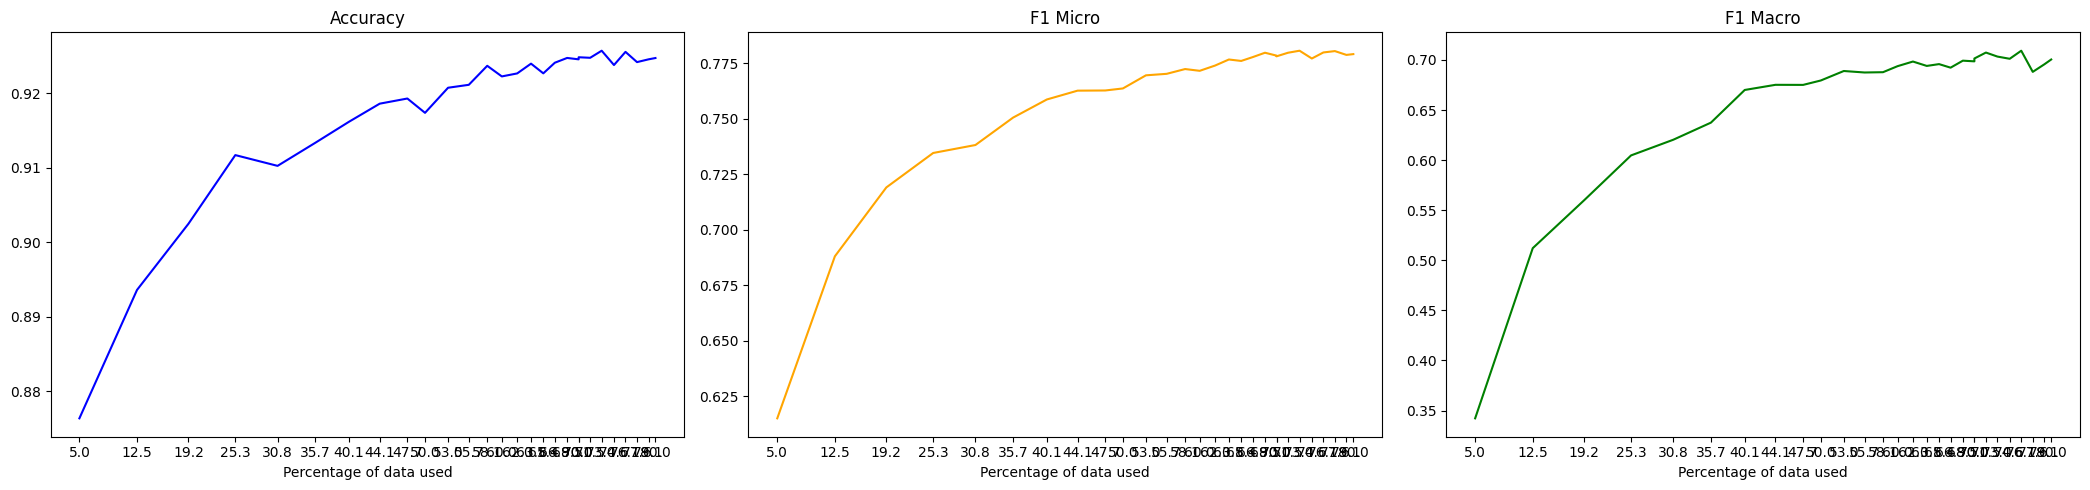

In [ ]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: [94, 21, 5]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5538, Accuracy: 0.8312, F1 Micro: 0.076, F1 Macro: 0.0284
Epoch 2/10, Train Loss: 0.4149, Accuracy: 0.8299, F1 Micro: 0.0348, F1 Macro: 0.0147
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3904, Accuracy: 0.8403, F1 Micro: 0.1715, F1 Macro: 0.0617
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3714, Accuracy: 0.8588, F1 Micro: 0.3943, F1 Macro: 0.1258
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3395, Accuracy: 0.8751, F1 Micro: 0.5537, F1 Macro: 0.2498
Epoch 6/10, Train Loss: 0.2805, Accuracy: 0.8743, F1 Micro: 0.5144, F1 Macro: 0.2417
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2621, Accuracy: 0.8781, F1 Micro: 0.5935, F1 Macro: 0.3158
Epoch 8/10, Train Loss: 0.2328, Accuracy: 0.878, F1 Micro: 0.5855, F1 Macro: 0.3282
Epoch 9/10, Train Loss: 0.1927, Accuracy: 0.8766, F1 Micro: 0.5851, F1 Macro: 0.3423
Epoch 10/10, Train Loss: 0.1855, Accuracy: 0.8779, F1 Micro: 0.5753, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5532, Accuracy: 0.8307, F1 Micro: 0.0557, F1 Macro: 0.022
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4153, Accuracy: 0.8354, F1 Micro: 0.1246, F1 Macro: 0.0426
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3907, Accuracy: 0.8379, F1 Micro: 0.1605, F1 Macro: 0.0512
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3735, Accuracy: 0.8544, F1 Micro: 0.3403, F1 Macro: 0.1177
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3425, Accuracy: 0.8734, F1 Micro: 0.5257, F1 Macro: 0.2423
Epoch 6/10, Train Loss: 0.2883, Accuracy: 0.872, F1 Micro: 0.4793, F1 Macro: 0.2231
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.267, Accuracy: 0.8783, F1 Micro: 0.582, F1 Macro: 0.286
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2375, Accuracy: 0.8796, F1 Micro: 0.5986, F1 Macro: 0.3176
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1991, Accuracy: 0.8792, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5337, Accuracy: 0.8364, F1 Micro: 0.1418, F1 Macro: 0.0476
Epoch 2/10, Train Loss: 0.4137, Accuracy: 0.8326, F1 Micro: 0.0674, F1 Macro: 0.0265
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3895, Accuracy: 0.8433, F1 Micro: 0.2118, F1 Macro: 0.0733
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3691, Accuracy: 0.8583, F1 Micro: 0.3778, F1 Macro: 0.1299
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3367, Accuracy: 0.8761, F1 Micro: 0.5576, F1 Macro: 0.256
Epoch 6/10, Train Loss: 0.2823, Accuracy: 0.8729, F1 Micro: 0.49, F1 Macro: 0.2327
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2572, Accuracy: 0.8798, F1 Micro: 0.5782, F1 Macro: 0.3101
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2312, Accuracy: 0.8798, F1 Micro: 0.5983, F1 Macro: 0.3538
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1925, Accuracy: 0.8797, F1 Micro: 0.6079, F1 Macro: 0.3704
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4674, Accuracy: 0.8336, F1 Micro: 0.0902, F1 Macro: 0.034
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3672, Accuracy: 0.8709, F1 Micro: 0.504, F1 Macro: 0.2073
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3116, Accuracy: 0.8847, F1 Micro: 0.5903, F1 Macro: 0.2945
Epoch 4/10, Train Loss: 0.2622, Accuracy: 0.8795, F1 Micro: 0.5087, F1 Macro: 0.2659
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2259, Accuracy: 0.8904, F1 Micro: 0.67, F1 Macro: 0.4796
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1962, Accuracy: 0.8969, F1 Micro: 0.6736, F1 Macro: 0.4417
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1693, Accuracy: 0.899, F1 Micro: 0.6836, F1 Macro: 0.4812
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1496, Accuracy: 0.8939, F1 Micro: 0.7049, F1 Macro: 0.5244
Epoch 9/10, Train Loss: 0.1244, Accuracy: 0.8978, F1 Micro: 0.6962, F1 Macro: 0.525
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4659, Accuracy: 0.8352, F1 Micro: 0.1143, F1 Macro: 0.0409
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3673, Accuracy: 0.8708, F1 Micro: 0.4944, F1 Macro: 0.2274
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3166, Accuracy: 0.8811, F1 Micro: 0.5661, F1 Macro: 0.2692
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2703, Accuracy: 0.8855, F1 Micro: 0.5742, F1 Macro: 0.3031
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2318, Accuracy: 0.8934, F1 Micro: 0.6565, F1 Macro: 0.436
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2015, Accuracy: 0.8966, F1 Micro: 0.6727, F1 Macro: 0.4365
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1719, Accuracy: 0.8976, F1 Micro: 0.6748, F1 Macro: 0.4221
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1511, Accuracy: 0.8997, F1 Micro: 0.6944, F1 Macro: 0.4925
Epoch 9/10, Train Loss: 0.1187, Accuracy: 0.8974, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4608, Accuracy: 0.8381, F1 Micro: 0.1498, F1 Macro: 0.0521
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3686, Accuracy: 0.8674, F1 Micro: 0.465, F1 Macro: 0.1847
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3134, Accuracy: 0.8852, F1 Micro: 0.5988, F1 Macro: 0.2939
Epoch 4/10, Train Loss: 0.2627, Accuracy: 0.8855, F1 Micro: 0.5693, F1 Macro: 0.3145
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.226, Accuracy: 0.8927, F1 Micro: 0.6509, F1 Macro: 0.4524
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1973, Accuracy: 0.8972, F1 Micro: 0.6723, F1 Macro: 0.4366
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1659, Accuracy: 0.8962, F1 Micro: 0.6891, F1 Macro: 0.4778
Epoch 8/10, Train Loss: 0.1469, Accuracy: 0.8949, F1 Micro: 0.6889, F1 Macro: 0.4548
Epoch 9/10, Train Loss: 0.1199, Accuracy: 0.8946, F1 Micro: 0.6765, F1 Macro: 0.4752
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4395, Accuracy: 0.8525, F1 Micro: 0.4088, F1 Macro: 0.1181
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3291, Accuracy: 0.8804, F1 Micro: 0.6292, F1 Macro: 0.334
Epoch 3/10, Train Loss: 0.2744, Accuracy: 0.8907, F1 Micro: 0.6217, F1 Macro: 0.3977
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2258, Accuracy: 0.8988, F1 Micro: 0.6683, F1 Macro: 0.429
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1926, Accuracy: 0.9015, F1 Micro: 0.7027, F1 Macro: 0.489
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1505, Accuracy: 0.9037, F1 Micro: 0.7151, F1 Macro: 0.5324
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1298, Accuracy: 0.9045, F1 Micro: 0.7175, F1 Macro: 0.535
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1142, Accuracy: 0.9, F1 Micro: 0.7204, F1 Macro: 0.5556
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0926, Accuracy: 0.9049, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4411, Accuracy: 0.8546, F1 Micro: 0.379, F1 Macro: 0.118
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3353, Accuracy: 0.8808, F1 Micro: 0.6293, F1 Macro: 0.301
Epoch 3/10, Train Loss: 0.2814, Accuracy: 0.8929, F1 Micro: 0.6264, F1 Macro: 0.3793
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2291, Accuracy: 0.9, F1 Micro: 0.6711, F1 Macro: 0.4367
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1933, Accuracy: 0.9032, F1 Micro: 0.7017, F1 Macro: 0.4871
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1514, Accuracy: 0.9051, F1 Micro: 0.7159, F1 Macro: 0.5269
Epoch 7/10, Train Loss: 0.1285, Accuracy: 0.9063, F1 Micro: 0.7065, F1 Macro: 0.5393
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1062, Accuracy: 0.9058, F1 Micro: 0.7212, F1 Macro: 0.5378
Epoch 9/10, Train Loss: 0.0888, Accuracy: 0.9073, F1 Micro: 0.719, F1 Macro: 0.5549
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4337, Accuracy: 0.8531, F1 Micro: 0.3589, F1 Macro: 0.1119
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3306, Accuracy: 0.8825, F1 Micro: 0.6361, F1 Macro: 0.3367
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2744, Accuracy: 0.8941, F1 Micro: 0.652, F1 Macro: 0.4014
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.226, Accuracy: 0.8997, F1 Micro: 0.6795, F1 Macro: 0.4393
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1915, Accuracy: 0.9019, F1 Micro: 0.7044, F1 Macro: 0.4846
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1521, Accuracy: 0.8952, F1 Micro: 0.7105, F1 Macro: 0.506
Epoch 7/10, Train Loss: 0.1314, Accuracy: 0.9064, F1 Micro: 0.7103, F1 Macro: 0.5169
Epoch 8/10, Train Loss: 0.1073, Accuracy: 0.904, F1 Micro: 0.7041, F1 Macro: 0.5192
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0913, Accuracy: 0.9019, F1 Micro: 0.7162, F1 Macro: 0.5524
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4238, Accuracy: 0.869, F1 Micro: 0.4848, F1 Macro: 0.2052
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3043, Accuracy: 0.8812, F1 Micro: 0.5304, F1 Macro: 0.2557
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2473, Accuracy: 0.8989, F1 Micro: 0.6576, F1 Macro: 0.4354
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.207, Accuracy: 0.9071, F1 Micro: 0.7187, F1 Macro: 0.5465
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1737, Accuracy: 0.9095, F1 Micro: 0.7272, F1 Macro: 0.5433
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1404, Accuracy: 0.9113, F1 Micro: 0.7326, F1 Macro: 0.565
Epoch 7/10, Train Loss: 0.1113, Accuracy: 0.9114, F1 Micro: 0.7249, F1 Macro: 0.5777
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0944, Accuracy: 0.9107, F1 Micro: 0.739, F1 Macro: 0.592
Epoch 9/10, Train Loss: 0.075, Accuracy: 0.9086, F1 Micro: 0.7306, F1 Macro: 0.5923
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4255, Accuracy: 0.8668, F1 Micro: 0.4447, F1 Macro: 0.2002
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3101, Accuracy: 0.8831, F1 Micro: 0.537, F1 Macro: 0.2637
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2474, Accuracy: 0.9007, F1 Micro: 0.6839, F1 Macro: 0.4543
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2075, Accuracy: 0.9043, F1 Micro: 0.7168, F1 Macro: 0.5348
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1745, Accuracy: 0.9115, F1 Micro: 0.7303, F1 Macro: 0.5608
Epoch 6/10, Train Loss: 0.1347, Accuracy: 0.9106, F1 Micro: 0.7268, F1 Macro: 0.5646
Epoch 7/10, Train Loss: 0.1112, Accuracy: 0.9086, F1 Micro: 0.7057, F1 Macro: 0.5674
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0912, Accuracy: 0.9066, F1 Micro: 0.734, F1 Macro: 0.5971
Epoch 9/10, Train Loss: 0.079, Accuracy: 0.9062, F1 Micro: 0.7293, F1 Macro: 0.5985
Epoch 10/10, Train Loss: 0.0677, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4196, Accuracy: 0.8697, F1 Micro: 0.4584, F1 Macro: 0.1998
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3036, Accuracy: 0.8805, F1 Micro: 0.5234, F1 Macro: 0.2774
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2438, Accuracy: 0.9004, F1 Micro: 0.6686, F1 Macro: 0.4391
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2063, Accuracy: 0.9062, F1 Micro: 0.7099, F1 Macro: 0.5076
Epoch 5/10, Train Loss: 0.1722, Accuracy: 0.9069, F1 Micro: 0.7074, F1 Macro: 0.5387
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1359, Accuracy: 0.91, F1 Micro: 0.7258, F1 Macro: 0.5549
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.113, Accuracy: 0.9111, F1 Micro: 0.7272, F1 Macro: 0.5699
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0937, Accuracy: 0.9042, F1 Micro: 0.7336, F1 Macro: 0.5951
Epoch 9/10, Train Loss: 0.0748, Accuracy: 0.9096, F1 Micro: 0.7285, F1 Macro: 0.6063
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4071, Accuracy: 0.877, F1 Micro: 0.537, F1 Macro: 0.2465
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2924, Accuracy: 0.8953, F1 Micro: 0.6513, F1 Macro: 0.4551
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.233, Accuracy: 0.9025, F1 Micro: 0.7049, F1 Macro: 0.4947
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1904, Accuracy: 0.9088, F1 Micro: 0.7117, F1 Macro: 0.5141
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1584, Accuracy: 0.9097, F1 Micro: 0.7373, F1 Macro: 0.5718
Epoch 6/10, Train Loss: 0.1212, Accuracy: 0.9082, F1 Micro: 0.7305, F1 Macro: 0.5824
Epoch 7/10, Train Loss: 0.0983, Accuracy: 0.9089, F1 Micro: 0.7319, F1 Macro: 0.5908
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0833, Accuracy: 0.911, F1 Micro: 0.7408, F1 Macro: 0.6098
Epoch 9/10, Train Loss: 0.0723, Accuracy: 0.9117, F1 Micro: 0.7336, F1 Macro: 0.602
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4063, Accuracy: 0.8794, F1 Micro: 0.584, F1 Macro: 0.2718
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2986, Accuracy: 0.8953, F1 Micro: 0.6785, F1 Macro: 0.4422
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2366, Accuracy: 0.904, F1 Micro: 0.6932, F1 Macro: 0.5044
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1918, Accuracy: 0.9101, F1 Micro: 0.7163, F1 Macro: 0.5358
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.162, Accuracy: 0.9109, F1 Micro: 0.7454, F1 Macro: 0.5835
Epoch 6/10, Train Loss: 0.1226, Accuracy: 0.9103, F1 Micro: 0.732, F1 Macro: 0.5688
Epoch 7/10, Train Loss: 0.0977, Accuracy: 0.9109, F1 Micro: 0.7373, F1 Macro: 0.5894
Epoch 8/10, Train Loss: 0.0827, Accuracy: 0.9132, F1 Micro: 0.7441, F1 Macro: 0.6016
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.072, Accuracy: 0.9125, F1 Micro: 0.748, F1 Macro: 0.615
Epoch 10/10, Train Loss: 0.0611, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4026, Accuracy: 0.8774, F1 Micro: 0.5293, F1 Macro: 0.2407
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2923, Accuracy: 0.8959, F1 Micro: 0.6721, F1 Macro: 0.4507
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2336, Accuracy: 0.9016, F1 Micro: 0.6856, F1 Macro: 0.4922
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1923, Accuracy: 0.9076, F1 Micro: 0.6925, F1 Macro: 0.5039
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1607, Accuracy: 0.9111, F1 Micro: 0.7425, F1 Macro: 0.5704
Epoch 6/10, Train Loss: 0.1215, Accuracy: 0.9117, F1 Micro: 0.7379, F1 Macro: 0.577
Epoch 7/10, Train Loss: 0.1013, Accuracy: 0.9146, F1 Micro: 0.7423, F1 Macro: 0.5942
Epoch 8/10, Train Loss: 0.0834, Accuracy: 0.9142, F1 Micro: 0.7423, F1 Macro: 0.6011
Epoch 9/10, Train Loss: 0.0726, Accuracy: 0.9125, F1 Micro: 0.7415, F1 Macro: 0.6145
Epoch 10/10, Train Loss: 0.0634, Accuracy: 0.9067, F1 Micro: 0.7353, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3902, Accuracy: 0.8816, F1 Micro: 0.6158, F1 Macro: 0.3205
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2768, Accuracy: 0.8967, F1 Micro: 0.6969, F1 Macro: 0.4647
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2253, Accuracy: 0.9068, F1 Micro: 0.7213, F1 Macro: 0.5541
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1794, Accuracy: 0.9125, F1 Micro: 0.7361, F1 Macro: 0.5784
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.146, Accuracy: 0.9119, F1 Micro: 0.7464, F1 Macro: 0.6027
Epoch 6/10, Train Loss: 0.1174, Accuracy: 0.9139, F1 Micro: 0.7408, F1 Macro: 0.6113
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0951, Accuracy: 0.9148, F1 Micro: 0.7492, F1 Macro: 0.6088
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0779, Accuracy: 0.9143, F1 Micro: 0.7506, F1 Macro: 0.6201
Epoch 9/10, Train Loss: 0.0651, Accuracy: 0.915, F1 Micro: 0.74, F1 Macro: 0.6296
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.393, Accuracy: 0.8801, F1 Micro: 0.6109, F1 Macro: 0.3025
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2807, Accuracy: 0.8937, F1 Micro: 0.6918, F1 Macro: 0.4668
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2286, Accuracy: 0.9067, F1 Micro: 0.7097, F1 Macro: 0.5059
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1859, Accuracy: 0.9078, F1 Micro: 0.7356, F1 Macro: 0.5798
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.147, Accuracy: 0.9129, F1 Micro: 0.7446, F1 Macro: 0.5888
Epoch 6/10, Train Loss: 0.1157, Accuracy: 0.9155, F1 Micro: 0.7432, F1 Macro: 0.603
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0969, Accuracy: 0.9148, F1 Micro: 0.7463, F1 Macro: 0.5998
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0777, Accuracy: 0.9147, F1 Micro: 0.7502, F1 Macro: 0.6124
Epoch 9/10, Train Loss: 0.0686, Accuracy: 0.9137, F1 Micro: 0.7349, F1 Macro: 0.5973
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3896, Accuracy: 0.8822, F1 Micro: 0.6125, F1 Macro: 0.3133
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2787, Accuracy: 0.8908, F1 Micro: 0.6926, F1 Macro: 0.4727
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2249, Accuracy: 0.9076, F1 Micro: 0.7208, F1 Macro: 0.5426
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1818, Accuracy: 0.9076, F1 Micro: 0.7287, F1 Macro: 0.5619
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1479, Accuracy: 0.9091, F1 Micro: 0.7432, F1 Macro: 0.5889
Epoch 6/10, Train Loss: 0.1171, Accuracy: 0.9125, F1 Micro: 0.7394, F1 Macro: 0.6086
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0975, Accuracy: 0.9126, F1 Micro: 0.746, F1 Macro: 0.6107
Epoch 8/10, Train Loss: 0.0807, Accuracy: 0.9161, F1 Micro: 0.7434, F1 Macro: 0.6113
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.069, Accuracy: 0.9148, F1 Micro: 0.7462, F1 Macro: 0.6232
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.38, Accuracy: 0.8836, F1 Micro: 0.6268, F1 Macro: 0.3306
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2619, Accuracy: 0.8932, F1 Micro: 0.7081, F1 Macro: 0.517
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2178, Accuracy: 0.9104, F1 Micro: 0.729, F1 Macro: 0.5524
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1741, Accuracy: 0.9108, F1 Micro: 0.7408, F1 Macro: 0.58
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1436, Accuracy: 0.9085, F1 Micro: 0.7483, F1 Macro: 0.6132
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.108, Accuracy: 0.9156, F1 Micro: 0.7552, F1 Macro: 0.6199
Epoch 7/10, Train Loss: 0.0916, Accuracy: 0.9173, F1 Micro: 0.7504, F1 Macro: 0.6409
Epoch 8/10, Train Loss: 0.0743, Accuracy: 0.9156, F1 Micro: 0.7374, F1 Macro: 0.6275
Epoch 9/10, Train Loss: 0.0644, Accuracy: 0.9164, F1 Micro: 0.7465, F1 Macro: 0.6424
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3822, Accuracy: 0.8842, F1 Micro: 0.6027, F1 Macro: 0.3
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.267, Accuracy: 0.8909, F1 Micro: 0.7011, F1 Macro: 0.4873
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2218, Accuracy: 0.9111, F1 Micro: 0.7306, F1 Macro: 0.5486
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1751, Accuracy: 0.9112, F1 Micro: 0.7394, F1 Macro: 0.5677
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1455, Accuracy: 0.9103, F1 Micro: 0.7483, F1 Macro: 0.584
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1112, Accuracy: 0.9181, F1 Micro: 0.7566, F1 Macro: 0.6183
Epoch 7/10, Train Loss: 0.0924, Accuracy: 0.9178, F1 Micro: 0.7537, F1 Macro: 0.6177
Epoch 8/10, Train Loss: 0.0743, Accuracy: 0.9173, F1 Micro: 0.7553, F1 Macro: 0.6477
Epoch 9/10, Train Loss: 0.0653, Accuracy: 0.9178, F1 Micro: 0.7518, F1 Macro: 0.6241
Epoch 10/10, Train Loss: 0.0534, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3793, Accuracy: 0.8833, F1 Micro: 0.5831, F1 Macro: 0.2902
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2619, Accuracy: 0.8975, F1 Micro: 0.7073, F1 Macro: 0.4899
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2174, Accuracy: 0.9108, F1 Micro: 0.7255, F1 Macro: 0.5505
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1737, Accuracy: 0.9115, F1 Micro: 0.7414, F1 Macro: 0.5648
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1459, Accuracy: 0.9071, F1 Micro: 0.7464, F1 Macro: 0.619
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1125, Accuracy: 0.9122, F1 Micro: 0.7476, F1 Macro: 0.6135
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0901, Accuracy: 0.9173, F1 Micro: 0.7554, F1 Macro: 0.6298
Epoch 8/10, Train Loss: 0.0744, Accuracy: 0.9176, F1 Micro: 0.7506, F1 Macro: 0.6302
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0658, Accuracy: 0.9183, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3797, Accuracy: 0.885, F1 Micro: 0.6237, F1 Macro: 0.317
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2619, Accuracy: 0.9045, F1 Micro: 0.6916, F1 Macro: 0.5131
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2123, Accuracy: 0.9136, F1 Micro: 0.7203, F1 Macro: 0.5486
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1641, Accuracy: 0.9151, F1 Micro: 0.7447, F1 Macro: 0.5979
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1382, Accuracy: 0.9099, F1 Micro: 0.752, F1 Macro: 0.6087
Epoch 6/10, Train Loss: 0.1082, Accuracy: 0.9155, F1 Micro: 0.7489, F1 Macro: 0.6008
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0903, Accuracy: 0.9167, F1 Micro: 0.7574, F1 Macro: 0.6388
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0743, Accuracy: 0.919, F1 Micro: 0.7598, F1 Macro: 0.6627
Epoch 9/10, Train Loss: 0.0639, Accuracy: 0.918, F1 Micro: 0.7581, F1 Macro: 0.6661
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3804, Accuracy: 0.8861, F1 Micro: 0.603, F1 Macro: 0.2899
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.265, Accuracy: 0.9052, F1 Micro: 0.7074, F1 Macro: 0.5321
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2151, Accuracy: 0.913, F1 Micro: 0.7221, F1 Macro: 0.5466
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1691, Accuracy: 0.9156, F1 Micro: 0.7486, F1 Macro: 0.5939
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1385, Accuracy: 0.912, F1 Micro: 0.7498, F1 Macro: 0.5985
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1118, Accuracy: 0.9143, F1 Micro: 0.7585, F1 Macro: 0.618
Epoch 7/10, Train Loss: 0.0905, Accuracy: 0.9183, F1 Micro: 0.7532, F1 Macro: 0.6197
Epoch 8/10, Train Loss: 0.0725, Accuracy: 0.9181, F1 Micro: 0.7584, F1 Macro: 0.629
Epoch 9/10, Train Loss: 0.0643, Accuracy: 0.9156, F1 Micro: 0.7584, F1 Macro: 0.6613
Epoch 10/10, Train Loss: 0.0518, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3782, Accuracy: 0.8863, F1 Micro: 0.6184, F1 Macro: 0.3182
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2648, Accuracy: 0.9047, F1 Micro: 0.7064, F1 Macro: 0.5324
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2133, Accuracy: 0.9131, F1 Micro: 0.7248, F1 Macro: 0.5349
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1695, Accuracy: 0.9148, F1 Micro: 0.7463, F1 Macro: 0.5876
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.138, Accuracy: 0.9107, F1 Micro: 0.7509, F1 Macro: 0.6023
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1079, Accuracy: 0.9159, F1 Micro: 0.7603, F1 Macro: 0.6139
Epoch 7/10, Train Loss: 0.09, Accuracy: 0.9128, F1 Micro: 0.7491, F1 Macro: 0.6366
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0725, Accuracy: 0.918, F1 Micro: 0.763, F1 Macro: 0.6643
Epoch 9/10, Train Loss: 0.0606, Accuracy: 0.9208, F1 Micro: 0.7624, F1 Macro: 0.6749
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.375, Accuracy: 0.8871, F1 Micro: 0.6577, F1 Macro: 0.3596
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2514, Accuracy: 0.9083, F1 Micro: 0.7139, F1 Macro: 0.541
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2095, Accuracy: 0.91, F1 Micro: 0.734, F1 Macro: 0.5791
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1665, Accuracy: 0.9165, F1 Micro: 0.757, F1 Macro: 0.6129
Epoch 5/10, Train Loss: 0.1379, Accuracy: 0.9134, F1 Micro: 0.7524, F1 Macro: 0.6142
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1046, Accuracy: 0.916, F1 Micro: 0.7573, F1 Macro: 0.6406
Epoch 7/10, Train Loss: 0.0853, Accuracy: 0.9186, F1 Micro: 0.7486, F1 Macro: 0.6584
Epoch 8/10, Train Loss: 0.0712, Accuracy: 0.9189, F1 Micro: 0.7561, F1 Macro: 0.6661
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0595, Accuracy: 0.9194, F1 Micro: 0.7608, F1 Macro: 0.6697
Epoch 10/10, Train Loss: 0.0555, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3766, Accuracy: 0.8882, F1 Micro: 0.6572, F1 Macro: 0.3613
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2545, Accuracy: 0.9073, F1 Micro: 0.7081, F1 Macro: 0.5363
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2098, Accuracy: 0.9092, F1 Micro: 0.7378, F1 Macro: 0.5865
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1654, Accuracy: 0.9151, F1 Micro: 0.756, F1 Macro: 0.605
Epoch 5/10, Train Loss: 0.136, Accuracy: 0.9129, F1 Micro: 0.7543, F1 Macro: 0.607
Epoch 6/10, Train Loss: 0.1065, Accuracy: 0.9165, F1 Micro: 0.7545, F1 Macro: 0.6367
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0828, Accuracy: 0.9175, F1 Micro: 0.7599, F1 Macro: 0.6709
Epoch 8/10, Train Loss: 0.071, Accuracy: 0.9174, F1 Micro: 0.7494, F1 Macro: 0.6407
Epoch 9/10, Train Loss: 0.0571, Accuracy: 0.9204, F1 Micro: 0.754, F1 Macro: 0.6624
Epoch 10/10, Train Loss: 0.0554, Accuracy: 0.9156, F1 Micro: 0.7575, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3726, Accuracy: 0.8892, F1 Micro: 0.6649, F1 Macro: 0.3816
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2534, Accuracy: 0.9087, F1 Micro: 0.7153, F1 Macro: 0.5383
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2106, Accuracy: 0.9126, F1 Micro: 0.7326, F1 Macro: 0.572
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1664, Accuracy: 0.9159, F1 Micro: 0.7537, F1 Macro: 0.5883
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1373, Accuracy: 0.9174, F1 Micro: 0.7568, F1 Macro: 0.6127
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1063, Accuracy: 0.9183, F1 Micro: 0.7582, F1 Macro: 0.634
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0868, Accuracy: 0.9196, F1 Micro: 0.7636, F1 Macro: 0.6672
Epoch 8/10, Train Loss: 0.0695, Accuracy: 0.9191, F1 Micro: 0.7623, F1 Macro: 0.6663
Epoch 9/10, Train Loss: 0.0563, Accuracy: 0.9209, F1 Micro: 0.7614, F1 Macro: 0.6716
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3668, Accuracy: 0.8911, F1 Micro: 0.6317, F1 Macro: 0.3348
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2502, Accuracy: 0.9057, F1 Micro: 0.6996, F1 Macro: 0.5178
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2026, Accuracy: 0.9135, F1 Micro: 0.7389, F1 Macro: 0.5814
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.162, Accuracy: 0.9164, F1 Micro: 0.7409, F1 Macro: 0.5912
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1274, Accuracy: 0.9162, F1 Micro: 0.7571, F1 Macro: 0.625
Epoch 6/10, Train Loss: 0.1123, Accuracy: 0.9172, F1 Micro: 0.7475, F1 Macro: 0.6161
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0886, Accuracy: 0.9198, F1 Micro: 0.7677, F1 Macro: 0.673
Epoch 8/10, Train Loss: 0.073, Accuracy: 0.9199, F1 Micro: 0.765, F1 Macro: 0.6661
Epoch 9/10, Train Loss: 0.0614, Accuracy: 0.92, F1 Micro: 0.7616, F1 Macro: 0.6776
Epoch 10/10, Train Loss: 0.0507, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.37, Accuracy: 0.8923, F1 Micro: 0.6473, F1 Macro: 0.3468
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2548, Accuracy: 0.9051, F1 Micro: 0.6874, F1 Macro: 0.4862
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2062, Accuracy: 0.9143, F1 Micro: 0.7363, F1 Macro: 0.5819
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1636, Accuracy: 0.9151, F1 Micro: 0.7483, F1 Macro: 0.5858
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1273, Accuracy: 0.9144, F1 Micro: 0.7545, F1 Macro: 0.6286
Epoch 6/10, Train Loss: 0.11, Accuracy: 0.9168, F1 Micro: 0.7513, F1 Macro: 0.6204
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.088, Accuracy: 0.9182, F1 Micro: 0.7607, F1 Macro: 0.6675
Epoch 8/10, Train Loss: 0.0705, Accuracy: 0.9172, F1 Micro: 0.7556, F1 Macro: 0.6674
Epoch 9/10, Train Loss: 0.0608, Accuracy: 0.916, F1 Micro: 0.7562, F1 Macro: 0.6554
Epoch 10/10, Train Loss: 0.0485, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3677, Accuracy: 0.8903, F1 Micro: 0.6194, F1 Macro: 0.3402
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2513, Accuracy: 0.9072, F1 Micro: 0.708, F1 Macro: 0.5167
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2062, Accuracy: 0.9132, F1 Micro: 0.7315, F1 Macro: 0.5653
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1646, Accuracy: 0.916, F1 Micro: 0.7504, F1 Macro: 0.5862
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1269, Accuracy: 0.9124, F1 Micro: 0.7532, F1 Macro: 0.6292
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1102, Accuracy: 0.9197, F1 Micro: 0.7607, F1 Macro: 0.6332
Epoch 7/10, Train Loss: 0.0891, Accuracy: 0.9172, F1 Micro: 0.7584, F1 Macro: 0.6736
Epoch 8/10, Train Loss: 0.0743, Accuracy: 0.921, F1 Micro: 0.7604, F1 Macro: 0.6666
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0611, Accuracy: 0.9199, F1 Micro: 0.7659, F1 Macro: 0.672
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3628, Accuracy: 0.8915, F1 Micro: 0.6808, F1 Macro: 0.4505
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2468, Accuracy: 0.9042, F1 Micro: 0.7175, F1 Macro: 0.5443
Epoch 3/10, Train Loss: 0.1978, Accuracy: 0.9127, F1 Micro: 0.7044, F1 Macro: 0.554
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1612, Accuracy: 0.9179, F1 Micro: 0.7607, F1 Macro: 0.6157
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1258, Accuracy: 0.9182, F1 Micro: 0.7615, F1 Macro: 0.6539
Epoch 6/10, Train Loss: 0.103, Accuracy: 0.9187, F1 Micro: 0.7615, F1 Macro: 0.6466
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0818, Accuracy: 0.921, F1 Micro: 0.7629, F1 Macro: 0.6553
Epoch 8/10, Train Loss: 0.0648, Accuracy: 0.918, F1 Micro: 0.741, F1 Macro: 0.6404
Epoch 9/10, Train Loss: 0.061, Accuracy: 0.9203, F1 Micro: 0.7608, F1 Macro: 0.6776
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0488, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.365, Accuracy: 0.8941, F1 Micro: 0.6669, F1 Macro: 0.4171
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2504, Accuracy: 0.9059, F1 Micro: 0.7148, F1 Macro: 0.5334
Epoch 3/10, Train Loss: 0.1974, Accuracy: 0.9133, F1 Micro: 0.7082, F1 Macro: 0.5586
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1616, Accuracy: 0.9171, F1 Micro: 0.7567, F1 Macro: 0.6114
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1251, Accuracy: 0.9195, F1 Micro: 0.7603, F1 Macro: 0.6321
Epoch 6/10, Train Loss: 0.1004, Accuracy: 0.9159, F1 Micro: 0.7599, F1 Macro: 0.6461
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0823, Accuracy: 0.9174, F1 Micro: 0.766, F1 Macro: 0.6568
Epoch 8/10, Train Loss: 0.0657, Accuracy: 0.92, F1 Micro: 0.763, F1 Macro: 0.6627
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0598, Accuracy: 0.9228, F1 Micro: 0.7667, F1 Macro: 0.6797
Epoch 10/10, Train Loss: 0.0477, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3616, Accuracy: 0.8932, F1 Micro: 0.6787, F1 Macro: 0.4304
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2482, Accuracy: 0.903, F1 Micro: 0.7162, F1 Macro: 0.534
Epoch 3/10, Train Loss: 0.1975, Accuracy: 0.9129, F1 Micro: 0.7066, F1 Macro: 0.5528
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1629, Accuracy: 0.9163, F1 Micro: 0.7593, F1 Macro: 0.6067
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1244, Accuracy: 0.9195, F1 Micro: 0.7652, F1 Macro: 0.6575
Epoch 6/10, Train Loss: 0.1017, Accuracy: 0.9205, F1 Micro: 0.7574, F1 Macro: 0.6542
Epoch 7/10, Train Loss: 0.0833, Accuracy: 0.9219, F1 Micro: 0.7563, F1 Macro: 0.6422
Epoch 8/10, Train Loss: 0.0651, Accuracy: 0.9184, F1 Micro: 0.757, F1 Macro: 0.6642
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0569, Accuracy: 0.9218, F1 Micro: 0.771, F1 Macro: 0.6881
Epoch 10/10, Train Loss: 0.05, Accuracy: 0.9224, F1 Micro: 0.7706, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3556, Accuracy: 0.8922, F1 Micro: 0.6621, F1 Macro: 0.4101
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2466, Accuracy: 0.9057, F1 Micro: 0.7278, F1 Macro: 0.5699
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.198, Accuracy: 0.9152, F1 Micro: 0.7533, F1 Macro: 0.6054
Epoch 4/10, Train Loss: 0.1538, Accuracy: 0.9187, F1 Micro: 0.7461, F1 Macro: 0.6045
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1264, Accuracy: 0.9218, F1 Micro: 0.7694, F1 Macro: 0.6652
Epoch 6/10, Train Loss: 0.0995, Accuracy: 0.9175, F1 Micro: 0.7575, F1 Macro: 0.647
Epoch 7/10, Train Loss: 0.0838, Accuracy: 0.92, F1 Micro: 0.7645, F1 Macro: 0.6626
Epoch 8/10, Train Loss: 0.0707, Accuracy: 0.9165, F1 Micro: 0.7631, F1 Macro: 0.6777
Epoch 9/10, Train Loss: 0.0568, Accuracy: 0.9191, F1 Micro: 0.7663, F1 Macro: 0.684
Epoch 10/10, Train Loss: 0.0488, Accuracy: 0.9213, F1 Micro: 0.7637, F1 Macro: 0.6913
Model 1 - Iteration 73

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3594, Accuracy: 0.8916, F1 Micro: 0.6554, F1 Macro: 0.3513
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2504, Accuracy: 0.9084, F1 Micro: 0.7186, F1 Macro: 0.536
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1987, Accuracy: 0.9173, F1 Micro: 0.7476, F1 Macro: 0.5808
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1546, Accuracy: 0.9192, F1 Micro: 0.7561, F1 Macro: 0.6127
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1287, Accuracy: 0.9226, F1 Micro: 0.7689, F1 Macro: 0.6651
Epoch 6/10, Train Loss: 0.1011, Accuracy: 0.9196, F1 Micro: 0.7593, F1 Macro: 0.6385
Epoch 7/10, Train Loss: 0.0816, Accuracy: 0.9202, F1 Micro: 0.7672, F1 Macro: 0.6723
Epoch 8/10, Train Loss: 0.0672, Accuracy: 0.9192, F1 Micro: 0.7655, F1 Macro: 0.6665
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0558, Accuracy: 0.9218, F1 Micro: 0.7713, F1 Macro: 0.6963
Epoch 10/10, Train Loss: 0.0469, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3548, Accuracy: 0.8935, F1 Micro: 0.6674, F1 Macro: 0.3996
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2483, Accuracy: 0.9057, F1 Micro: 0.722, F1 Macro: 0.5461
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1991, Accuracy: 0.9178, F1 Micro: 0.7524, F1 Macro: 0.5801
Epoch 4/10, Train Loss: 0.155, Accuracy: 0.9189, F1 Micro: 0.7489, F1 Macro: 0.6111
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1273, Accuracy: 0.9172, F1 Micro: 0.7616, F1 Macro: 0.6546
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1021, Accuracy: 0.9196, F1 Micro: 0.7644, F1 Macro: 0.6549
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0829, Accuracy: 0.9209, F1 Micro: 0.7682, F1 Macro: 0.6679
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0664, Accuracy: 0.9204, F1 Micro: 0.7692, F1 Macro: 0.6829
Epoch 9/10, Train Loss: 0.0539, Accuracy: 0.9174, F1 Micro: 0.7656, F1 Macro: 0.6874
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3564, Accuracy: 0.8919, F1 Micro: 0.6205, F1 Macro: 0.4081
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2401, Accuracy: 0.9124, F1 Micro: 0.7232, F1 Macro: 0.5445
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1992, Accuracy: 0.9169, F1 Micro: 0.7429, F1 Macro: 0.588
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1564, Accuracy: 0.9195, F1 Micro: 0.7595, F1 Macro: 0.6216
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1196, Accuracy: 0.9191, F1 Micro: 0.7666, F1 Macro: 0.6504
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0988, Accuracy: 0.9209, F1 Micro: 0.768, F1 Macro: 0.6557
Epoch 7/10, Train Loss: 0.0813, Accuracy: 0.9208, F1 Micro: 0.7665, F1 Macro: 0.6891
Epoch 8/10, Train Loss: 0.0666, Accuracy: 0.9202, F1 Micro: 0.7677, F1 Macro: 0.6884
Epoch 9/10, Train Loss: 0.057, Accuracy: 0.9182, F1 Micro: 0.758, F1 Macro: 0.6922
Epoch 10/10, Train Loss: 0.0483, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3589, Accuracy: 0.8925, F1 Micro: 0.6213, F1 Macro: 0.4153
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2439, Accuracy: 0.9098, F1 Micro: 0.7114, F1 Macro: 0.5274
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1979, Accuracy: 0.9175, F1 Micro: 0.752, F1 Macro: 0.5887
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1546, Accuracy: 0.9201, F1 Micro: 0.7611, F1 Macro: 0.6113
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1185, Accuracy: 0.9121, F1 Micro: 0.7611, F1 Macro: 0.6462
Epoch 6/10, Train Loss: 0.1, Accuracy: 0.9213, F1 Micro: 0.76, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0789, Accuracy: 0.9203, F1 Micro: 0.7718, F1 Macro: 0.6863
Epoch 8/10, Train Loss: 0.0646, Accuracy: 0.9191, F1 Micro: 0.7691, F1 Macro: 0.6905
Epoch 9/10, Train Loss: 0.0545, Accuracy: 0.9217, F1 Micro: 0.7638, F1 Macro: 0.69
Epoch 10/10, Train Loss: 0.0462, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3555, Accuracy: 0.8915, F1 Micro: 0.6205, F1 Macro: 0.4098
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2417, Accuracy: 0.9099, F1 Micro: 0.7055, F1 Macro: 0.5244
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1984, Accuracy: 0.9182, F1 Micro: 0.7472, F1 Macro: 0.579
Epoch 4/10, Train Loss: 0.1549, Accuracy: 0.9193, F1 Micro: 0.7456, F1 Macro: 0.6073
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1201, Accuracy: 0.9172, F1 Micro: 0.766, F1 Macro: 0.6538
Epoch 6/10, Train Loss: 0.1016, Accuracy: 0.9199, F1 Micro: 0.7616, F1 Macro: 0.6593
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0819, Accuracy: 0.921, F1 Micro: 0.7668, F1 Macro: 0.6875
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0645, Accuracy: 0.9203, F1 Micro: 0.7697, F1 Macro: 0.6859
Epoch 9/10, Train Loss: 0.0563, Accuracy: 0.9235, F1 Micro: 0.7661, F1 Macro: 0.6919
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3588, Accuracy: 0.8952, F1 Micro: 0.6611, F1 Macro: 0.4007
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2442, Accuracy: 0.9085, F1 Micro: 0.7338, F1 Macro: 0.5696
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1975, Accuracy: 0.9186, F1 Micro: 0.7456, F1 Macro: 0.5854
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1568, Accuracy: 0.9187, F1 Micro: 0.7687, F1 Macro: 0.6327
Epoch 5/10, Train Loss: 0.1217, Accuracy: 0.9213, F1 Micro: 0.7683, F1 Macro: 0.6479
Epoch 6/10, Train Loss: 0.1015, Accuracy: 0.9204, F1 Micro: 0.7612, F1 Macro: 0.6509
Epoch 7/10, Train Loss: 0.0794, Accuracy: 0.9175, F1 Micro: 0.7665, F1 Macro: 0.6835
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0712, Accuracy: 0.9241, F1 Micro: 0.774, F1 Macro: 0.6928
Epoch 9/10, Train Loss: 0.0598, Accuracy: 0.9233, F1 Micro: 0.7729, F1 Macro: 0.7007
Epoch 10/10, Train Loss: 0.0486, Accuracy: 0.9234, F1 Micro: 0.766, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3617, Accuracy: 0.8961, F1 Micro: 0.6673, F1 Macro: 0.4094
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2466, Accuracy: 0.9117, F1 Micro: 0.7344, F1 Macro: 0.5649
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1995, Accuracy: 0.9176, F1 Micro: 0.7499, F1 Macro: 0.5961
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1577, Accuracy: 0.9157, F1 Micro: 0.7591, F1 Macro: 0.6247
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1253, Accuracy: 0.9229, F1 Micro: 0.7707, F1 Macro: 0.6327
Epoch 6/10, Train Loss: 0.1018, Accuracy: 0.9226, F1 Micro: 0.7672, F1 Macro: 0.6434
Epoch 7/10, Train Loss: 0.0802, Accuracy: 0.9188, F1 Micro: 0.7669, F1 Macro: 0.673
Epoch 8/10, Train Loss: 0.0701, Accuracy: 0.9217, F1 Micro: 0.764, F1 Macro: 0.6697
Epoch 9/10, Train Loss: 0.0591, Accuracy: 0.921, F1 Micro: 0.7691, F1 Macro: 0.6932
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.047, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3577, Accuracy: 0.8957, F1 Micro: 0.6682, F1 Macro: 0.4049
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2428, Accuracy: 0.9098, F1 Micro: 0.7305, F1 Macro: 0.5505
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1974, Accuracy: 0.9181, F1 Micro: 0.7516, F1 Macro: 0.5932
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1563, Accuracy: 0.914, F1 Micro: 0.756, F1 Macro: 0.6164
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1214, Accuracy: 0.9229, F1 Micro: 0.7694, F1 Macro: 0.6388
Epoch 6/10, Train Loss: 0.1008, Accuracy: 0.9216, F1 Micro: 0.7687, F1 Macro: 0.6589
Epoch 7/10, Train Loss: 0.0806, Accuracy: 0.9114, F1 Micro: 0.7554, F1 Macro: 0.6751
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0708, Accuracy: 0.9241, F1 Micro: 0.7705, F1 Macro: 0.6889
Epoch 9/10, Train Loss: 0.0567, Accuracy: 0.9194, F1 Micro: 0.7701, F1 Macro: 0.7024
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3461, Accuracy: 0.8972, F1 Micro: 0.6741, F1 Macro: 0.461
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2383, Accuracy: 0.9129, F1 Micro: 0.7293, F1 Macro: 0.5402
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1881, Accuracy: 0.9184, F1 Micro: 0.7583, F1 Macro: 0.6024
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.158, Accuracy: 0.9195, F1 Micro: 0.7667, F1 Macro: 0.6243
Epoch 5/10, Train Loss: 0.1216, Accuracy: 0.9218, F1 Micro: 0.7651, F1 Macro: 0.6651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0966, Accuracy: 0.9173, F1 Micro: 0.7682, F1 Macro: 0.6683
Epoch 7/10, Train Loss: 0.0811, Accuracy: 0.9191, F1 Micro: 0.7675, F1 Macro: 0.6836
Epoch 8/10, Train Loss: 0.0653, Accuracy: 0.9215, F1 Micro: 0.766, F1 Macro: 0.6828
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0567, Accuracy: 0.9211, F1 Micro: 0.7698, F1 Macro: 0.6953
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3491, Accuracy: 0.8966, F1 Micro: 0.6786, F1 Macro: 0.4575
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2431, Accuracy: 0.9142, F1 Micro: 0.7325, F1 Macro: 0.5537
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1908, Accuracy: 0.9181, F1 Micro: 0.7536, F1 Macro: 0.6009
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1586, Accuracy: 0.9213, F1 Micro: 0.7719, F1 Macro: 0.6465
Epoch 5/10, Train Loss: 0.1214, Accuracy: 0.9216, F1 Micro: 0.7668, F1 Macro: 0.6533
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0962, Accuracy: 0.9209, F1 Micro: 0.7728, F1 Macro: 0.6784
Epoch 7/10, Train Loss: 0.0802, Accuracy: 0.9181, F1 Micro: 0.7657, F1 Macro: 0.6875
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0644, Accuracy: 0.9218, F1 Micro: 0.7754, F1 Macro: 0.686
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.055, Accuracy: 0.9228, F1 Micro: 0.776, F1 Macro: 0.7063
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3465, Accuracy: 0.897, F1 Micro: 0.677, F1 Macro: 0.4584
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2422, Accuracy: 0.9134, F1 Micro: 0.7312, F1 Macro: 0.5398
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1907, Accuracy: 0.9175, F1 Micro: 0.7494, F1 Macro: 0.5854
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.159, Accuracy: 0.9206, F1 Micro: 0.7681, F1 Macro: 0.6256
Epoch 5/10, Train Loss: 0.1226, Accuracy: 0.9199, F1 Micro: 0.7614, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0953, Accuracy: 0.9209, F1 Micro: 0.7685, F1 Macro: 0.6745
Epoch 7/10, Train Loss: 0.0775, Accuracy: 0.9207, F1 Micro: 0.7684, F1 Macro: 0.694
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0641, Accuracy: 0.924, F1 Micro: 0.7755, F1 Macro: 0.7007
Epoch 9/10, Train Loss: 0.0528, Accuracy: 0.9243, F1 Micro: 0.7745, F1 Macro: 0.7143
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.356, Accuracy: 0.8956, F1 Micro: 0.631, F1 Macro: 0.4175
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2386, Accuracy: 0.9116, F1 Micro: 0.7322, F1 Macro: 0.5756
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1871, Accuracy: 0.919, F1 Micro: 0.7599, F1 Macro: 0.6102
Epoch 4/10, Train Loss: 0.147, Accuracy: 0.9205, F1 Micro: 0.7591, F1 Macro: 0.625
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1274, Accuracy: 0.923, F1 Micro: 0.7711, F1 Macro: 0.6722
Epoch 6/10, Train Loss: 0.0984, Accuracy: 0.9227, F1 Micro: 0.7654, F1 Macro: 0.6901
Epoch 7/10, Train Loss: 0.0801, Accuracy: 0.9232, F1 Micro: 0.7708, F1 Macro: 0.6829
Epoch 8/10, Train Loss: 0.0657, Accuracy: 0.9204, F1 Micro: 0.7705, F1 Macro: 0.7025
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0561, Accuracy: 0.9232, F1 Micro: 0.7724, F1 Macro: 0.7056
Epoch 10/10, Train Loss: 0.0449, Accuracy: 0.917, F1 Micro: 0.767, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3587, Accuracy: 0.895, F1 Micro: 0.6231, F1 Macro: 0.378
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2418, Accuracy: 0.9123, F1 Micro: 0.7395, F1 Macro: 0.5784
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1911, Accuracy: 0.9182, F1 Micro: 0.7598, F1 Macro: 0.6119
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1483, Accuracy: 0.9189, F1 Micro: 0.76, F1 Macro: 0.6237
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1252, Accuracy: 0.9242, F1 Micro: 0.7732, F1 Macro: 0.6761
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0945, Accuracy: 0.9249, F1 Micro: 0.7767, F1 Macro: 0.6935
Epoch 7/10, Train Loss: 0.0786, Accuracy: 0.9221, F1 Micro: 0.7728, F1 Macro: 0.6805
Epoch 8/10, Train Loss: 0.0632, Accuracy: 0.9212, F1 Micro: 0.7749, F1 Macro: 0.7031
Epoch 9/10, Train Loss: 0.0535, Accuracy: 0.9225, F1 Micro: 0.7754, F1 Macro: 0.7073
Epoch 10/10, Train Loss: 0.0444, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.356, Accuracy: 0.8939, F1 Micro: 0.6146, F1 Macro: 0.3837
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2393, Accuracy: 0.9123, F1 Micro: 0.732, F1 Macro: 0.5548
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1904, Accuracy: 0.9187, F1 Micro: 0.7576, F1 Macro: 0.606
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1486, Accuracy: 0.9208, F1 Micro: 0.768, F1 Macro: 0.6377
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1242, Accuracy: 0.9242, F1 Micro: 0.778, F1 Macro: 0.6836
Epoch 6/10, Train Loss: 0.093, Accuracy: 0.9216, F1 Micro: 0.7594, F1 Macro: 0.6914
Epoch 7/10, Train Loss: 0.0789, Accuracy: 0.9221, F1 Micro: 0.7743, F1 Macro: 0.6798
Epoch 8/10, Train Loss: 0.0647, Accuracy: 0.9215, F1 Micro: 0.7686, F1 Macro: 0.7118
Epoch 9/10, Train Loss: 0.0543, Accuracy: 0.9225, F1 Micro: 0.7741, F1 Macro: 0.7033
Epoch 10/10, Train Loss: 0.0448, Accuracy: 0.9235, F1 Micro: 0.7698, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3473, Accuracy: 0.8975, F1 Micro: 0.6781, F1 Macro: 0.4578
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2399, Accuracy: 0.9121, F1 Micro: 0.7273, F1 Macro: 0.5475
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1897, Accuracy: 0.9187, F1 Micro: 0.7585, F1 Macro: 0.5987
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1533, Accuracy: 0.9219, F1 Micro: 0.7651, F1 Macro: 0.6305
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1168, Accuracy: 0.9226, F1 Micro: 0.7684, F1 Macro: 0.6874
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1014, Accuracy: 0.9217, F1 Micro: 0.7695, F1 Macro: 0.678
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0813, Accuracy: 0.9208, F1 Micro: 0.7724, F1 Macro: 0.6959
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0667, Accuracy: 0.9251, F1 Micro: 0.779, F1 Macro: 0.7032
Epoch 9/10, Train Loss: 0.055, Accuracy: 0.9216, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3512, Accuracy: 0.8979, F1 Micro: 0.6708, F1 Macro: 0.4273
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2421, Accuracy: 0.9126, F1 Micro: 0.7296, F1 Macro: 0.5464
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1904, Accuracy: 0.9191, F1 Micro: 0.7601, F1 Macro: 0.5825
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1559, Accuracy: 0.9219, F1 Micro: 0.7687, F1 Macro: 0.6326
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1209, Accuracy: 0.9189, F1 Micro: 0.7716, F1 Macro: 0.6871
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0993, Accuracy: 0.9217, F1 Micro: 0.7725, F1 Macro: 0.6796
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0769, Accuracy: 0.9252, F1 Micro: 0.7761, F1 Macro: 0.7037
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.066, Accuracy: 0.9238, F1 Micro: 0.7783, F1 Macro: 0.701
Epoch 9/10, Train Loss: 0.0533, Accuracy: 0.9213, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3478, Accuracy: 0.899, F1 Micro: 0.6719, F1 Macro: 0.4354
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2405, Accuracy: 0.9124, F1 Micro: 0.7368, F1 Macro: 0.5637
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1901, Accuracy: 0.9178, F1 Micro: 0.7602, F1 Macro: 0.5875
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1541, Accuracy: 0.9224, F1 Micro: 0.7716, F1 Macro: 0.6377
Epoch 5/10, Train Loss: 0.1203, Accuracy: 0.9187, F1 Micro: 0.7686, F1 Macro: 0.683
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0992, Accuracy: 0.9223, F1 Micro: 0.7736, F1 Macro: 0.6819
Epoch 7/10, Train Loss: 0.0781, Accuracy: 0.9228, F1 Micro: 0.7711, F1 Macro: 0.6916
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0663, Accuracy: 0.9239, F1 Micro: 0.7776, F1 Macro: 0.7033
Epoch 9/10, Train Loss: 0.0525, Accuracy: 0.923, F1 Micro: 0.7663, F1 Macro: 0.7066
Epoch 10/10, Train Loss: 0.0451, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3497, Accuracy: 0.8977, F1 Micro: 0.686, F1 Macro: 0.484
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2345, Accuracy: 0.9107, F1 Micro: 0.7418, F1 Macro: 0.5732
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1898, Accuracy: 0.9187, F1 Micro: 0.7623, F1 Macro: 0.6038
Epoch 4/10, Train Loss: 0.1482, Accuracy: 0.9215, F1 Micro: 0.7458, F1 Macro: 0.616
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1214, Accuracy: 0.9253, F1 Micro: 0.7714, F1 Macro: 0.6566
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.098, Accuracy: 0.9193, F1 Micro: 0.7722, F1 Macro: 0.6898
Epoch 7/10, Train Loss: 0.0787, Accuracy: 0.9232, F1 Micro: 0.7722, F1 Macro: 0.6964
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0638, Accuracy: 0.9229, F1 Micro: 0.7772, F1 Macro: 0.7007
Epoch 9/10, Train Loss: 0.055, Accuracy: 0.9178, F1 Micro: 0.771, F1 Macro: 0.7147
Epoch 10/10, Train Loss: 0.0472, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3524, Accuracy: 0.8968, F1 Micro: 0.6751, F1 Macro: 0.4528
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2365, Accuracy: 0.9103, F1 Micro: 0.7401, F1 Macro: 0.5735
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1895, Accuracy: 0.9202, F1 Micro: 0.7619, F1 Macro: 0.6
Epoch 4/10, Train Loss: 0.1499, Accuracy: 0.9225, F1 Micro: 0.7527, F1 Macro: 0.6237
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1223, Accuracy: 0.9247, F1 Micro: 0.767, F1 Macro: 0.6563
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.095, Accuracy: 0.9188, F1 Micro: 0.7706, F1 Macro: 0.6726
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0737, Accuracy: 0.9228, F1 Micro: 0.7755, F1 Macro: 0.6942
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0609, Accuracy: 0.9207, F1 Micro: 0.7774, F1 Macro: 0.7047
Epoch 9/10, Train Loss: 0.0534, Accuracy: 0.9195, F1 Micro: 0.7745, F1 Macro: 0.7013
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3481, Accuracy: 0.898, F1 Micro: 0.6866, F1 Macro: 0.4698
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2358, Accuracy: 0.908, F1 Micro: 0.7413, F1 Macro: 0.5755
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1899, Accuracy: 0.9179, F1 Micro: 0.7626, F1 Macro: 0.5912
Epoch 4/10, Train Loss: 0.1484, Accuracy: 0.9232, F1 Micro: 0.7569, F1 Macro: 0.6104
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1213, Accuracy: 0.9234, F1 Micro: 0.766, F1 Macro: 0.6542
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0933, Accuracy: 0.9151, F1 Micro: 0.7672, F1 Macro: 0.6847
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0776, Accuracy: 0.9226, F1 Micro: 0.7718, F1 Macro: 0.6959
Epoch 8/10, Train Loss: 0.0624, Accuracy: 0.9206, F1 Micro: 0.7716, F1 Macro: 0.7061
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0532, Accuracy: 0.9217, F1 Micro: 0.7768, F1 Macro: 0.7133
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3401, Accuracy: 0.9001, F1 Micro: 0.6633, F1 Macro: 0.4229
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.235, Accuracy: 0.9124, F1 Micro: 0.7414, F1 Macro: 0.5513
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1824, Accuracy: 0.9197, F1 Micro: 0.7496, F1 Macro: 0.5825
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1503, Accuracy: 0.9212, F1 Micro: 0.7635, F1 Macro: 0.6382
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.116, Accuracy: 0.925, F1 Micro: 0.7783, F1 Macro: 0.6852
Epoch 6/10, Train Loss: 0.0961, Accuracy: 0.9198, F1 Micro: 0.7741, F1 Macro: 0.686
Epoch 7/10, Train Loss: 0.0793, Accuracy: 0.9232, F1 Micro: 0.7733, F1 Macro: 0.6877
Epoch 8/10, Train Loss: 0.0679, Accuracy: 0.9179, F1 Micro: 0.7687, F1 Macro: 0.7014
Epoch 9/10, Train Loss: 0.0563, Accuracy: 0.9225, F1 Micro: 0.7739, F1 Macro: 0.707
Epoch 10/10, Train Loss: 0.0454, Accuracy: 0.9204, F1 Micro: 0.7744, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3427, Accuracy: 0.899, F1 Micro: 0.6532, F1 Macro: 0.4285
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2363, Accuracy: 0.9138, F1 Micro: 0.7325, F1 Macro: 0.5249
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1864, Accuracy: 0.9223, F1 Micro: 0.7585, F1 Macro: 0.6024
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1492, Accuracy: 0.9252, F1 Micro: 0.7711, F1 Macro: 0.6414
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1173, Accuracy: 0.9258, F1 Micro: 0.7731, F1 Macro: 0.6701
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0973, Accuracy: 0.9235, F1 Micro: 0.7797, F1 Macro: 0.675
Epoch 7/10, Train Loss: 0.08, Accuracy: 0.9243, F1 Micro: 0.7706, F1 Macro: 0.6873
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0649, Accuracy: 0.9262, F1 Micro: 0.78, F1 Macro: 0.7026
Epoch 9/10, Train Loss: 0.0529, Accuracy: 0.9264, F1 Micro: 0.7788, F1 Macro: 0.7052
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3408, Accuracy: 0.8991, F1 Micro: 0.6503, F1 Macro: 0.3949
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2365, Accuracy: 0.9123, F1 Micro: 0.7306, F1 Macro: 0.5165
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1881, Accuracy: 0.9217, F1 Micro: 0.759, F1 Macro: 0.5956
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1511, Accuracy: 0.9233, F1 Micro: 0.7717, F1 Macro: 0.6444
Epoch 5/10, Train Loss: 0.1186, Accuracy: 0.9257, F1 Micro: 0.7681, F1 Macro: 0.673
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0972, Accuracy: 0.9216, F1 Micro: 0.7787, F1 Macro: 0.6945
Epoch 7/10, Train Loss: 0.0782, Accuracy: 0.9255, F1 Micro: 0.7744, F1 Macro: 0.6932
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.063, Accuracy: 0.9278, F1 Micro: 0.7802, F1 Macro: 0.7059
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0536, Accuracy: 0.9263, F1 Micro: 0.7846, F1 Macro: 0.7201
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3421, Accuracy: 0.8965, F1 Micro: 0.67, F1 Macro: 0.3905
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2299, Accuracy: 0.9143, F1 Micro: 0.7425, F1 Macro: 0.5792
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1806, Accuracy: 0.921, F1 Micro: 0.7633, F1 Macro: 0.6227
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1528, Accuracy: 0.922, F1 Micro: 0.7634, F1 Macro: 0.6229
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1165, Accuracy: 0.9242, F1 Micro: 0.7663, F1 Macro: 0.6618
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0958, Accuracy: 0.9186, F1 Micro: 0.7696, F1 Macro: 0.6899
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0771, Accuracy: 0.9213, F1 Micro: 0.7729, F1 Macro: 0.6996
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0634, Accuracy: 0.9261, F1 Micro: 0.7796, F1 Macro: 0.702
Epoch 9/10, Train Loss: 0.0521, Accuracy: 0.9243, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3443, Accuracy: 0.8987, F1 Micro: 0.6741, F1 Macro: 0.4174
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2314, Accuracy: 0.9147, F1 Micro: 0.7405, F1 Macro: 0.5771
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1838, Accuracy: 0.9221, F1 Micro: 0.7691, F1 Macro: 0.6217
Epoch 4/10, Train Loss: 0.1524, Accuracy: 0.9235, F1 Micro: 0.7661, F1 Macro: 0.6397
Epoch 5/10, Train Loss: 0.1162, Accuracy: 0.9217, F1 Micro: 0.7598, F1 Macro: 0.6469
Epoch 6/10, Train Loss: 0.096, Accuracy: 0.9219, F1 Micro: 0.7635, F1 Macro: 0.6706
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0773, Accuracy: 0.9233, F1 Micro: 0.7743, F1 Macro: 0.6948
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0626, Accuracy: 0.9227, F1 Micro: 0.7756, F1 Macro: 0.6947
Epoch 9/10, Train Loss: 0.0515, Accuracy: 0.9218, F1 Micro: 0.7727, F1 Macro: 0.7063
Epoch 10/10, Train Loss: 0.0431, Accuracy: 0.9235, F1 Micro: 0.7736, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3403, Accuracy: 0.8983, F1 Micro: 0.6784, F1 Macro: 0.4126
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2298, Accuracy: 0.9132, F1 Micro: 0.7401, F1 Macro: 0.5679
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1815, Accuracy: 0.9219, F1 Micro: 0.7643, F1 Macro: 0.6199
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1521, Accuracy: 0.9206, F1 Micro: 0.7679, F1 Macro: 0.6458
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1149, Accuracy: 0.9251, F1 Micro: 0.7762, F1 Macro: 0.6764
Epoch 6/10, Train Loss: 0.0944, Accuracy: 0.924, F1 Micro: 0.7642, F1 Macro: 0.6736
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0788, Accuracy: 0.9255, F1 Micro: 0.7764, F1 Macro: 0.7047
Epoch 8/10, Train Loss: 0.0624, Accuracy: 0.9235, F1 Micro: 0.7731, F1 Macro: 0.6866
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0492, Accuracy: 0.9256, F1 Micro: 0.7798, F1 Macro: 0.7127
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.342, Accuracy: 0.9007, F1 Micro: 0.676, F1 Macro: 0.445
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2303, Accuracy: 0.9139, F1 Micro: 0.7403, F1 Macro: 0.552
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.185, Accuracy: 0.923, F1 Micro: 0.7657, F1 Macro: 0.6096
Epoch 4/10, Train Loss: 0.1471, Accuracy: 0.922, F1 Micro: 0.7631, F1 Macro: 0.6325
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1177, Accuracy: 0.9206, F1 Micro: 0.7753, F1 Macro: 0.685
Epoch 6/10, Train Loss: 0.0981, Accuracy: 0.9215, F1 Micro: 0.7672, F1 Macro: 0.6739
Epoch 7/10, Train Loss: 0.0773, Accuracy: 0.9213, F1 Micro: 0.7713, F1 Macro: 0.696
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0622, Accuracy: 0.9219, F1 Micro: 0.777, F1 Macro: 0.704
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0541, Accuracy: 0.9248, F1 Micro: 0.7785, F1 Macro: 0.7065
Epoch 10/10, Train Loss: 0.0464, Accuracy: 0.920

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3435, Accuracy: 0.9005, F1 Micro: 0.6775, F1 Macro: 0.418
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2334, Accuracy: 0.9146, F1 Micro: 0.7434, F1 Macro: 0.563
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1866, Accuracy: 0.9214, F1 Micro: 0.7623, F1 Macro: 0.6011
Epoch 4/10, Train Loss: 0.1468, Accuracy: 0.9238, F1 Micro: 0.7608, F1 Macro: 0.6312
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1183, Accuracy: 0.9255, F1 Micro: 0.7808, F1 Macro: 0.6722
Epoch 6/10, Train Loss: 0.0972, Accuracy: 0.9248, F1 Micro: 0.7734, F1 Macro: 0.6729
Epoch 7/10, Train Loss: 0.0752, Accuracy: 0.9209, F1 Micro: 0.774, F1 Macro: 0.7001
Epoch 8/10, Train Loss: 0.0622, Accuracy: 0.9209, F1 Micro: 0.7741, F1 Macro: 0.6986
Epoch 9/10, Train Loss: 0.0533, Accuracy: 0.9226, F1 Micro: 0.7731, F1 Macro: 0.7022
Epoch 10/10, Train Loss: 0.0451, Accuracy: 0.925, F1 Micro: 0.7775, F1 Macro: 0.7144
Model 2 - Iteration 9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3425, Accuracy: 0.9009, F1 Micro: 0.682, F1 Macro: 0.4386
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2322, Accuracy: 0.9138, F1 Micro: 0.7385, F1 Macro: 0.544
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1868, Accuracy: 0.9202, F1 Micro: 0.7671, F1 Macro: 0.6049
Epoch 4/10, Train Loss: 0.1478, Accuracy: 0.9192, F1 Micro: 0.7391, F1 Macro: 0.6173
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1169, Accuracy: 0.9234, F1 Micro: 0.773, F1 Macro: 0.6748
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0986, Accuracy: 0.9253, F1 Micro: 0.7736, F1 Macro: 0.6849
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0732, Accuracy: 0.9274, F1 Micro: 0.7798, F1 Macro: 0.7055
Epoch 8/10, Train Loss: 0.0629, Accuracy: 0.9248, F1 Micro: 0.7755, F1 Macro: 0.7021
Epoch 9/10, Train Loss: 0.0538, Accuracy: 0.9261, F1 Micro: 0.7762, F1 Macro: 0.7129
Epoch 10/10, Train Loss: 0.043, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3403, Accuracy: 0.9004, F1 Micro: 0.6787, F1 Macro: 0.4123
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2321, Accuracy: 0.9143, F1 Micro: 0.7457, F1 Macro: 0.5912
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1829, Accuracy: 0.9179, F1 Micro: 0.7614, F1 Macro: 0.6084
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1509, Accuracy: 0.925, F1 Micro: 0.7754, F1 Macro: 0.6617
Epoch 5/10, Train Loss: 0.1197, Accuracy: 0.9219, F1 Micro: 0.7738, F1 Macro: 0.6809
Epoch 6/10, Train Loss: 0.0945, Accuracy: 0.9244, F1 Micro: 0.7747, F1 Macro: 0.6838
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0812, Accuracy: 0.9263, F1 Micro: 0.7811, F1 Macro: 0.6959
Epoch 8/10, Train Loss: 0.0651, Accuracy: 0.9239, F1 Micro: 0.775, F1 Macro: 0.7025
Epoch 9/10, Train Loss: 0.0515, Accuracy: 0.9243, F1 Micro: 0.7746, F1 Macro: 0.7129
Epoch 10/10, Train Loss: 0.0447, Accuracy: 0.9196, F1 Micro: 0.7732, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3444, Accuracy: 0.895, F1 Micro: 0.6792, F1 Macro: 0.3773
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2334, Accuracy: 0.9144, F1 Micro: 0.7464, F1 Macro: 0.5945
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1828, Accuracy: 0.9209, F1 Micro: 0.7646, F1 Macro: 0.6155
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1486, Accuracy: 0.925, F1 Micro: 0.7738, F1 Macro: 0.6517
Epoch 5/10, Train Loss: 0.1193, Accuracy: 0.9234, F1 Micro: 0.7733, F1 Macro: 0.6791
Epoch 6/10, Train Loss: 0.0909, Accuracy: 0.9233, F1 Micro: 0.7716, F1 Macro: 0.6788
Epoch 7/10, Train Loss: 0.0765, Accuracy: 0.9227, F1 Micro: 0.7696, F1 Macro: 0.6878
Epoch 8/10, Train Loss: 0.061, Accuracy: 0.9247, F1 Micro: 0.7735, F1 Macro: 0.6942
Epoch 9/10, Train Loss: 0.0518, Accuracy: 0.9211, F1 Micro: 0.7707, F1 Macro: 0.7075
Epoch 10/10, Train Loss: 0.0426, Accuracy: 0.9219, F1 Micro: 0.7699, F1 Macro: 0.6995
Model 2 - Iteration 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3414, Accuracy: 0.8987, F1 Micro: 0.6863, F1 Macro: 0.4087
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2327, Accuracy: 0.9136, F1 Micro: 0.741, F1 Macro: 0.5805
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.183, Accuracy: 0.9161, F1 Micro: 0.7599, F1 Macro: 0.6033
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.148, Accuracy: 0.926, F1 Micro: 0.7765, F1 Macro: 0.6605
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.118, Accuracy: 0.9255, F1 Micro: 0.781, F1 Macro: 0.6965
Epoch 6/10, Train Loss: 0.0921, Accuracy: 0.9221, F1 Micro: 0.7693, F1 Macro: 0.6765
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.075, Accuracy: 0.9253, F1 Micro: 0.7821, F1 Macro: 0.704
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.064, Accuracy: 0.9264, F1 Micro: 0.7835, F1 Macro: 0.7171
Epoch 9/10, Train Loss: 0.0514, Accuracy: 0.9231, F1 Micro: 0.7782, F1 Macro: 0.7182
Epoch 10/10, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.34, Accuracy: 0.9012, F1 Micro: 0.68, F1 Macro: 0.4247
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2261, Accuracy: 0.9156, F1 Micro: 0.7361, F1 Macro: 0.5578
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1848, Accuracy: 0.9204, F1 Micro: 0.7633, F1 Macro: 0.6258
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1461, Accuracy: 0.9238, F1 Micro: 0.7699, F1 Macro: 0.6332
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1134, Accuracy: 0.9253, F1 Micro: 0.7772, F1 Macro: 0.7001
Epoch 6/10, Train Loss: 0.0918, Accuracy: 0.9186, F1 Micro: 0.7701, F1 Macro: 0.6923
Epoch 7/10, Train Loss: 0.0773, Accuracy: 0.9238, F1 Micro: 0.7745, F1 Macro: 0.6962
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0618, Accuracy: 0.9258, F1 Micro: 0.7837, F1 Macro: 0.7132
Epoch 9/10, Train Loss: 0.0525, Accuracy: 0.9248, F1 Micro: 0.7806, F1 Macro: 0.7212
Epoch 10/10, Train Loss: 0.0434, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3427, Accuracy: 0.9018, F1 Micro: 0.6738, F1 Macro: 0.4185
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2284, Accuracy: 0.9151, F1 Micro: 0.7424, F1 Macro: 0.5786
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1869, Accuracy: 0.9215, F1 Micro: 0.7644, F1 Macro: 0.6228
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1463, Accuracy: 0.9239, F1 Micro: 0.7678, F1 Macro: 0.6405
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1137, Accuracy: 0.9222, F1 Micro: 0.7762, F1 Macro: 0.6927
Epoch 6/10, Train Loss: 0.0917, Accuracy: 0.9235, F1 Micro: 0.7756, F1 Macro: 0.6931
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0765, Accuracy: 0.9264, F1 Micro: 0.7776, F1 Macro: 0.7119
Epoch 8/10, Train Loss: 0.0594, Accuracy: 0.9267, F1 Micro: 0.775, F1 Macro: 0.7036
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0541, Accuracy: 0.9251, F1 Micro: 0.7818, F1 Macro: 0.7259
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3404, Accuracy: 0.9, F1 Micro: 0.6739, F1 Macro: 0.4208
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.228, Accuracy: 0.916, F1 Micro: 0.7371, F1 Macro: 0.5586
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1853, Accuracy: 0.9195, F1 Micro: 0.7568, F1 Macro: 0.6127
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.146, Accuracy: 0.9244, F1 Micro: 0.7637, F1 Macro: 0.6318
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1146, Accuracy: 0.9255, F1 Micro: 0.779, F1 Macro: 0.6959
Epoch 6/10, Train Loss: 0.0919, Accuracy: 0.921, F1 Micro: 0.773, F1 Macro: 0.694
Epoch 7/10, Train Loss: 0.0756, Accuracy: 0.9239, F1 Micro: 0.773, F1 Macro: 0.71
Epoch 8/10, Train Loss: 0.0617, Accuracy: 0.9248, F1 Micro: 0.7729, F1 Macro: 0.7049
Epoch 9/10, Train Loss: 0.0523, Accuracy: 0.9173, F1 Micro: 0.7684, F1 Macro: 0.7081
Epoch 10/10, Train Loss: 0.0444, Accuracy: 0.9246, F1 Micro: 0.7778, F1 Macro: 0.71

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3325, Accuracy: 0.9023, F1 Micro: 0.6964, F1 Macro: 0.5042
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2292, Accuracy: 0.9155, F1 Micro: 0.7527, F1 Macro: 0.5958
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1826, Accuracy: 0.9224, F1 Micro: 0.7635, F1 Macro: 0.6061
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1461, Accuracy: 0.9207, F1 Micro: 0.7661, F1 Macro: 0.6583
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1179, Accuracy: 0.9237, F1 Micro: 0.7742, F1 Macro: 0.6751
Epoch 6/10, Train Loss: 0.0926, Accuracy: 0.92, F1 Micro: 0.7733, F1 Macro: 0.6903
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0725, Accuracy: 0.9255, F1 Micro: 0.7746, F1 Macro: 0.7044
Epoch 8/10, Train Loss: 0.0648, Accuracy: 0.92, F1 Micro: 0.7726, F1 Macro: 0.6951
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0514, Accuracy: 0.9265, F1 Micro: 0.7768, F1 Macro: 0.708
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3337, Accuracy: 0.9, F1 Micro: 0.6881, F1 Macro: 0.491
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.232, Accuracy: 0.9164, F1 Micro: 0.7492, F1 Macro: 0.5879
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1829, Accuracy: 0.9219, F1 Micro: 0.7519, F1 Macro: 0.5895
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1453, Accuracy: 0.9164, F1 Micro: 0.7625, F1 Macro: 0.6608
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1158, Accuracy: 0.9254, F1 Micro: 0.7782, F1 Macro: 0.6786
Epoch 6/10, Train Loss: 0.0901, Accuracy: 0.9245, F1 Micro: 0.7763, F1 Macro: 0.6867
Epoch 7/10, Train Loss: 0.0747, Accuracy: 0.923, F1 Micro: 0.768, F1 Macro: 0.7024
Epoch 8/10, Train Loss: 0.0622, Accuracy: 0.9212, F1 Micro: 0.7723, F1 Macro: 0.7031
Epoch 9/10, Train Loss: 0.0494, Accuracy: 0.9241, F1 Micro: 0.7742, F1 Macro: 0.6983
Epoch 10/10, Train Loss: 0.0426, Accuracy: 0.9216, F1 Micro: 0.7724, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3319, Accuracy: 0.9005, F1 Micro: 0.6903, F1 Macro: 0.4939
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2311, Accuracy: 0.914, F1 Micro: 0.7455, F1 Macro: 0.5777
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.182, Accuracy: 0.9233, F1 Micro: 0.768, F1 Macro: 0.6178
Epoch 4/10, Train Loss: 0.1436, Accuracy: 0.9149, F1 Micro: 0.755, F1 Macro: 0.6492
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1118, Accuracy: 0.9245, F1 Micro: 0.7745, F1 Macro: 0.6834
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0907, Accuracy: 0.9257, F1 Micro: 0.7805, F1 Macro: 0.7049
Epoch 7/10, Train Loss: 0.0723, Accuracy: 0.9225, F1 Micro: 0.7734, F1 Macro: 0.7084
Epoch 8/10, Train Loss: 0.0595, Accuracy: 0.9224, F1 Micro: 0.7755, F1 Macro: 0.7057
Epoch 9/10, Train Loss: 0.0502, Accuracy: 0.9219, F1 Micro: 0.7755, F1 Macro: 0.6991
Epoch 10/10, Train Loss: 0.0451, Accuracy: 0.9233, F1 Micro: 0.7713, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3347, Accuracy: 0.8993, F1 Micro: 0.668, F1 Macro: 0.4764
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2282, Accuracy: 0.9153, F1 Micro: 0.7478, F1 Macro: 0.5908
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1753, Accuracy: 0.9143, F1 Micro: 0.7526, F1 Macro: 0.6112
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1439, Accuracy: 0.9231, F1 Micro: 0.7708, F1 Macro: 0.6685
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1141, Accuracy: 0.9236, F1 Micro: 0.7714, F1 Macro: 0.692
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0904, Accuracy: 0.923, F1 Micro: 0.777, F1 Macro: 0.7015
Epoch 7/10, Train Loss: 0.0739, Accuracy: 0.9184, F1 Micro: 0.767, F1 Macro: 0.695
Epoch 8/10, Train Loss: 0.0623, Accuracy: 0.923, F1 Micro: 0.7752, F1 Macro: 0.7006
Epoch 9/10, Train Loss: 0.0498, Accuracy: 0.9232, F1 Micro: 0.7681, F1 Macro: 0.7079
Epoch 10/10, Train Loss: 0.0441, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3385, Accuracy: 0.9004, F1 Micro: 0.6741, F1 Macro: 0.4662
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2297, Accuracy: 0.9168, F1 Micro: 0.7487, F1 Macro: 0.5845
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1788, Accuracy: 0.9183, F1 Micro: 0.7615, F1 Macro: 0.6173
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1458, Accuracy: 0.9217, F1 Micro: 0.7728, F1 Macro: 0.664
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1151, Accuracy: 0.9227, F1 Micro: 0.7766, F1 Macro: 0.6959
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0908, Accuracy: 0.9264, F1 Micro: 0.7797, F1 Macro: 0.7053
Epoch 7/10, Train Loss: 0.0723, Accuracy: 0.9235, F1 Micro: 0.7709, F1 Macro: 0.7033
Epoch 8/10, Train Loss: 0.0597, Accuracy: 0.9218, F1 Micro: 0.7705, F1 Macro: 0.6991
Epoch 9/10, Train Loss: 0.0486, Accuracy: 0.9217, F1 Micro: 0.7698, F1 Macro: 0.7062
Epoch 10/10, Train Loss: 0.0436, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3378, Accuracy: 0.9007, F1 Micro: 0.677, F1 Macro: 0.4846
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2275, Accuracy: 0.9159, F1 Micro: 0.7474, F1 Macro: 0.5802
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1778, Accuracy: 0.9187, F1 Micro: 0.7669, F1 Macro: 0.6172
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1421, Accuracy: 0.9234, F1 Micro: 0.7741, F1 Macro: 0.6881
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1162, Accuracy: 0.9232, F1 Micro: 0.7742, F1 Macro: 0.6943
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0876, Accuracy: 0.9254, F1 Micro: 0.7812, F1 Macro: 0.7098
Epoch 7/10, Train Loss: 0.0732, Accuracy: 0.9219, F1 Micro: 0.7757, F1 Macro: 0.7083
Epoch 8/10, Train Loss: 0.0588, Accuracy: 0.9223, F1 Micro: 0.7681, F1 Macro: 0.6991
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0469, Accuracy: 0.9241, F1 Micro: 0.7814, F1 Macro: 0.7226
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3309, Accuracy: 0.8985, F1 Micro: 0.6426, F1 Macro: 0.4113
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2248, Accuracy: 0.9175, F1 Micro: 0.7505, F1 Macro: 0.5904
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1782, Accuracy: 0.9223, F1 Micro: 0.7654, F1 Macro: 0.6042
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1401, Accuracy: 0.9243, F1 Micro: 0.7768, F1 Macro: 0.6642
Epoch 5/10, Train Loss: 0.1107, Accuracy: 0.9259, F1 Micro: 0.7767, F1 Macro: 0.6964
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0897, Accuracy: 0.9245, F1 Micro: 0.7811, F1 Macro: 0.6992
Epoch 7/10, Train Loss: 0.0737, Accuracy: 0.9226, F1 Micro: 0.7754, F1 Macro: 0.712
Epoch 8/10, Train Loss: 0.0637, Accuracy: 0.9245, F1 Micro: 0.7712, F1 Macro: 0.7029
Epoch 9/10, Train Loss: 0.0477, Accuracy: 0.9222, F1 Micro: 0.7792, F1 Macro: 0.7091
Epoch 10/10, Train Loss: 0.0433, Accuracy: 0.9228, F1 Micro: 0.7791, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3332, Accuracy: 0.9004, F1 Micro: 0.6611, F1 Macro: 0.4331
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.227, Accuracy: 0.9134, F1 Micro: 0.75, F1 Macro: 0.5965
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1782, Accuracy: 0.9216, F1 Micro: 0.7676, F1 Macro: 0.6149
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1413, Accuracy: 0.9236, F1 Micro: 0.7741, F1 Macro: 0.6601
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1111, Accuracy: 0.9234, F1 Micro: 0.7751, F1 Macro: 0.685
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0889, Accuracy: 0.924, F1 Micro: 0.7758, F1 Macro: 0.6892
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0711, Accuracy: 0.9239, F1 Micro: 0.7769, F1 Macro: 0.7052
Epoch 8/10, Train Loss: 0.0625, Accuracy: 0.9228, F1 Micro: 0.7702, F1 Macro: 0.6992
Epoch 9/10, Train Loss: 0.0478, Accuracy: 0.9191, F1 Micro: 0.7749, F1 Macro: 0.7127
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3299, Accuracy: 0.8979, F1 Micro: 0.6469, F1 Macro: 0.4247
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.228, Accuracy: 0.916, F1 Micro: 0.747, F1 Macro: 0.5851
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.179, Accuracy: 0.9231, F1 Micro: 0.7616, F1 Macro: 0.6081
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1413, Accuracy: 0.9216, F1 Micro: 0.7771, F1 Macro: 0.665
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.11, Accuracy: 0.9248, F1 Micro: 0.7803, F1 Macro: 0.6963
Epoch 6/10, Train Loss: 0.0878, Accuracy: 0.9162, F1 Micro: 0.7687, F1 Macro: 0.6883
Epoch 7/10, Train Loss: 0.0723, Accuracy: 0.9207, F1 Micro: 0.7755, F1 Macro: 0.7004
Epoch 8/10, Train Loss: 0.0609, Accuracy: 0.9253, F1 Micro: 0.772, F1 Macro: 0.695
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0479, Accuracy: 0.925, F1 Micro: 0.7826, F1 Macro: 0.7134
Higher F1 achieved, saving model
Epoch 10/10, T

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3278, Accuracy: 0.8953, F1 Micro: 0.702, F1 Macro: 0.5101
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2178, Accuracy: 0.9151, F1 Micro: 0.7403, F1 Macro: 0.5859
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1699, Accuracy: 0.9204, F1 Micro: 0.7688, F1 Macro: 0.6259
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1413, Accuracy: 0.9232, F1 Micro: 0.7762, F1 Macro: 0.6784
Epoch 5/10, Train Loss: 0.1076, Accuracy: 0.9235, F1 Micro: 0.7756, F1 Macro: 0.686
Epoch 6/10, Train Loss: 0.0877, Accuracy: 0.9169, F1 Micro: 0.7706, F1 Macro: 0.6789
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.071, Accuracy: 0.9217, F1 Micro: 0.7777, F1 Macro: 0.7103
Epoch 8/10, Train Loss: 0.0572, Accuracy: 0.9239, F1 Micro: 0.7775, F1 Macro: 0.7093
Epoch 9/10, Train Loss: 0.0476, Accuracy: 0.9222, F1 Micro: 0.7752, F1 Macro: 0.7039
Epoch 10/10, Train Loss: 0.0419, Accuracy: 0.9233, F1 Micro: 0.7715, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3287, Accuracy: 0.8957, F1 Micro: 0.6967, F1 Macro: 0.5021
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2196, Accuracy: 0.9165, F1 Micro: 0.7421, F1 Macro: 0.5885
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1714, Accuracy: 0.9203, F1 Micro: 0.7691, F1 Macro: 0.6256
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1425, Accuracy: 0.9246, F1 Micro: 0.7796, F1 Macro: 0.6721
Epoch 5/10, Train Loss: 0.1088, Accuracy: 0.9242, F1 Micro: 0.7789, F1 Macro: 0.6834
Epoch 6/10, Train Loss: 0.0857, Accuracy: 0.9113, F1 Micro: 0.7628, F1 Macro: 0.6627
Epoch 7/10, Train Loss: 0.0745, Accuracy: 0.9216, F1 Micro: 0.7742, F1 Macro: 0.7058
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0574, Accuracy: 0.9272, F1 Micro: 0.7809, F1 Macro: 0.7082
Epoch 9/10, Train Loss: 0.0481, Accuracy: 0.9228, F1 Micro: 0.7767, F1 Macro: 0.7171
Epoch 10/10, Train Loss: 0.041, Accuracy: 0.9247, F1 Micro: 0.7787, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3279, Accuracy: 0.8951, F1 Micro: 0.7079, F1 Macro: 0.5182
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2174, Accuracy: 0.9154, F1 Micro: 0.7443, F1 Macro: 0.585
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1705, Accuracy: 0.9208, F1 Micro: 0.7686, F1 Macro: 0.6365
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1411, Accuracy: 0.9242, F1 Micro: 0.7766, F1 Macro: 0.6779
Epoch 5/10, Train Loss: 0.1067, Accuracy: 0.9251, F1 Micro: 0.7723, F1 Macro: 0.6794
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0867, Accuracy: 0.921, F1 Micro: 0.7775, F1 Macro: 0.6978
Epoch 7/10, Train Loss: 0.0694, Accuracy: 0.9239, F1 Micro: 0.7767, F1 Macro: 0.7071
Epoch 8/10, Train Loss: 0.056, Accuracy: 0.9261, F1 Micro: 0.7759, F1 Macro: 0.7105
Epoch 9/10, Train Loss: 0.0456, Accuracy: 0.9252, F1 Micro: 0.7753, F1 Macro: 0.7119
Epoch 10/10, Train Loss: 0.04, Accuracy: 0.9243, F1 Micro: 0.7739, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3247, Accuracy: 0.905, F1 Micro: 0.6901, F1 Macro: 0.4657
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2187, Accuracy: 0.9173, F1 Micro: 0.7339, F1 Macro: 0.5772
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.165, Accuracy: 0.9233, F1 Micro: 0.7705, F1 Macro: 0.6222
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1376, Accuracy: 0.9237, F1 Micro: 0.7757, F1 Macro: 0.6708
Epoch 5/10, Train Loss: 0.1114, Accuracy: 0.9257, F1 Micro: 0.7726, F1 Macro: 0.6802
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0877, Accuracy: 0.9242, F1 Micro: 0.7764, F1 Macro: 0.6809
Epoch 7/10, Train Loss: 0.0698, Accuracy: 0.9182, F1 Micro: 0.768, F1 Macro: 0.6873
Epoch 8/10, Train Loss: 0.0554, Accuracy: 0.9224, F1 Micro: 0.775, F1 Macro: 0.7075
Epoch 9/10, Train Loss: 0.0484, Accuracy: 0.9222, F1 Micro: 0.7741, F1 Macro: 0.7043
Epoch 10/10, Train Loss: 0.0412, Accuracy: 0.9227, F1 Micro: 0.7691, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3285, Accuracy: 0.9026, F1 Micro: 0.6779, F1 Macro: 0.4348
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2204, Accuracy: 0.917, F1 Micro: 0.7354, F1 Macro: 0.578
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1659, Accuracy: 0.9233, F1 Micro: 0.7714, F1 Macro: 0.6263
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1391, Accuracy: 0.9233, F1 Micro: 0.774, F1 Macro: 0.6683
Epoch 5/10, Train Loss: 0.1126, Accuracy: 0.9271, F1 Micro: 0.7734, F1 Macro: 0.6767
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0848, Accuracy: 0.9218, F1 Micro: 0.777, F1 Macro: 0.6828
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0689, Accuracy: 0.9242, F1 Micro: 0.7794, F1 Macro: 0.6943
Epoch 8/10, Train Loss: 0.0566, Accuracy: 0.9217, F1 Micro: 0.7748, F1 Macro: 0.7048
Epoch 9/10, Train Loss: 0.0464, Accuracy: 0.9216, F1 Micro: 0.773, F1 Macro: 0.707
Epoch 10/10, Train Loss: 0.0397, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3252, Accuracy: 0.9008, F1 Micro: 0.6688, F1 Macro: 0.4232
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2194, Accuracy: 0.9166, F1 Micro: 0.7315, F1 Macro: 0.5591
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1673, Accuracy: 0.9227, F1 Micro: 0.7628, F1 Macro: 0.6117
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1393, Accuracy: 0.9233, F1 Micro: 0.7731, F1 Macro: 0.6825
Epoch 5/10, Train Loss: 0.1108, Accuracy: 0.9234, F1 Micro: 0.756, F1 Macro: 0.6599
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.084, Accuracy: 0.9222, F1 Micro: 0.7779, F1 Macro: 0.6915
Epoch 7/10, Train Loss: 0.0688, Accuracy: 0.9249, F1 Micro: 0.7759, F1 Macro: 0.6878
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0568, Accuracy: 0.9224, F1 Micro: 0.778, F1 Macro: 0.7075
Epoch 9/10, Train Loss: 0.0459, Accuracy: 0.9204, F1 Micro: 0.7651, F1 Macro: 0.7035
Epoch 10/10, Train Loss: 0.0424, Accurac

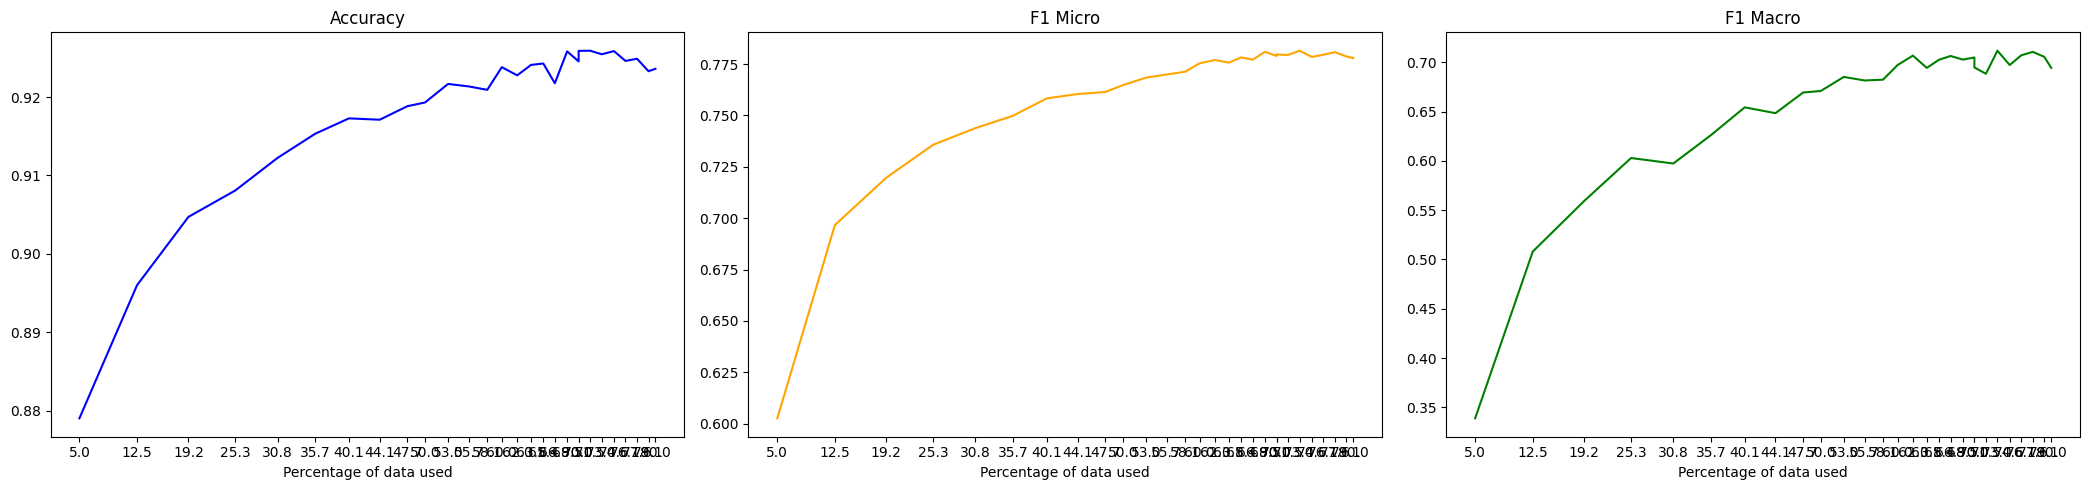

In [ ]:
active_learning(seeds[4], 4)